<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
</center>

## Objectifs : 
<span style="color:  rgb(139, 0, 0)">**Notre projet consiste à analyser et faire des prédictions sur un jeu de données qui fournit un aperçu détaillé des routines d’exercice, des attributs physiques et des mesures de la condition physique des membres d’une salle de sport. Il y a deux objectifs principales pour ce projet :  Le premier objectif est de faire une analyse exploratoire des données pour bien cerner nos données. Dans un second temps, on effectuera deux modélisations avec la prédiction de calories brulées et du niveau d'expérience.**</span>

## Table des matières
1. [Analyse explorative des données (langage R)](#analyse-données)
   - Description général (natures des variables, encodages ...)
   - Analyse descriptive unidimensionnelle et bidimensionnelle
   - ACP des différentes variables
2. [Modélisation (langage R et python)](#modélisation)
   - Prédiction des calories brulées
   - Prédiction du niveau d'expérience
# 1. Analyse explorative des données (langage R)
L'analyse de cette partie se fera uniquement en R. 

## 1.1.1 Création du dataset

In [117]:
#install.packages("ggRandomForests")

In [118]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(caret)
library(nnet)
library(mlr3)
library(mlr3learners)
library(mlr3pipelines)
library(RColorBrewer)
library(e1071)
library(rpart)
library(rpart.plot)
library(randomForest)
library(xgboost)
library(MASS)
library(gbm)
library(fastDummies)
library(class)
library(partykit)
library(ggRandomForests)
library(nnet)

Dans un premier temps, on télécharge le dataset.

In [119]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
data <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)
# Premières lignes du jeu de données
head(data)
# Vérification du contenu
summary(data)

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,BMI
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,56,Male,88.3,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,30.20
2,46,Female,74.9,1.53,179,151,66,1.30,883,HIIT,33.9,2.1,4,2,32.00
3,32,Female,68.1,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,24.71
4,25,Male,53.2,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,18.41
5,38,Male,46.1,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,14.39
6,56,Female,58.0,1.68,168,156,74,1.59,1116,HIIT,15.5,2.7,5,3,20.55


      Age           Gender           Weight..kg.       Height..m.   
 Min.   :18.00   Length:973         Min.   : 40.00   Min.   :1.500  
 1st Qu.:28.00   Class :character   1st Qu.: 58.10   1st Qu.:1.620  
 Median :40.00   Mode  :character   Median : 70.00   Median :1.710  
 Mean   :38.68                      Mean   : 73.85   Mean   :1.723  
 3rd Qu.:49.00                      3rd Qu.: 86.00   3rd Qu.:1.800  
 Max.   :59.00                      Max.   :129.90   Max.   :2.000  
    Max_BPM         Avg_BPM       Resting_BPM    Session_Duration..hours.
 Min.   :160.0   Min.   :120.0   Min.   :50.00   Min.   :0.500           
 1st Qu.:170.0   1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040           
 Median :180.0   Median :143.0   Median :62.00   Median :1.260           
 Mean   :179.9   Mean   :143.8   Mean   :62.22   Mean   :1.256           
 3rd Qu.:190.0   3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460           
 Max.   :199.0   Max.   :169.0   Max.   :74.00   Max.   :2.000           

On convertit les variables qualitatives en facteur.

In [120]:
data[, "Gender"] <- as.factor(data[, "Gender"])
data[, "Workout_Type"] <- as.factor(data[, "Workout_Type"])
data[, "Experience_Level"] <- as.factor(data[, "Experience_Level"])
data[, "Workout_Frequency..days.week."] <- as.factor(data[, "Workout_Frequency..days.week."])

## 1.1.2 Normalisation des données

Fonction qui permet d'afficher la distribution d'une variable.

In [121]:
make_plot <- function(data, var, title, binwidth = NULL) {
  ggplot(data, aes(x = {{ var }})) +
    geom_histogram(aes(y = after_stat(density)),
                   fill = "lightblue",
                   color = "black",
                   binwidth = binwidth) +
    geom_density(alpha = 0.4, color = "blue") +
    ggtitle(title) +
    theme_minimal(base_size = 12)
}

On affiche les distributions des variables pour voir si certaines doivent être normalisées ou non.

In [122]:
g1 <- make_plot(data, Age, "Âge", 5)
g3 <- make_plot(data, Weight..kg., "Poids (kg)", 5)
g4 <- make_plot(data, Height..m., "Taille (m)", 0.05)
g5 <- make_plot(data, Max_BPM, "BPM Max", 5)
g6 <- make_plot(data, Avg_BPM, "BPM Moyen", 5)
g7 <- make_plot(data, Resting_BPM, "BPM Repos", 5)
g8 <- make_plot(data, Session_Duration..hours., "Durée Session (h)", 0.5)
g9 <- make_plot(data, Calories_Burned, "Calories Brûlées", 50)
g11 <- make_plot(data, Fat_Percentage, "Masse Grasse (%)", 2)
g12 <- make_plot(data, Water_Intake..liters., "Hydratation (L)", 0.2)
g15 <- make_plot(data, BMI, "Indice IMC", 1)

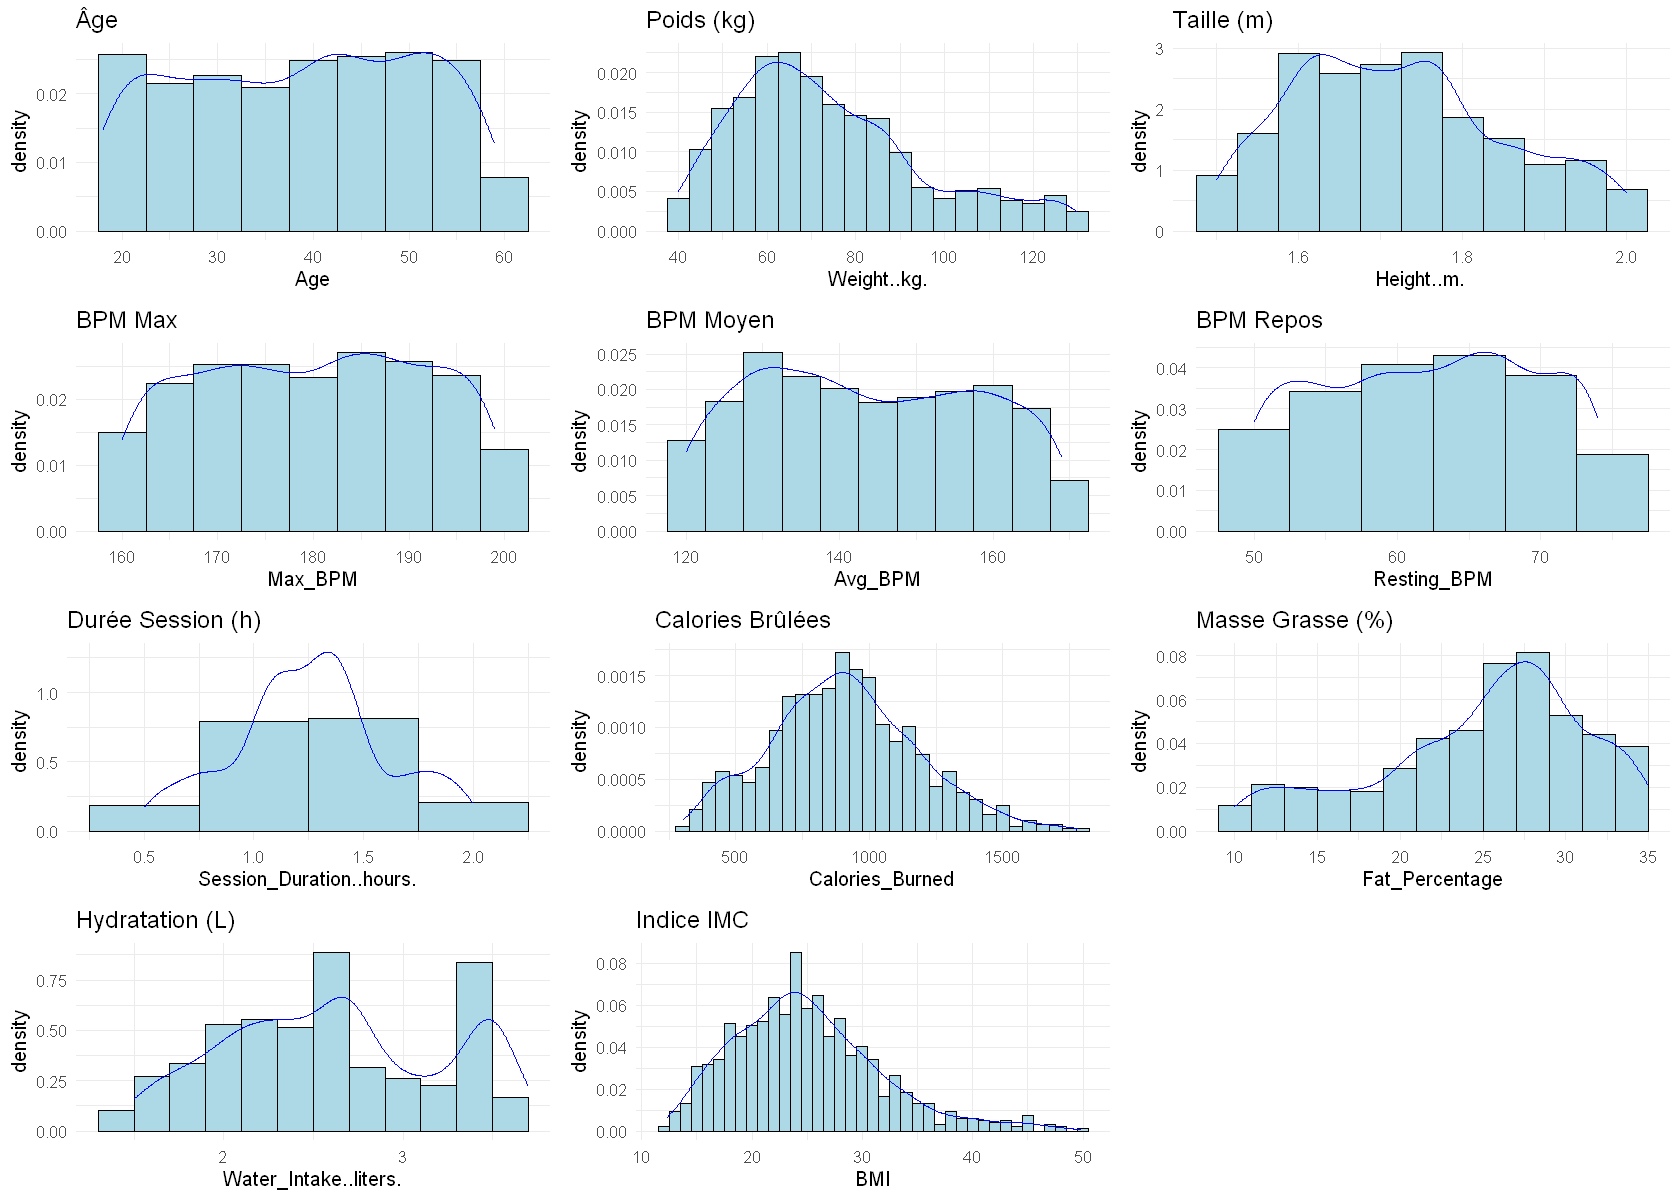

In [123]:
options(repr.plot.width = 14, repr.plot.height = 10)
grid.arrange(g1, g3, g4, g5, g6, g7, g8, g9, g11, g12, g15, ncol = 3)

On va normaliser 4 variables dont les distributions ne semblent pas très gaussiennes :
- BMI : indice de masse corporelle (queue longue à droite)
- Weight..kg. : Poids en kilogrammes (queue longue à droite)
- Calories_Burned : le nombre de calories brulées (déséquilibre droite gauche léger)
- Fat_Percentage : le pourcentage de gras (queue longue à gauche)

Cela sera bénéfique par la suite pour plusieurs méthodes de régression et de classification.

In [124]:
# Création d'un dataset avec les données normalisées
data_norm <- data

#on utilise la fonction racine
data_norm[, "sBMI"] <- sqrt(data_norm[, "BMI"])

#on utilise la fonction racine
data_norm[, "sWeight..kg."] <- sqrt(data_norm[, "Weight..kg."])

#on utilise la fonction racine
data_norm[, "sCalories_Burned"] <- sqrt(data_norm[, "Calories_Burned"])

#paramètre de normalisation lambda
lambda = 2
data_norm[, "BCFat_Percentage"] <- (data_norm[, "Fat_Percentage"]**lambda)/lambda

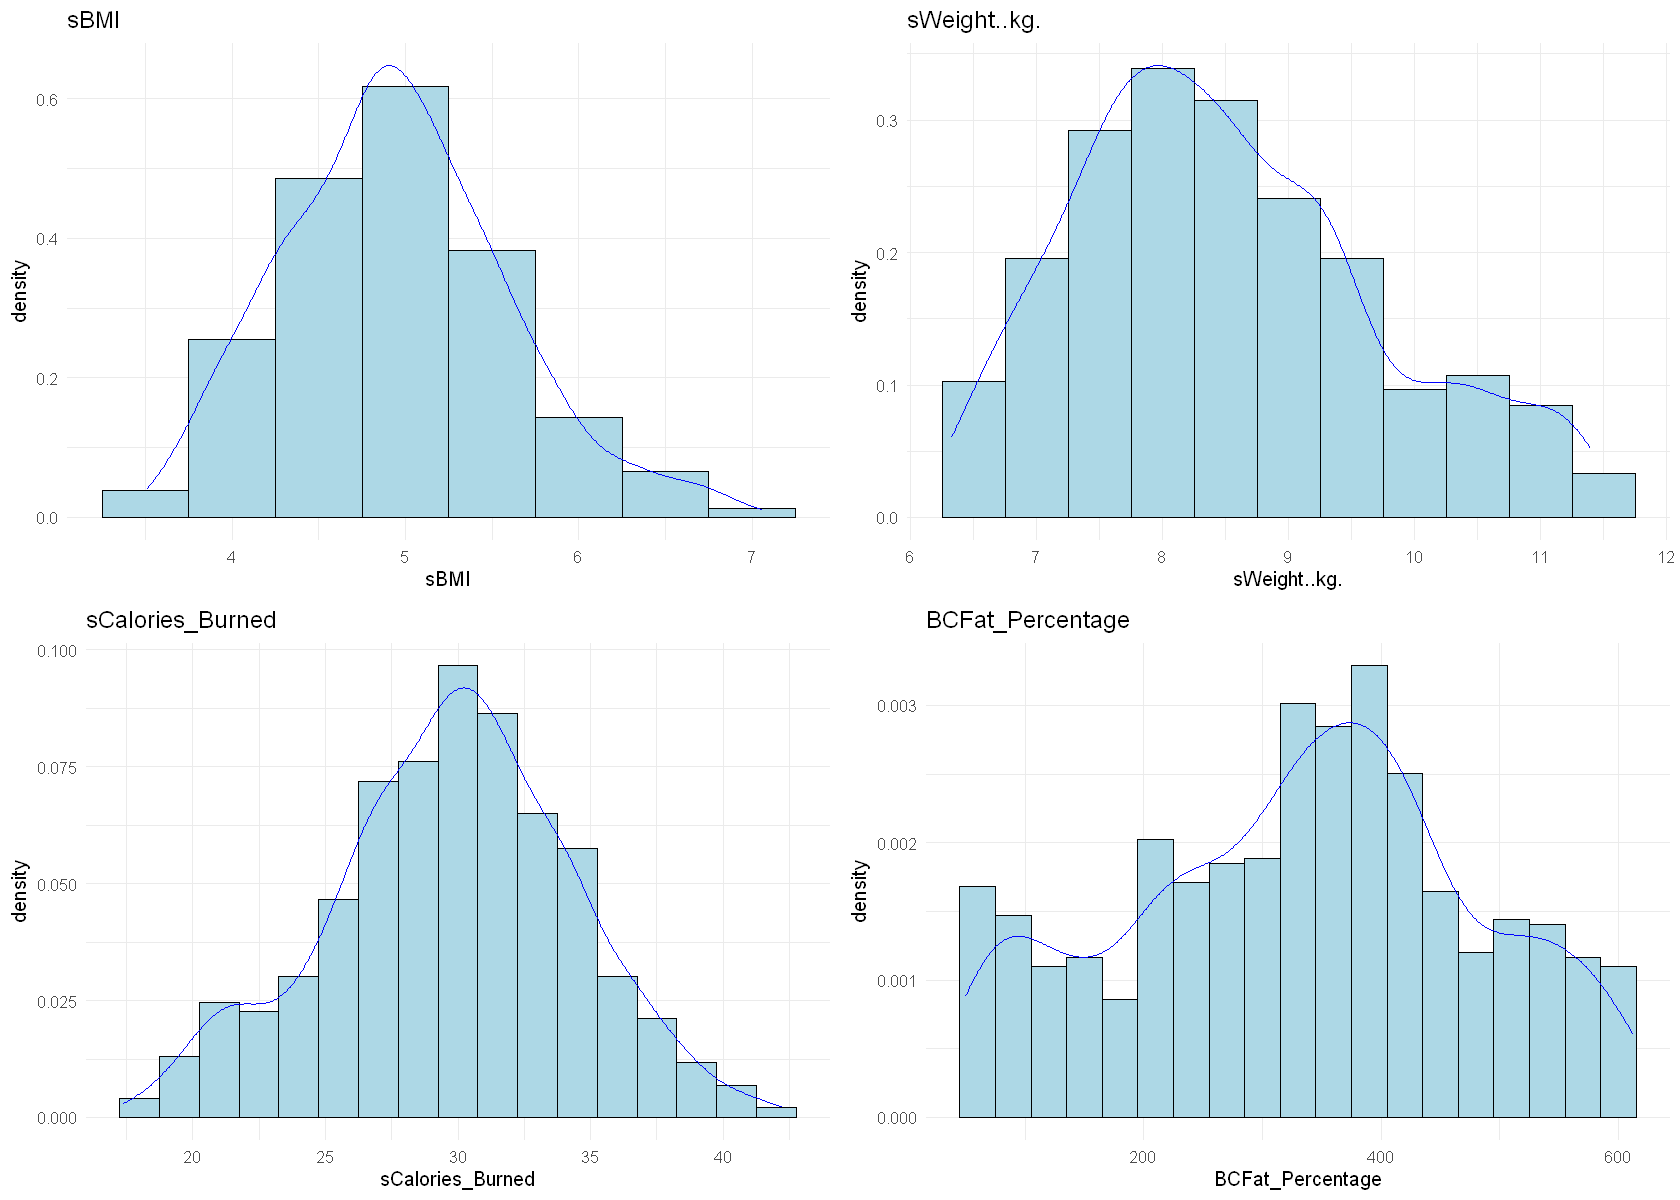

In [125]:
g16 <- make_plot(data_norm, sBMI,"sBMI", 0.5)
g17 <- make_plot(data_norm, sWeight..kg., "sWeight..kg.", 0.5)
g18 <- make_plot(data_norm, sCalories_Burned, "sCalories_Burned", 1.5)
g19 <- make_plot(data_norm, BCFat_Percentage, "BCFat_Percentage", 30)

options(repr.plot.width = 14, repr.plot.height = 10)
grid.arrange(g16, g17, g18, g19, ncol = 2)

Les distributions sont un peu plus équilibrées désormais, et se rapprochent plus d'une distribution gaussienne.

In [126]:
# On réorganise data_norm pour pouvoir l'utiliser comme data

data_norm <- data_norm[, !names(data_norm) %in% c("BMI", "Weight..kg.", "Calories_Burned", "Fat_Percentage")]

cols <- c("Age", "Gender", "sWeight..kg.", "Height..m.", "Max_BPM", "Avg_BPM",
          "Resting_BPM", "Session_Duration..hours.", "sCalories_Burned", "Workout_Type",
          "BCFat_Percentage", "Water_Intake..liters.", "Workout_Frequency..days.week.", "Experience_Level", "sBMI")

data_norm <- data_norm[ , cols]

# Vérification
head(data_norm)

,Age,Gender,sWeight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,sCalories_Burned,Workout_Type,BCFat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,sBMI
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,56,Male,9.396808,1.71,180,157,60,1.69,36.23534,Yoga,79.380,3.5,4,3,5.495453
2,46,Female,8.654479,1.53,179,151,66,1.30,29.71532,HIIT,574.605,2.1,4,2,5.656854
3,32,Female,8.252272,1.66,167,122,54,1.11,26.01922,Cardio,557.780,2.3,4,2,4.970915
4,25,Male,7.293833,1.70,190,164,56,0.59,23.06513,Strength,414.720,2.1,3,1,4.290688
5,38,Male,6.789698,1.79,188,158,68,0.64,23.57965,Strength,426.320,2.8,3,1,3.793415
6,56,Female,7.615773,1.68,168,156,74,1.59,33.40659,HIIT,120.125,2.7,5,3,4.533211


In [127]:
# création de sous tables pour les variables qualitatives et quantitatives
quanti_columns <- c(1,3:9,11,12,15)
quali_columns <- c(2,10,13,14)

## 1.1.3 Première visualisation des données

Definition d'une fonction qui affiche simultanément la matrice de corrélation et la distribution entre deux variables.

In [128]:

my_hist <- function(data, mapping, ...) {
  var_name <- rlang::as_name(mapping$x)
  var_data <- data[[var_name]]

  data_range <- range(var_data, na.rm = TRUE)
  binwidth <- (data_range[2] - data_range[1]) / 10

  ggplot(data = data, mapping = mapping) +
    geom_histogram(aes(y = after_stat(density)),
                   fill = "lightblue",
                   color = "black",
                   binwidth = binwidth) +
    geom_density(color = "blue", alpha = 0.4) +
    theme_minimal()
}


On applique cette fonction à nos données.

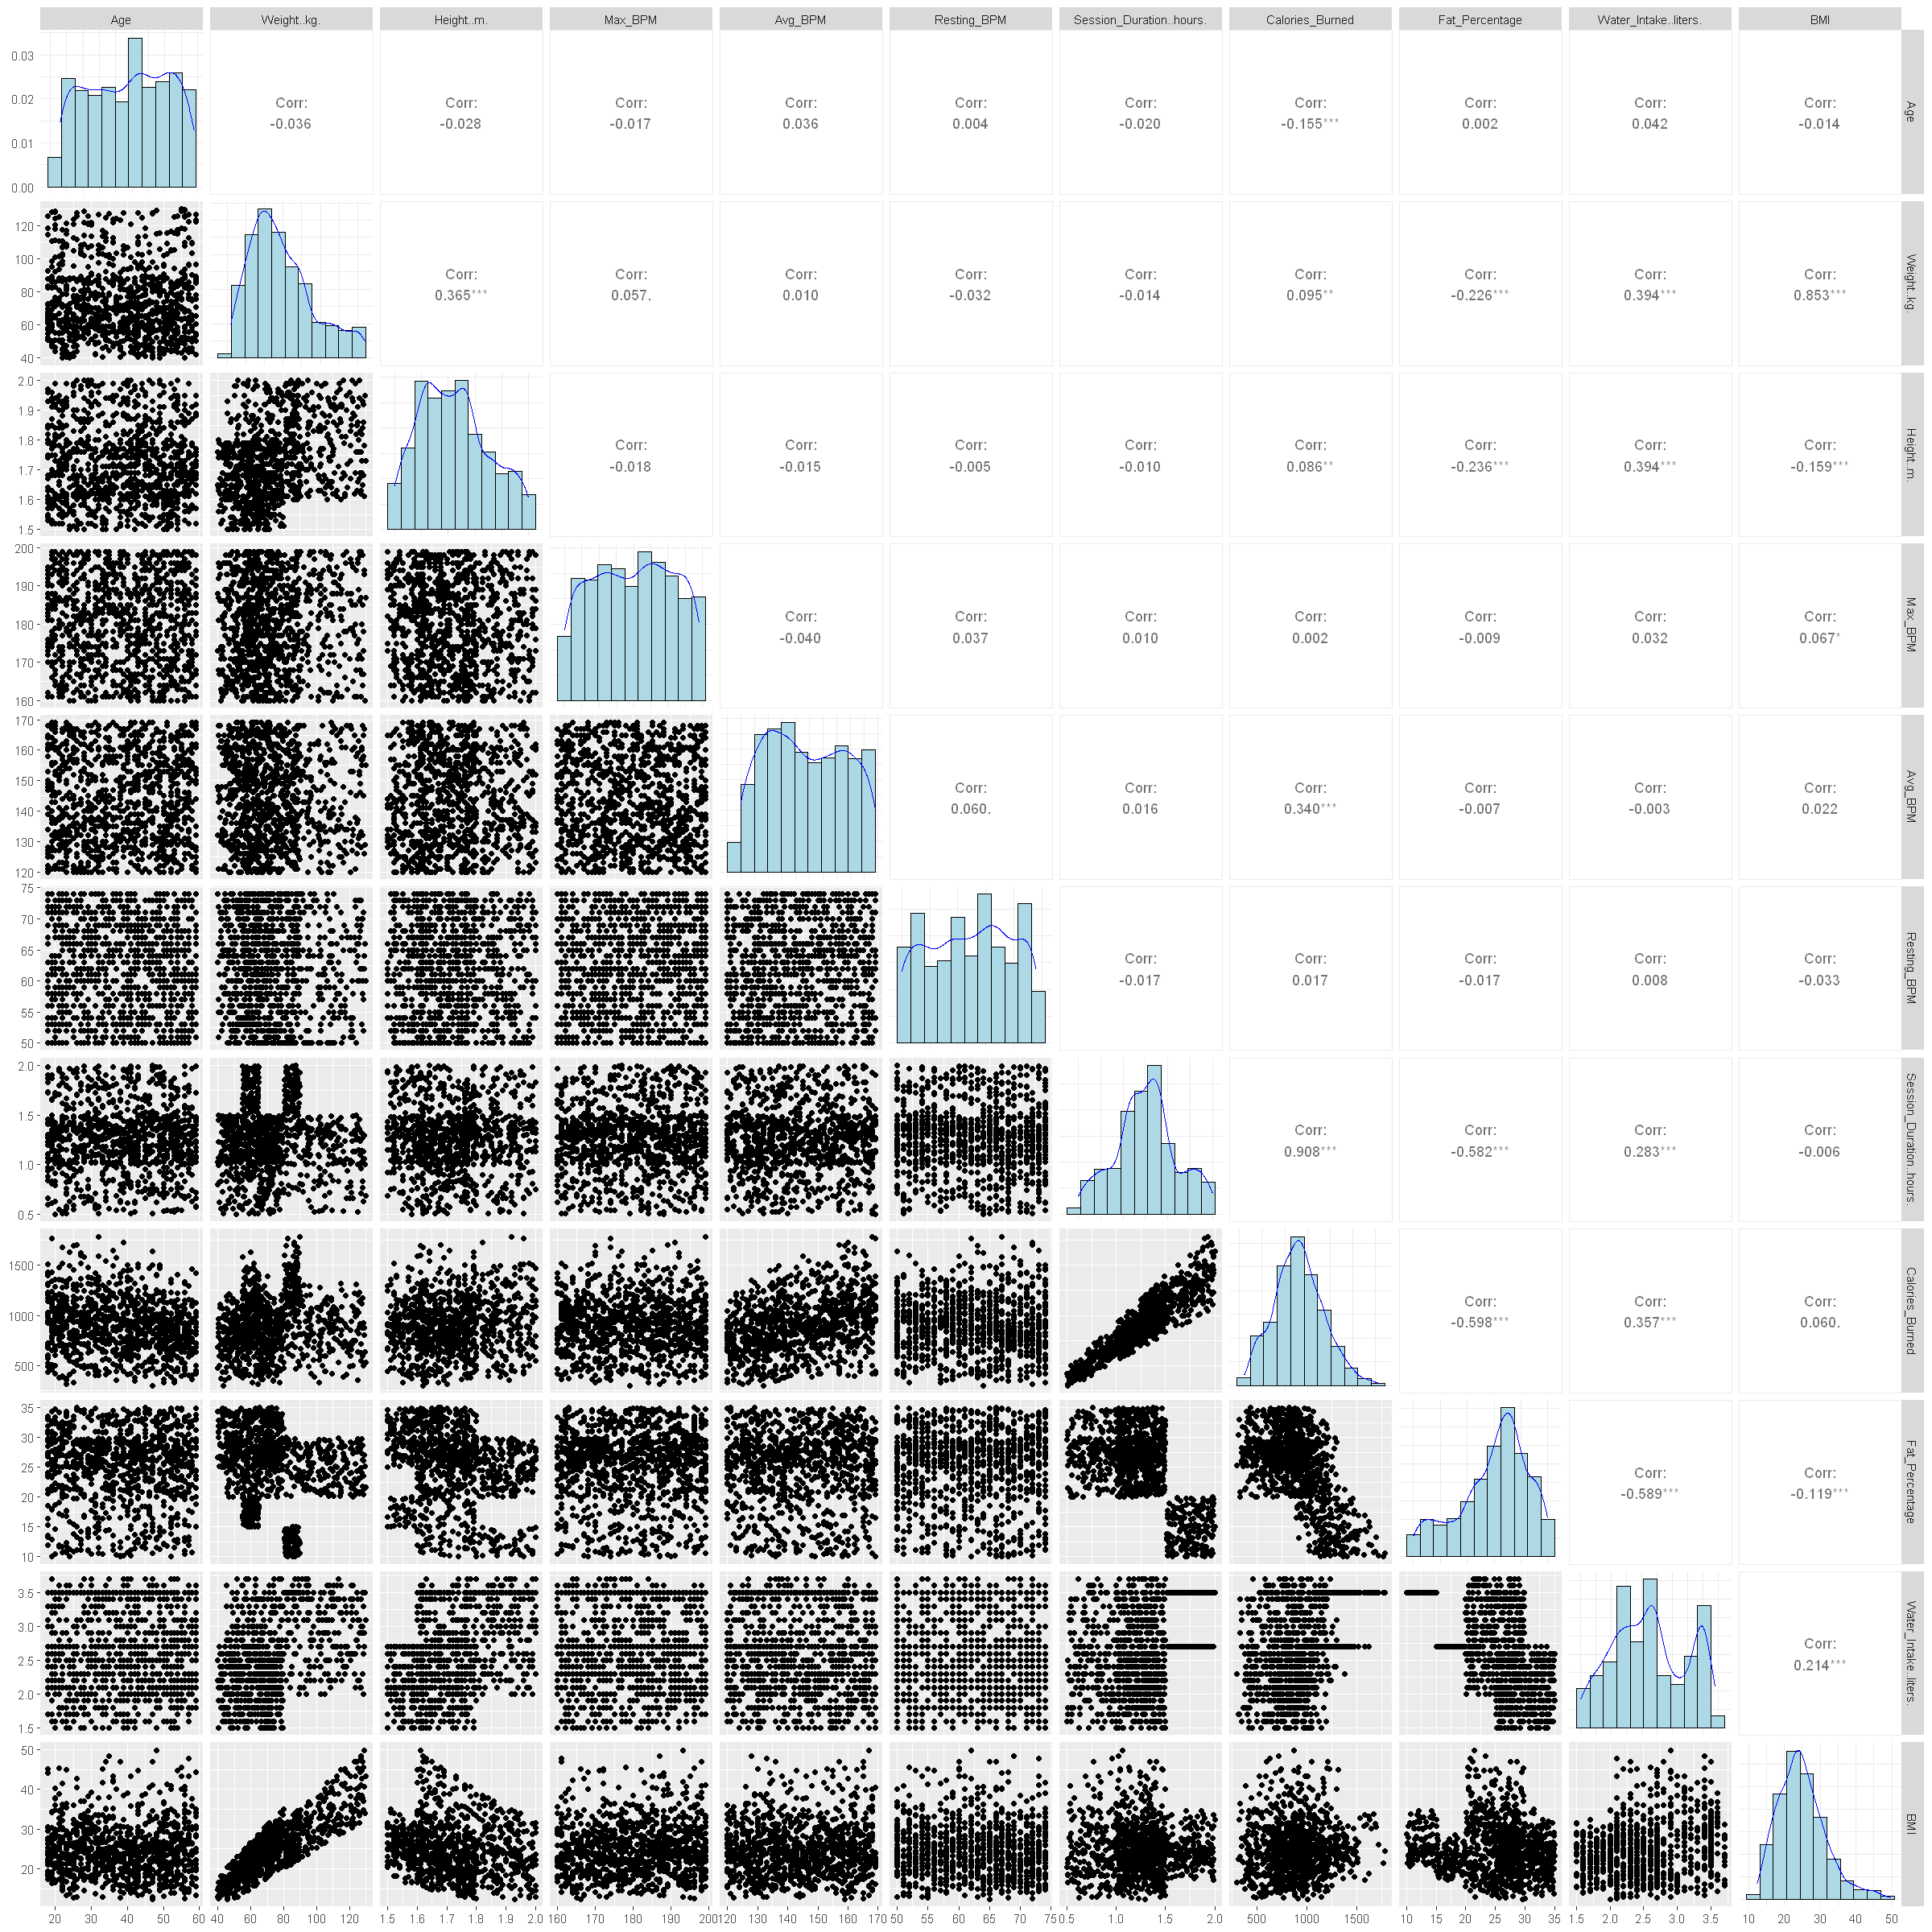

In [129]:
p <- ggpairs(
  data[, quanti_columns],
  diag = list(continuous = my_hist)
)

options(repr.plot.width = 20, repr.plot.height = 20)
print(p)

Cette matrice des corrélations n'est pas la plus lisible, on va l'afficher aussi avec Corrplot:

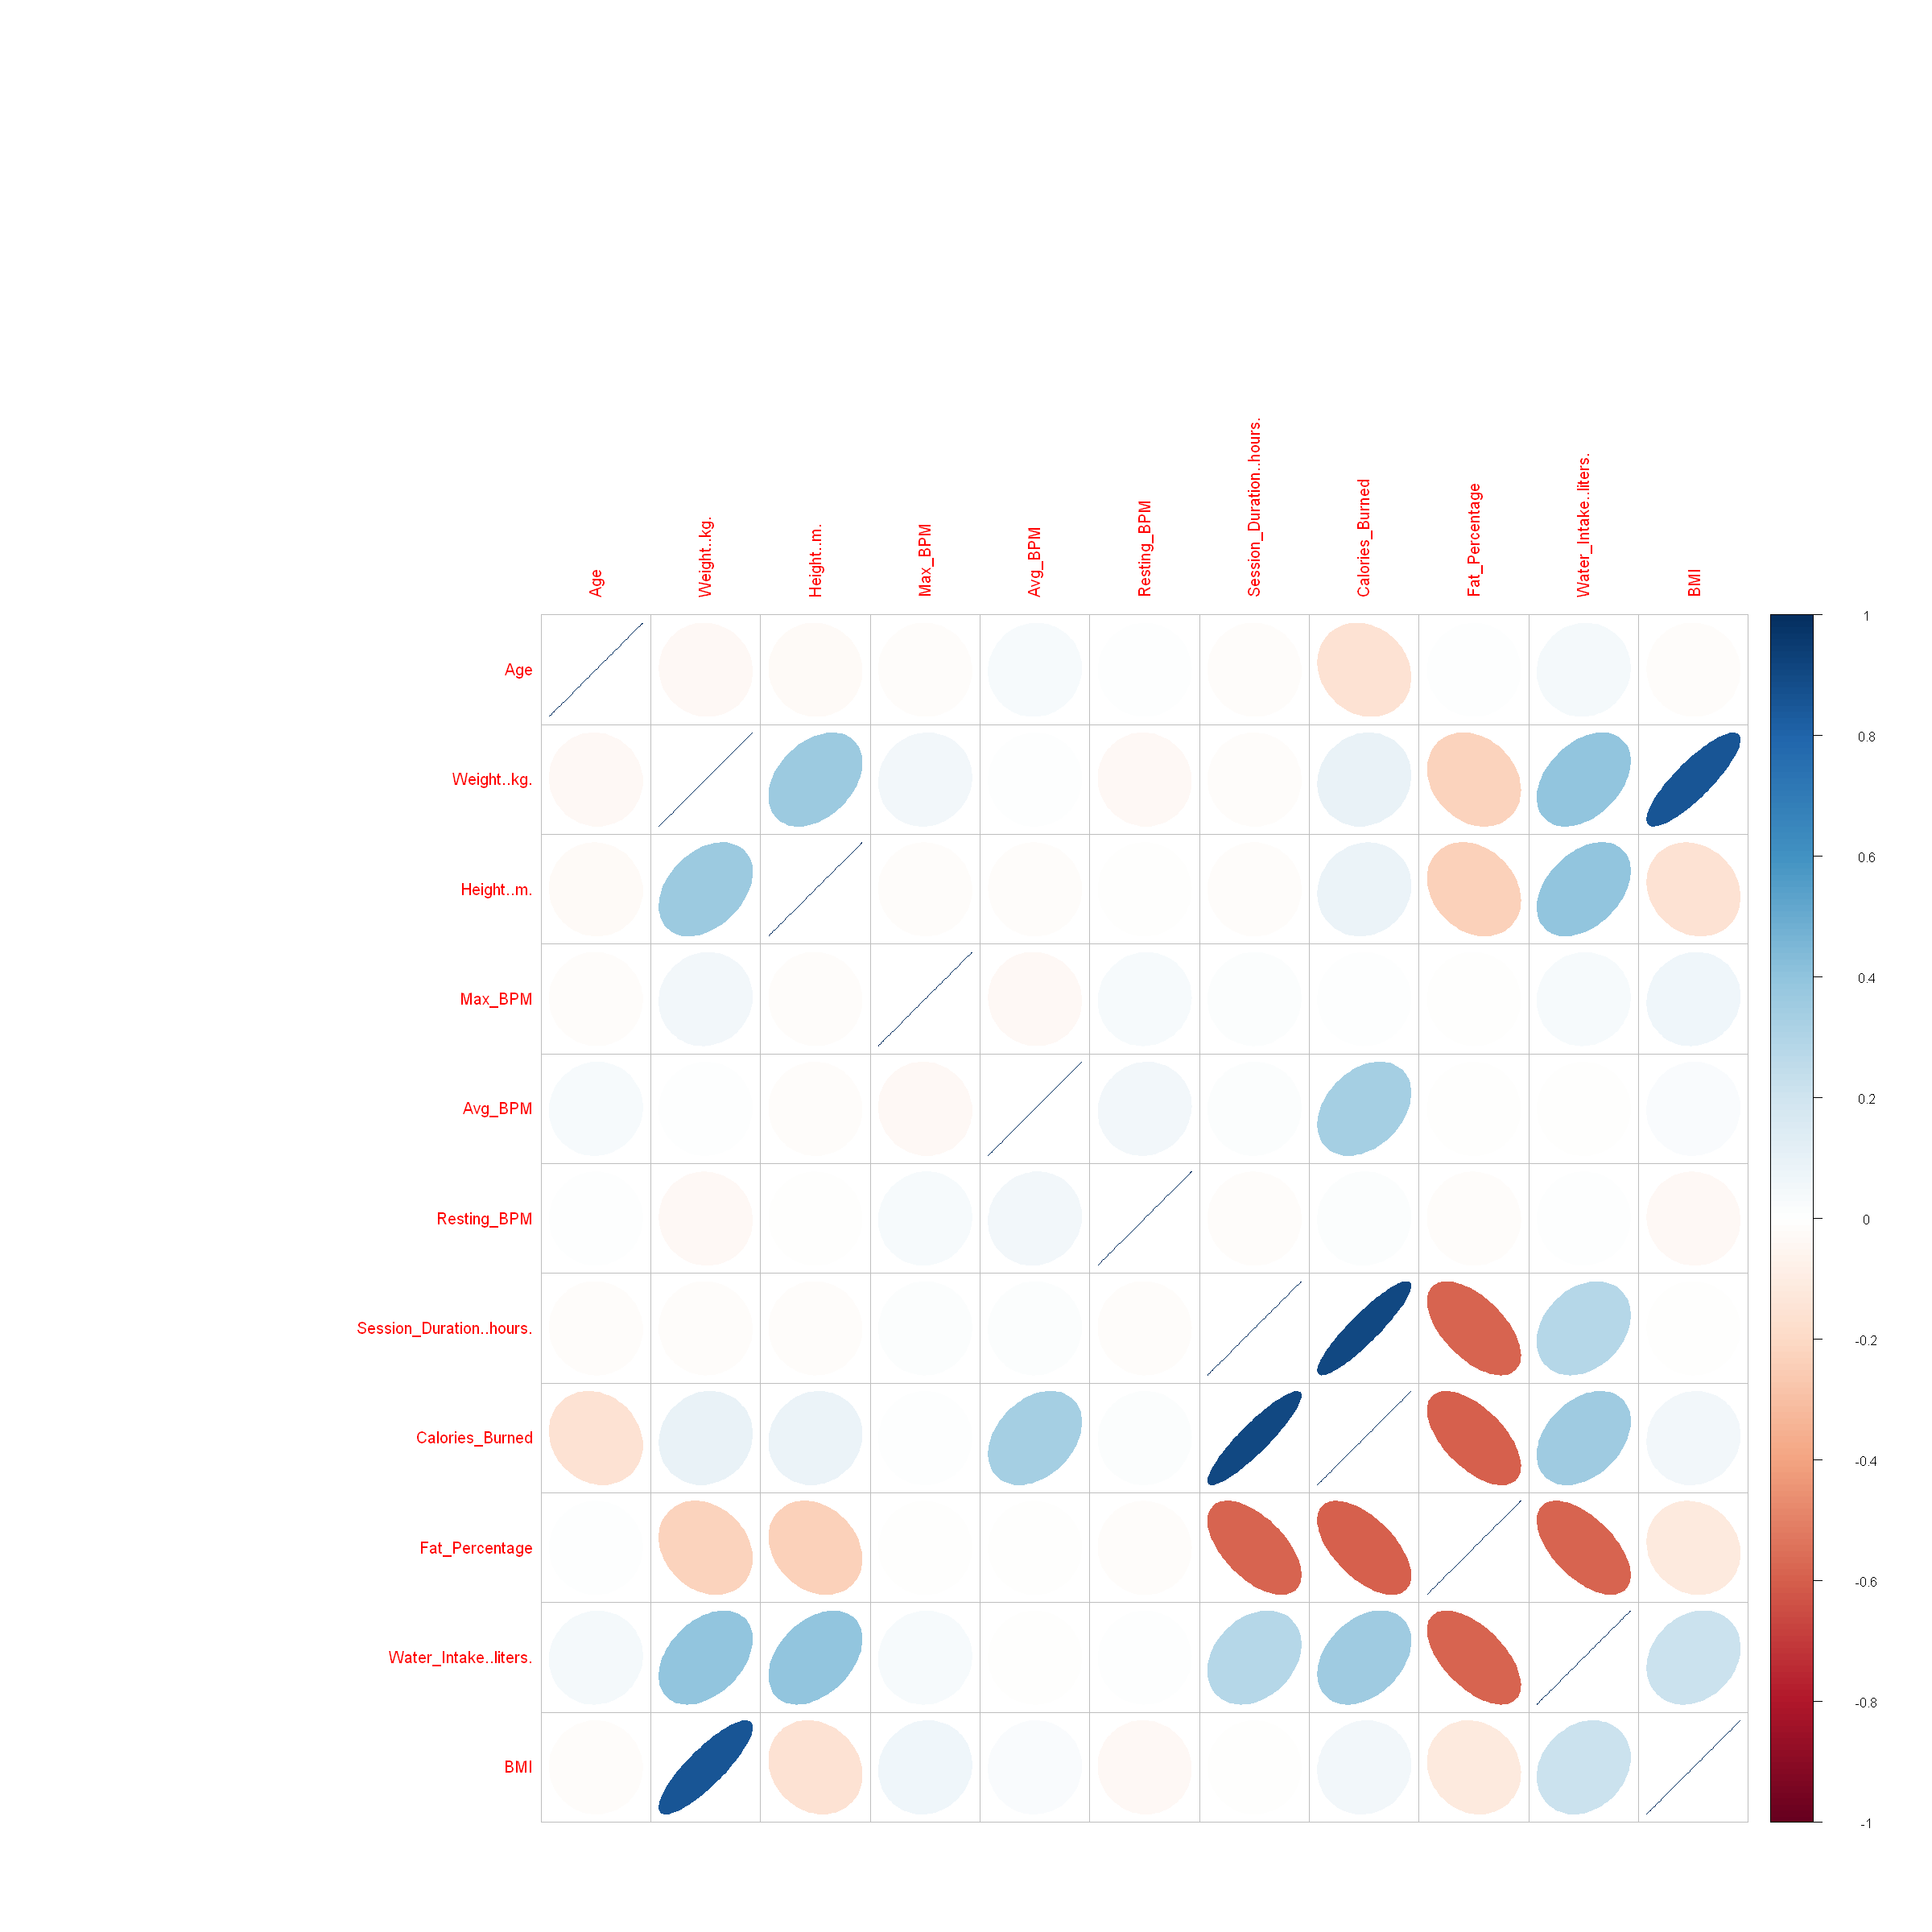

In [130]:
corrplot(cor(data[,quanti_columns]),method="ellipse")

La variable `sCalories_Burned` est corrélée très fortement avec `Session_Duration..hours.`, un peu moins avec `Avg_BPM` et `Water_Intake..liters.`. Les autres variables sont moins corrélées avec `sCalories_Burned`

sWeight..kg.` et `sBMI` sont très corrélées.

Au contraire, `BCFat_Percentage` et  `Session_Duration..hours.` sont négativement corrélées significativement, même constat pour `BCFat_Percentage` et `Water_Intake..liters.

## 1.2.1 Exploration des données en fonction de **Experience_Level**

Afin de préparer la partie classification avec **Experience_Level** comme variable à prédire, nous explorons les distributions des différentes variables en fonction de celle-ci.\
\
Nous commençons par les **variables qualitatives**. Le graphique que nous choisissons ici est le boxplot. Pour chaque variable quantitative, nous allons afficher les boxplot des individus en fonction des 3 classes de Experience_Level. Cela nous permettra de voir les différences de répartition des variables quantitatives en fonction du niveau d'expérience des individus.

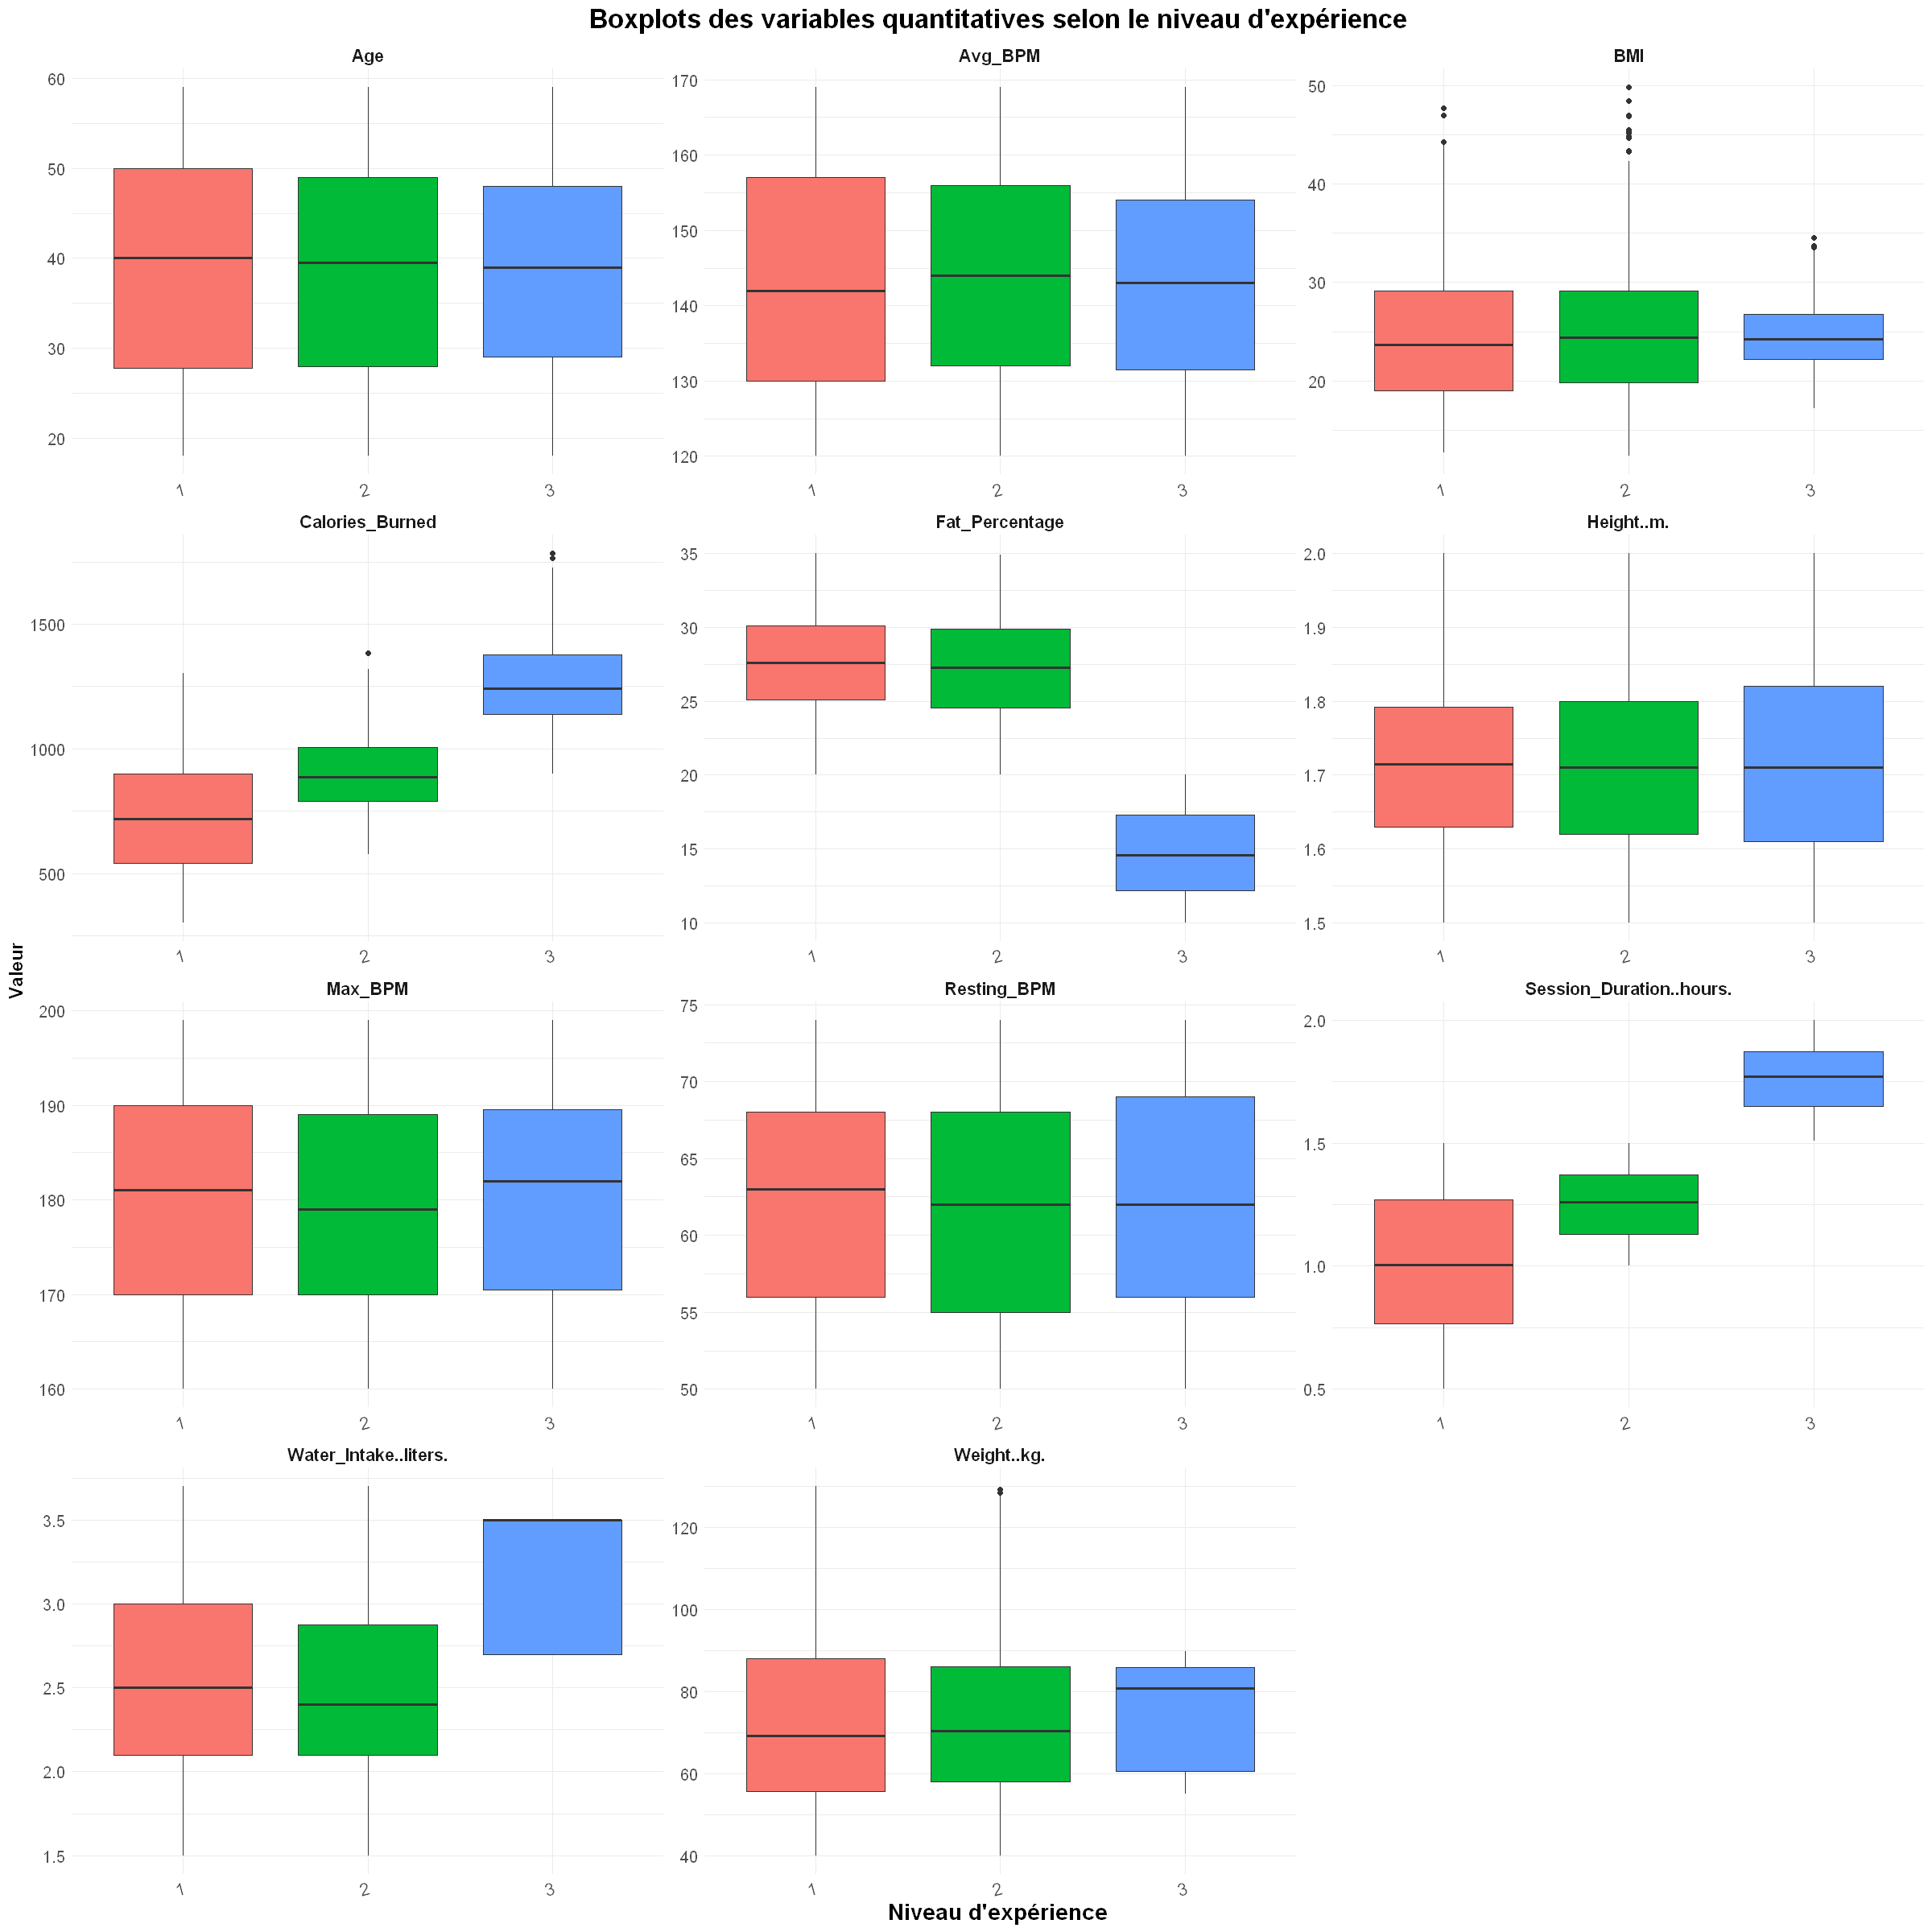

In [131]:
# On créé un dataset avec les variables qualitatives et Experience_Level
data_long <- data[, c(quanti_columns, 14)] %>%
  pivot_longer(-Experience_Level, names_to = "Variable", values_to = "Valeur")

# On trace les boxplots
ggplot(data_long, aes(x = Experience_Level, y = Valeur, fill = Experience_Level)) +
  geom_boxplot() +
  facet_wrap(~ Variable, scales = "free", ncol = 3) + # Permet d'avoir une sortie plutôt compact
  theme_minimal() +
  labs(
    title = "Boxplots des variables quantitatives selon le niveau d'expérience",
    x = "Niveau d'expérience",
    y = "Valeur"
  ) +
  theme(
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 17, face = "bold"),
    axis.title.y = element_text(size = 14, face = "bold"),
    axis.text.x = element_text(size = 13, angle = 15, hjust = 1),
    axis.text.y = element_text(size = 12),
    strip.text = element_text(size = 13, face = "bold"),  # titres des facettes
    legend.position = "none"
  )


**Analyse** :
- Pour la variable **BMI** (IMC), nous pouvons observer que les individus avec un niveau d'entraînement plus élevé ont une variance plus réduite. Leur IMC est plus proche de la médiane. Cela correspond sans doute a situations de surpoids pour les individus experts et intermédiaires.
- Pour la variable **Calories_Burned**, la valeur de cette variable a tendance à augmenter en même temps que le niveau d'expérience. Cela est très marqué pour les individus experts : leur 1er quantile est largement au-dessus du 3e quantile des individus intermédiaires.
- Pour la variable **Fat_Percentage**, les individus experts se distinguent très clairement des autres individus (dont la répartition semble très proche), en ayant un taux de gras plus faible dans leur organisme.
- Pour la variable **Session_durations**, la valeur de cette variable a tendance à augmenter en même temps que le niveau d'expérience. Cela est très marqué pour les individus experts : leur 1er quantile est largement au-dessus du 3e quantile des individus intermédiaires.
- Pour la variable **Water_Intake**, on peut remarquer les individus experts ont tendance à mieux s'hydrater que les autres. Cela semble peut s'expliquer par le fait que leurs sessions sont plus longues, et qu'ils brûlent en moyenne plus de calories.

\
Concernant les autres variables, aucun comportemen nettement différenciée entre les classes n'est à remarquer.

Etudions maintenant les **variables quantitatives**. Nous choisissons ici de présenter les résultats à l'aide des tables de contingence entre les variables qualitatives et la variable Experience_Level. Aussi, nous faisons le choix de ne pas afficher l'effectif portant les deux modalités dans chaque case, mais la proportion d'individu de la modalité Experience_Level appartenant à la modalité de l'autre variable. Ce résultat parmi d'avoir accès plus facilement aux différences de distribution, en particulier parceque la variable Experience_Level n'est pas répartie équitablement. 

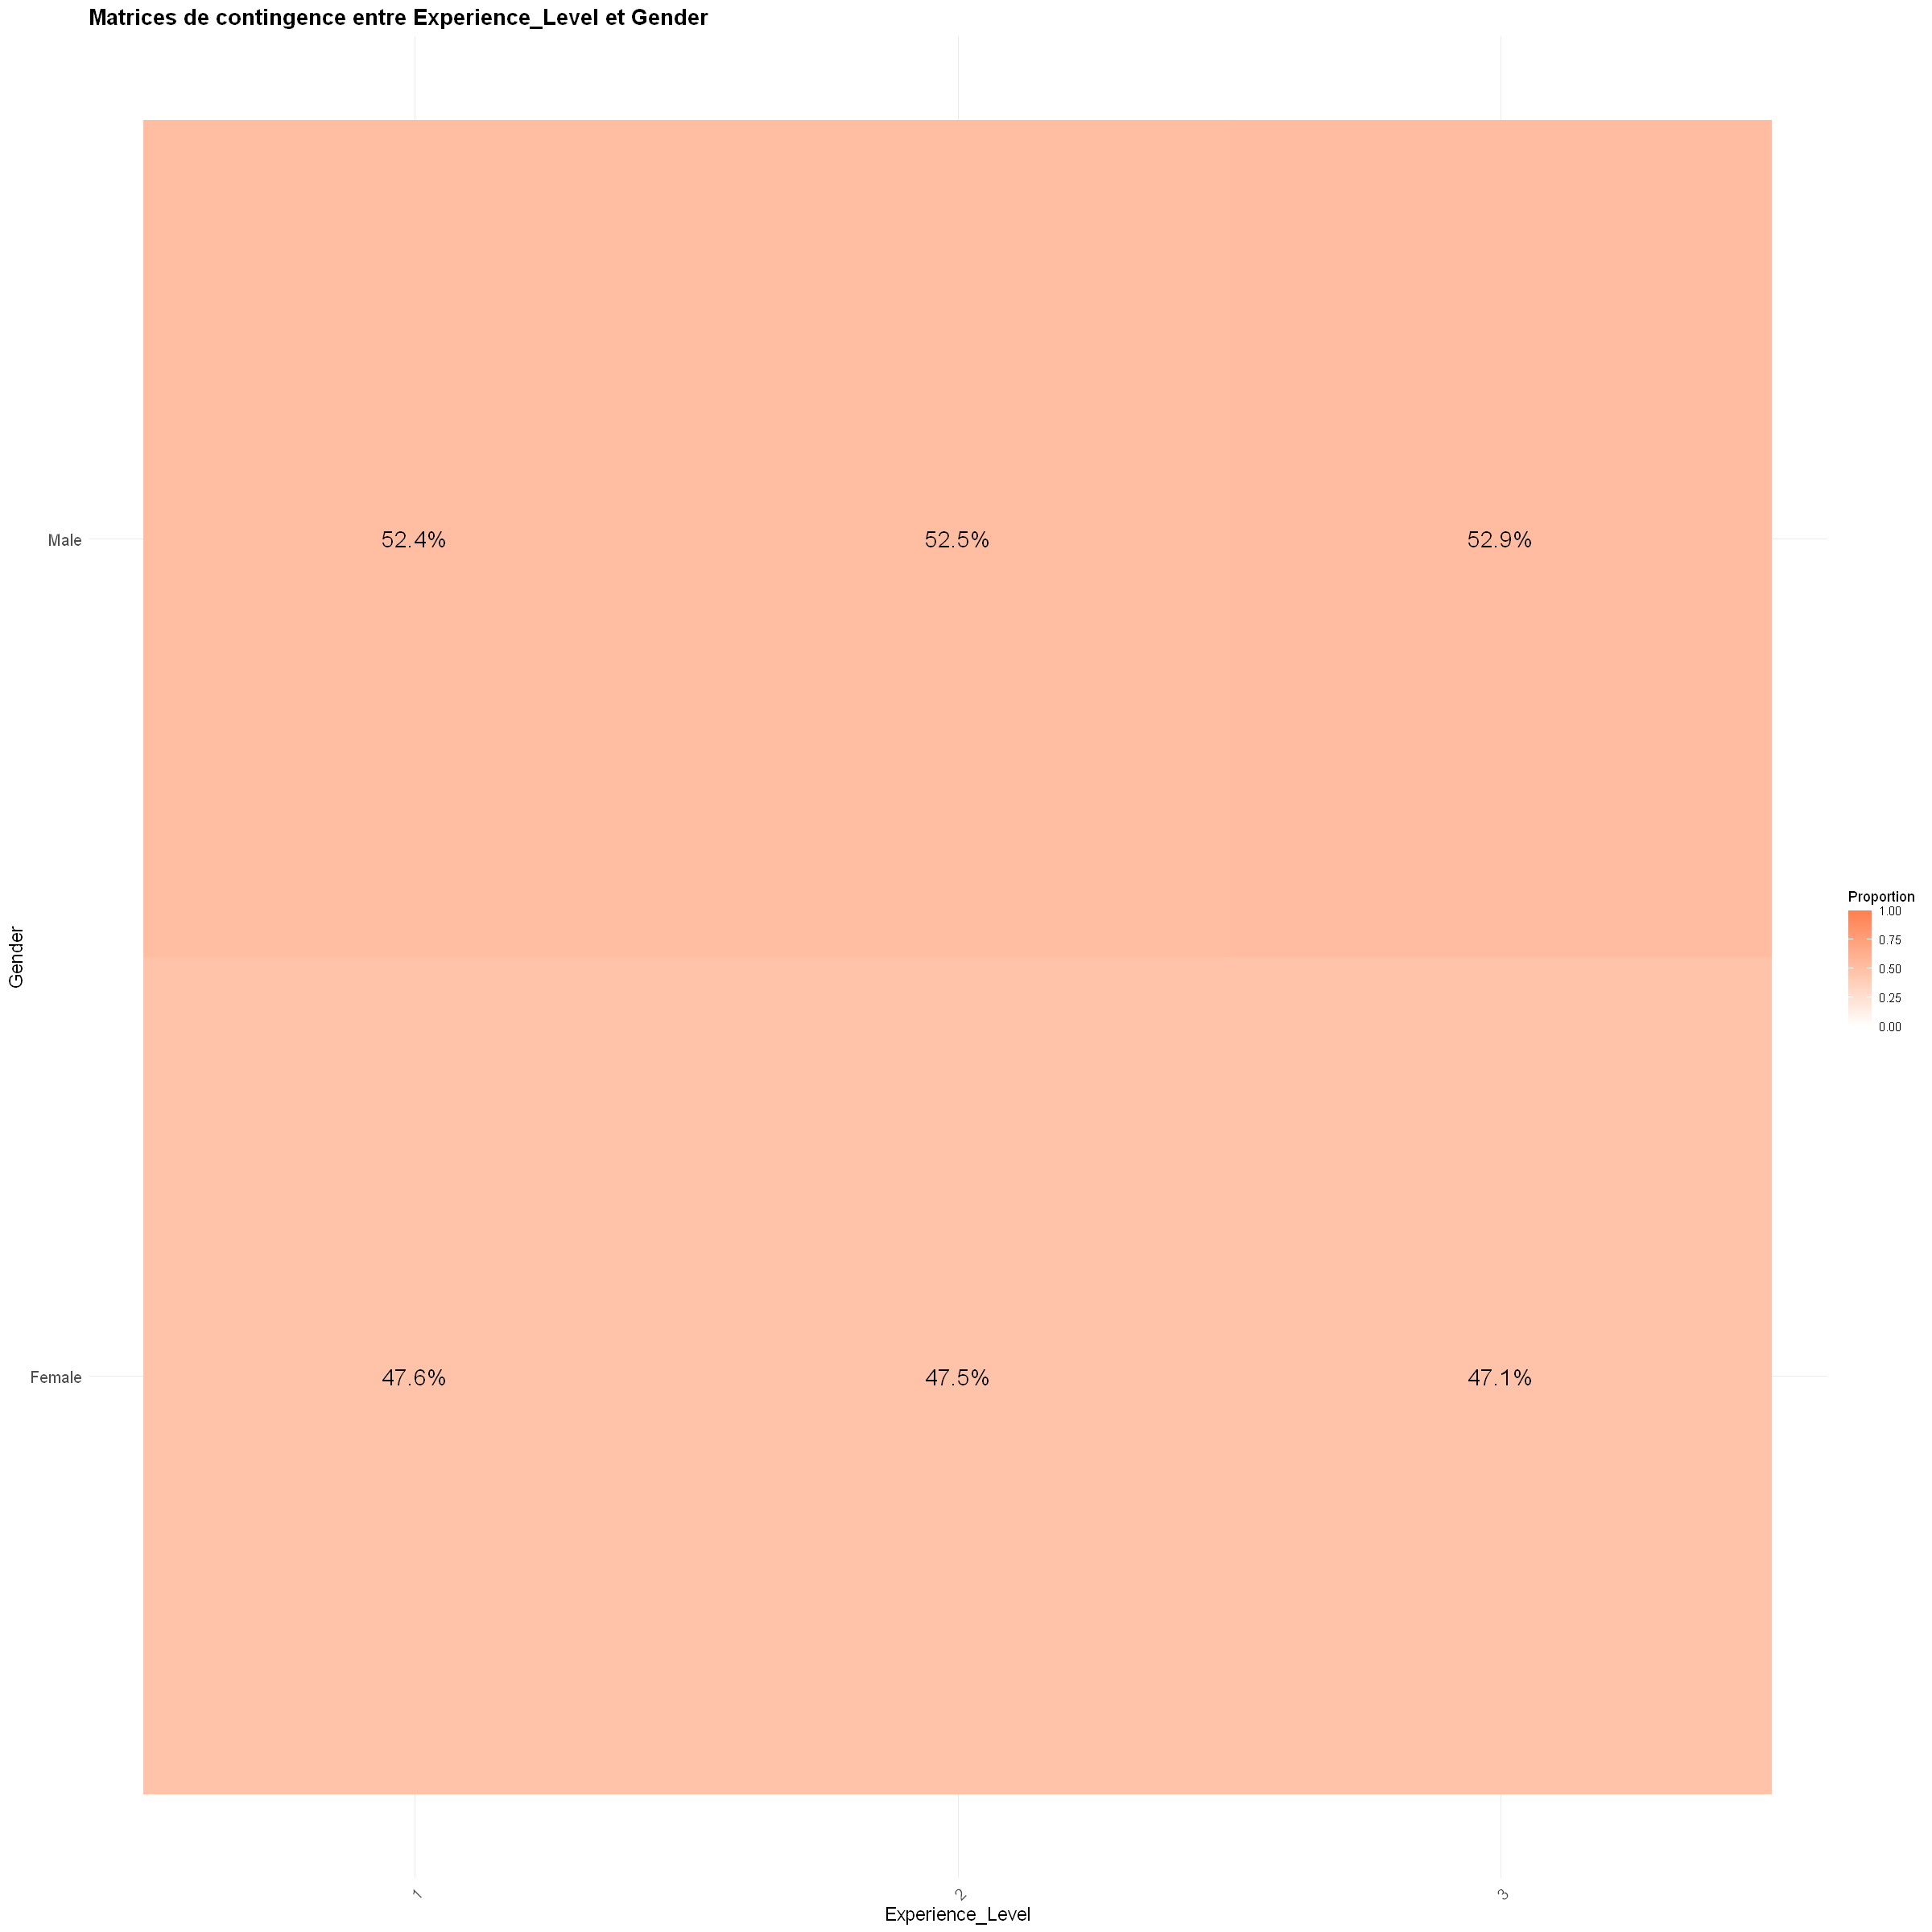

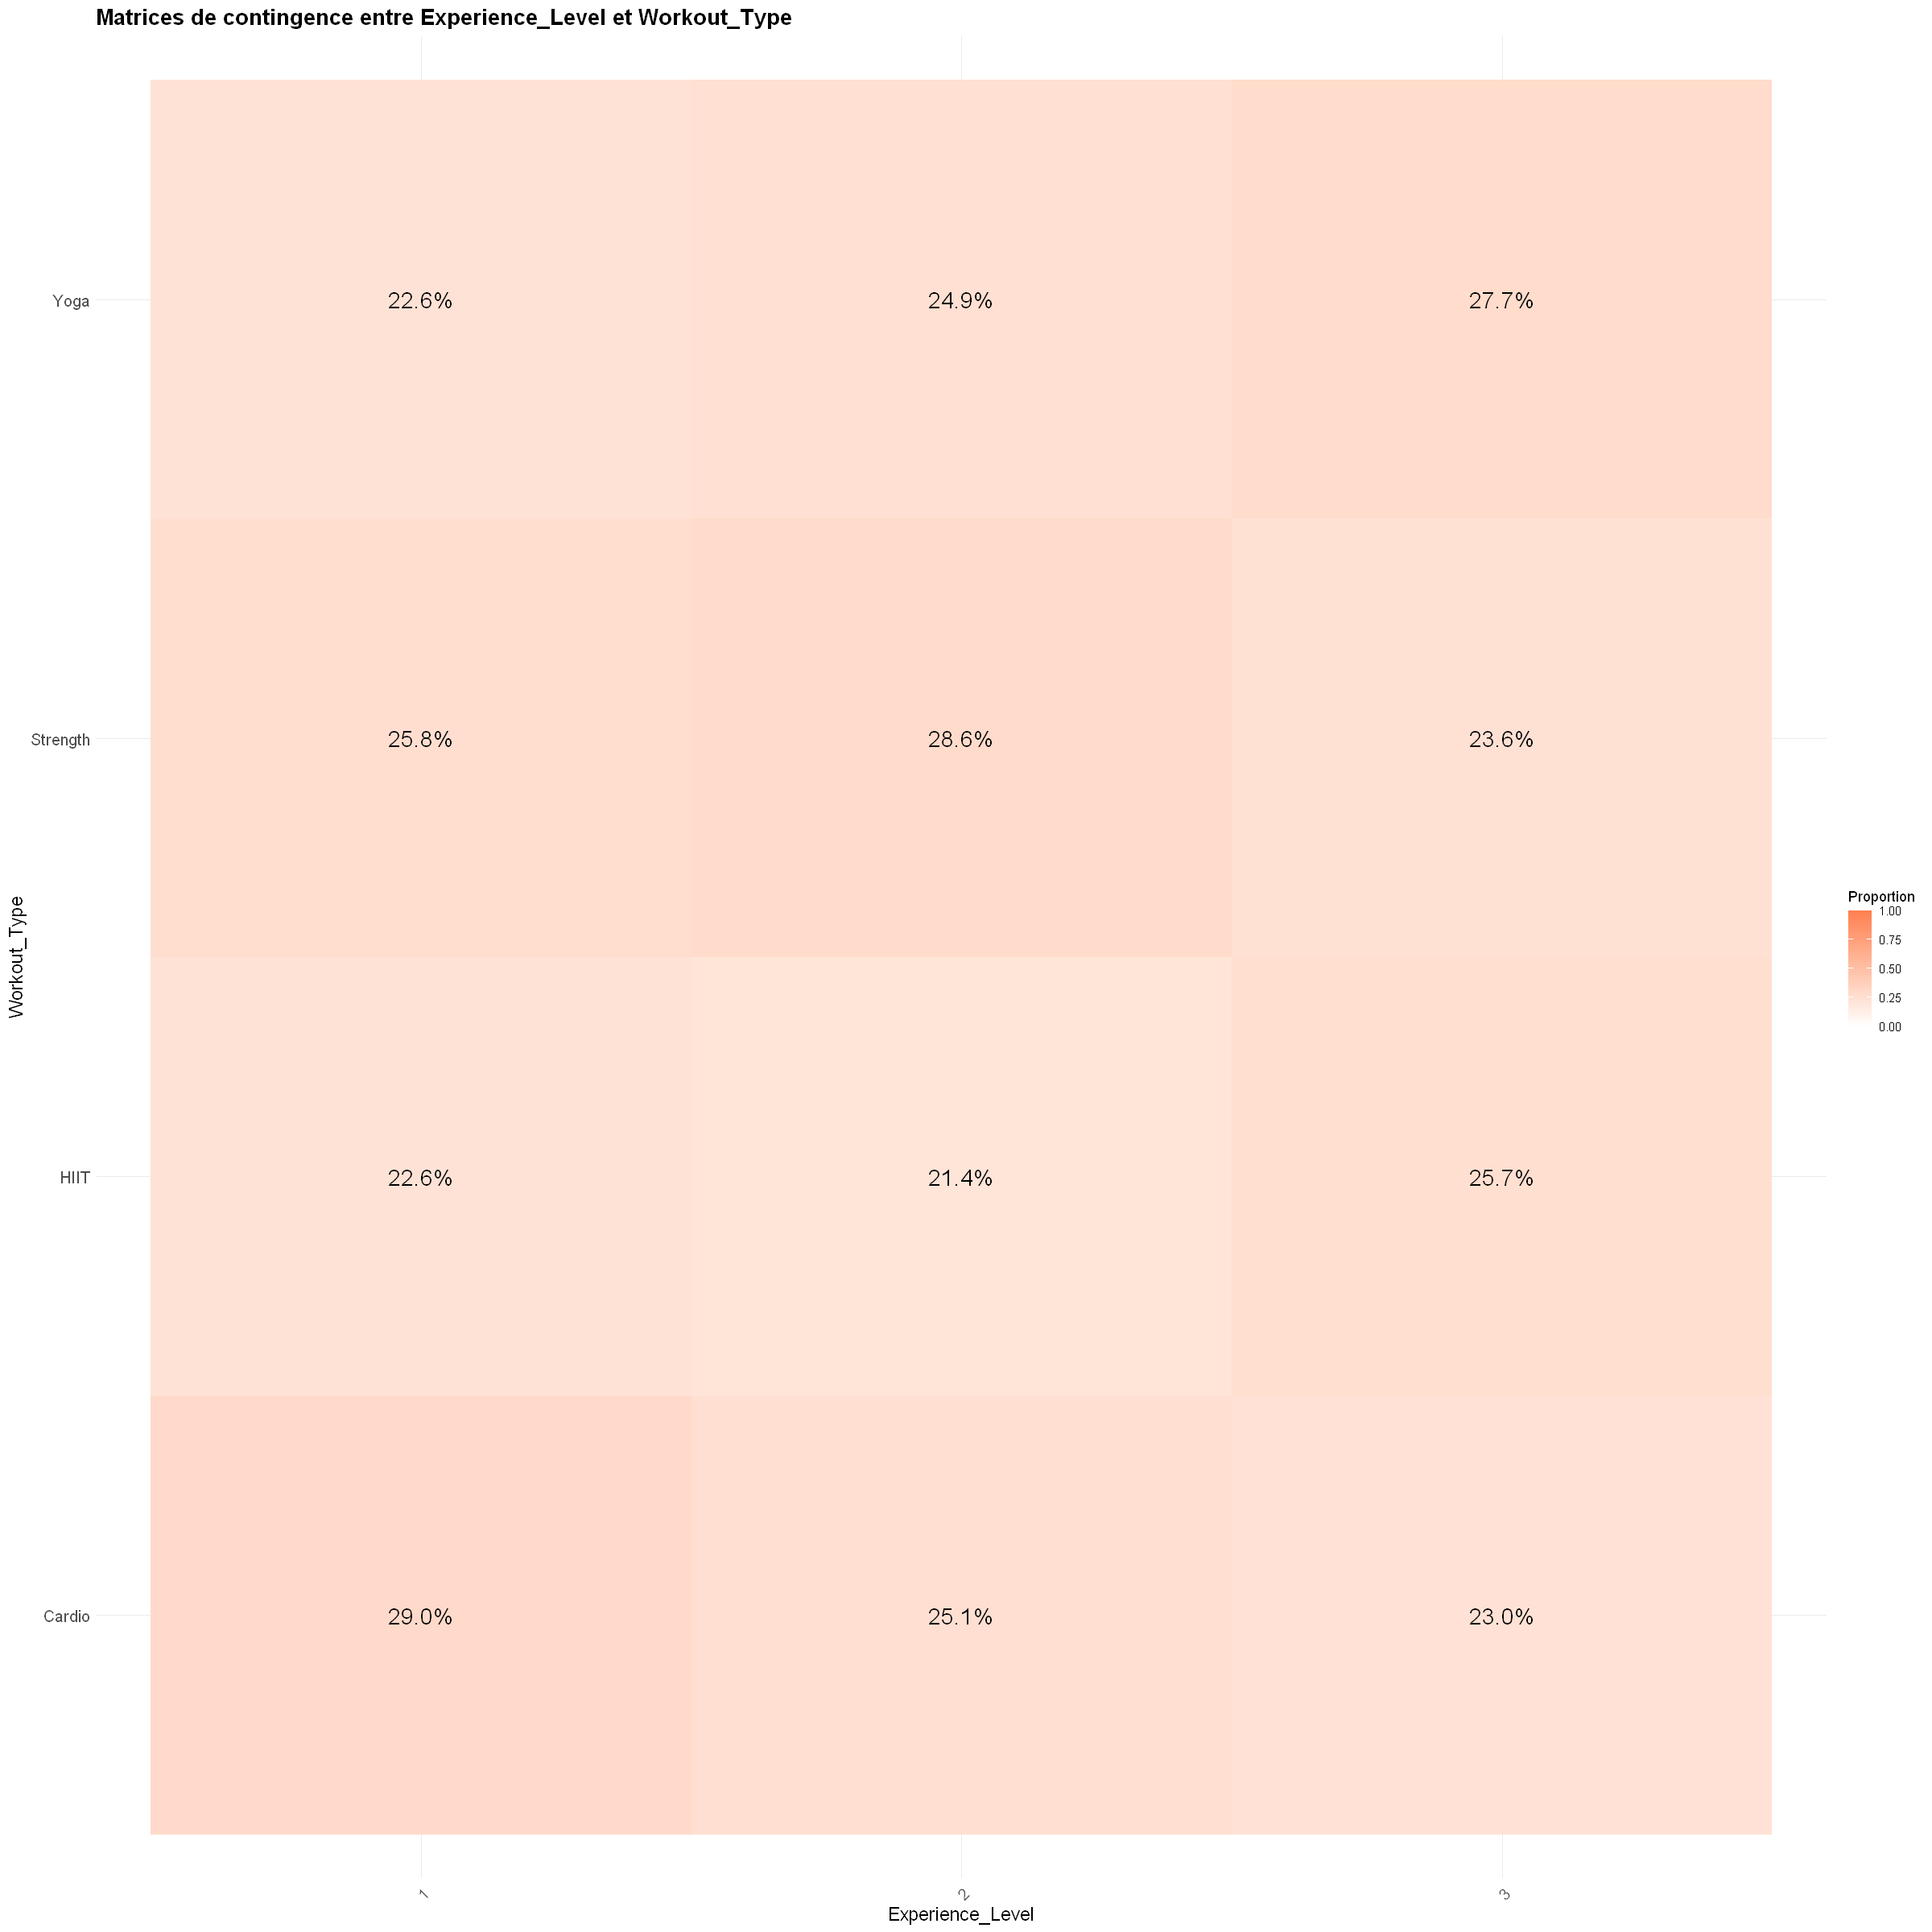

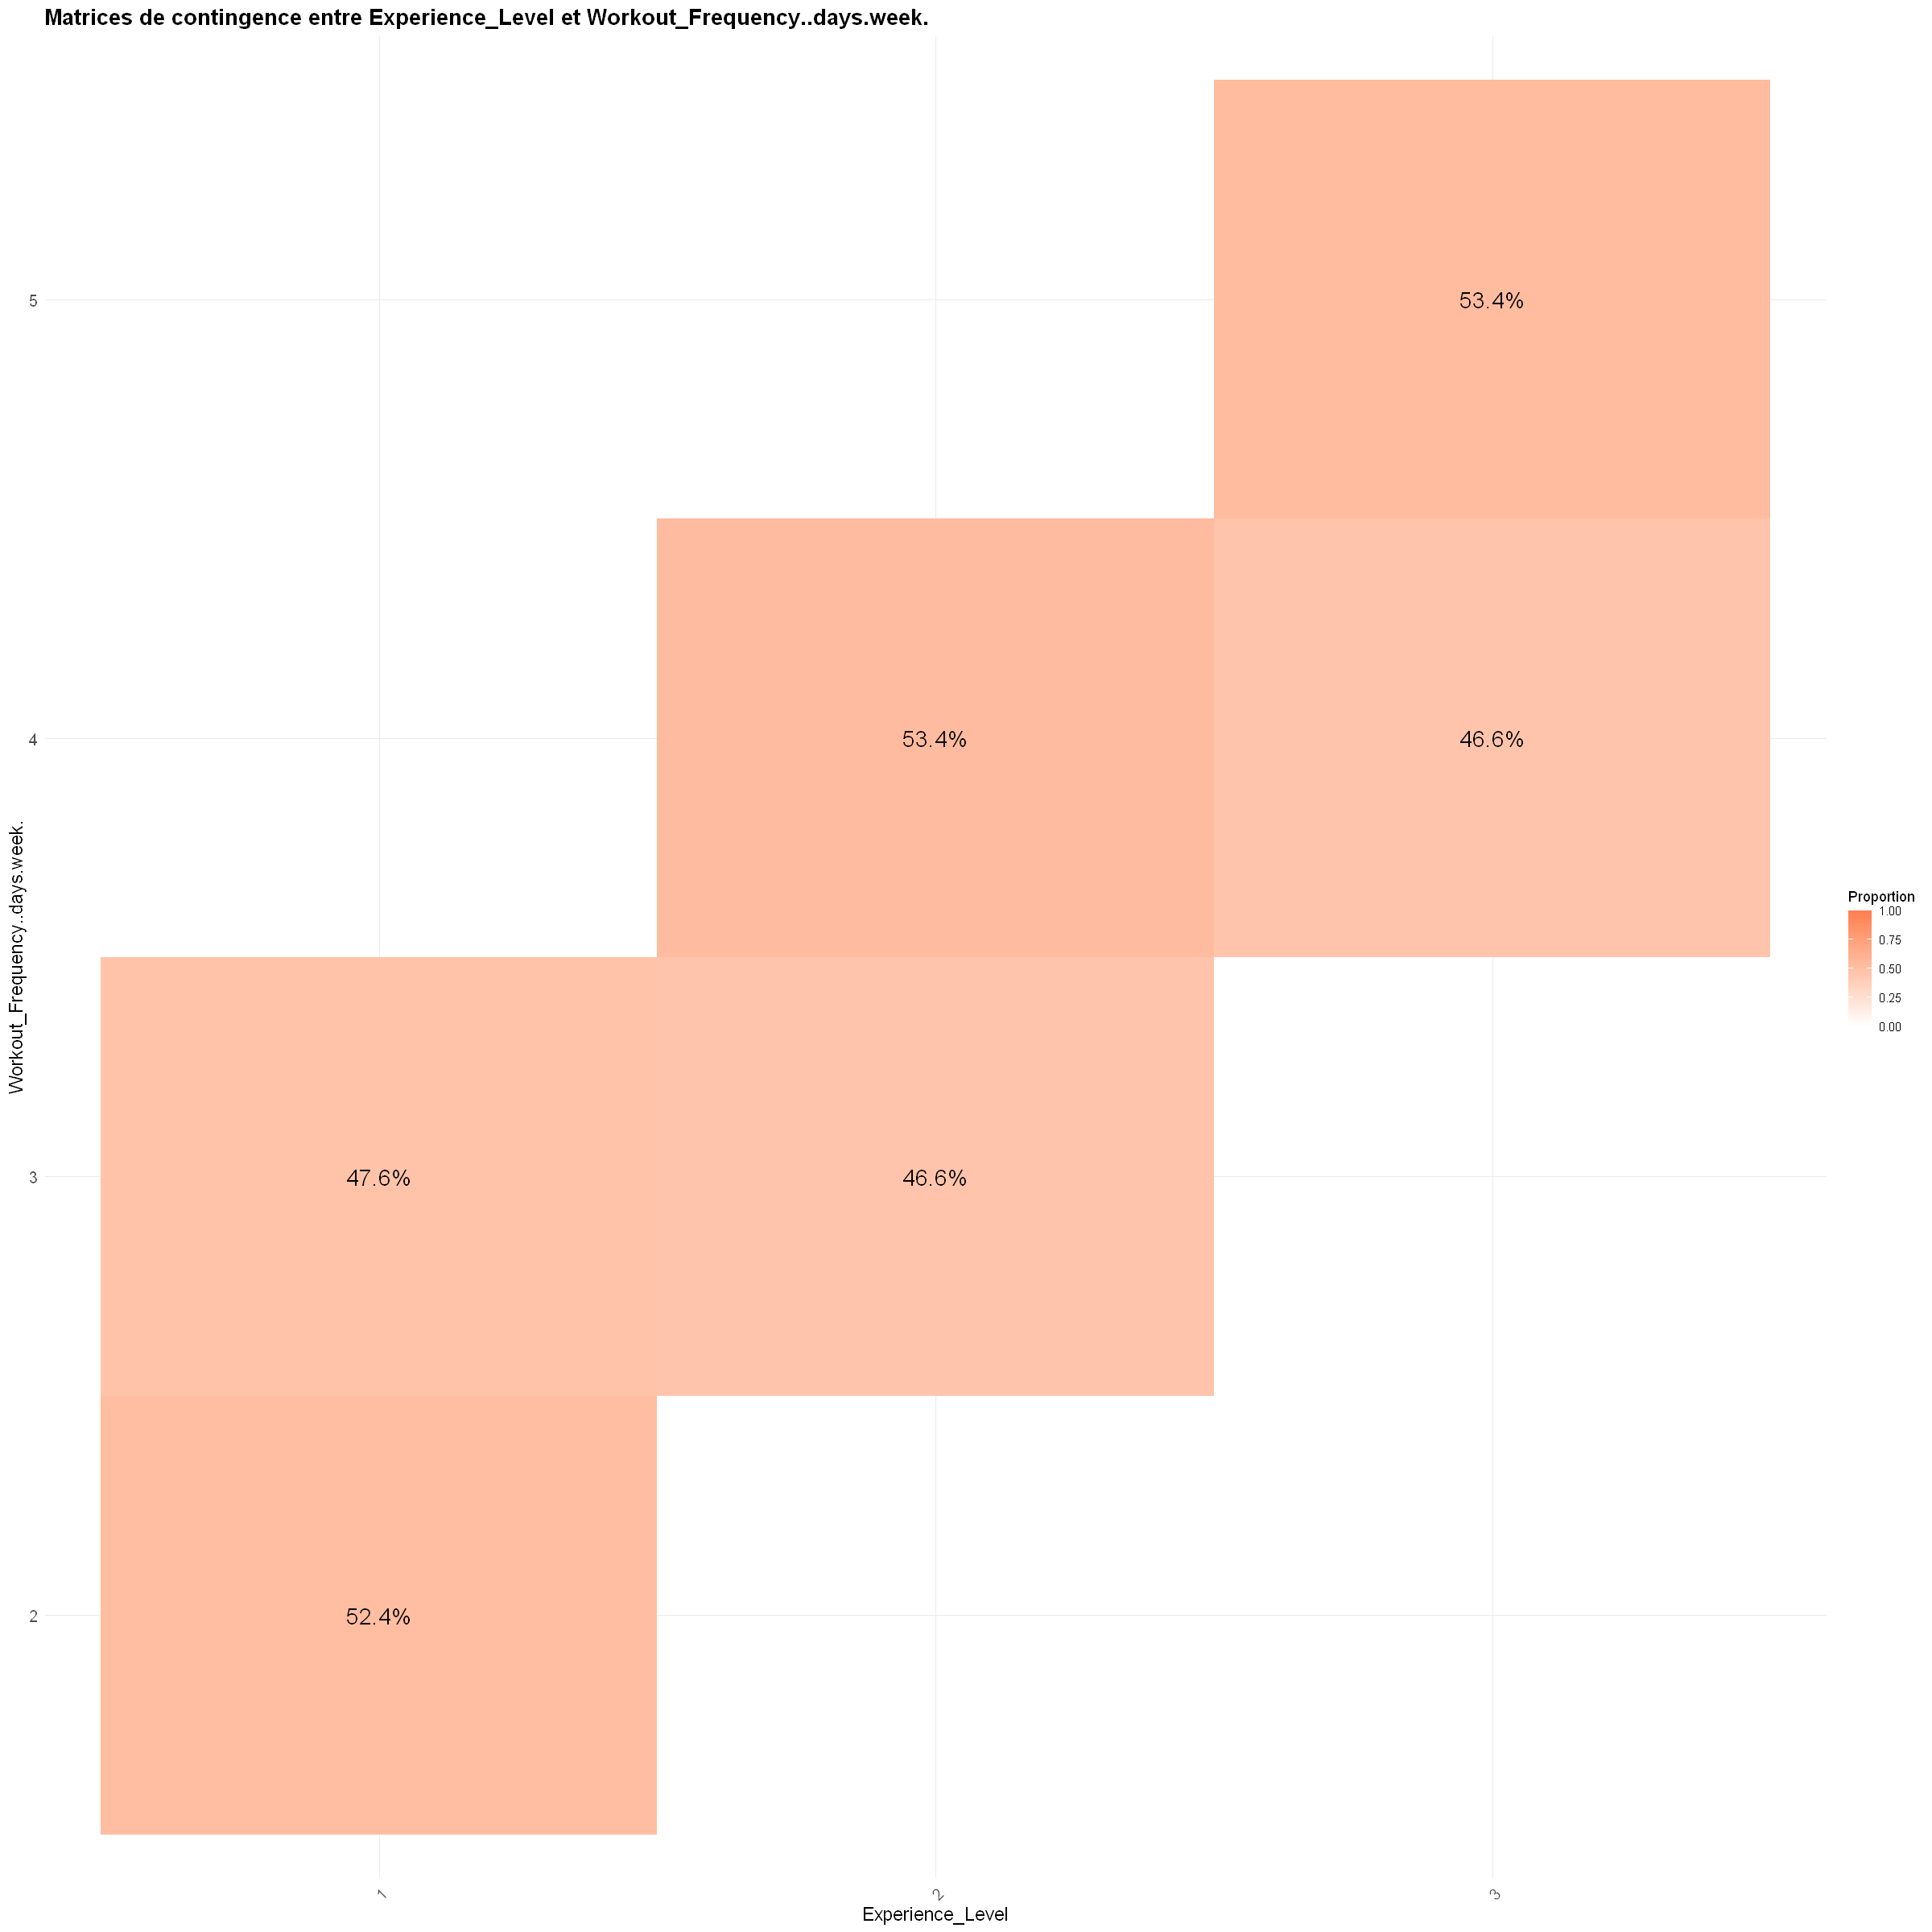

In [132]:
quali_data <- data[,quali_columns]
quali_vars_bis <- c("Gender", "Workout_Type", "Workout_Frequency..days.week.")

for (var in quali_vars_bis) {
  p <- quali_data %>%
    group_by(Experience_Level, !!sym(var)) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(Experience_Level) %>%
    mutate(prop = count / sum(count)) %>%
    ungroup() %>%
    ggplot(aes(x = Experience_Level, y = !!sym(var), fill = prop)) +
    geom_tile() +
    geom_text(aes(label = scales::percent(prop, accuracy = 0.1)), size = 6) + 
    scale_fill_gradient(low = "white", high = "coral", limits = c(0, 1), oob = scales::squish) +
    labs(title = paste("Matrices de contingence entre Experience_Level et", var),
         x = "Experience_Level", y = var, fill = "Proportion") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 16, face = "bold"),
      axis.title.x = element_text(size = 14),
      axis.title.y = element_text(size = 14),
      axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
      axis.text.y = element_text(size = 12)
    )
  
  print(p)
}


**Analyse** :
- Pour les variables **Gender** et **Workout_Type**, il ne semble pas avoir d'influence particulière de la variable Experience_Level. Il semblerait même que ces variables soient indépedantes.
- Pour la variable **Workout_Frequency**, la différence de distribution est très claire. Chaque niveau d'entraînement a 2 modalités possibles (sur 4). Plus un individu est expérimenté, plus il va s'entraîner régulièrement. En choisissant un individu soit expert soit débutant, on peut dire avec une précision de 100% à quelle classe il appartient uniquement en regardant la variable Workout_Frequency. Cette variable sera sans doute très utilisée par les algorithmes de classification

## 1.2.2 Exploration des données qualitatives en fonction de **sCalories_Burned**

On complète l'analyse sur la variable **sCalories_Burned** en analysant ses liens avec les variables qualitatives. La partie quantitative à été faite avec le reste des variables plus tôt dans le notebook

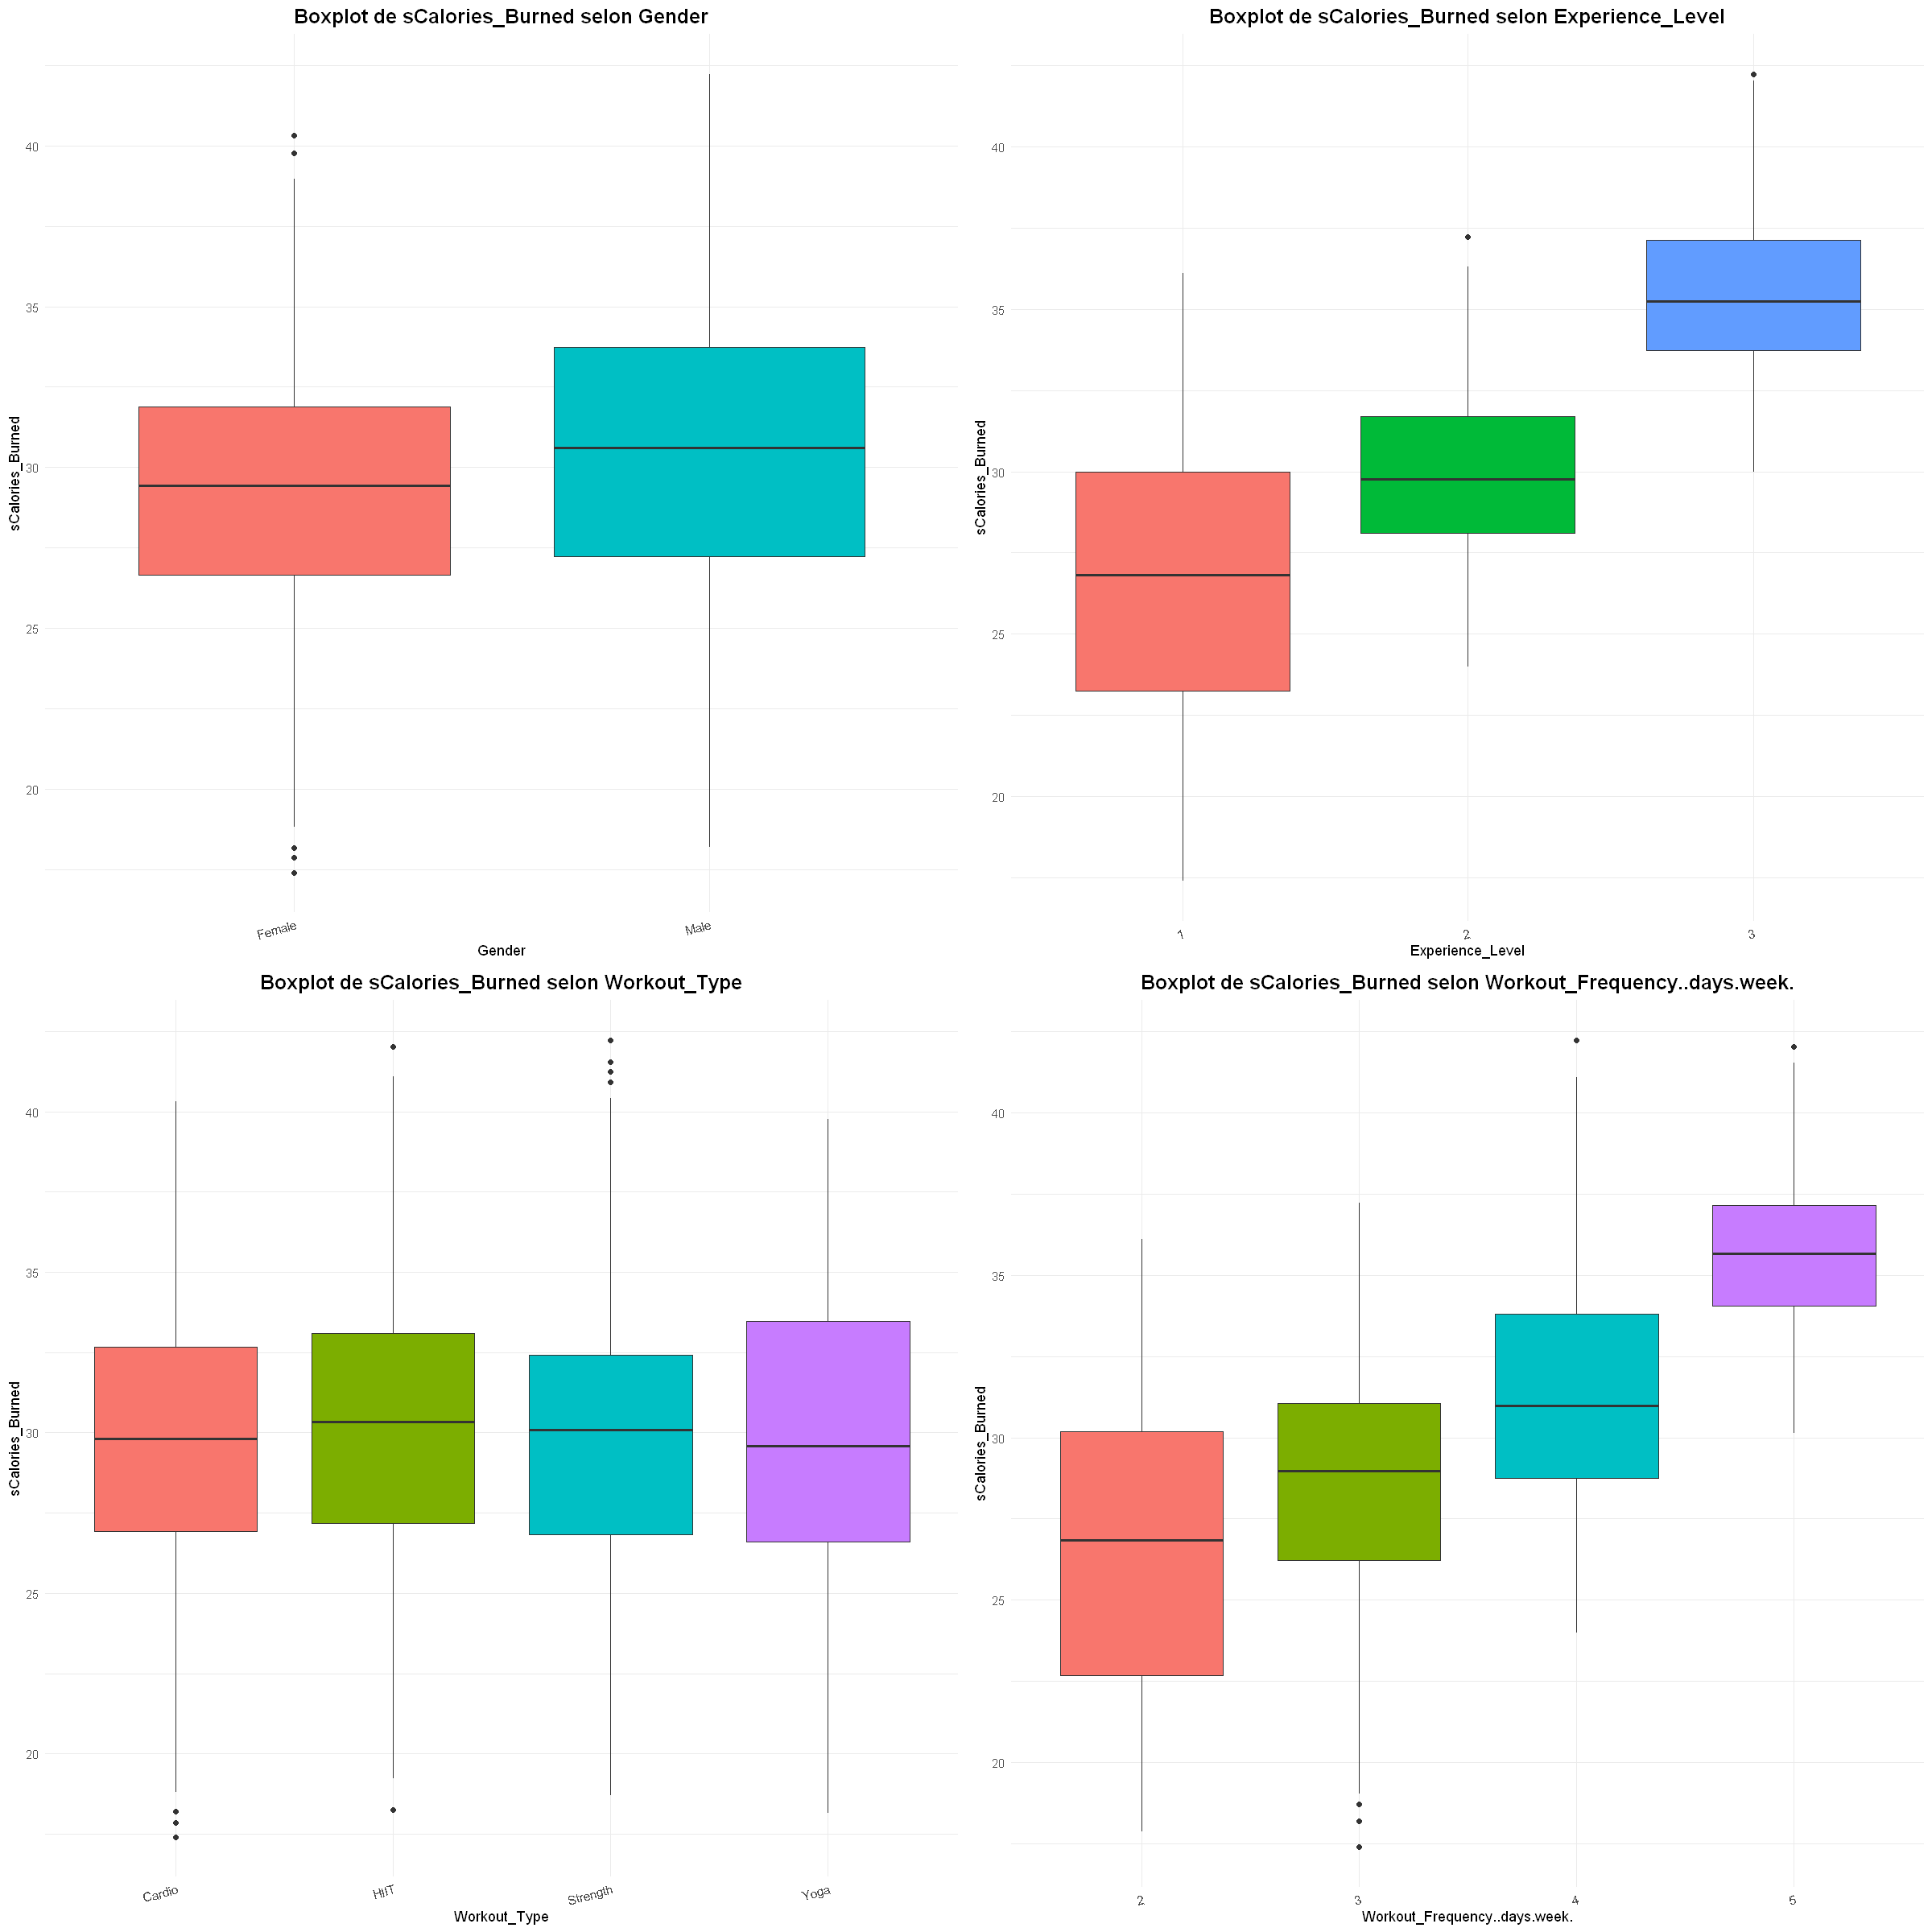

In [133]:
# Affichage des boxplots de sCalories_Burned selon les variables qualitatives:
qualitatives <- c("Gender", "Experience_Level","Workout_Type", "Workout_Frequency..days.week.")

plots <- list()

for (var in qualitatives) {
  if (!var %in% names(data_norm)) next
  if (length(unique(data_norm[[var]])) < 2) next

  data_long <- data_norm %>%
    dplyr::select(all_of(var), sCalories_Burned) %>%
    dplyr::rename(QualiVar = !!var)

  p <- ggplot(data_long, aes(x = QualiVar, y = sCalories_Burned, fill = QualiVar)) +
    geom_boxplot() +
    theme_minimal() +
    labs(title = paste("Boxplot de sCalories_Burned selon", var), x = var, y = "sCalories_Burned") +
    theme(plot.title = element_text(size = 15, face = "bold", hjust = 0.5),
          axis.text.x = element_text(angle = 15, hjust = 1),
          legend.position = "none")

  plots[[var]] <- p
}

# Affiche-les tous ensemble
do.call(grid.arrange, c(plots, ncol = 2))


On remarque un net lien entre la fréquence d'entrainement et les calories brulées.

De même, plus le niveau d'expérience augmente, plus la quantité de calories brulées augmente.

## 1.3 Analyse en Composantes Principales

In [134]:
# on crée une table avec les variables quantitatives pour l'ACP
data_acp <- data[,quanti_columns]

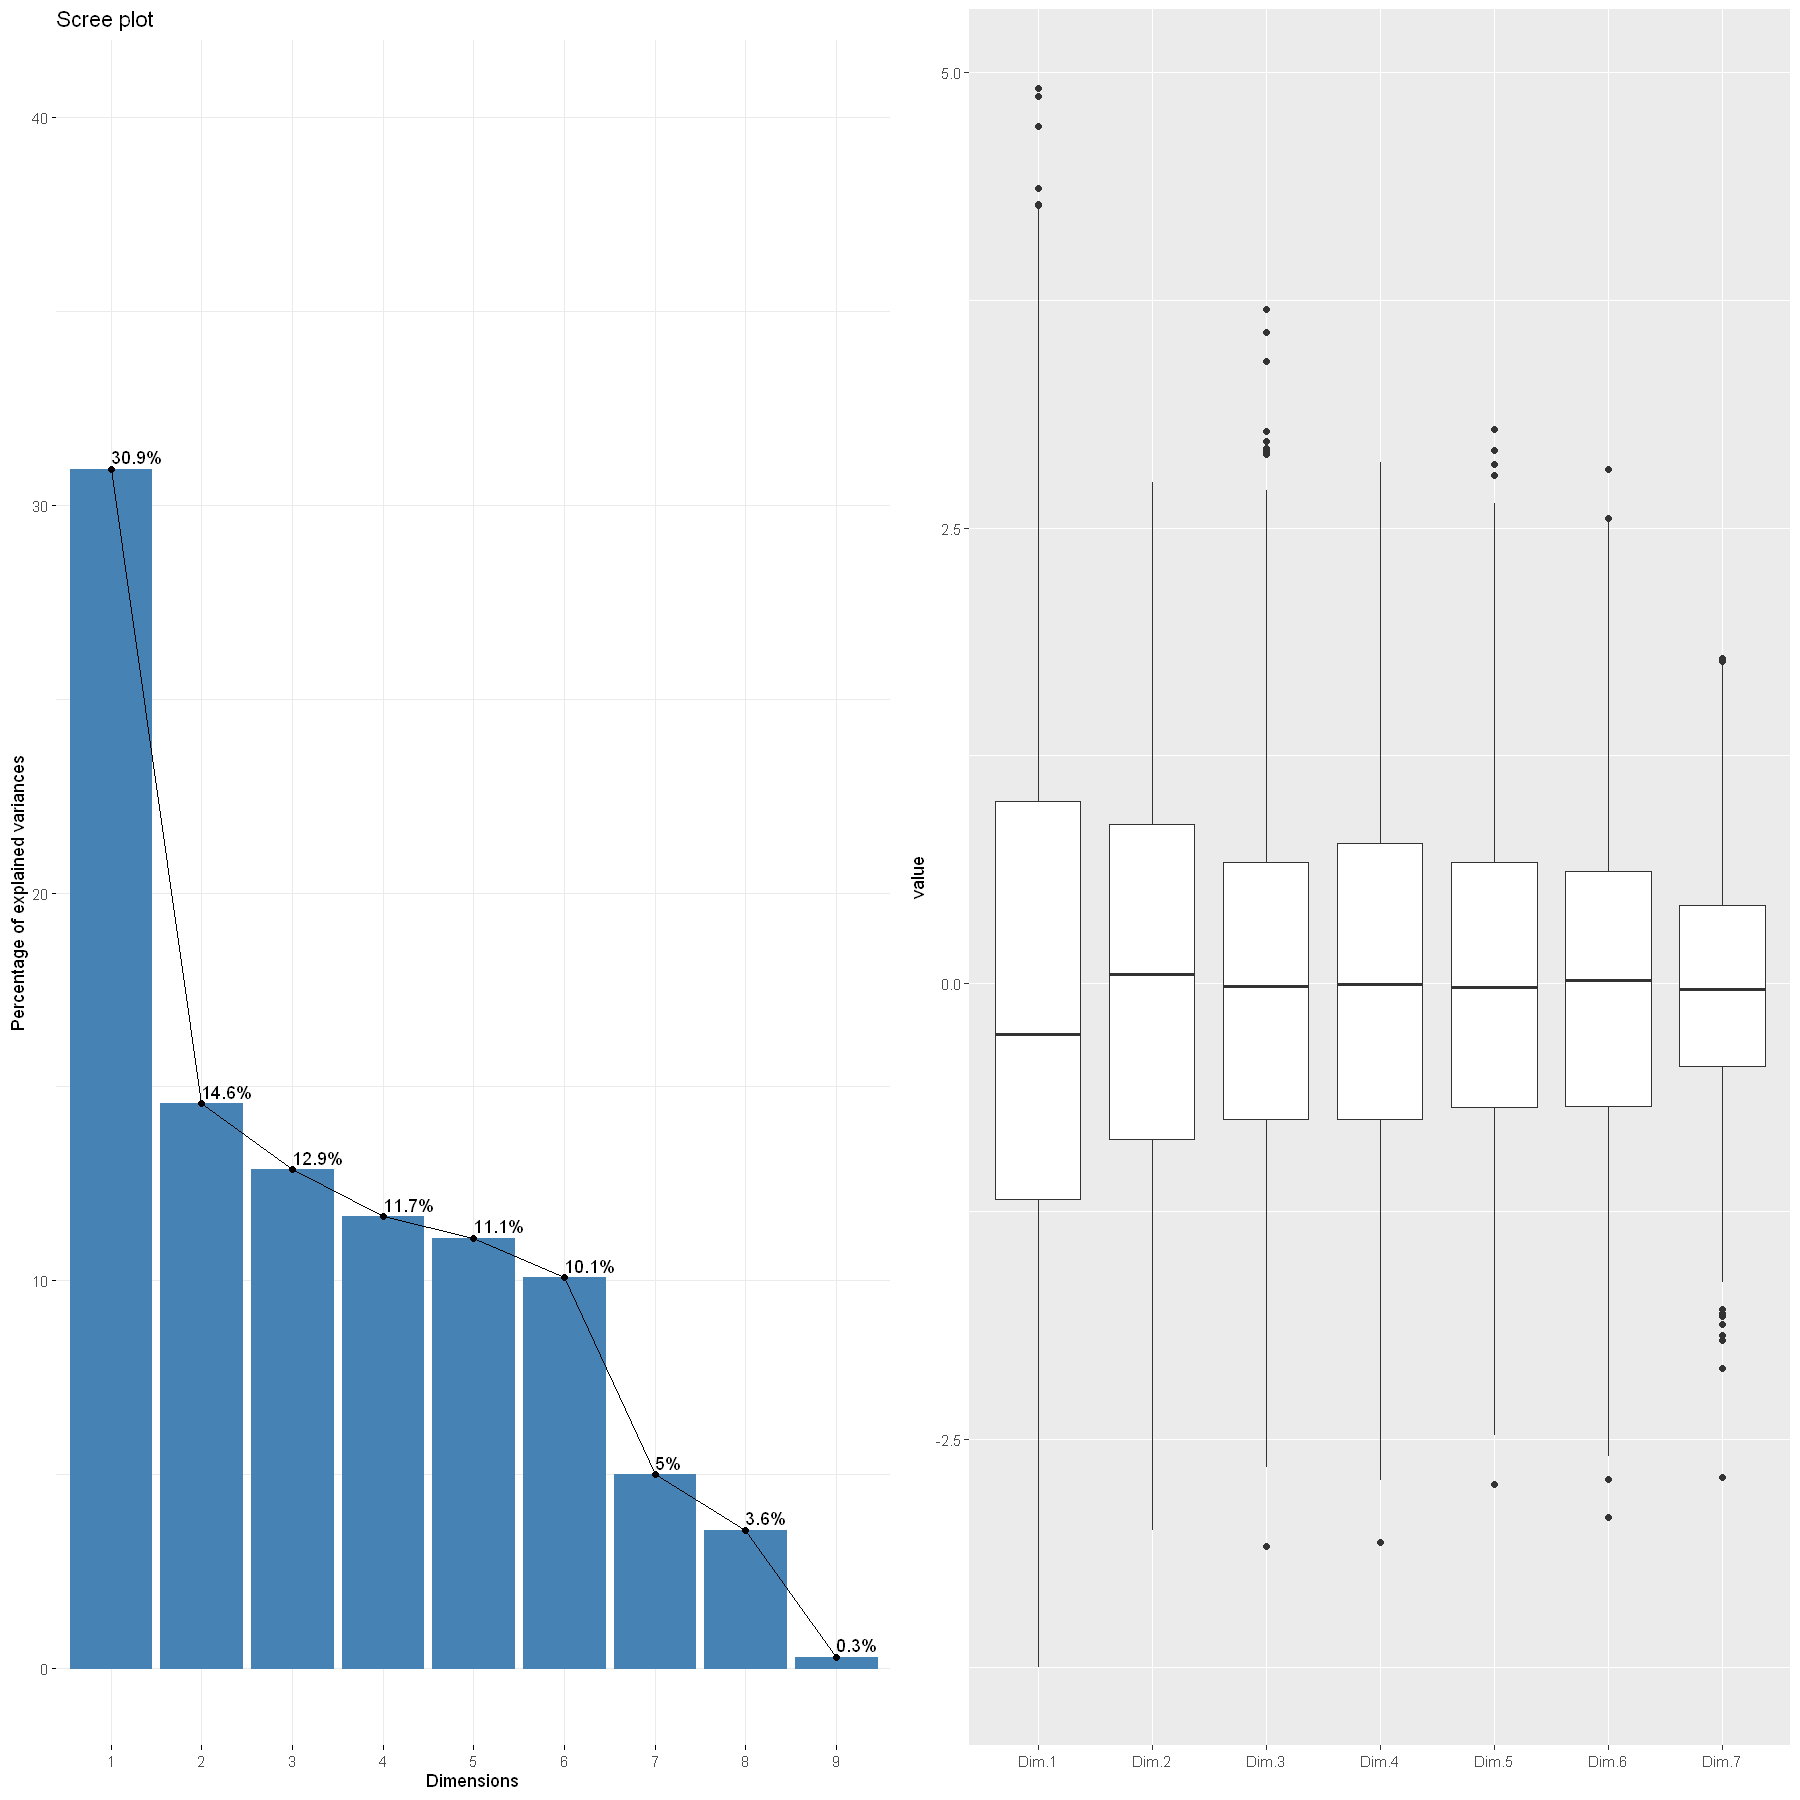

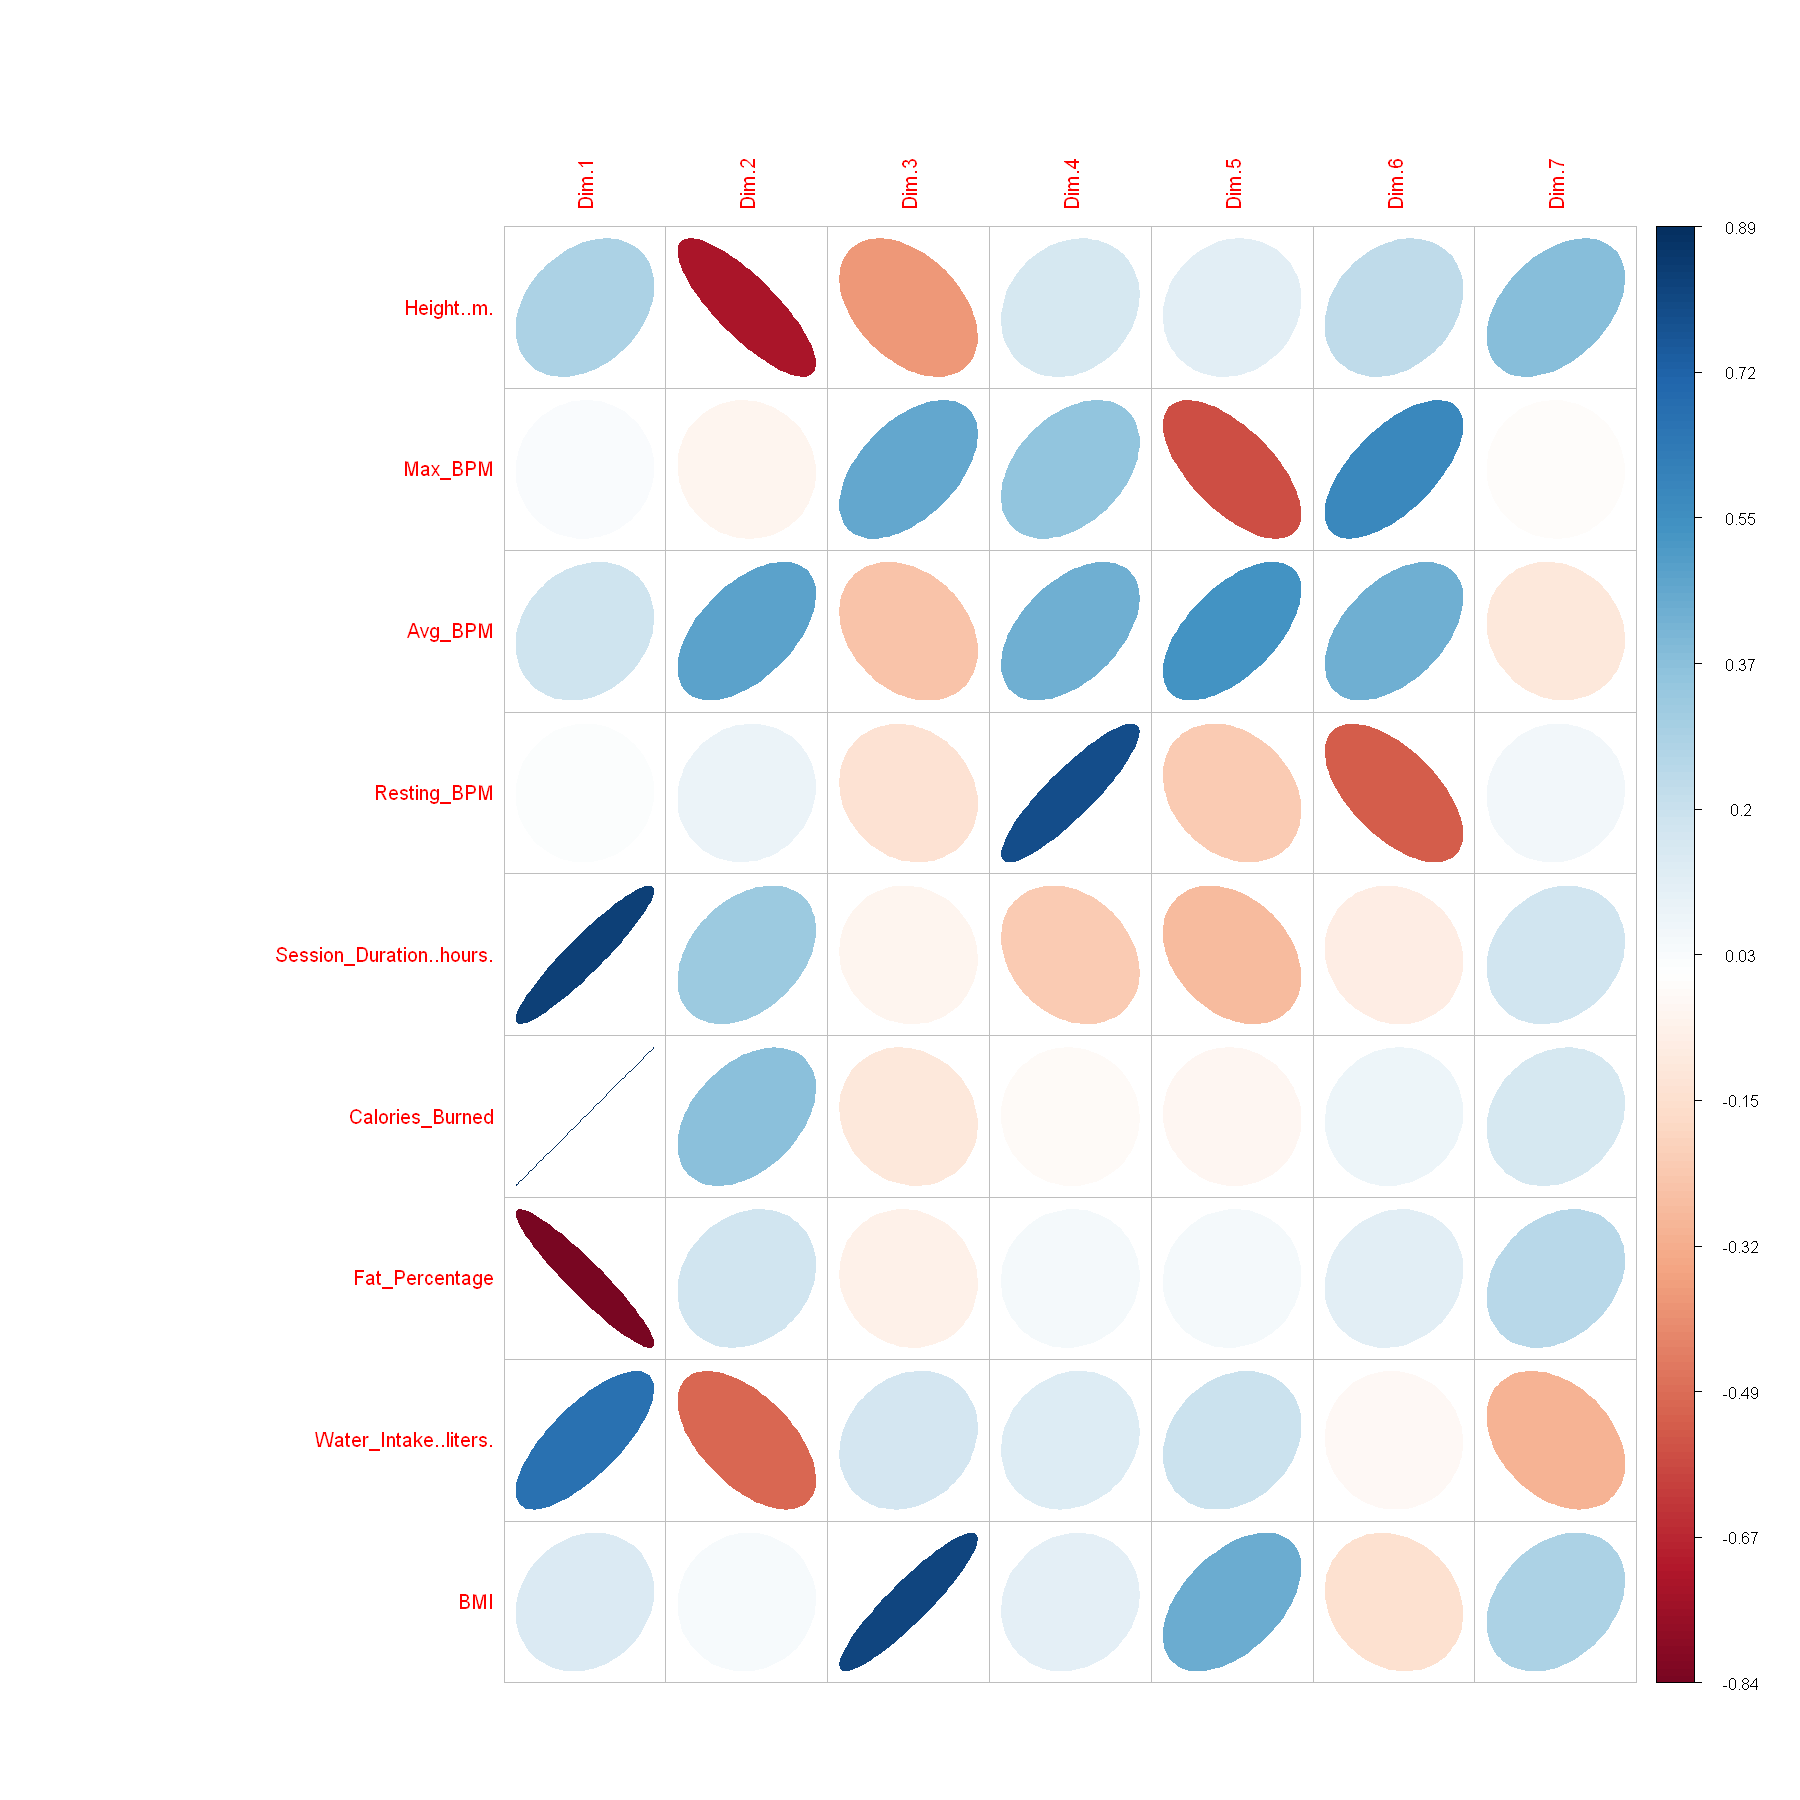

In [135]:
# ACP réduite
acp <- PCA(data_acp, scale.unit = TRUE,
           graph = FALSE, quali.sup = 1, quanti.sup = 2, ncp = 7)

options(repr.plot.width = 15, repr.plot.height = 15)

g1<-fviz_eig(acp, addlabels = TRUE, ylim = c(0, 40))

g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)

library(corrplot)
corrplot(acp$var$cor, is.corr=FALSE,method="ellipse")

La variance cumulée de l'ACP affiche des résultats satisfaisant. Travailler dans les 3 premières dimensions de l'ACP nous permet d'avoir accès à 58,4% de la variance totale, ce qui est suffisant pour observer certains phénomènes (mais pas assez pour expliquer tout le jeu de données). 
- La **1ère dimension** est fortement corrélée positivement avec **Calories_Burned**, **Session_Duration** et **Water_Intake**, et négativement avec **Fat_Percentage**. Au vu de ses informations, il semblerait que cette dimension porte les individus effectuant des séances intenses.
- La **2ème dimension** est corrélée positivement avec **Avg_BPM**, **Session_Duration** et **Calories_Burned**, et négativement avec **Height** et **Water_Intake**. Cette dimension est plus compliquée à interpréter dans ce contexte.
- La **3ème dimension** est corrélée positivement avec **BMI** et **Max_BPM**, et négativement avec **Height** et **Avg_BPM**. Encore une fois, cette dimension est plus compliquée à interpréter dans ce contexte.

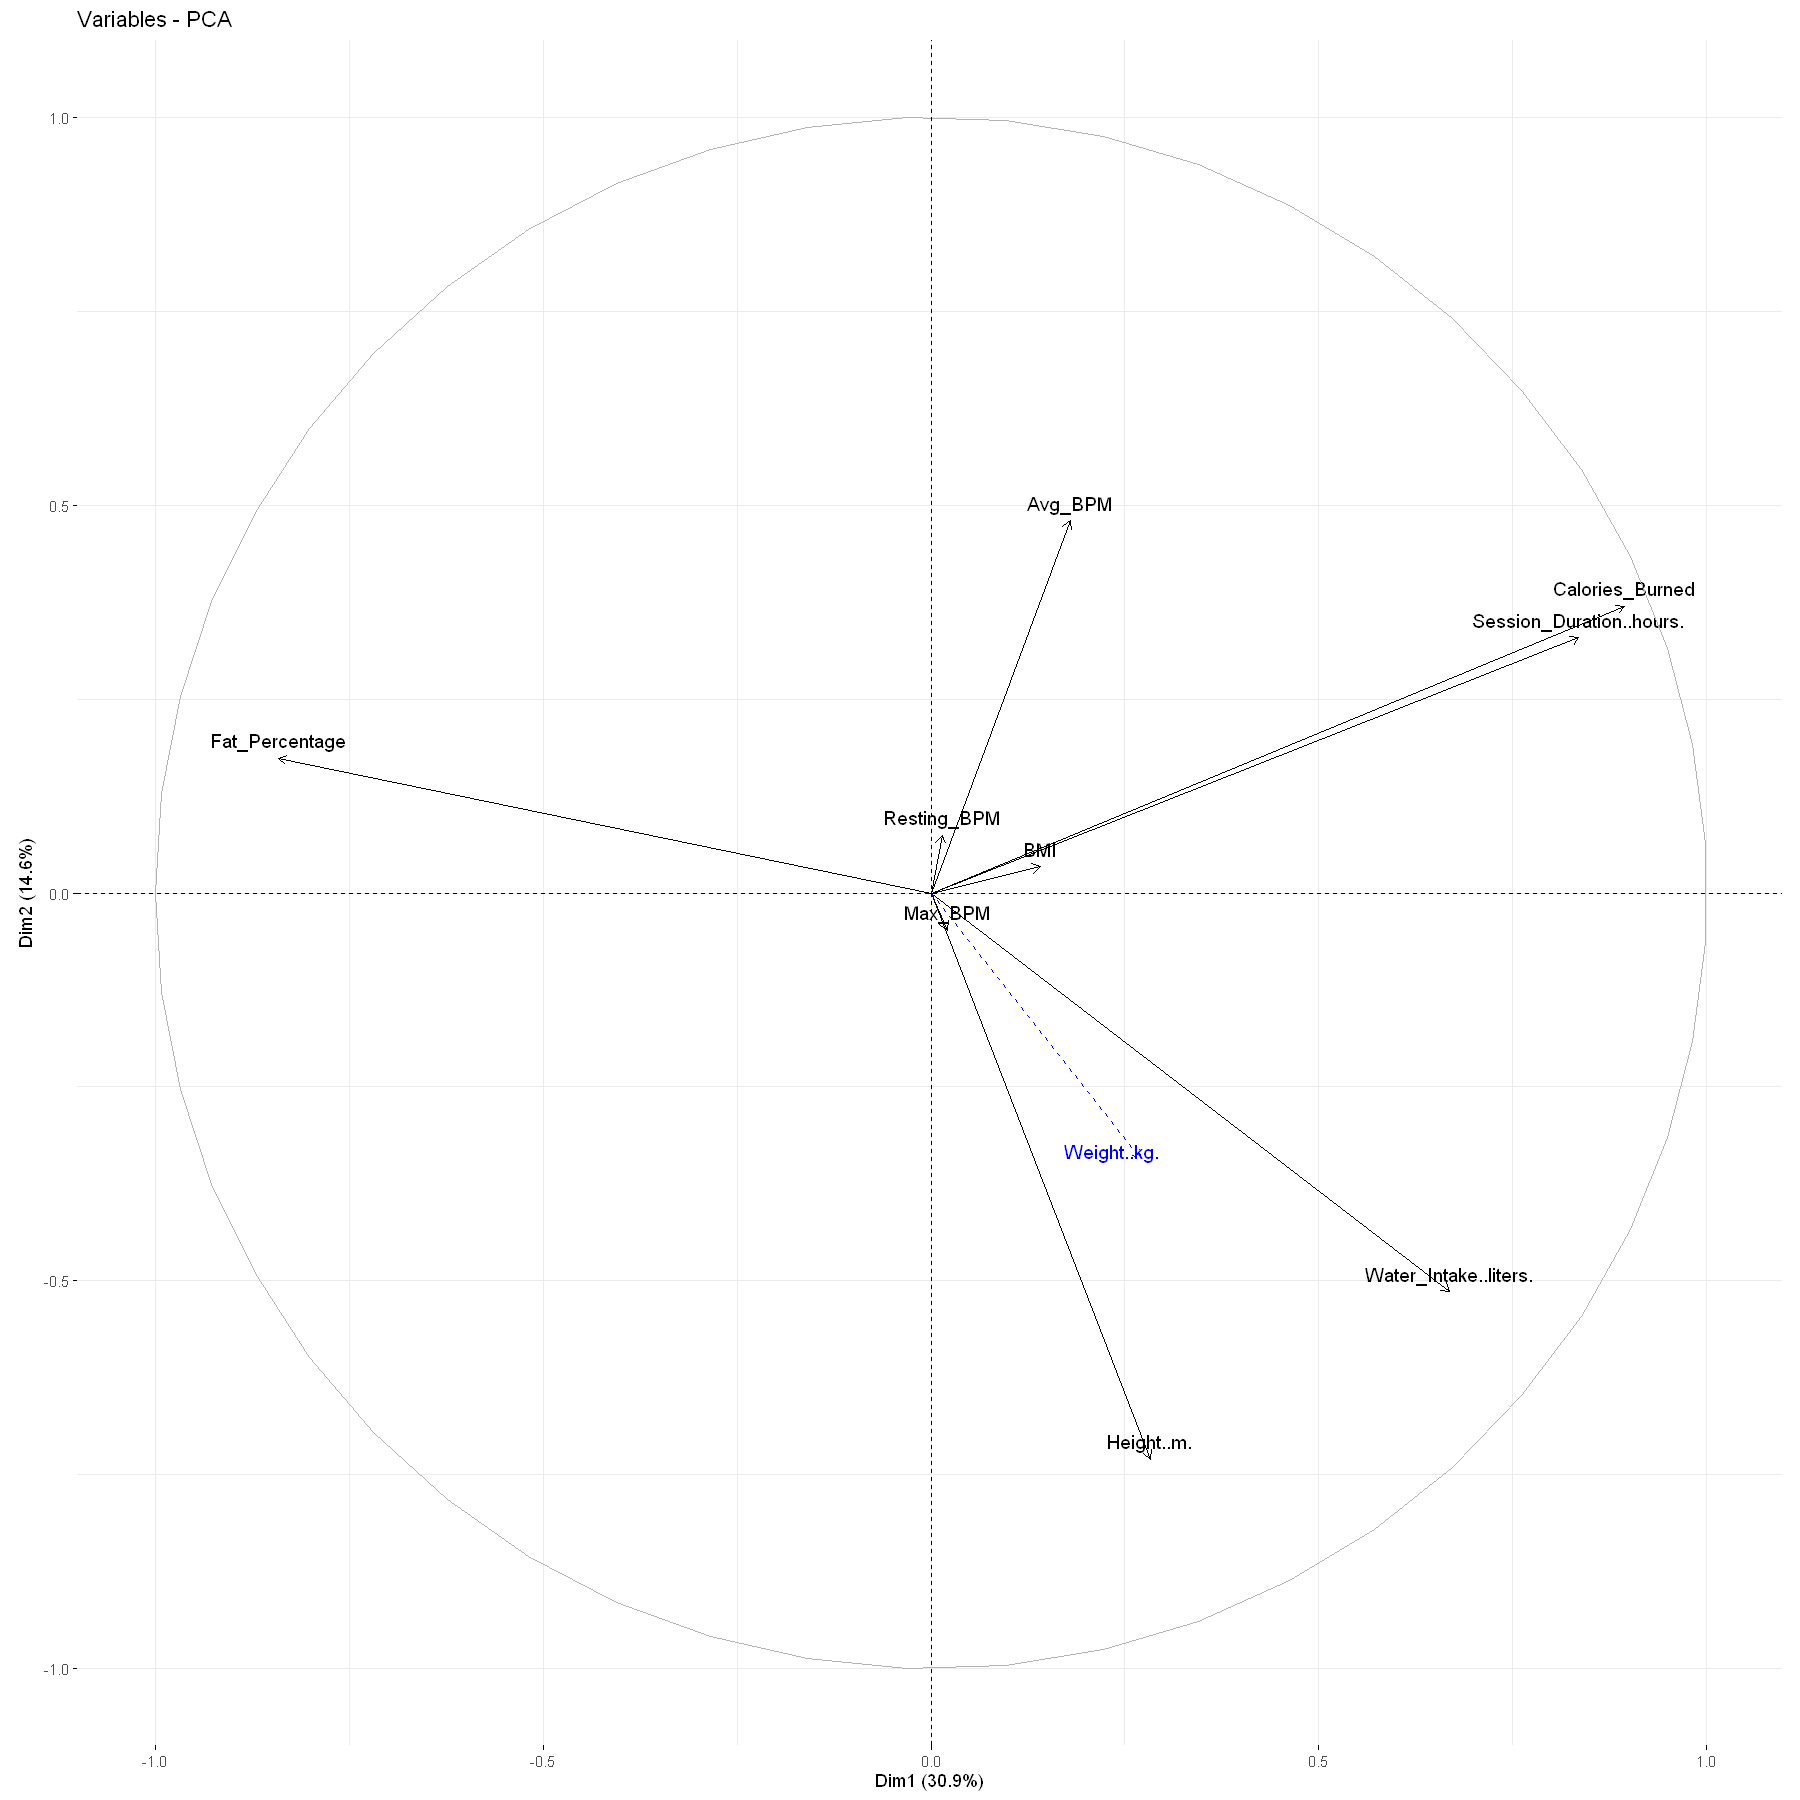

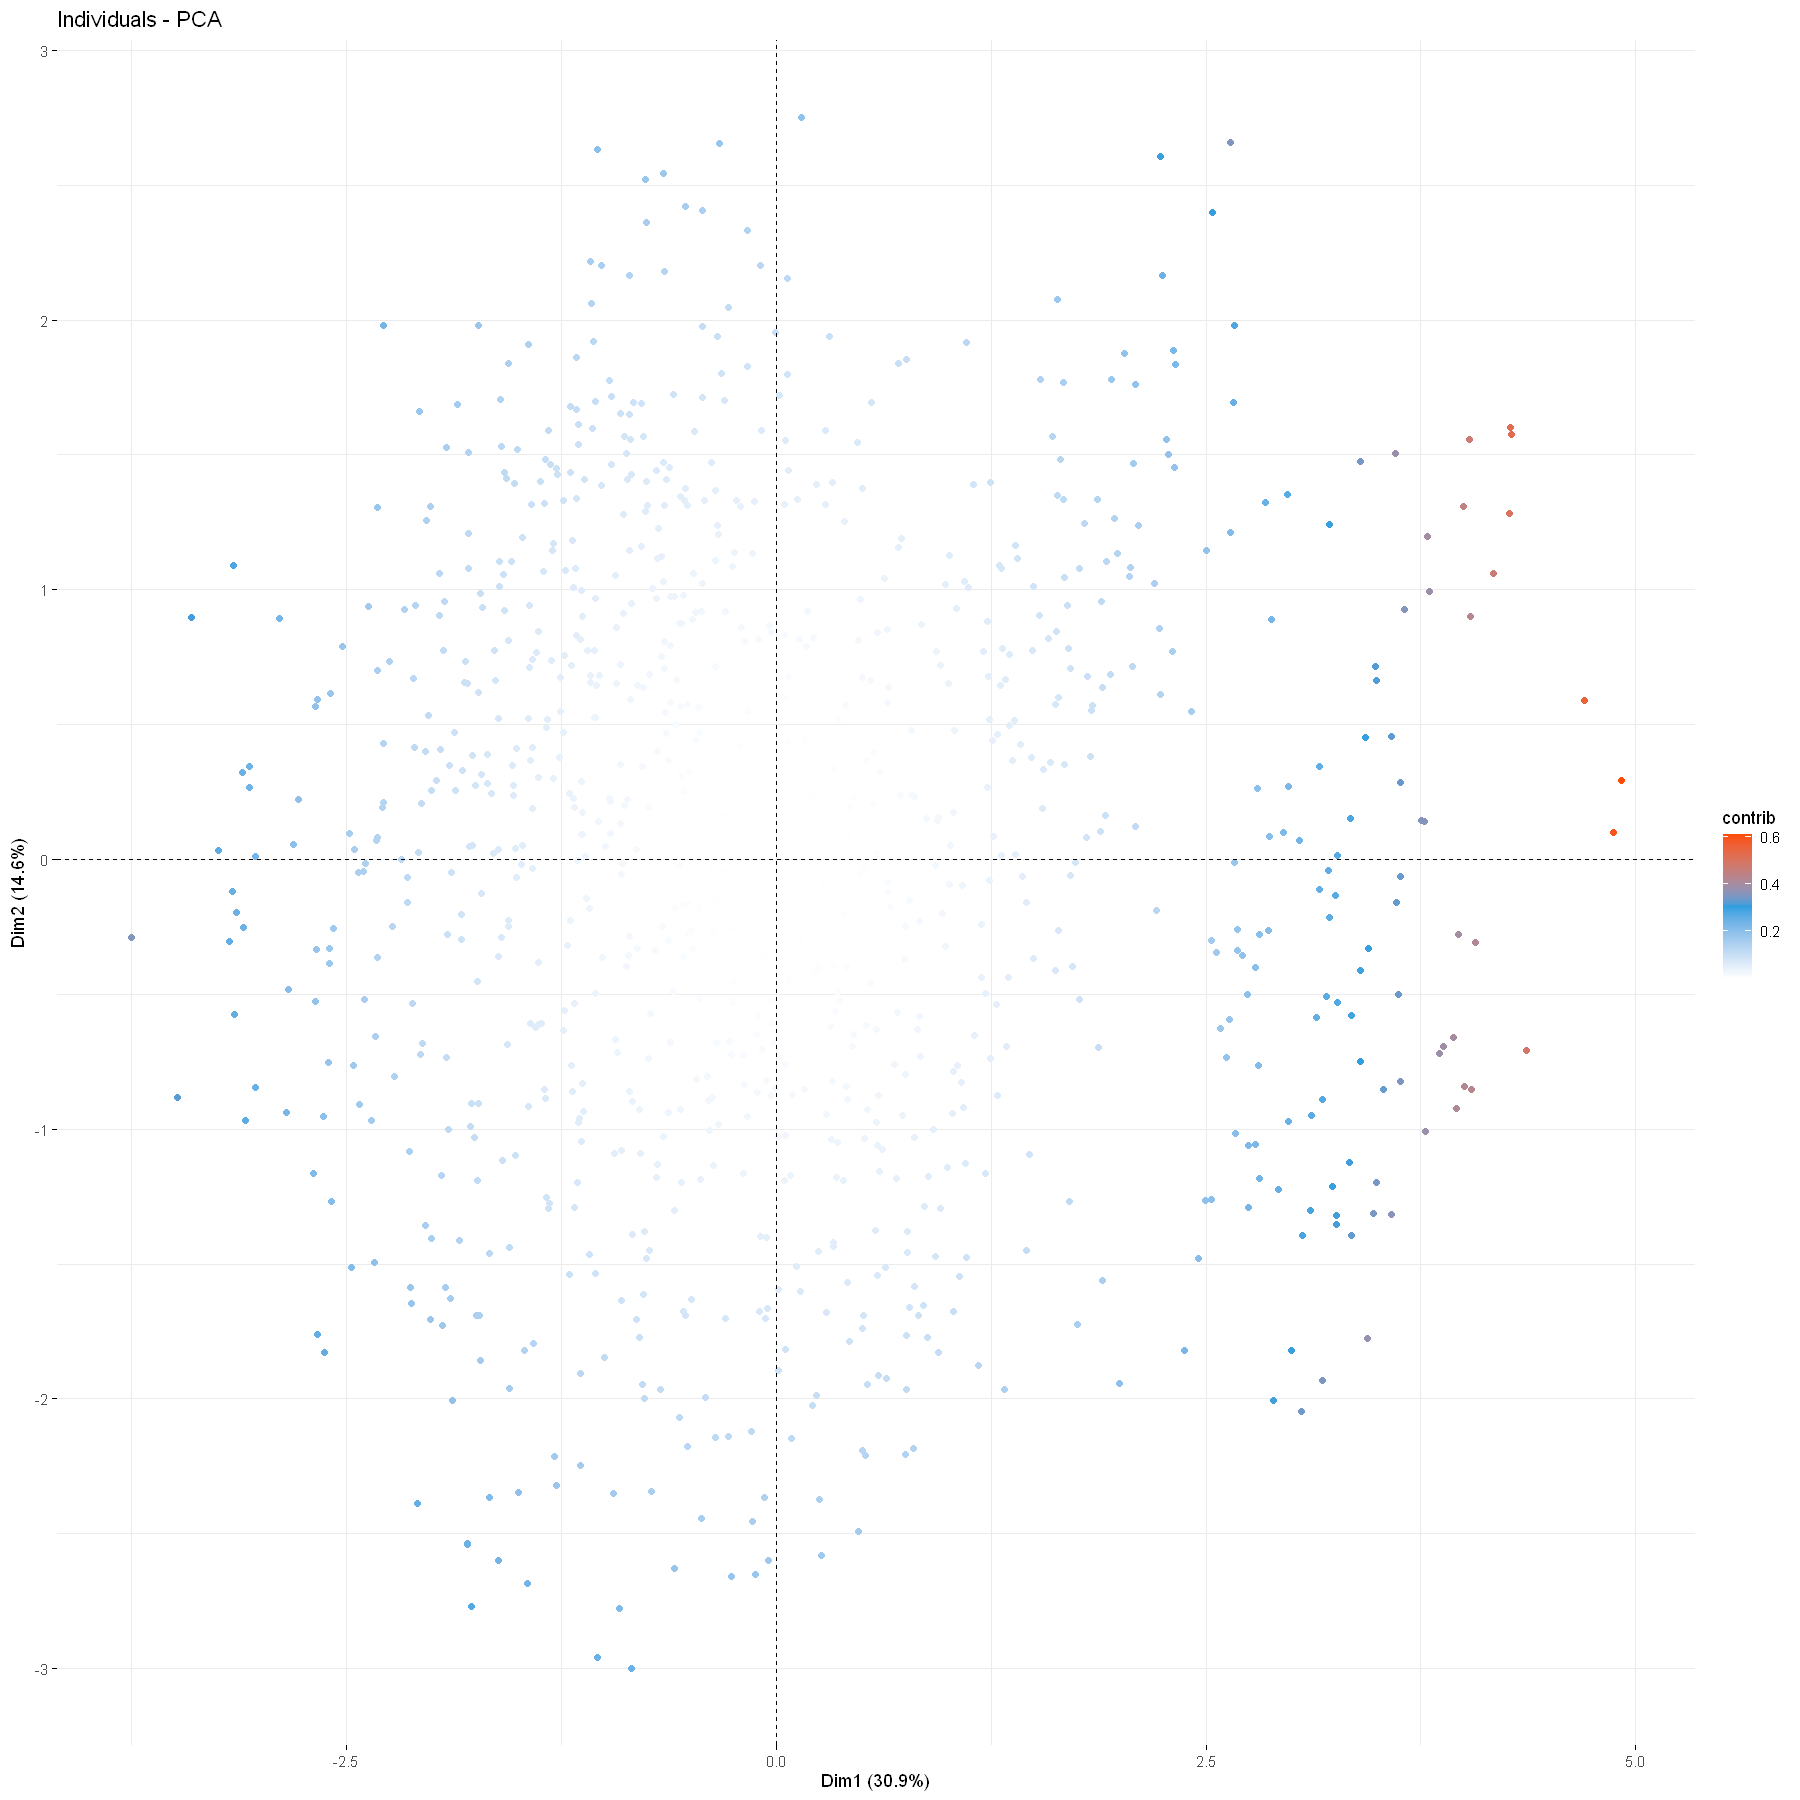

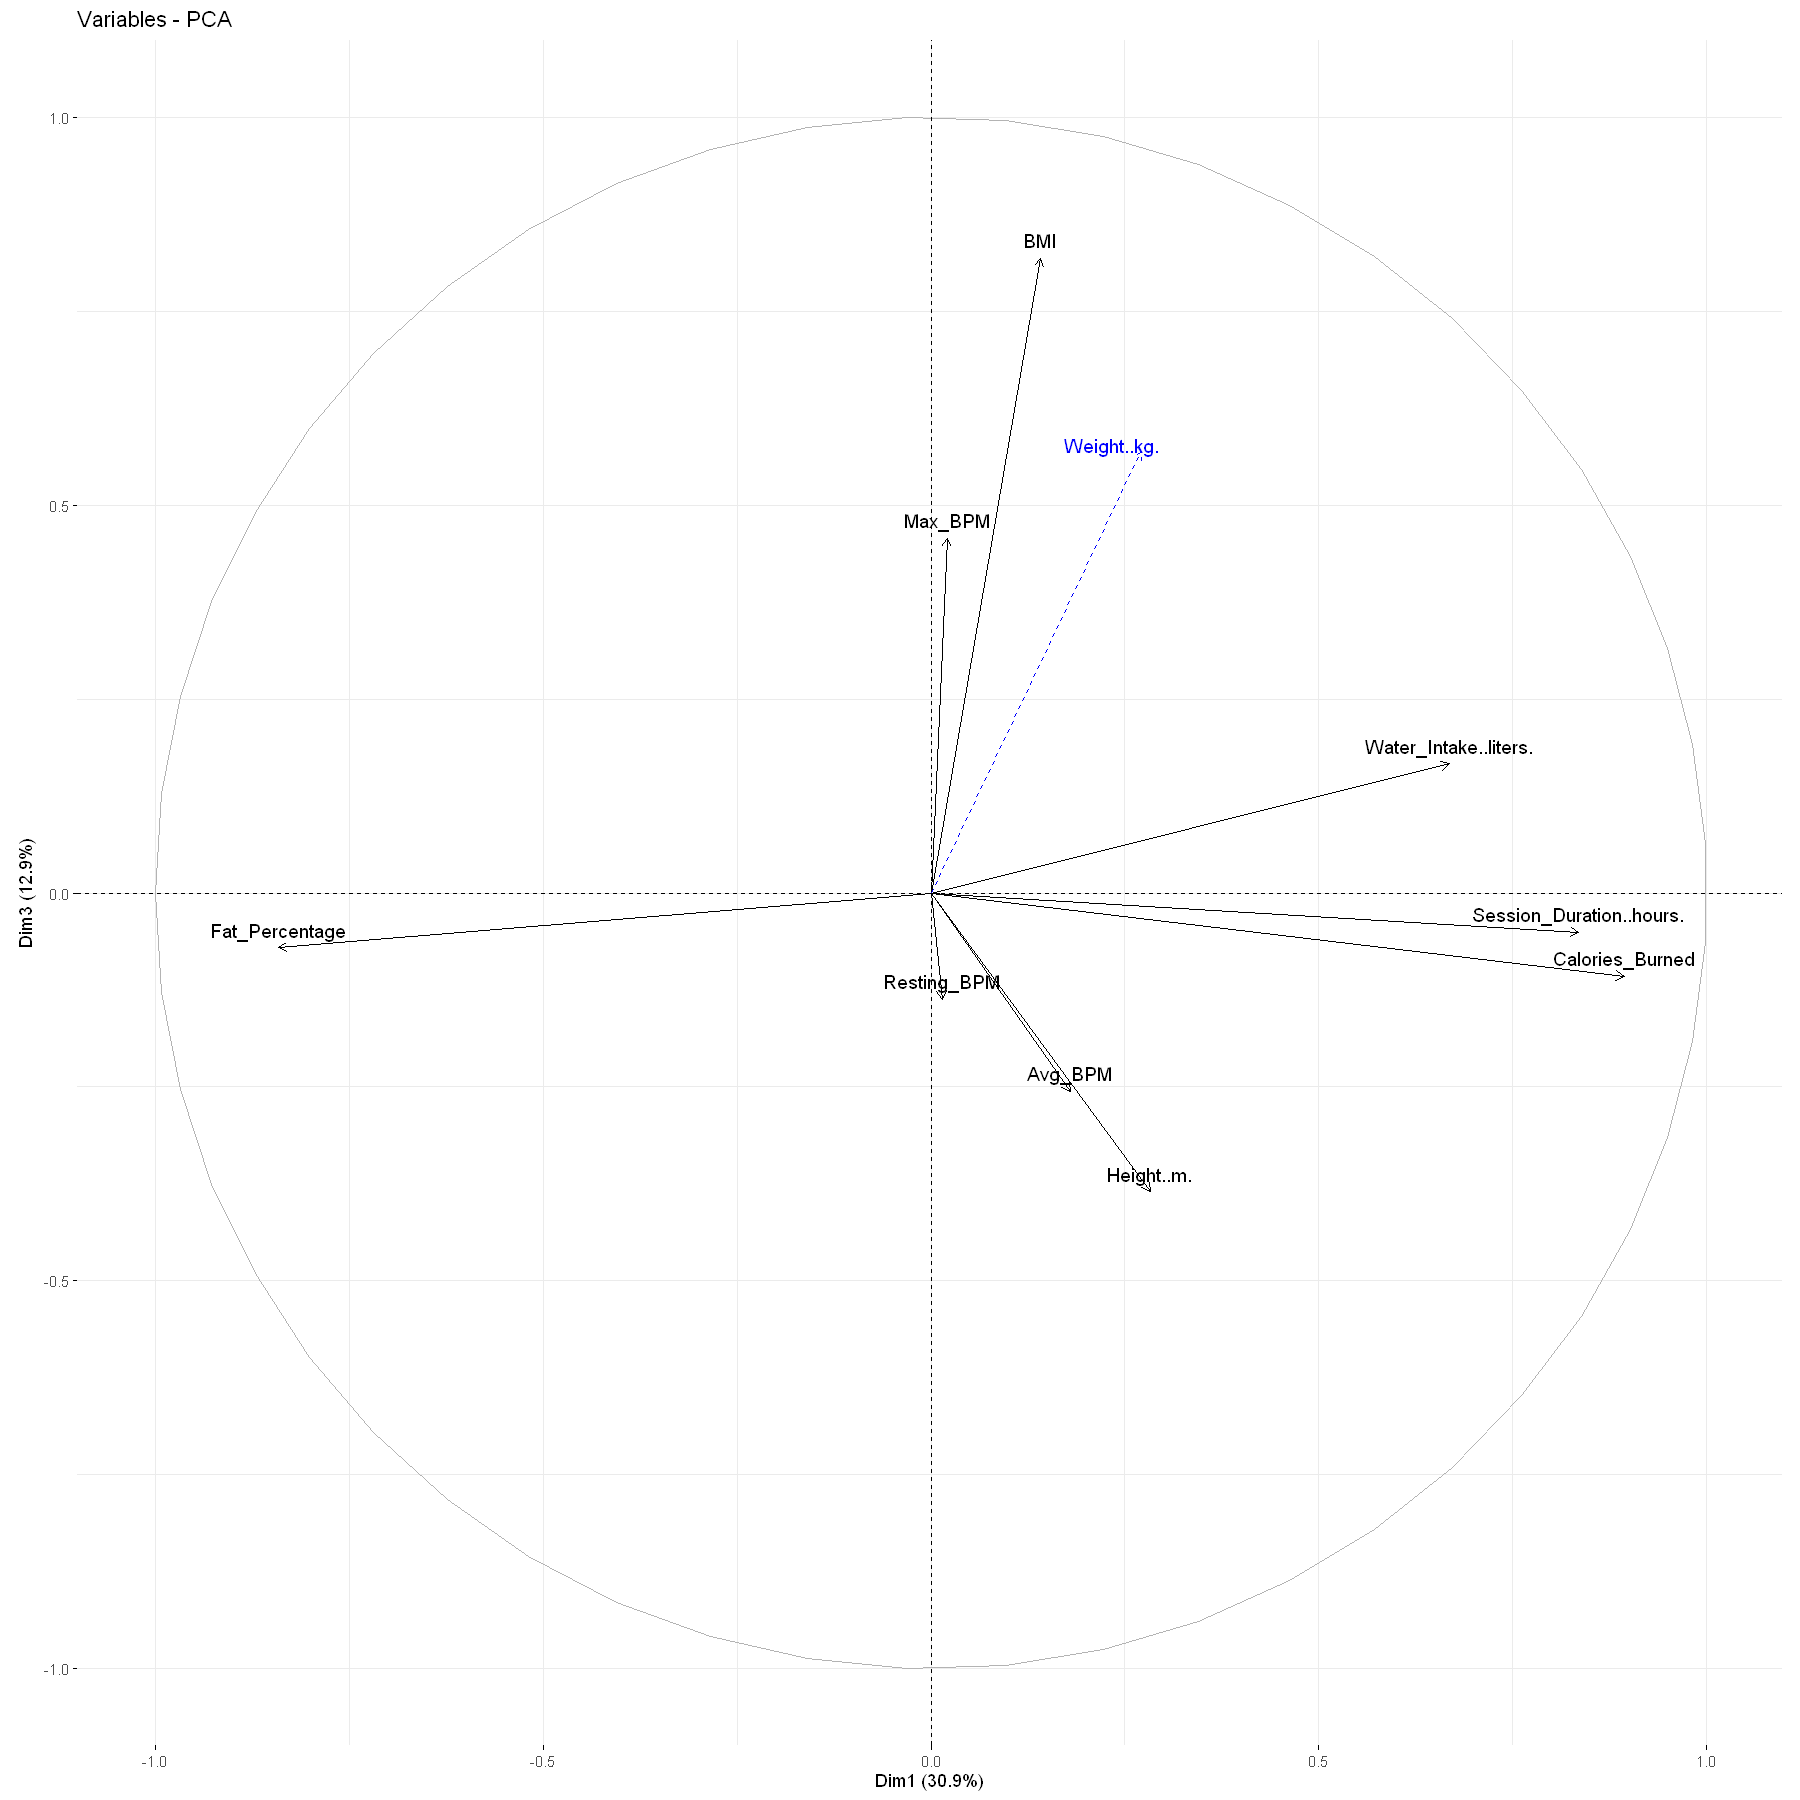

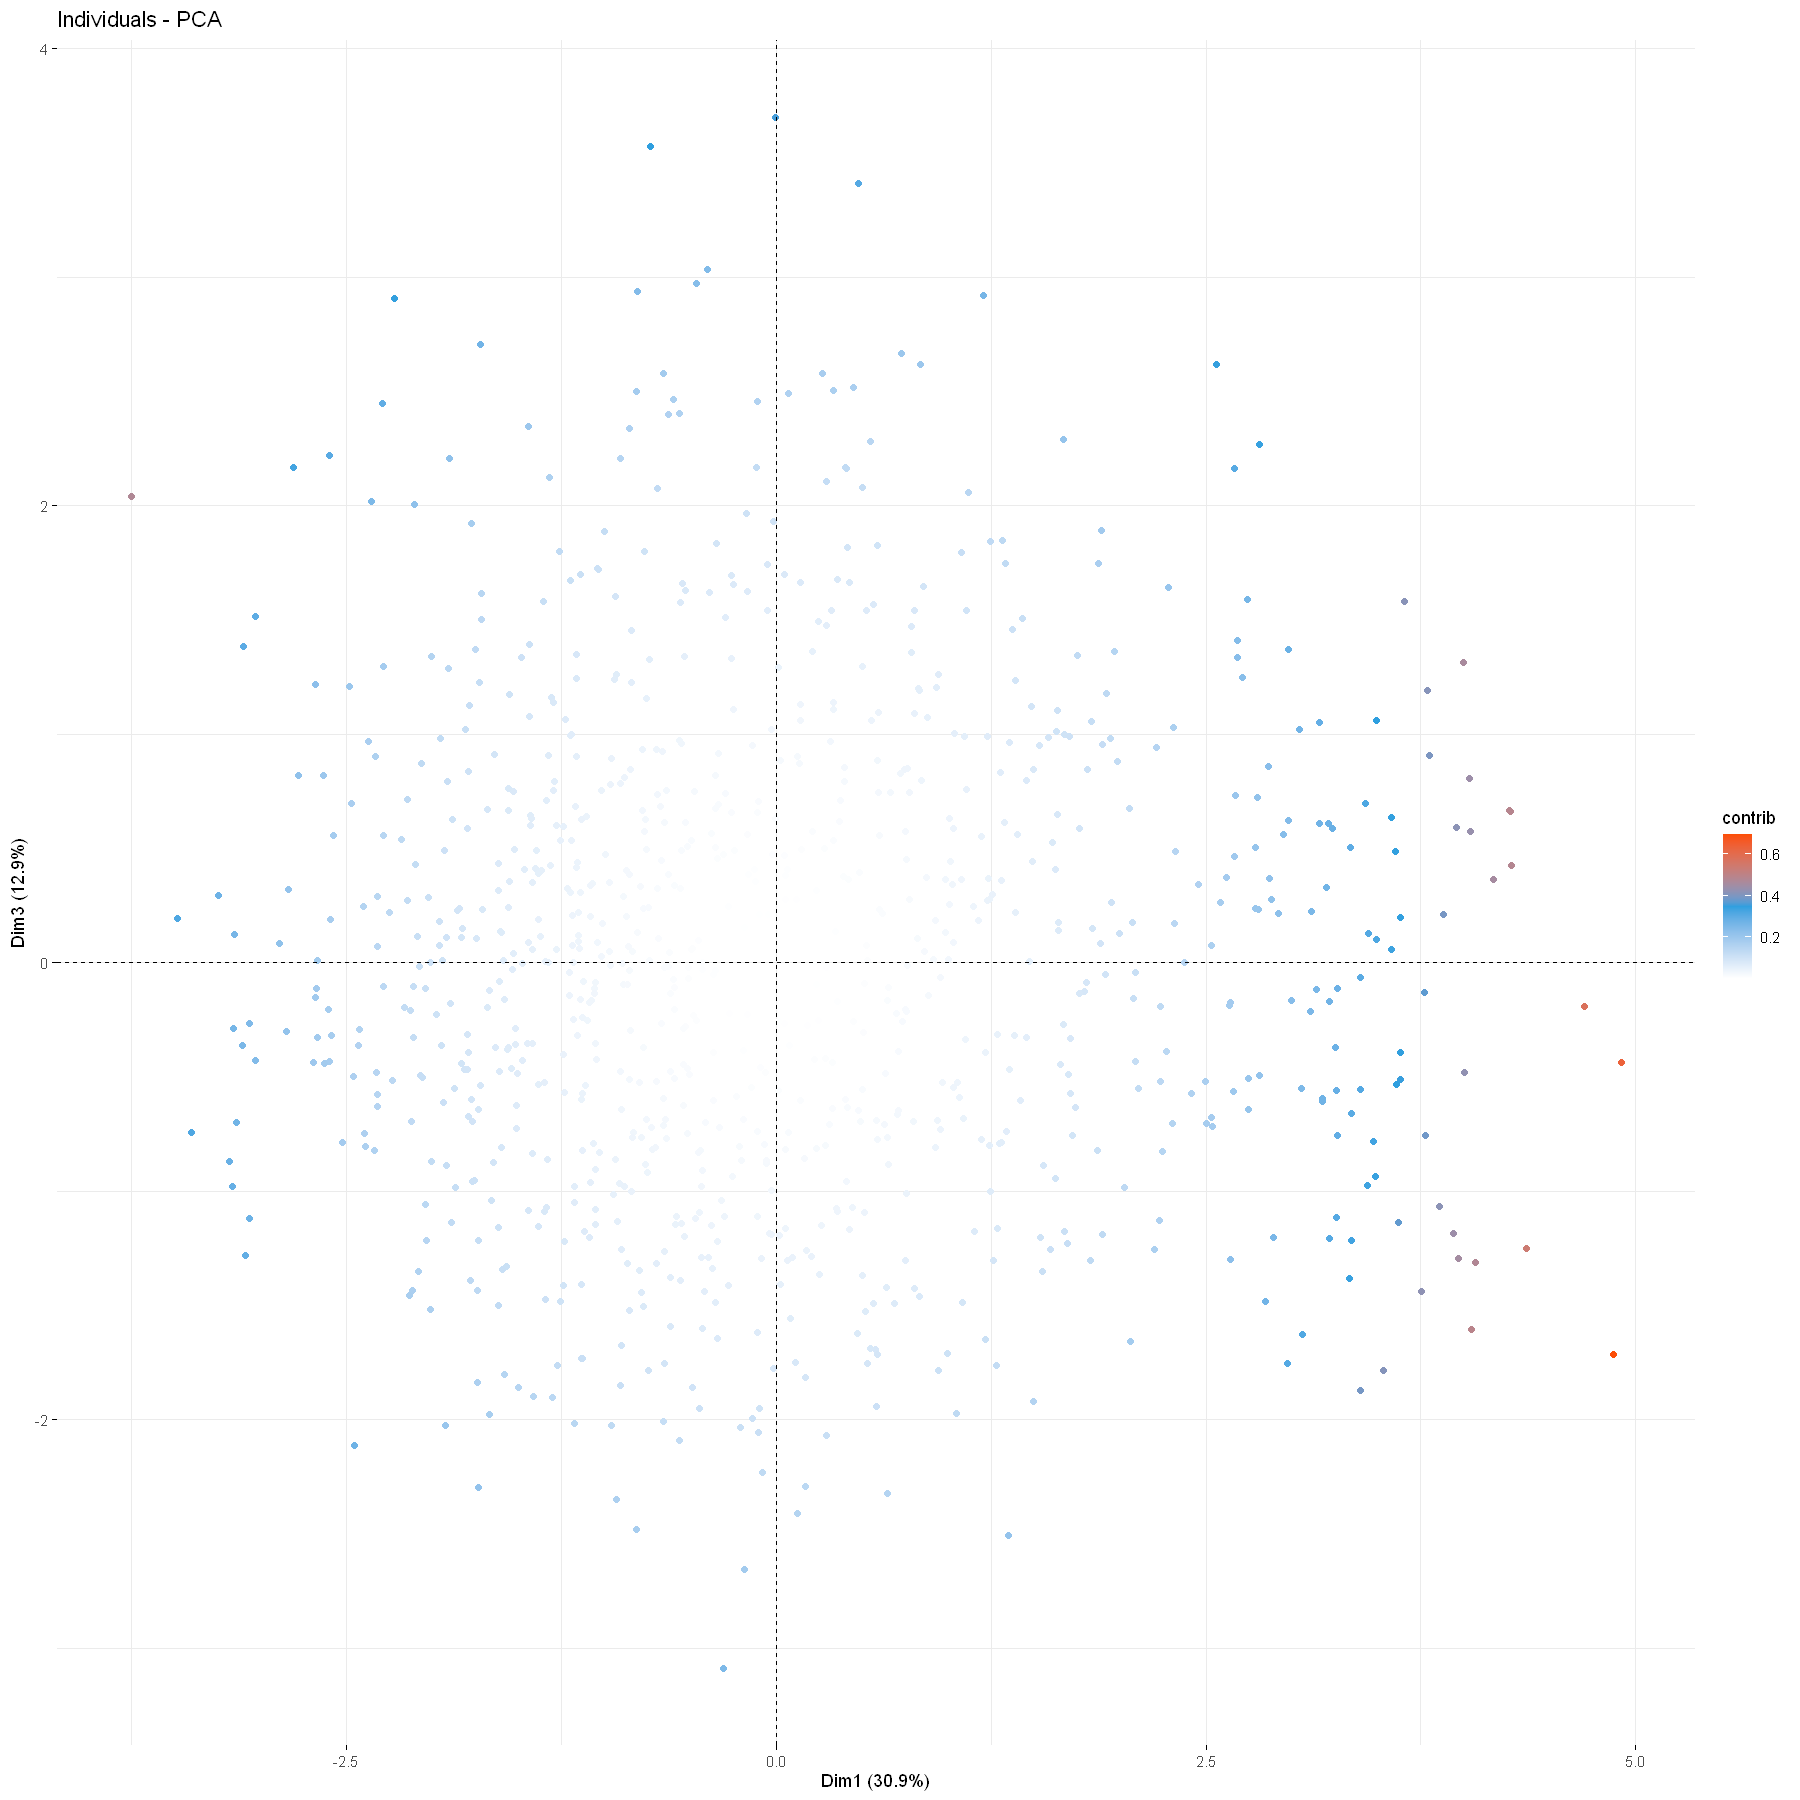

In [136]:
fviz_pca_var(acp)
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ))
fviz_pca_var(acp,axes=c(1,3))
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))

- La représentation des variables dans le 1er plan de l'ACP indique que l'axe 2 est porté par les variables Session_Duration..hours. et Calories_Burned qui sont très corrélées, mais aussi par la variable Fat_Percentage. L'axe 1 quand à lui est porté surtout par la variable height (mais elle est moins bien représentée que les 3 citées plus tôt dans ce plan). Trois variables sont très mal représentées dans ce plan, Resting_BPM, BMI et Max_BPM.

- Dans le second plan de l'ACP (dim1 avec dim 3), on remarque que la variable BMI est très bien représentée sur la 3ème dimension. Resting BPM et Max_BPM restent mal représentés. Le poids est aussi bien représenté dans la 3ème dimension.

In [137]:
head(data_acp)

,Age,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Fat_Percentage,Water_Intake..liters.,BMI
,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,56,88.3,1.71,180,157,60,1.69,1313,12.6,3.5,30.20
2,46,74.9,1.53,179,151,66,1.30,883,33.9,2.1,32.00
3,32,68.1,1.66,167,122,54,1.11,677,33.4,2.3,24.71
4,25,53.2,1.70,190,164,56,0.59,532,28.8,2.1,18.41
5,38,46.1,1.79,188,158,68,0.64,556,29.2,2.8,14.39
6,56,58.0,1.68,168,156,74,1.59,1116,15.5,2.7,20.55


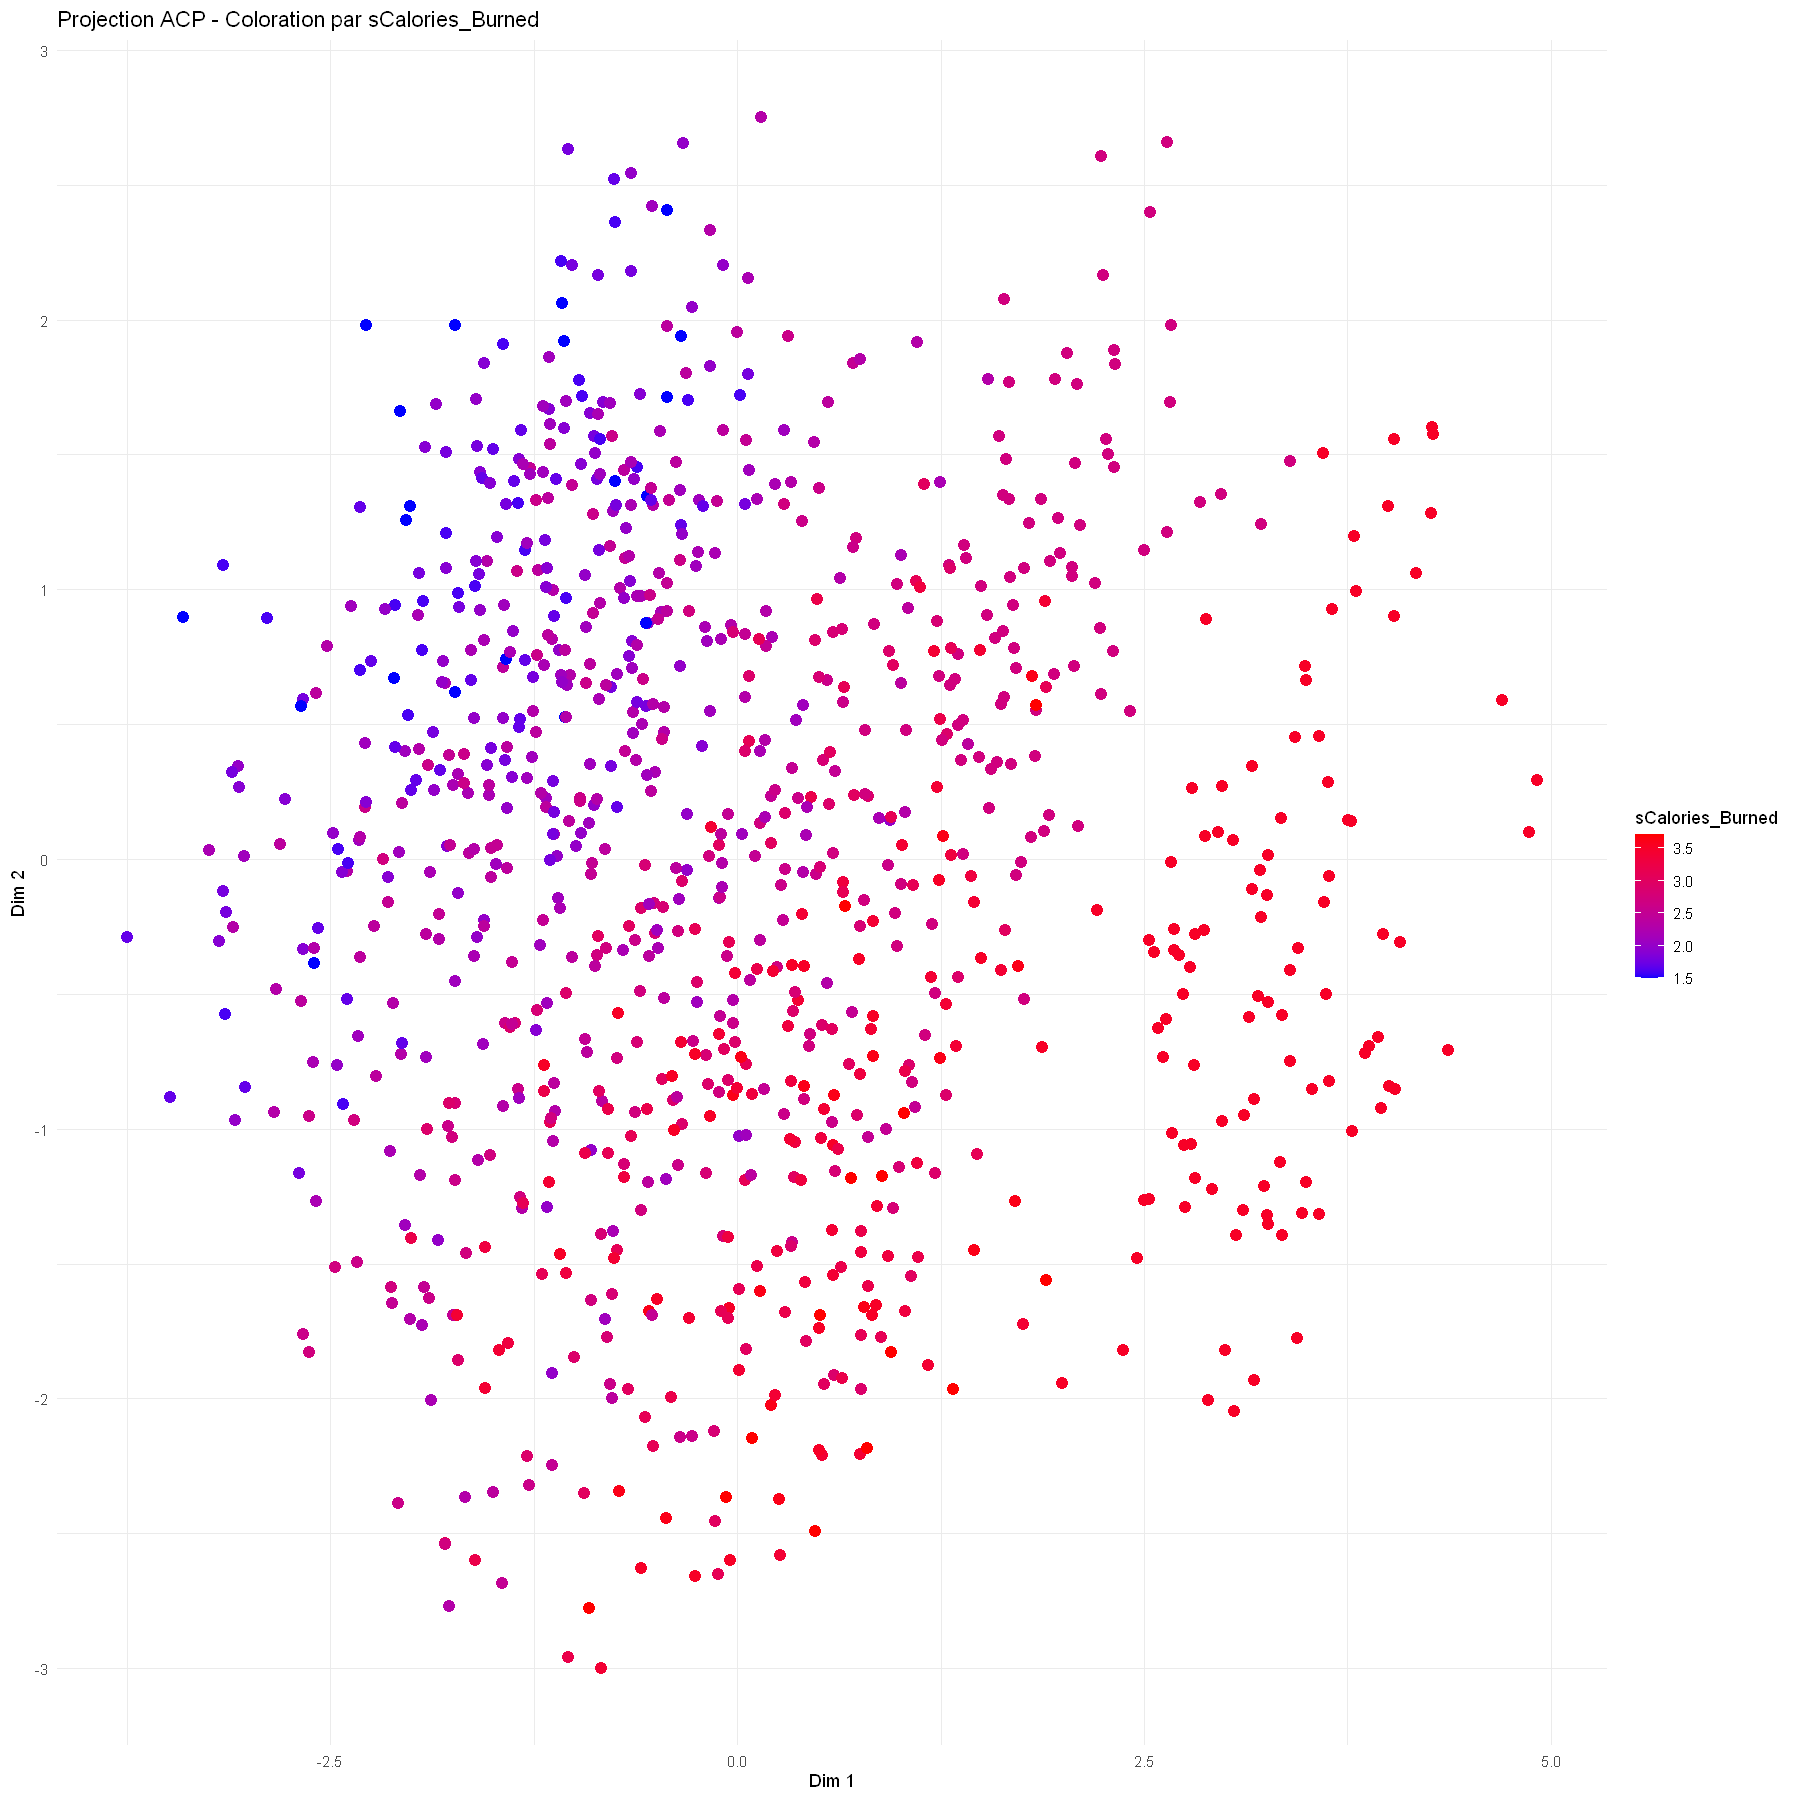

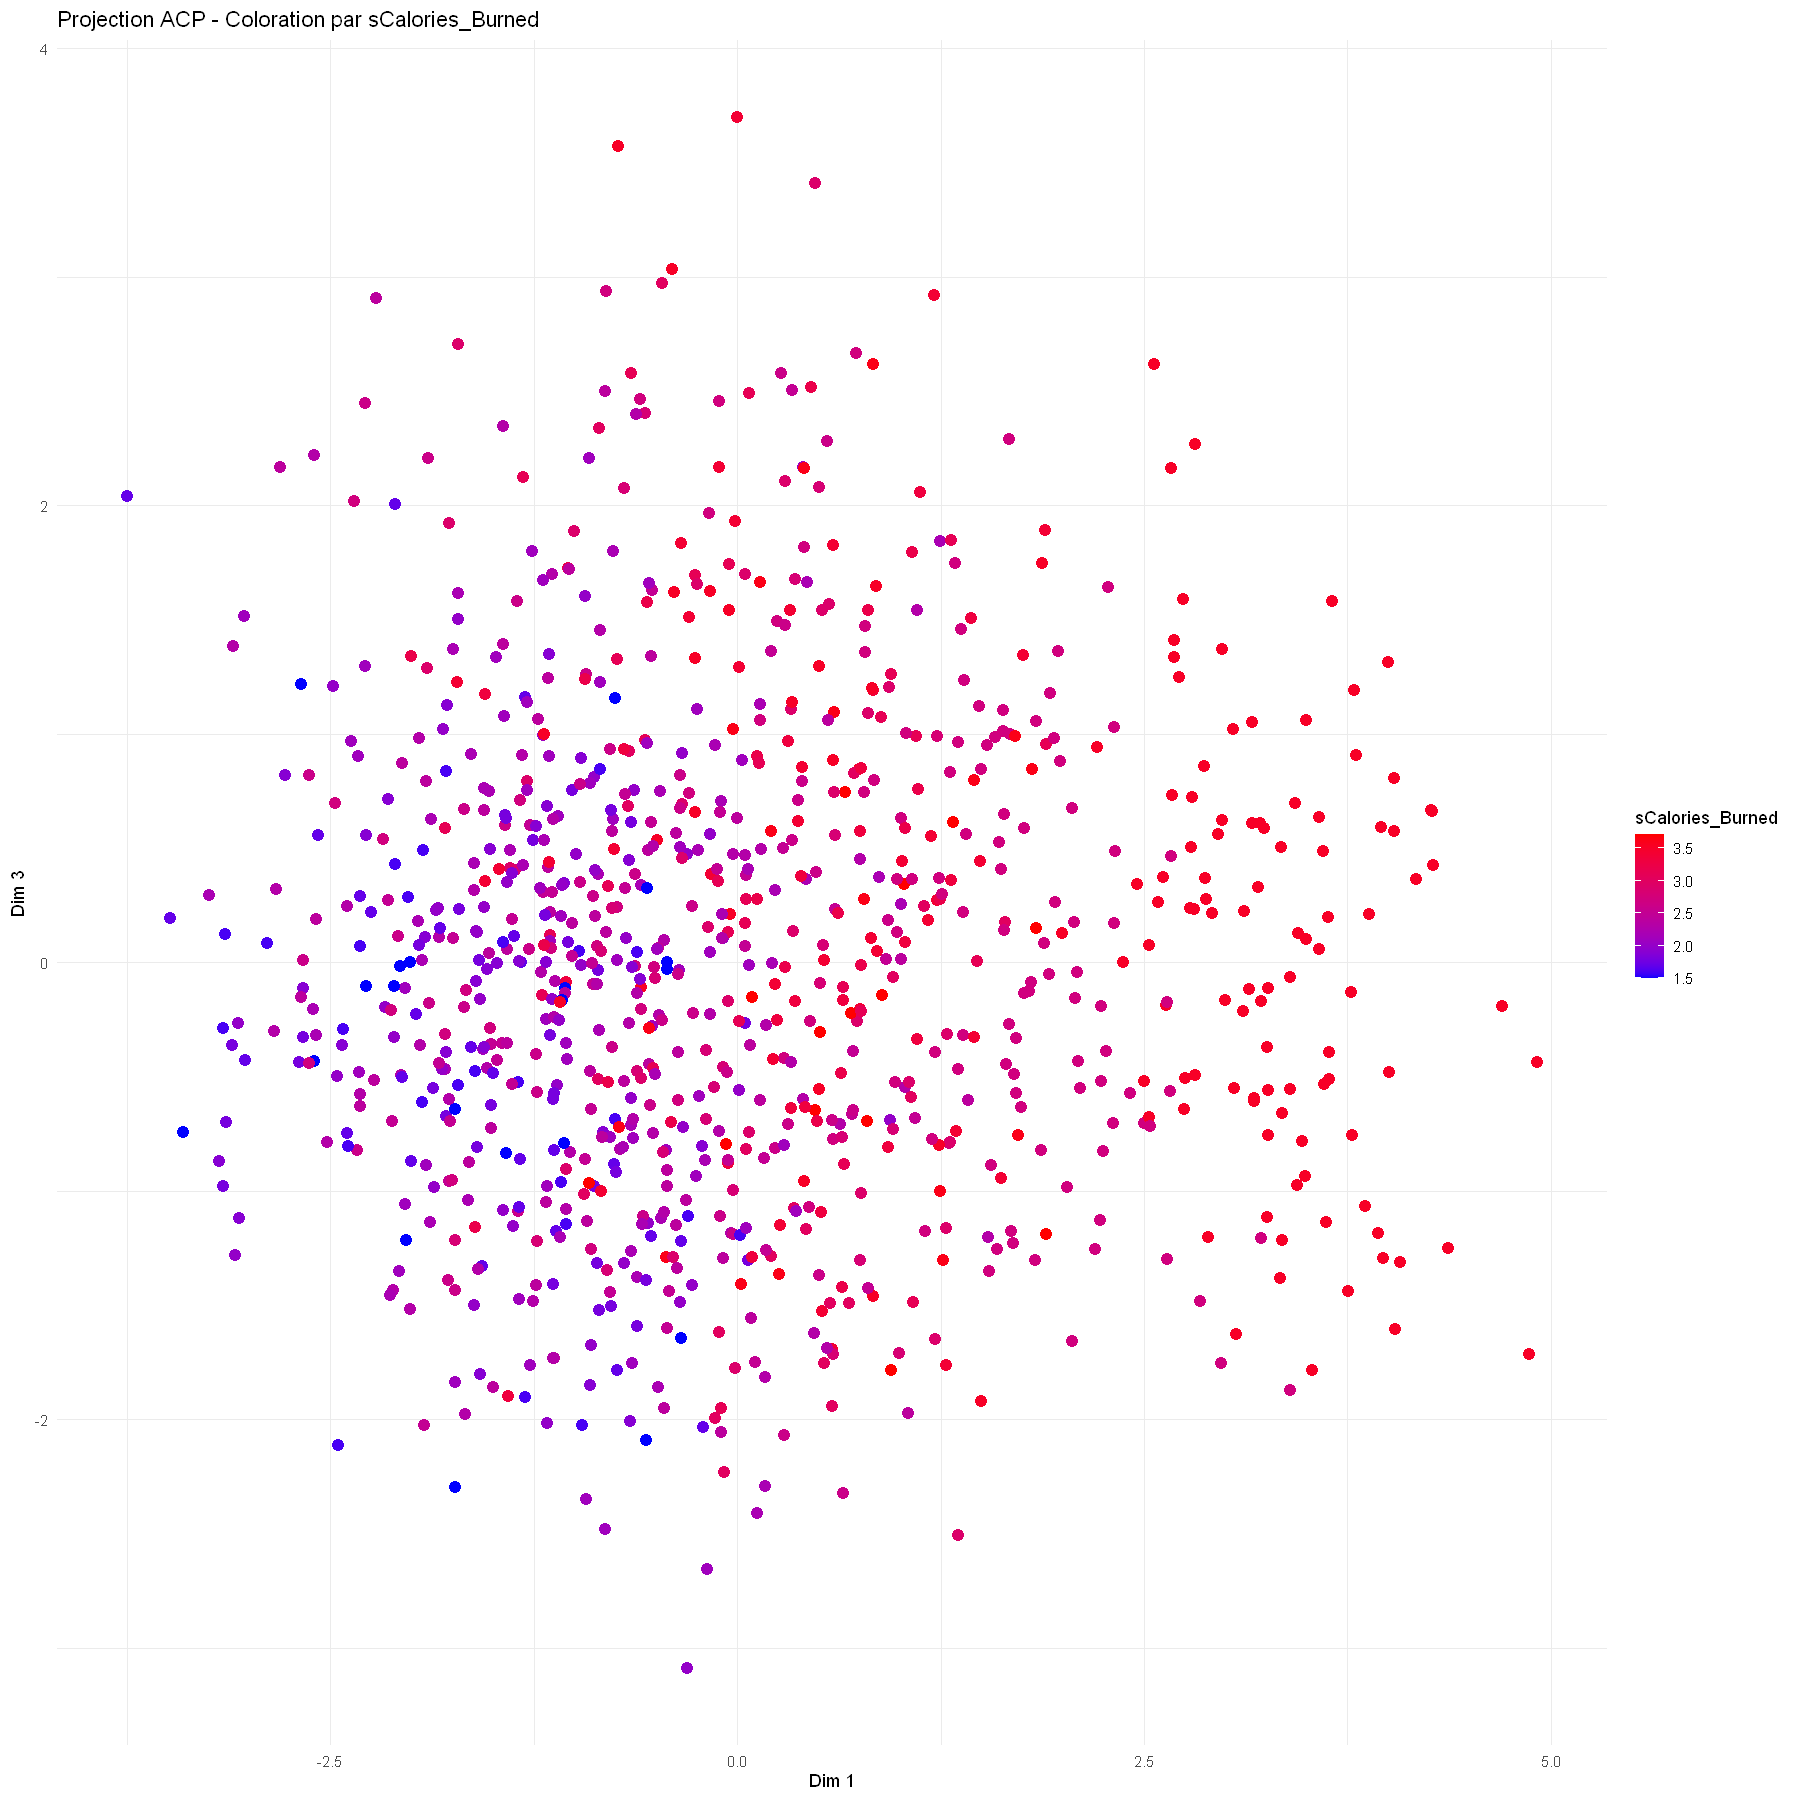

In [138]:
#fviz_pca_ind(acp, label="none", habillage=10)

# Récupération des coordonnées des individus
ind <- get_pca_ind(acp)
df_ind <- data.frame(ind$coord)  # Coordonnées des individus

# Ajouter la variable continue sCalories_Burned pour la colorisation
df_ind$sCalories_Burned <- data_acp[, 10]  

# Graphique avec fviz_pca_ind et ggplot2 pour un meilleur contrôle
ggplot(df_ind, aes(x = Dim.1, y = Dim.2, color = sCalories_Burned)) +
  geom_point(size = 3) +
  scale_color_gradient(low = "blue", high = "red") +  # Dégradé bleu → rouge
  theme_minimal() +
  labs(title = "Projection ACP - Coloration par sCalories_Burned",
       x = "Dim 1",
       y = "Dim 2",
       color = "sCalories_Burned")

ggplot(df_ind, aes(x = Dim.1, y = Dim.3, color = sCalories_Burned)) +
  geom_point(size = 3) +
  scale_color_gradient(low = "blue", high = "red") +  # Dégradé bleu → rouge
  theme_minimal() +
  labs(title = "Projection ACP - Coloration par sCalories_Burned",
       x = "Dim 1",
       y = "Dim 3",
       color = "sCalories_Burned")

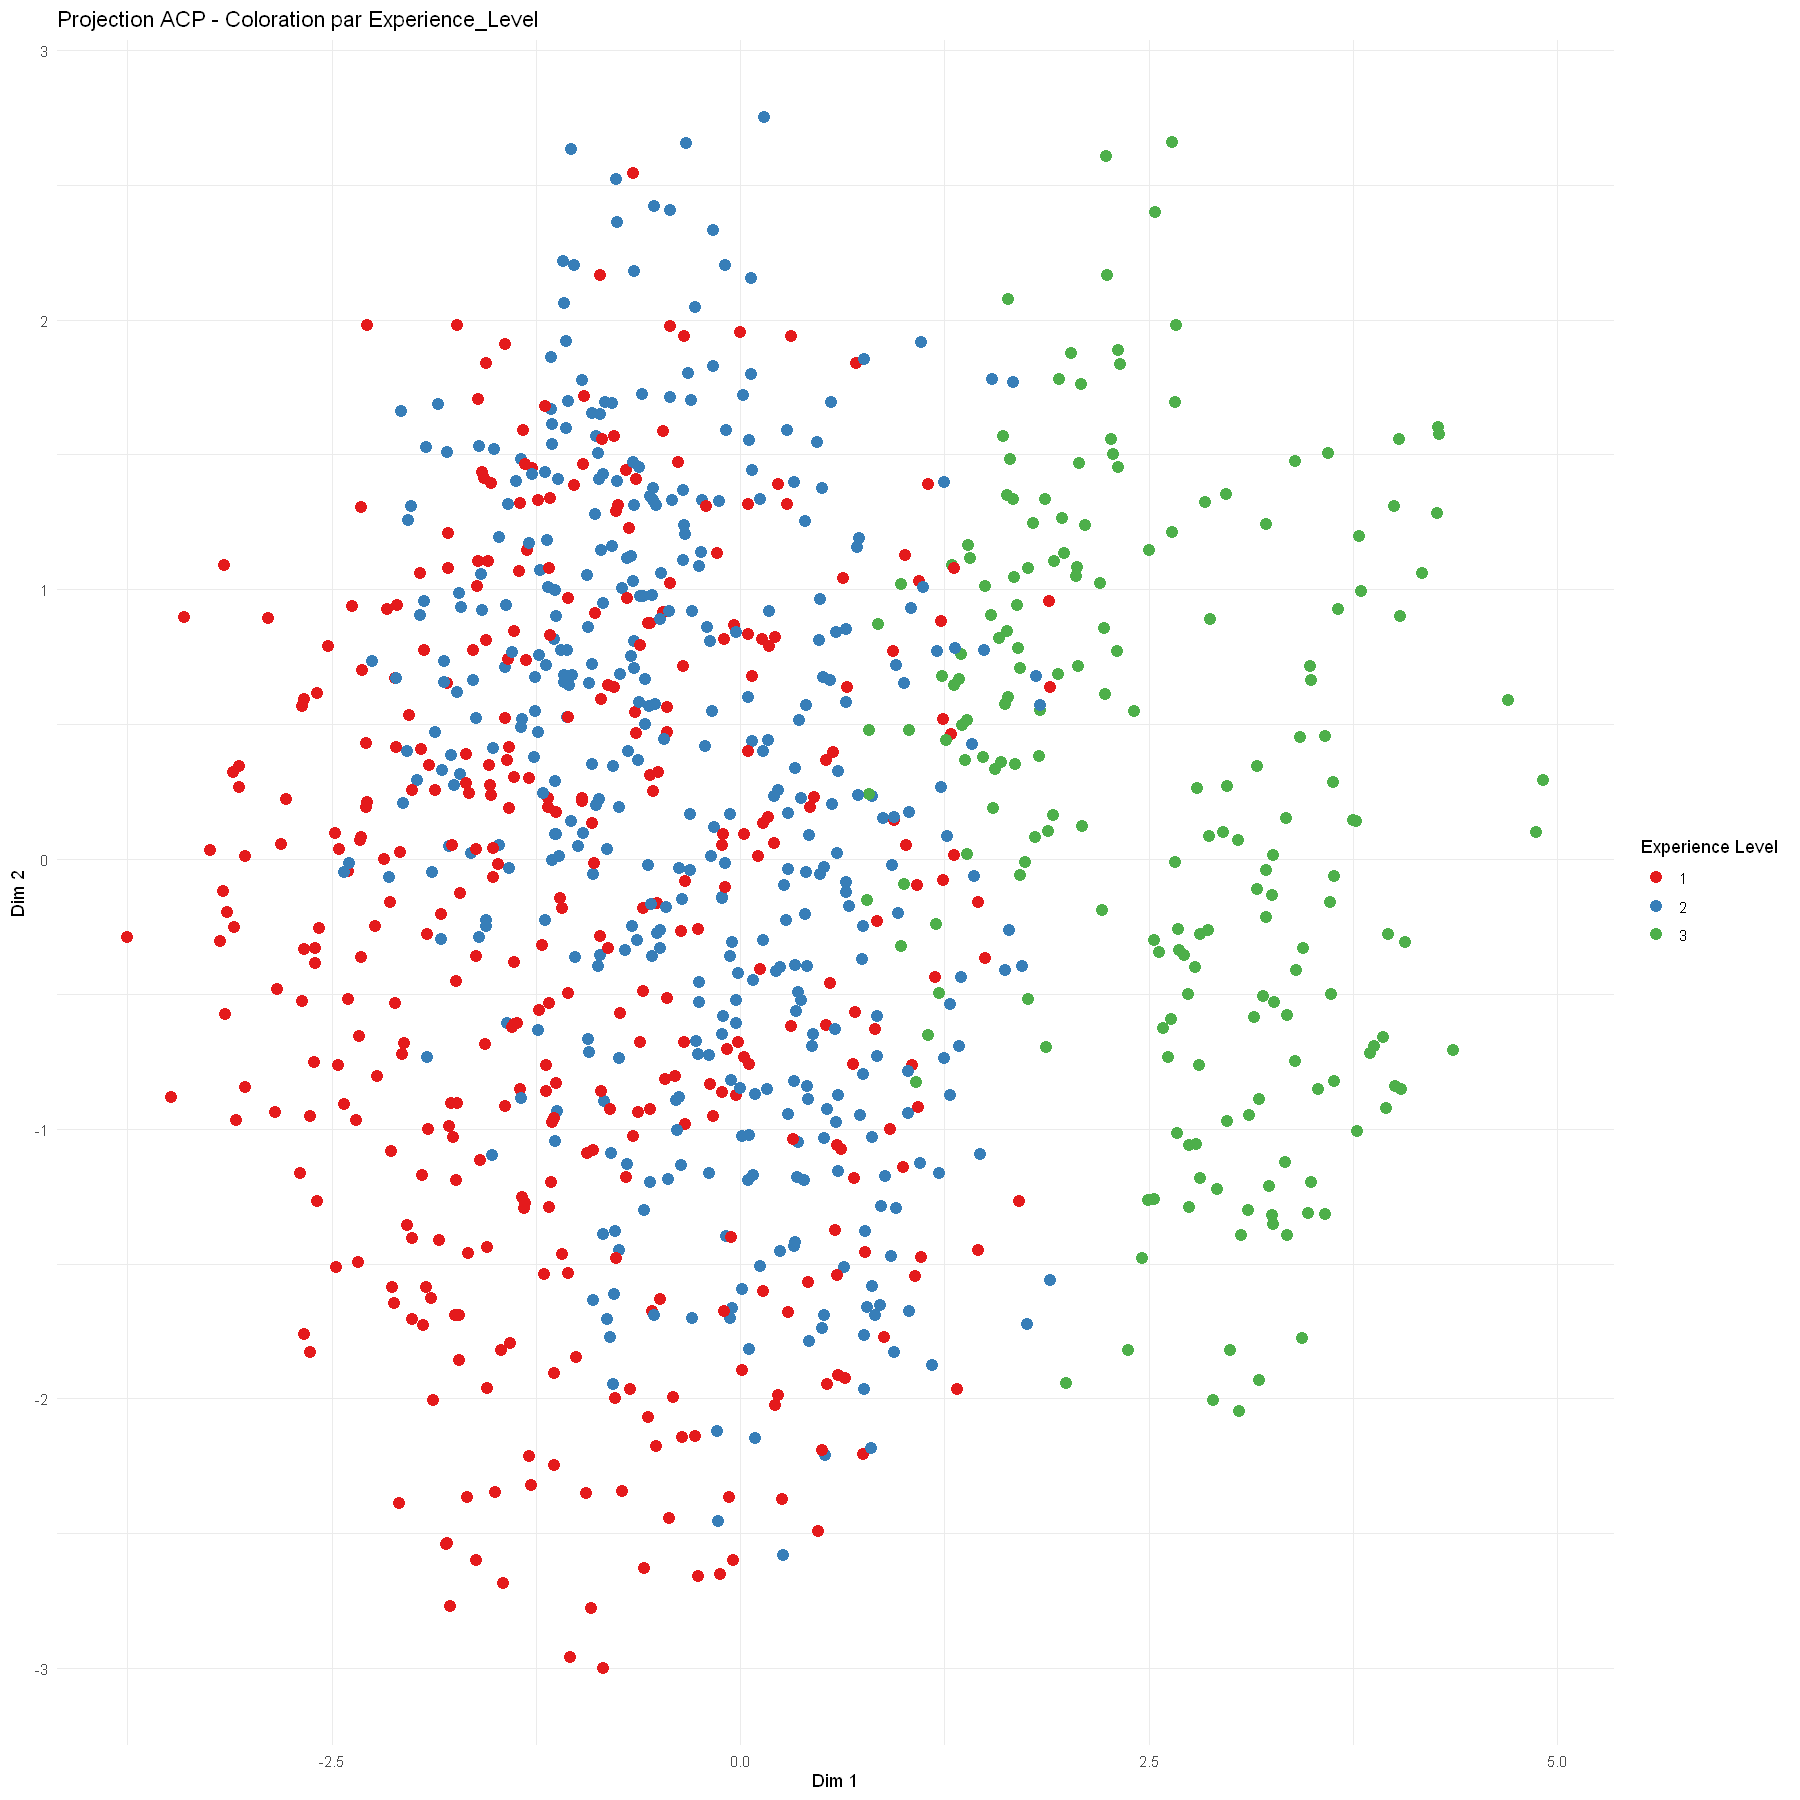

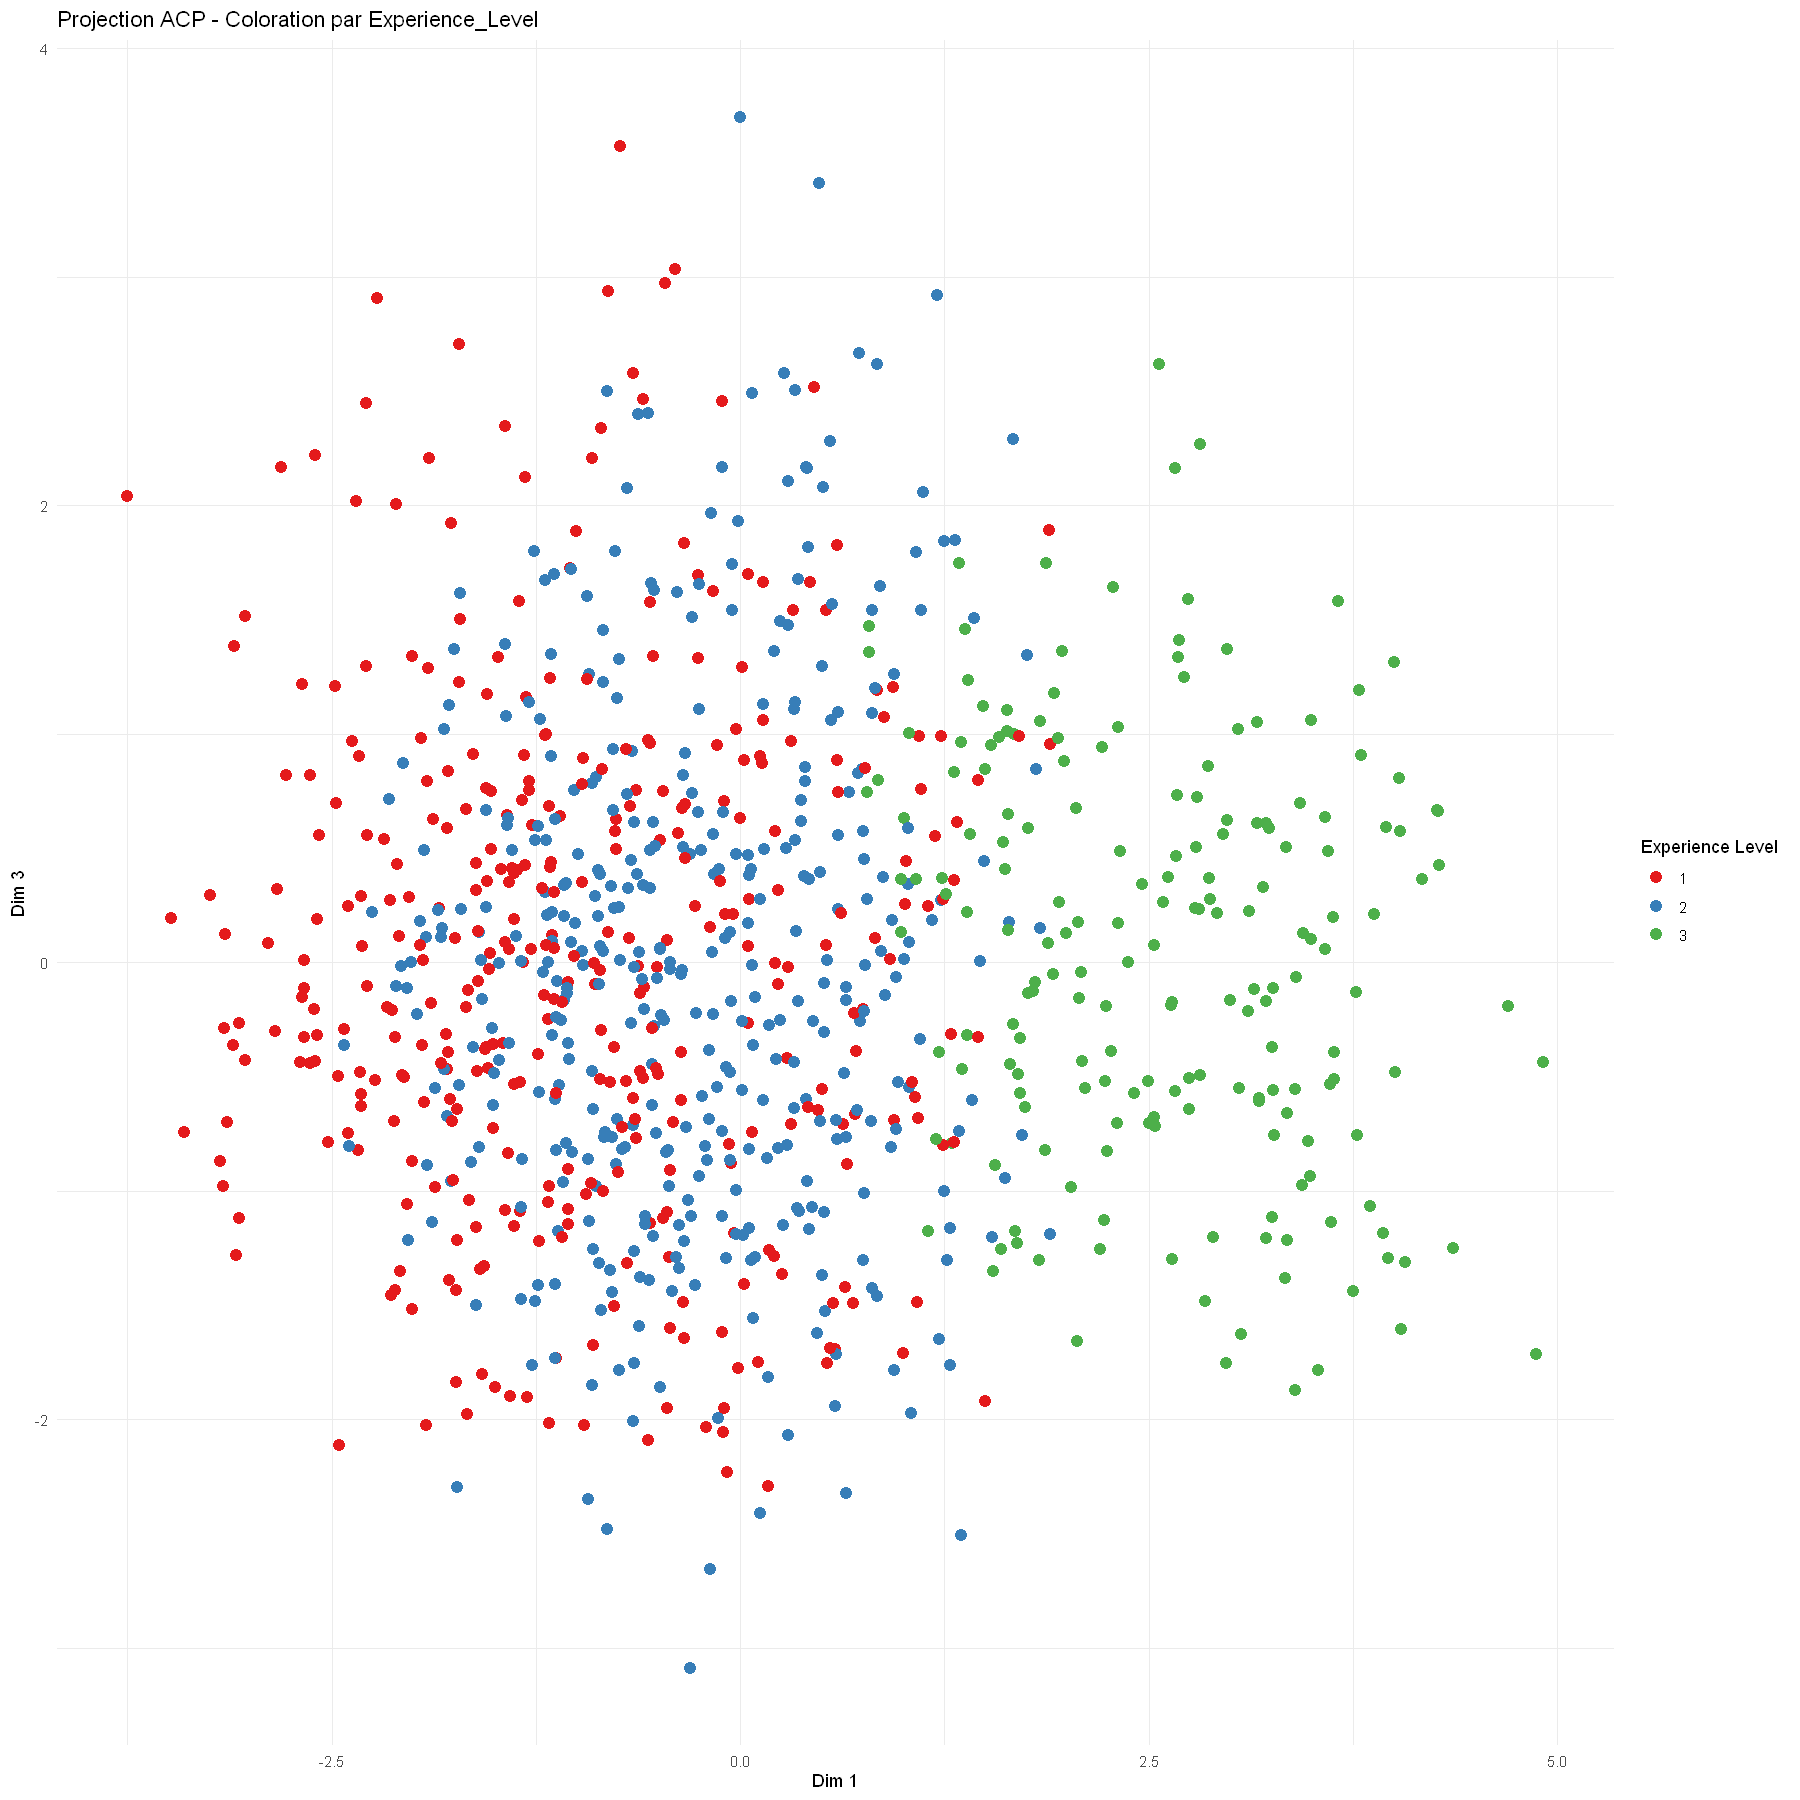

In [139]:
# Ajouter la variable catégorielle Experience_Level pour la colorisation
df_ind$Experience_Level <- data$Experience_Level  

# Graphique Dim 1 vs Dim 2
ggplot(df_ind, aes(x = Dim.1, y = Dim.2, color = Experience_Level)) +
  geom_point(size = 3) +
  scale_color_brewer(palette = "Set1") +  # Palette discrète
  theme_minimal() +
  labs(title = "Projection ACP - Coloration par Experience_Level",
       x = "Dim 1",
       y = "Dim 2",
       color = "Experience Level")

# Graphique Dim 1 vs Dim 3
ggplot(df_ind, aes(x = Dim.1, y = Dim.3, color = Experience_Level)) +
  geom_point(size = 3) +
  scale_color_brewer(palette = "Set1") +  # Même palette pour cohérence
  theme_minimal() +
  labs(title = "Projection ACP - Coloration par Experience_Level",
       x = "Dim 1",
       y = "Dim 3",
       color = "Experience Level")


Le graphe de projection des individus coloriés selon les variables **Experience_Level** et **sCalories_Burned** nous montrent que ces deux variables sont plutôt bien discriminés par l'ACP. Par ailleurs, les individus avec un niveau d'entraînement expert semblent être ceux qui brûlent le plus de calories. Aussi, nous pouvons observer que les individus avec un niveau d'entraînement intermédiaire et débutant sont plus difficilement discernables par l'ACP que ceux experts.

# 2. Modélisation (langage R)

# 2.1 Prédiction des calories brulées (régression)

## 2.1.1 Séparation des données en jeu de test et jeu d'entrainement

In [140]:
set.seed(111) # On initialise la graine aléatoire pour la reproducibilité des résultats

# On va utiliser 20% de l'échantillon pour les tests et le reste pour l'apprentissage
test.ratio <- .2
npop <- nrow(data_norm)
nvar <- ncol(data_norm)
ntest <- ceiling(npop * test.ratio) 

testi <- sample(1:npop, ntest)
appri <- setdiff(1:npop, testi) 

datappr0 <- data_norm[appri, -11] 
datestr0 <- data_norm[testi, -11]

datappr0quanti <- datappr0[c(1,3,4,5,6,7,8,9,11,14)]
datestr0quanti <- datestr0[c(1,3,4,5,6,7,8,9,11,14)]

In [141]:
# Normalisation des variables quantitatives dans l'échantillon d'apprentissage
datappr=datappr0
datapprquanti=as.data.frame(scale(datappr0quanti))
datappr[c(1,3,4,5,6,7,8,9,11,14)]=datapprquanti

# Normalisation de l'échantillon test à l'aide des caractéristiques de l'échantillon d'apprentissage
datestr=datestr0
datestrquanti=as.data.frame(scale(datestr0quanti,center=sapply(datestr0quanti,mean),scale=sapply(datestr0quanti,sd)))
datestr[c(1,3,4,5,6,7,8,9,11,14)]=datestrquanti

In [142]:
# Fonction pour l'affichage des résidus
gplot.res <- function(fit, res, titre = "") {
  df <- data.frame(fit = fit, res = res)
  df <- df[is.finite(df$fit) & is.finite(df$res), ]
  ggplot(df, aes(x = fit, y = res)) +
    geom_point(col = "blue") +
    ylab("Résidus")+ xlab("Valeurs prédites")+
    geom_hline(yintercept = 0, col = "green") +
    ggtitle(titre)
}

## 2.1.2 Régression par modèles linéaires 

### modèle linéaire sans interactions:


Call:
lm(formula = sCalories_Burned ~ ., data = datappr)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56040 -0.07267  0.00352  0.07802  0.39233 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -0.1286482  0.0156893  -8.200 1.03e-15 ***
Age                            -0.1446534  0.0044385 -32.590  < 2e-16 ***
GenderMale                      0.2953813  0.0158494  18.637  < 2e-16 ***
sWeight..kg.                   -0.0434233  0.0733915  -0.592   0.5543    
Height..m.                      0.0323214  0.0393866   0.821   0.4121    
Max_BPM                         0.0048163  0.0044624   1.079   0.2808    
Avg_BPM                         0.3232807  0.0044271  73.024  < 2e-16 ***
Resting_BPM                     0.0075797  0.0044417   1.707   0.0883 .  
Session_Duration..hours.        0.9479217  0.0070881 133.734  < 2e-16 ***
Workout_TypeHIIT               -0.0073398  0.0127066  -0.578   0.5637    
Workout_T

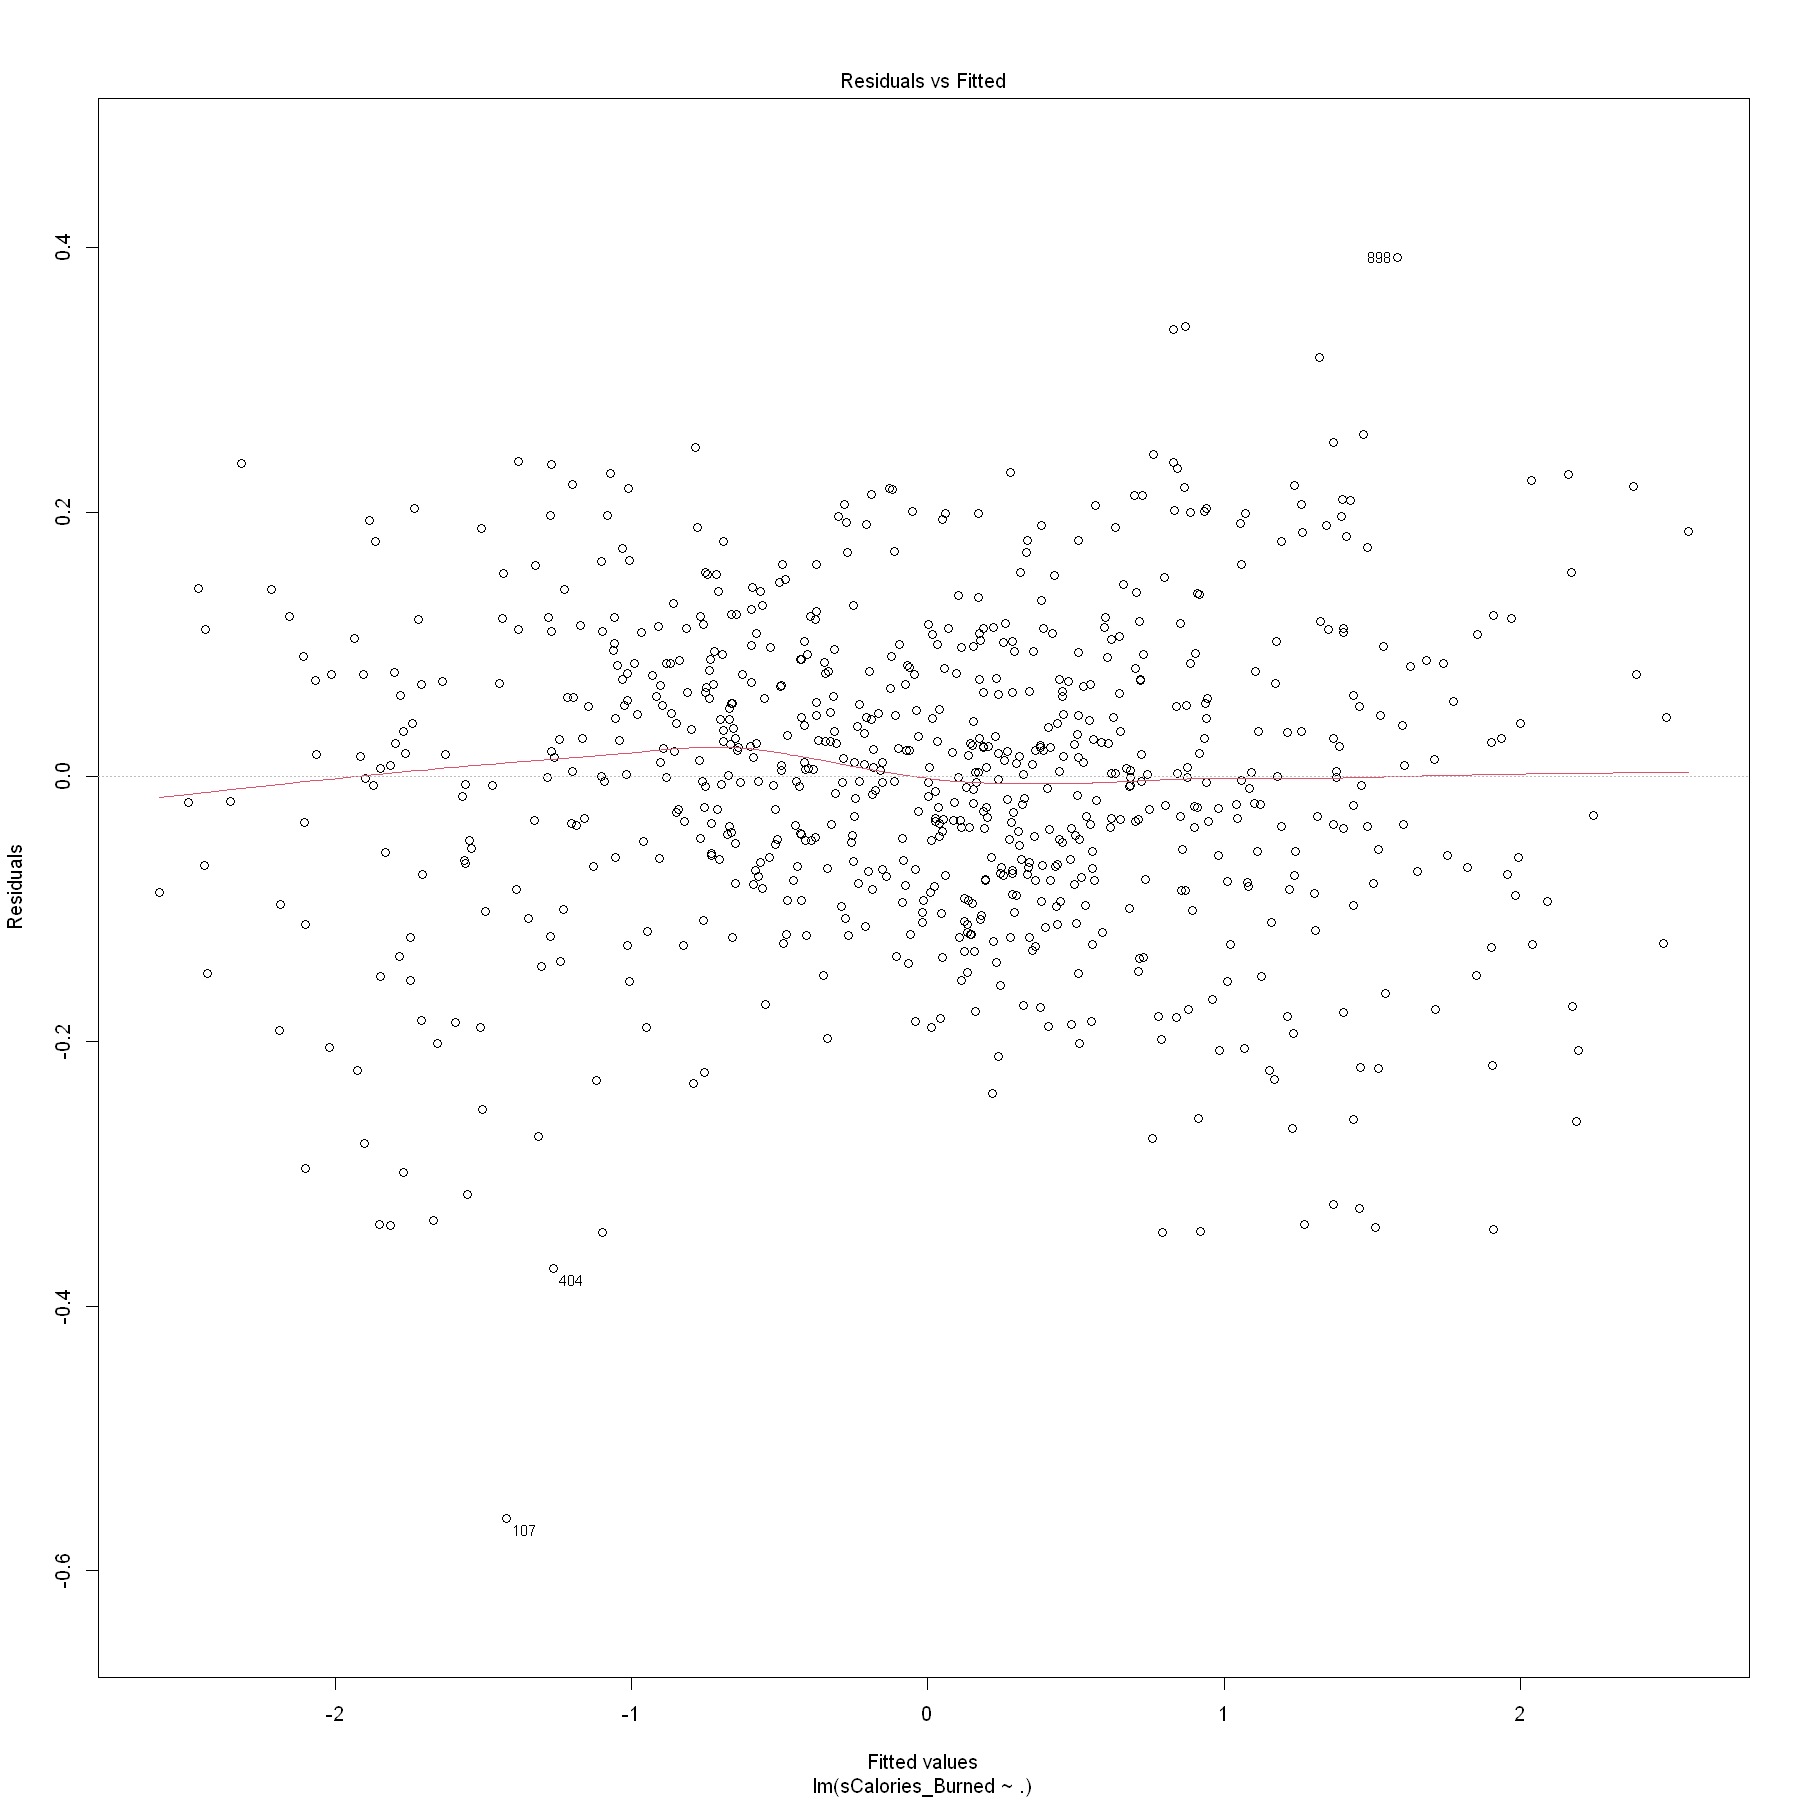

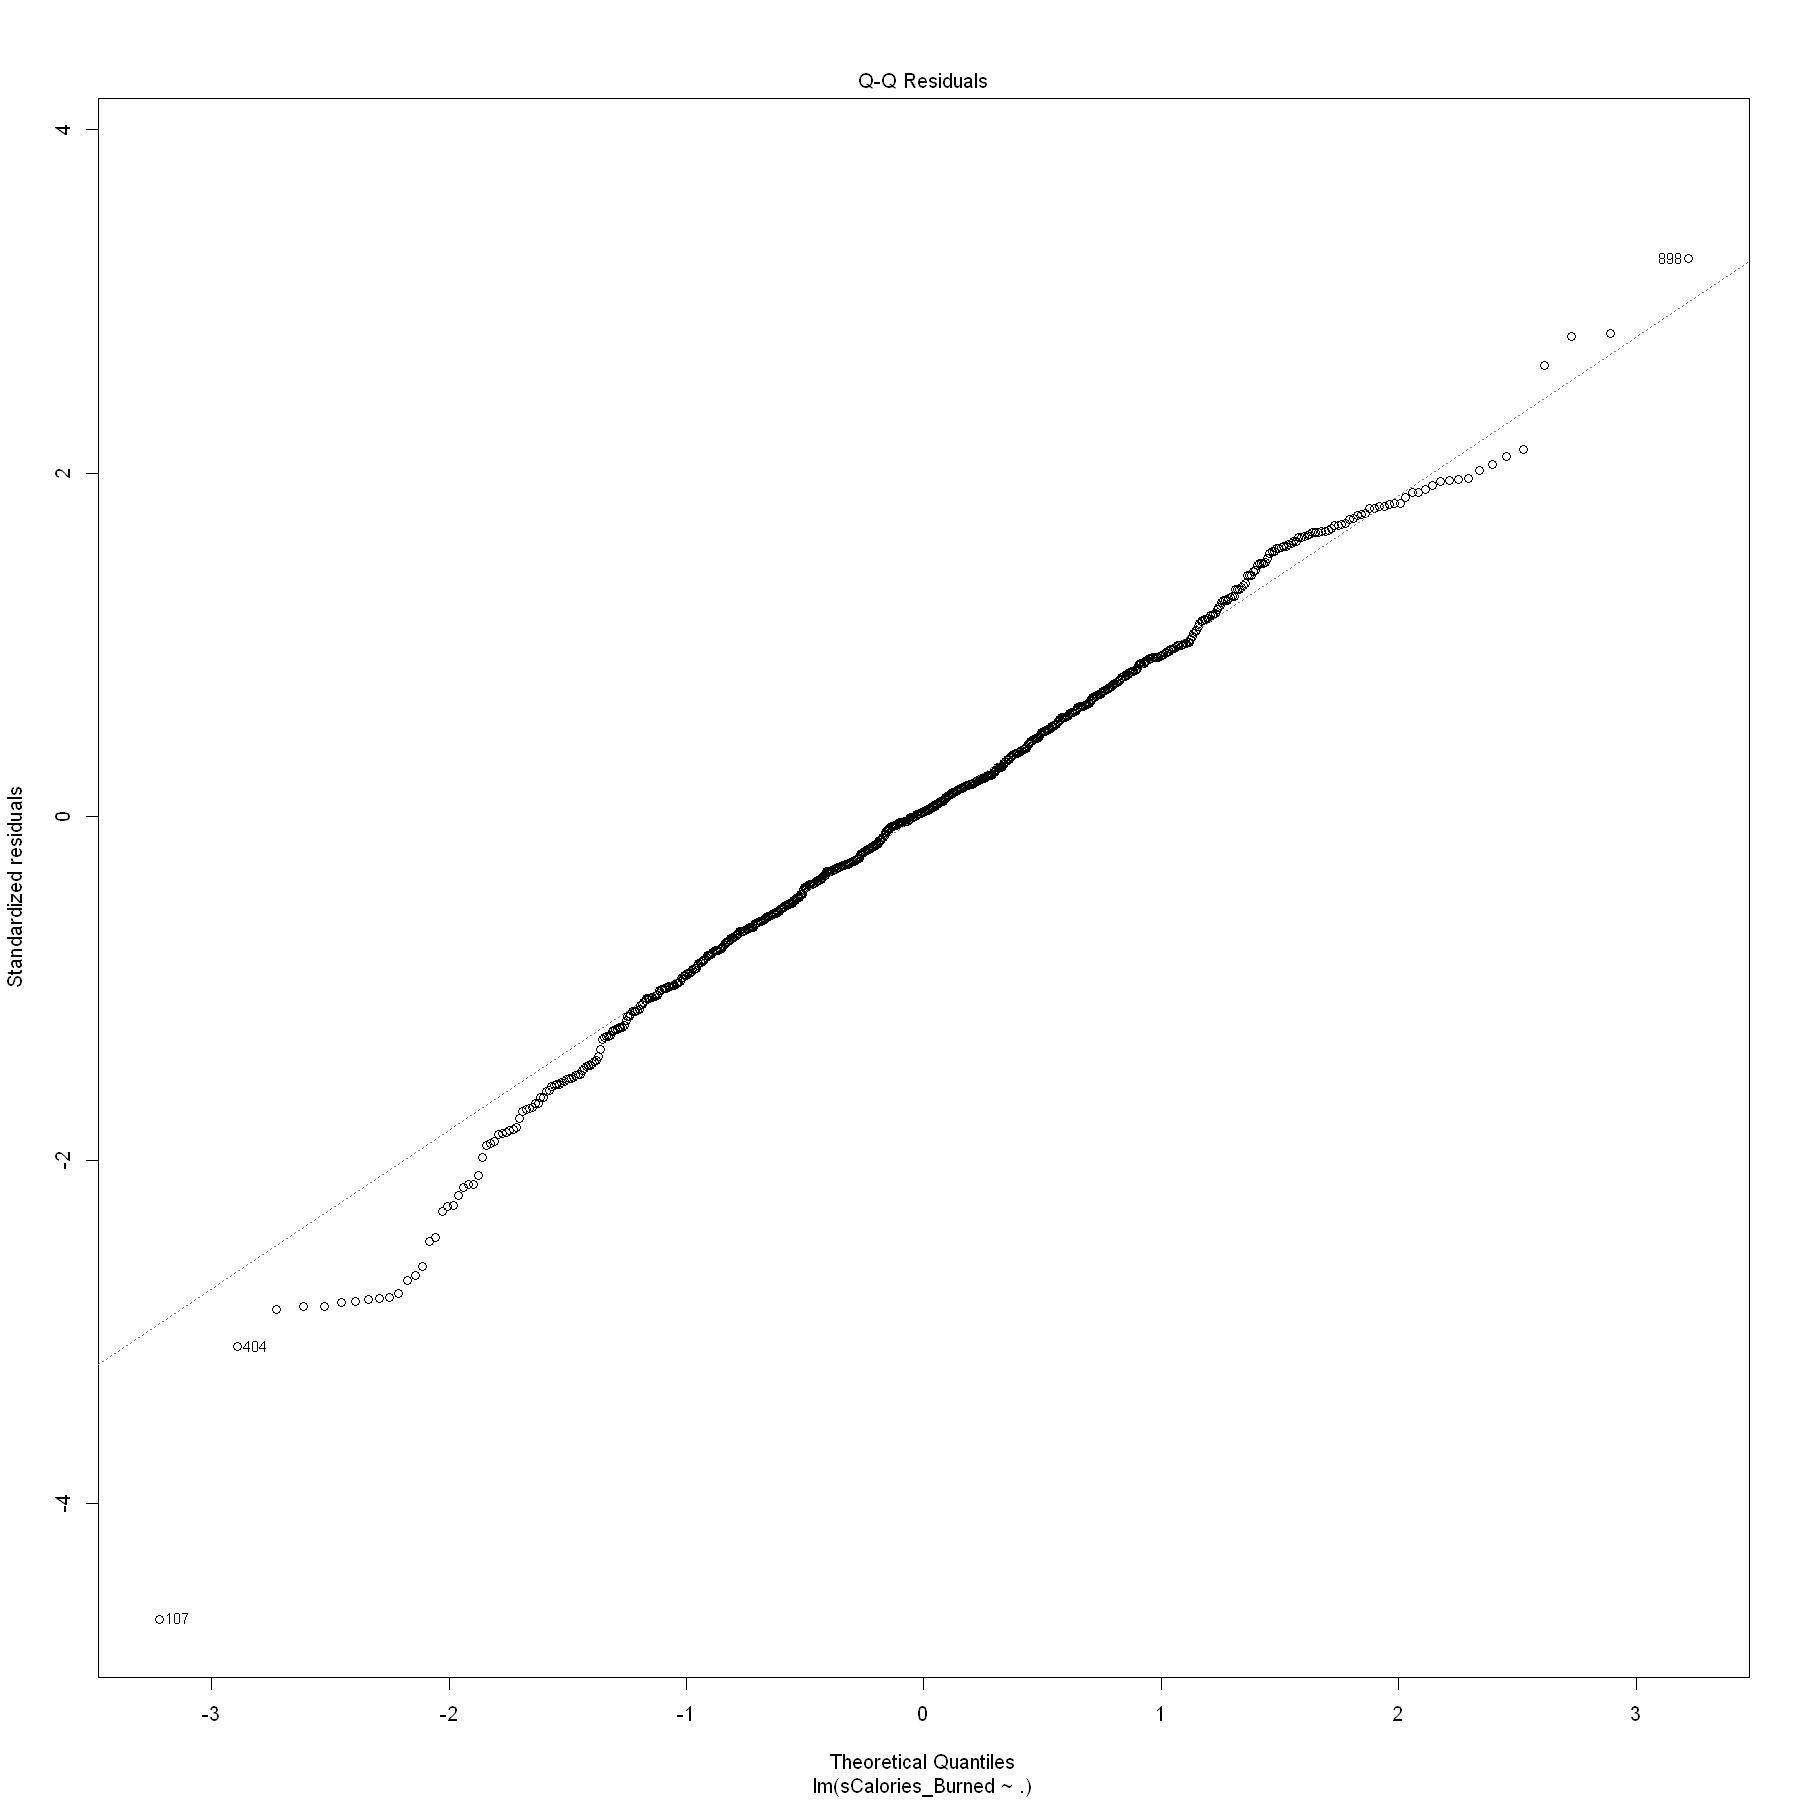

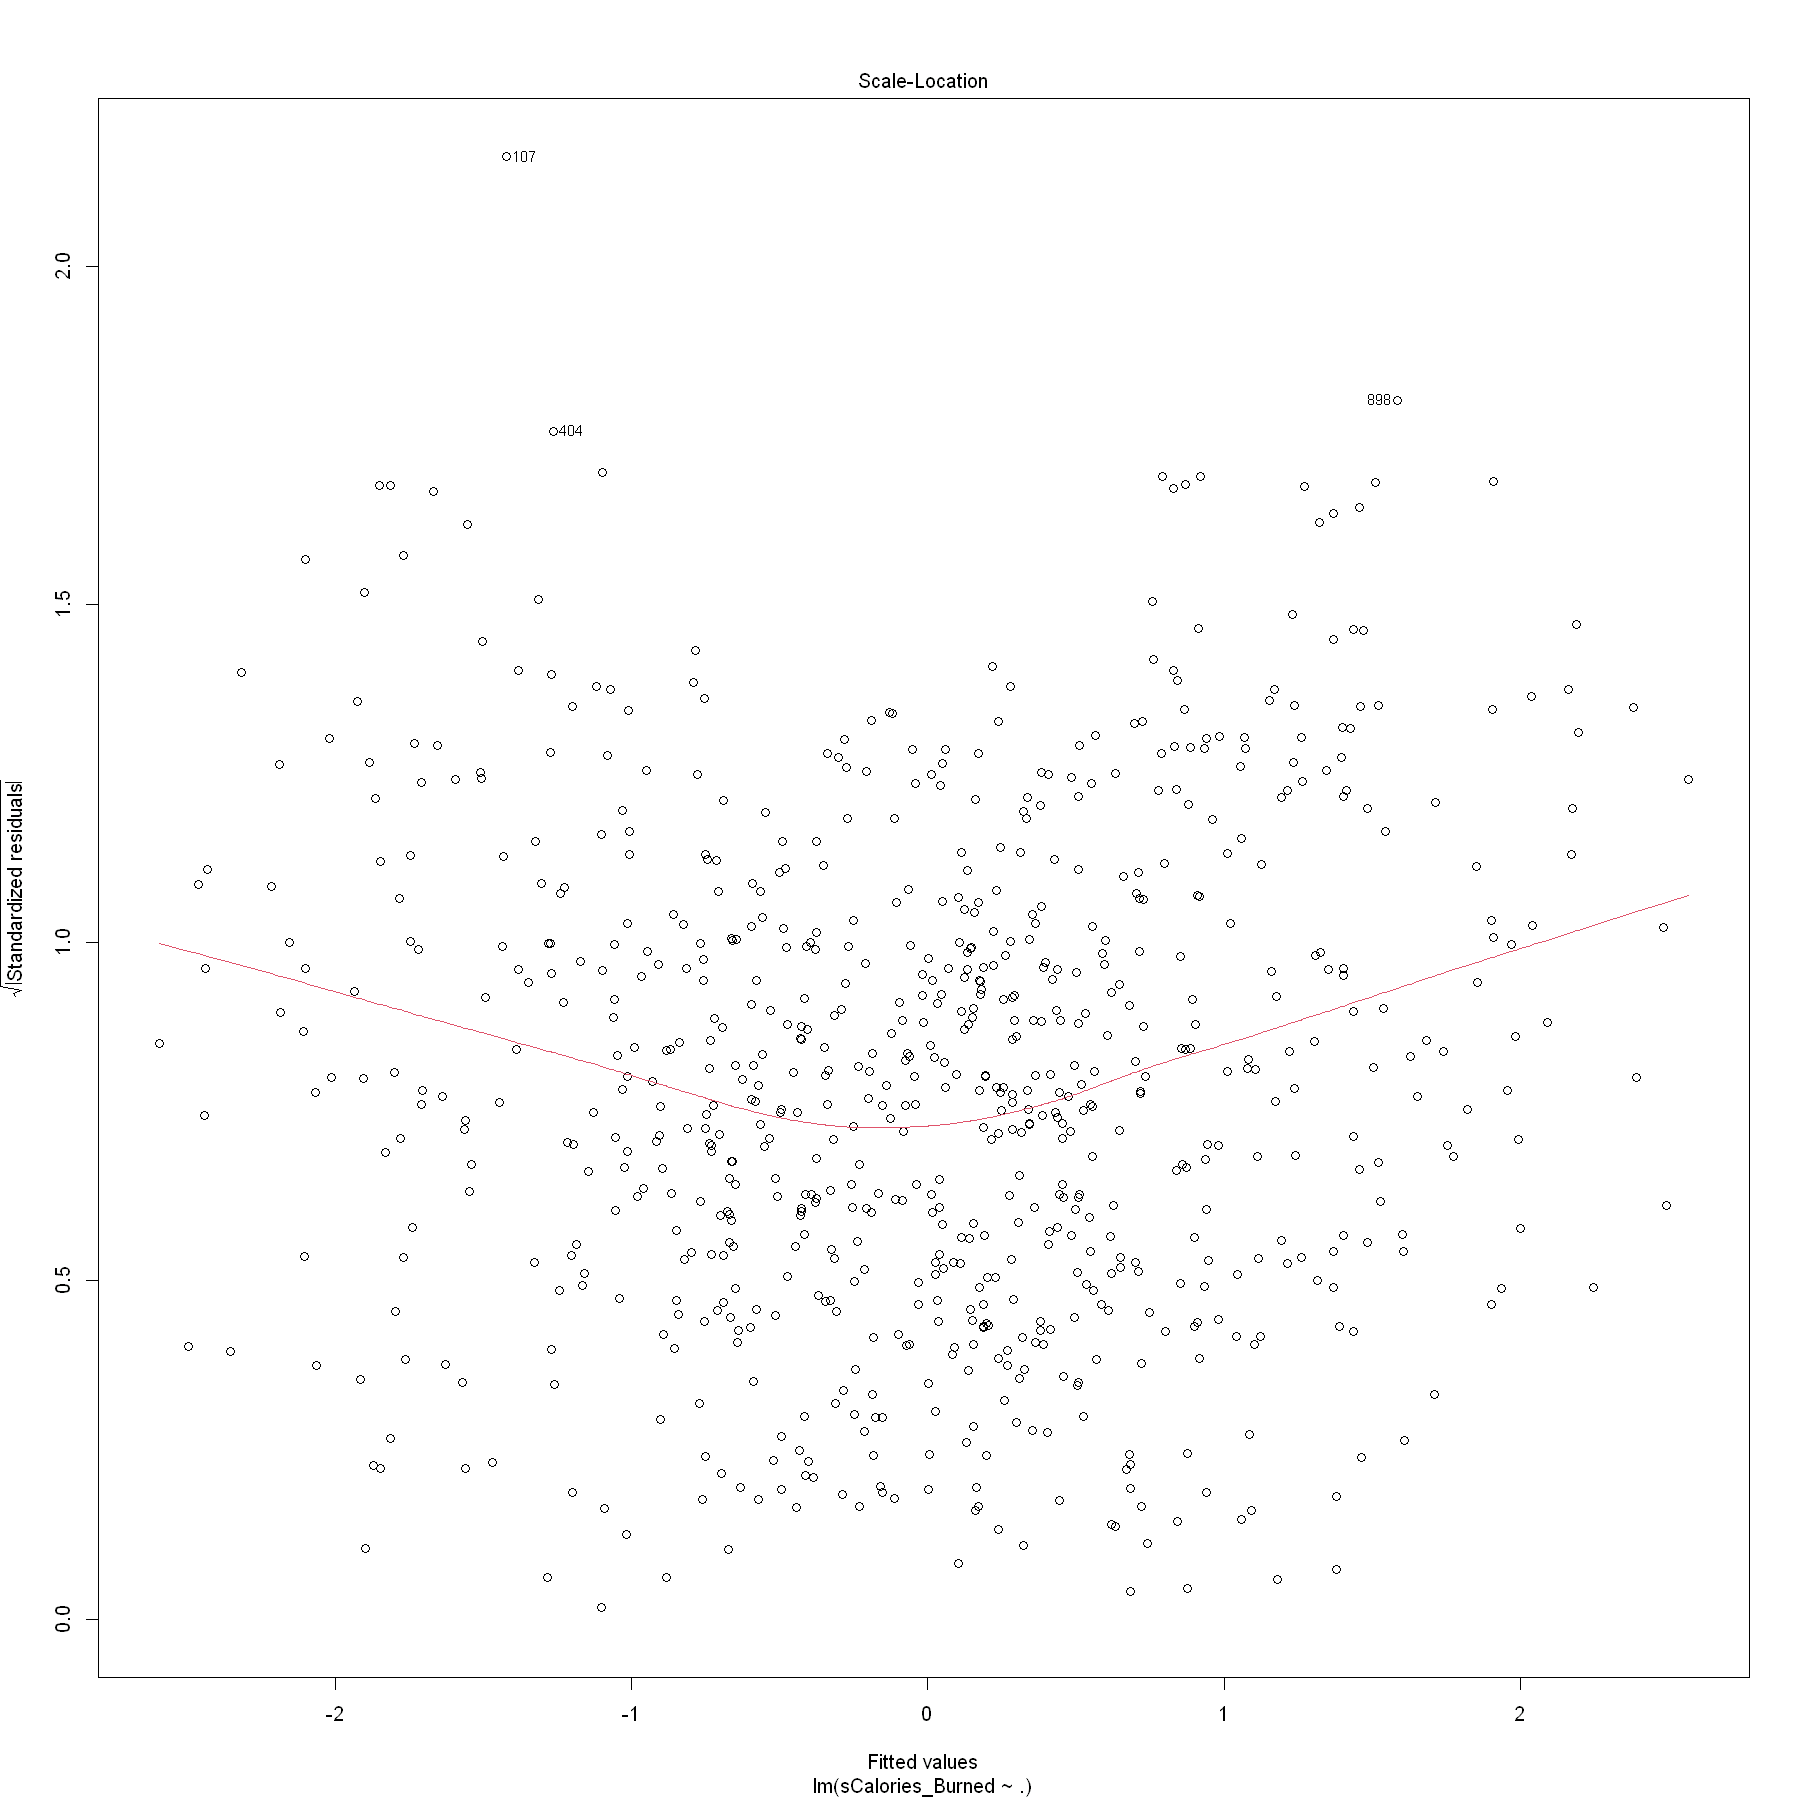

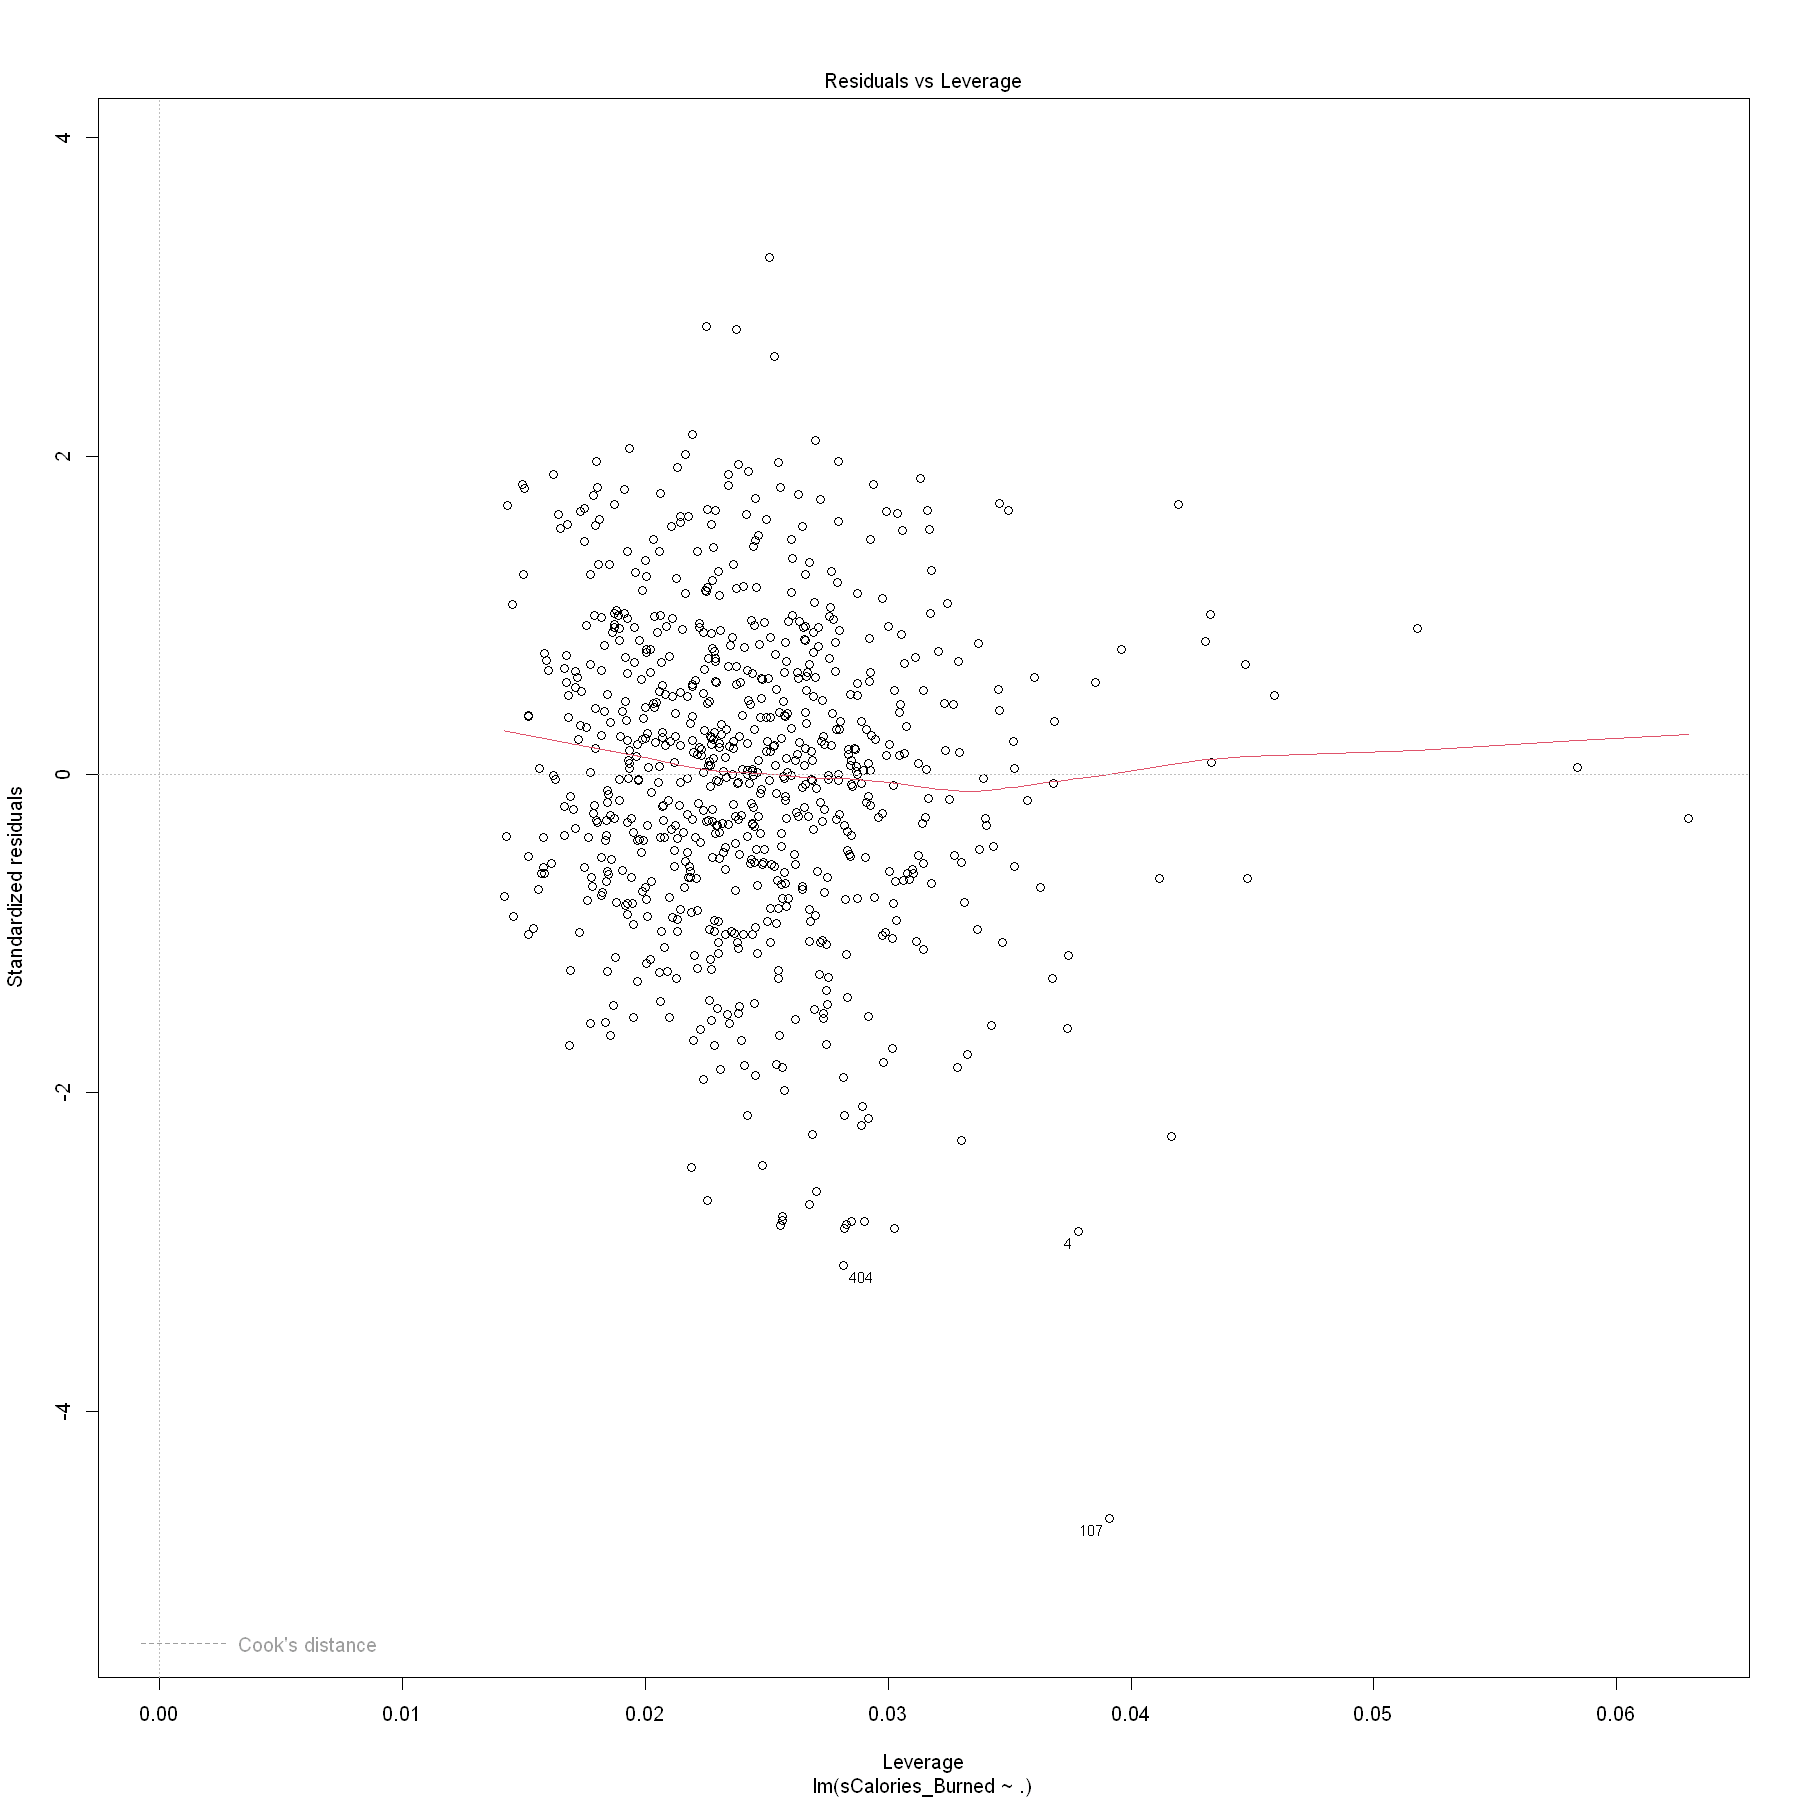

In [143]:
# On fit un modèle linéaire sans intéractions:
reg = lm(sCalories_Burned ~ ., data = datappr)

summary(reg)
plot(reg)

Le adjusted R-square du modèle est très bon avec une valeur de 0.985. Les coefficients les plus pertinents selon le sommaire sont l'age, le genre, la durée de la session et le BPM moyen (et l'intercept). 

Au niveau des résidus, les hypothèses du modèle linéaire semblent plutôt respectées.

### Comparaison sur l'échantillon de test:

In [144]:
y_test <- datestr$sCalories_Burned

test_lineaire <- predict(reg, newdata = datestr)
rmse <- sqrt(mean((y_test - test_lineaire)^2))

cat("RMSE pour le modèle linéaire :", rmse, "\n")

RMSE pour le modèle linéaire : 0.1275748 


le RMSE est assez faible, les prédictions du modèle sont donc plutôt bonnes

### Modèle linéaire avec pénalisation lasso

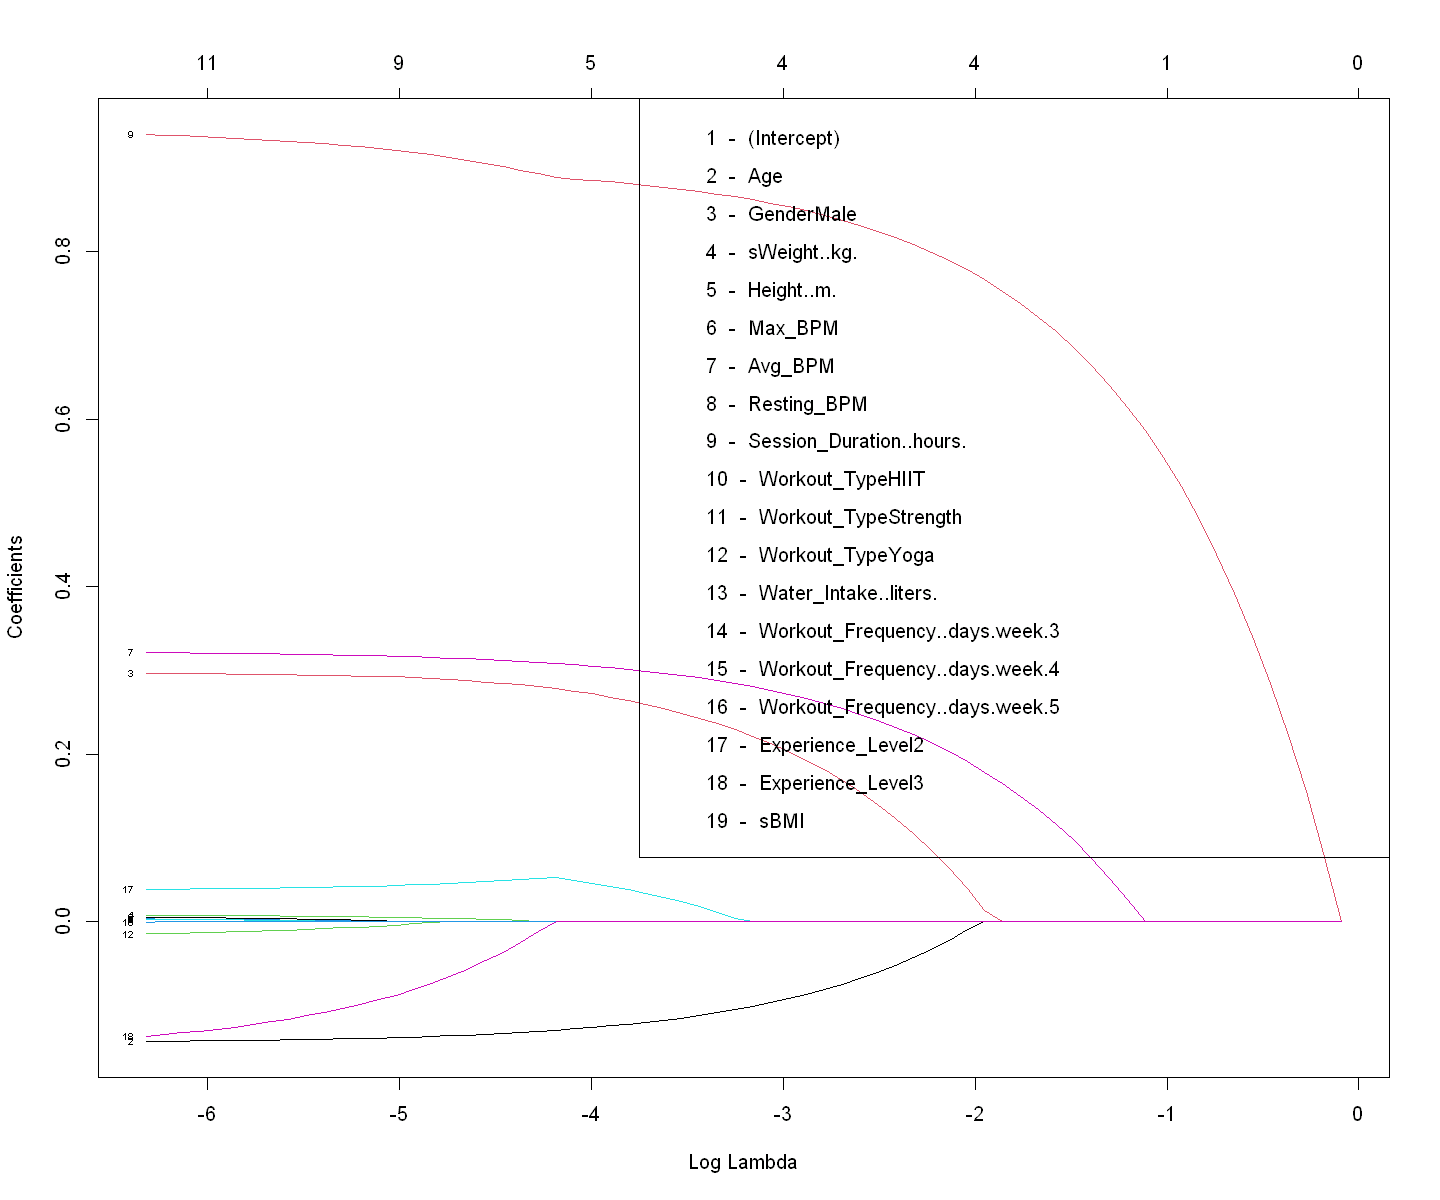

In [145]:
# model matrix permet de transformer les variables qualitatives en variables dummy
x.mat <- model.matrix(sCalories_Burned ~ . , data = datappr)
x.mat_test <- model.matrix(sCalories_Burned ~ . , data = datestr)

# on affiche les chemins de régularisation des variables lasso
reg.lasso <- glmnet(y = datappr$sCalories_Burned, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))

On voit que les coefficients gardés sont en partie les mêmes que ceux qui étaient jugés les plus importants par le modèle linéaire (dans l'ordre: age, genre, poids). Cependant, certaines variables comme la taille et le BPM maximal sont ici jugées plus importantes que le BPM moyen et la durée de la session qui étaient jugées plus importantes précèdement.

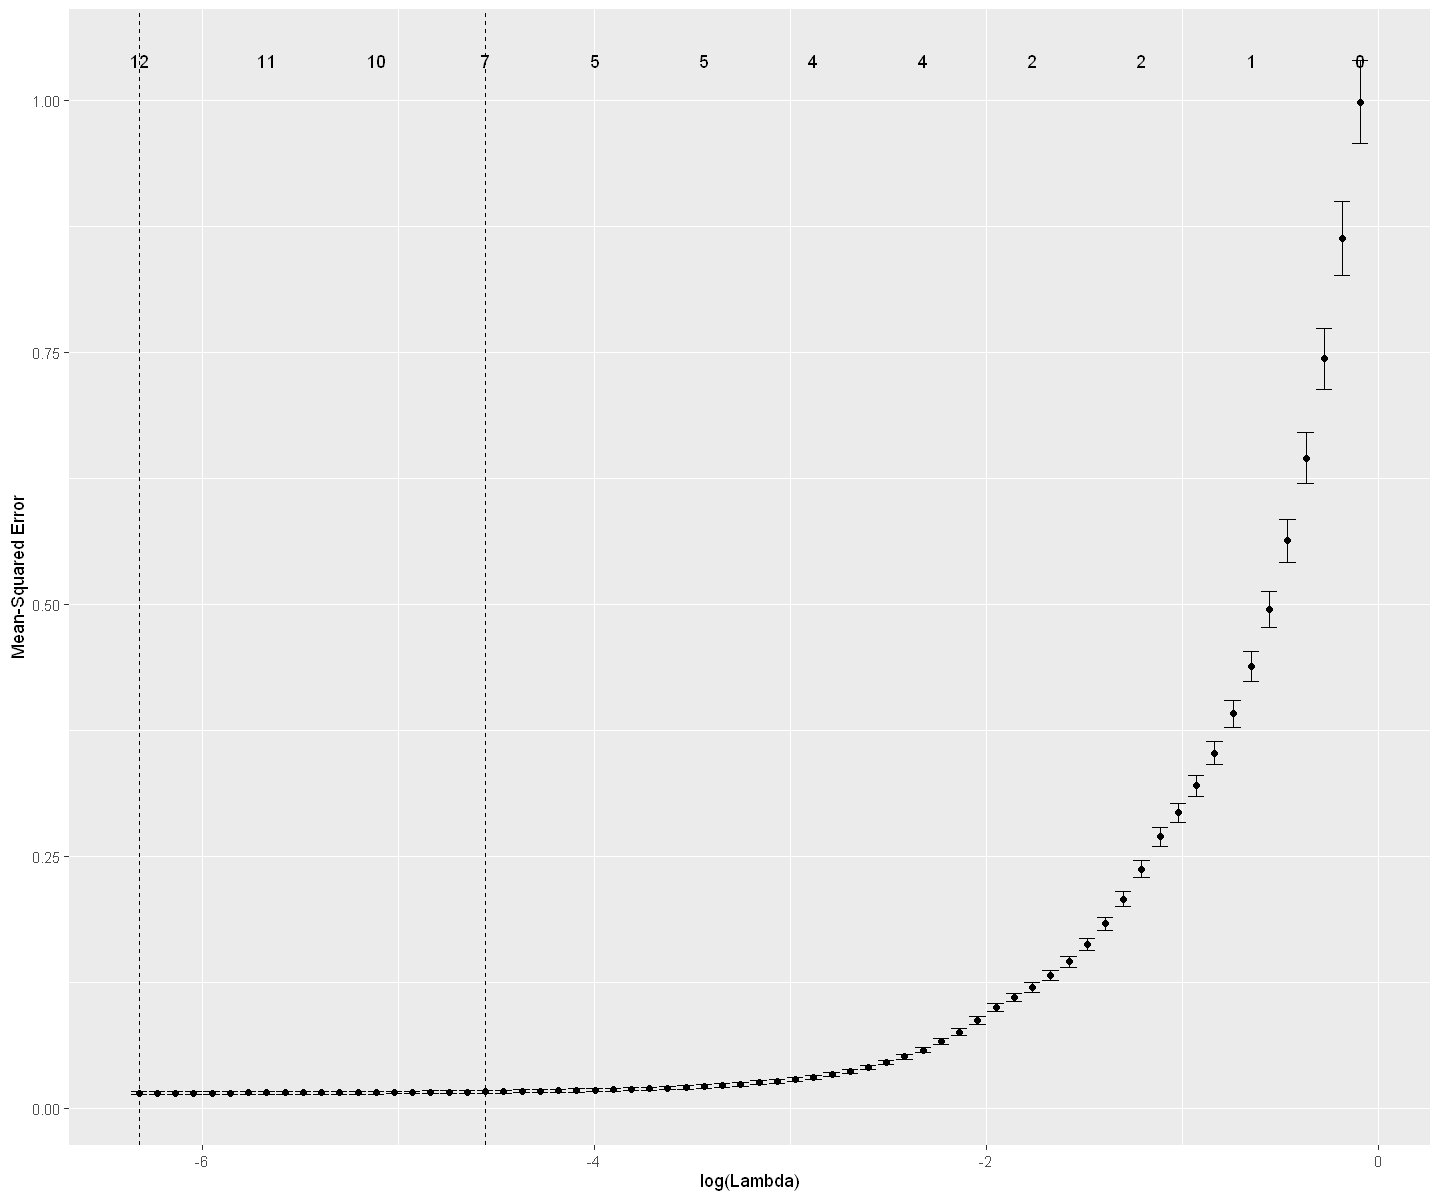

In [146]:
# On affiche ici le MSE du modèle en fonction de log(Lambda) sur les données d'apprentissage

reg.lasso.cv <- cv.glmnet(y = datappr$sCalories_Burned, x = x.mat)
autoplot(reg.lasso.cv)

On remarque que le modèle à de meilleurs résultats avec un coefficient lambda petit (log(lambda) entre -6 et -3 environ), c'est à dire en ayant un modèle proche du modèle linéaire. On peut donc questionner l'utilité d'utiliser la pénalisation lasso ici.

In [147]:
lambda_min <- reg.lasso.cv$lambda.min
y <- datappr$sCalories_Burned
modelmin <- glmnet(x = x.mat, y = y, lambda = lambda_min, standardize = FALSE)

y_pred_min <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)

rmse <- sqrt(mean((y - y_pred_min)^2))

ss_res <- sum((y - y_pred_min)^2)
ss_tot <- sum((y - mean(y))^2)
r2 <- 1 - ss_res / ss_tot

cat("Lambda:", lambda_min, "\n")
cat("RMSE:", round(rmse, 4), "\n")
cat("R²:", round(r2, 4), "\n")
print(coef(reg.lasso.cv, s = "lambda.min"))

Lambda: 0.001796301 
RMSE: 0.1212 
R²: 0.9853 
20 x 1 sparse Matrix of class "dgCMatrix"
                                          s1
(Intercept)                    -0.1427487431
(Intercept)                     .           
Age                            -0.1428537344
GenderMale                      0.2966135340
sWeight..kg.                    0.0079710330
Height..m.                      0.0032770306
Max_BPM                         0.0032450410
Avg_BPM                         0.3214589060
Resting_BPM                     0.0055978142
Session_Duration..hours.        0.9401380416
Workout_TypeHIIT                .           
Workout_TypeStrength            .           
Workout_TypeYoga               -0.0145618302
Water_Intake..liters.           .           
Workout_Frequency..days.week.3  .           
Workout_Frequency..days.week.4  .           
Workout_Frequency..days.week.5 -0.0004670638
Experience_Level2               0.0386113928
Experience_Level3              -0.1365000822
sBMI       

Le RMSE est très faiblement meilleur que pour le modèle linéaire et le R-square est un peu moins bon (mais cv.glmnet optimise lambda pour avoir le meilleur RMSE possible donc c'est cohérent). 

On conserve 13 coefficients non nuls

In [148]:
#On ré-itére en utilisant le lambda 1se qui est plus grand mais à une erreur similaire à un écart-type près, cela permet d'utiliser moins de variables

lambda_1se <- reg.lasso.cv$lambda.1se
model1se <- glmnet(x = x.mat, y = y, lambda = lambda_1se, standardize = FALSE)

y_pred_1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)

rmse <- sqrt(mean((y - y_pred_1se)^2))

ss_res <- sum((y - y_pred_1se)^2)
ss_tot <- sum((y - mean(y))^2)
r2 <- 1 - ss_res / ss_tot

cat("Lambda:", lambda_1se, "\n")
cat("RMSE:", round(rmse, 4), "\n")
cat("R²:", round(r2, 4), "\n")

print(coef(reg.lasso.cv, s = "lambda.1se"))

Lambda: 0.01052097 
RMSE: 0.1265 
R²: 0.984 
20 x 1 sparse Matrix of class "dgCMatrix"
                                         s1
(Intercept)                    -0.161818949
(Intercept)                     .          
Age                            -0.134455822
GenderMale                      0.286260944
sWeight..kg.                    0.002773115
Height..m.                      .          
Max_BPM                         .          
Avg_BPM                         0.313206927
Resting_BPM                     .          
Session_Duration..hours.        0.906183076
Workout_TypeHIIT                .          
Workout_TypeStrength            .          
Workout_TypeYoga                .          
Water_Intake..liters.           .          
Workout_Frequency..days.week.3  .          
Workout_Frequency..days.week.4  .          
Workout_Frequency..days.week.5  .          
Experience_Level2               0.047833324
Experience_Level3              -0.046772499
sBMI                            .

Les performances sont comparables bien que un peu moins bonne mais on utilise 5 coefficients de moins.

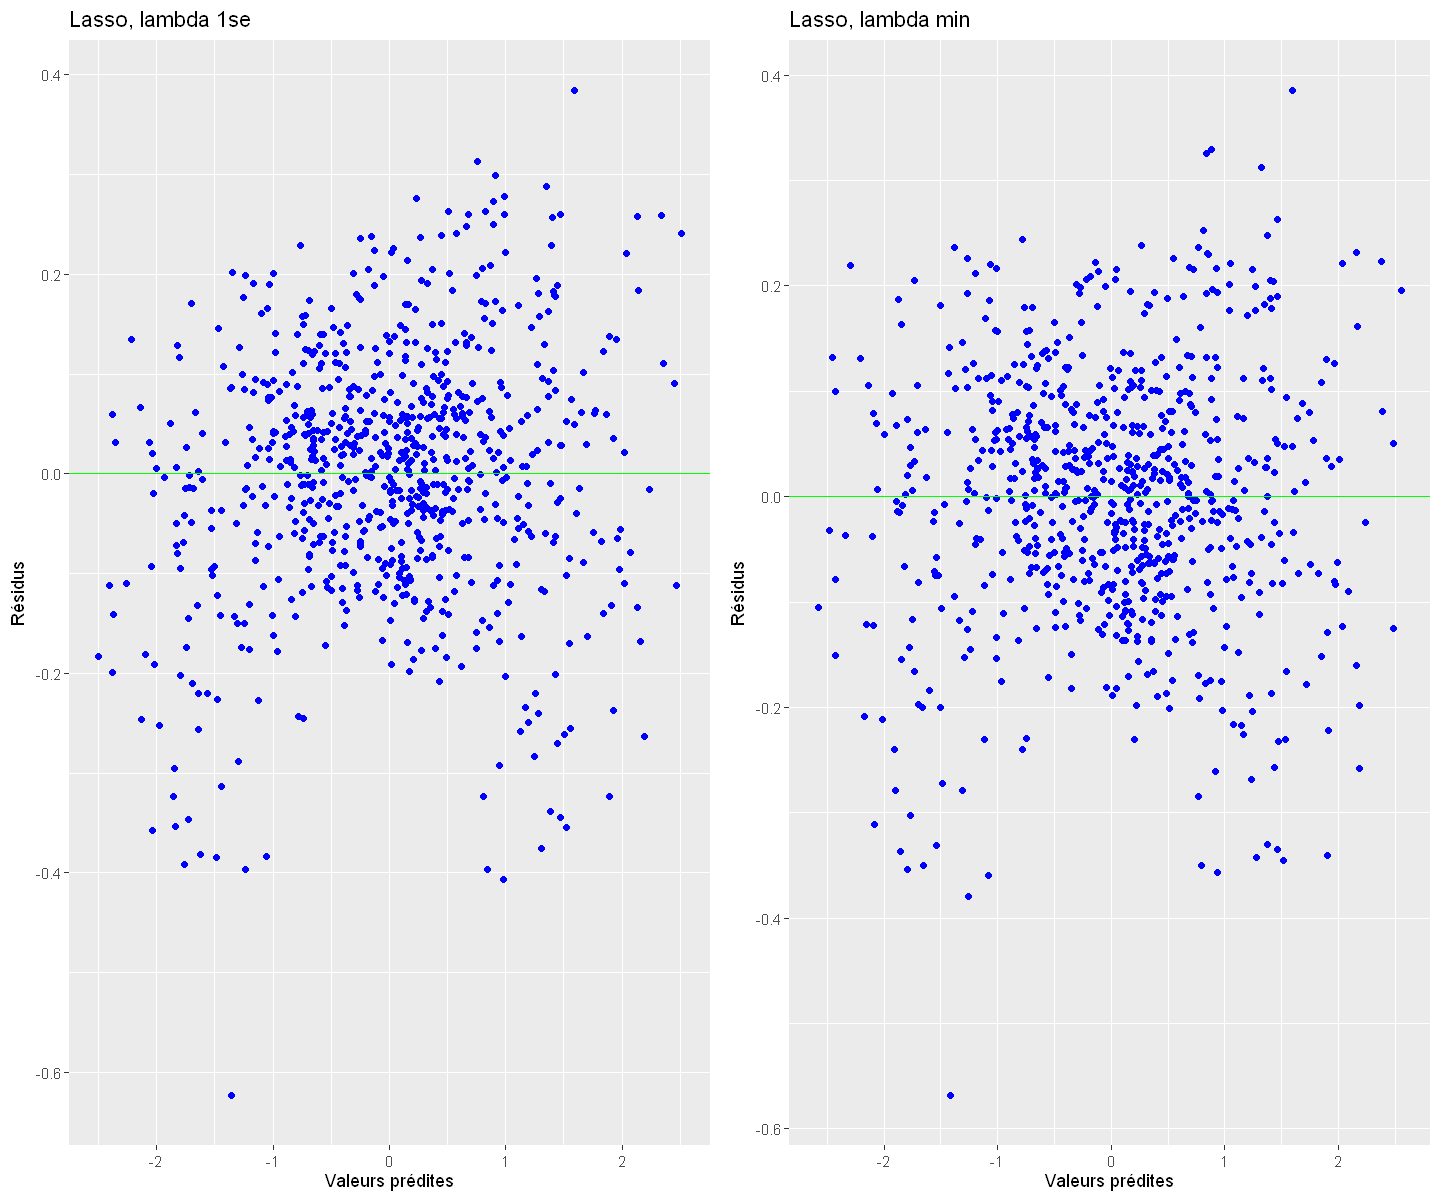

In [149]:
# Affichage des résidus:
res1se <- y - y_pred_1se
resmin <- y - y_pred_min

g1<-gplot.res(y_pred_1se, res1se, "Lasso, lambda 1se")
g2<-gplot.res(y_pred_min, resmin, "Lasso, lambda min")
grid.arrange(g1,g2,ncol=2)

### RMSE sur l'échantillon de test:

In [150]:
y_test <- datestr$sCalories_Burned

test_1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat_test)
test_min <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat_test)

rmse_1se <- sqrt(mean((y_test - test_1se)^2))
rmse_min <- sqrt(mean((y_test - test_min)^2))

cat("RMSE pour lambda.min :", rmse_min, "\n")
cat("RMSE pour lambda.1se :", rmse_1se, "\n")

RMSE pour lambda.min : 0.1281096 
RMSE pour lambda.1se : 0.1357074 


Comme attendu, les résultats sont un peu moins bon que sur les données d'apprentissage mais restent comparables

### modèle linéaire avec interactions d'ordre 2

On utilise ici un modèle linéaire avec les interactions d'ordre 2. On utilise la méthode backward pour la sélection des variables. On compare les résultats avec 2 critères différents: AIC et BIC

In [151]:
# Modèle avec toutes les interactions d'ordre 2
reg.glm <- glm(sCalories_Burned ~ .^2, data = datappr)

# Selection de modèle backward avec AIC:
reg.glm.step.aic <- step(reg.glm, direction = "backward")

Start:  AIC=-1327.56
sCalories_Burned ~ (Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI)^2


Step:  AIC=-1327.56
sCalories_Burned ~ Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI + Age:Gender + Age:sWeight..kg. + 
    Age:Height..m. + Age:Max_BPM + Age:Avg_BPM + Age:Resting_BPM + 
    Age:Session_Duration..hours. + Age:Workout_Type + Age:Water_Intake..liters. + 
    Age:Workout_Frequency..days.week. + Age:Experience_Level + 
    Age:sBMI + Gender:sWeight..kg. + Gender:Height..m. + Gender:Max_BPM + 
    Gender:Avg_BPM + Gender:Resting_BPM + Gender:Session_Duration..hours. + 
    Gender:Workout_Type + Gender:Water_Intake..liters. + Gender:Workout_Frequency..da

In [152]:
n <- nrow(datappr)
# Selection de modèle avec BIC:
reg.glm.step.bic <- step(reg.glm, direction = "backward", k = log(n))


Start:  AIC=-596.45
sCalories_Burned ~ (Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI)^2


Step:  AIC=-596.45
sCalories_Burned ~ Age + Gender + sWeight..kg. + Height..m. + 
    Max_BPM + Avg_BPM + Resting_BPM + Session_Duration..hours. + 
    Workout_Type + Water_Intake..liters. + Workout_Frequency..days.week. + 
    Experience_Level + sBMI + Age:Gender + Age:sWeight..kg. + 
    Age:Height..m. + Age:Max_BPM + Age:Avg_BPM + Age:Resting_BPM + 
    Age:Session_Duration..hours. + Age:Workout_Type + Age:Water_Intake..liters. + 
    Age:Workout_Frequency..days.week. + Age:Experience_Level + 
    Age:sBMI + Gender:sWeight..kg. + Gender:Height..m. + Gender:Max_BPM + 
    Gender:Avg_BPM + Gender:Resting_BPM + Gender:Session_Duration..hours. + 
    Gender:Workout_Type + Gender:Water_Intake..liters. + Gender:Workout_Frequency..days

In [153]:
# Coefficients AIC
anova(reg.glm.step.aic, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,777,777.000000,NA,NA
Age,1,1.751784e+01,776,759.482165,2.070466e+03,2.524902e-213
Gender,1,1.388761e+01,775,745.594551,1.641404e+03,2.443641e-187
sWeight..kg.,1,1.481974e-02,774,745.579731,1.751574e+00,1.861020e-01
Height..m.,1,6.123356e-02,773,745.518498,7.237312e+00,7.307037e-03
Max_BPM,1,2.649288e-01,772,745.253569,3.131244e+01,3.130616e-08
Avg_BPM,1,1.006615e+02,771,644.592093,1.189737e+04,0.000000e+00
Resting_BPM,1,5.665400e-01,770,644.025553,6.696044e+01,1.267432e-15
Session_Duration..hours.,1,6.302510e+02,769,13.774542,7.449057e+04,0.000000e+00


In [154]:
# Coefficients BIC
anova(reg.glm.step.bic, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,777,777.000000,NA,NA
Age,1,17.51783506,776,759.482165,1892.209073,1.095555e-208
Gender,1,13.88761407,775,745.594551,1500.086583,3.210392e-182
Avg_BPM,1,100.18180197,774,645.412749,10821.252395,0.000000e+00
Resting_BPM,1,0.51921606,773,644.893533,56.083719,1.924395e-13
Session_Duration..hours.,1,631.06121916,772,13.832314,68164.802337,0.000000e+00
Experience_Level,2,2.32619647,770,11.506117,125.633391,6.983516e-48
sBMI,1,0.02523429,769,11.480883,2.725711,9.915620e-02
Age:Session_Duration..hours.,1,0.33040794,768,11.150475,35.689393,3.550080e-09


Le nombre de coefficients sélectionnés par le critère est bien plus faible (ce qui est logique car log(n)>2 ici, la pénalisation est donc plus forte pour BIC).

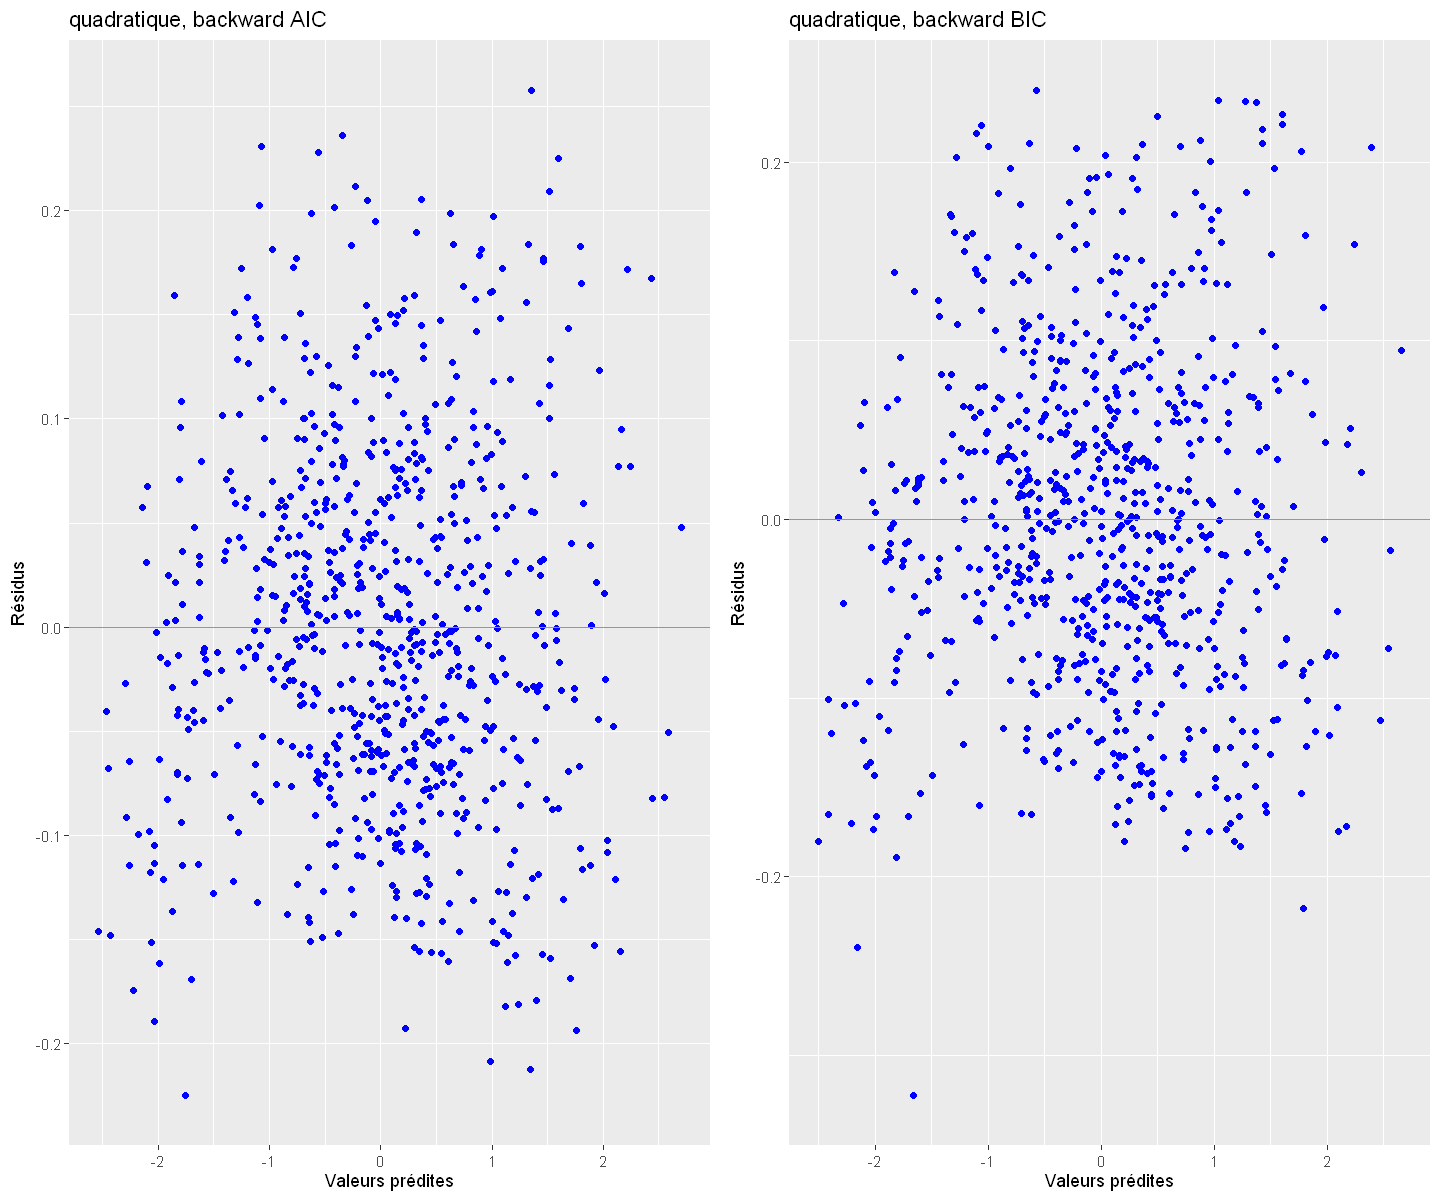

In [155]:
# Extraction des valeurs ajustées et des résidus
fit.glm.aic <- reg.glm.step.aic$fitted.values
res.glm.aic <- reg.glm.step.aic$residuals
fit.glm.bic <- reg.glm.step.bic$fitted.values
res.glm.bic <- reg.glm.step.bic$residuals


# Graphe des résidus
g1<-gplot.res(fit.glm.aic, res.glm.aic, "quadratique, backward AIC")
g2<-gplot.res(fit.glm.bic, res.glm.bic, "quadratique, backward BIC")
grid.arrange(g1,g2,ncol=2)

### RMSE sur l'échantillon de test:

In [156]:
# Comparaison des RMSE:

y_test <- datestr$sCalories_Burned

test_aic <- predict(reg.glm.step.aic, newdata  = datestr)
test_bic <- predict(reg.glm.step.bic, newdata  = datestr)

rmse_aic <- sqrt(mean((y_test - test_aic)^2))
rmse_bic <- sqrt(mean((y_test - test_bic)^2))

cat("RMSE pour AIC :", rmse_aic, "\n")
cat("RMSE pour BIC :", rmse_bic, "\n")

RMSE pour AIC : 0.1063492 
RMSE pour BIC : 0.09793335 


Les résultats sont meilleurs que pour le modèle linéaire classique ou celui avec pénalisation lasso. Cependant les modèles sont plus complexes

On remarque aussi que le modèle dont on a fait la sélection en suivant le critère BIC est meilleur alors qu'il utilise beaucoup moins de variables. Il est donc préférable de l'utiliser.

## 2.1.3 Régression par SVM

On réalise une SVM sur les données pour la regression, on commence par rechercher les paramètres optimaux:

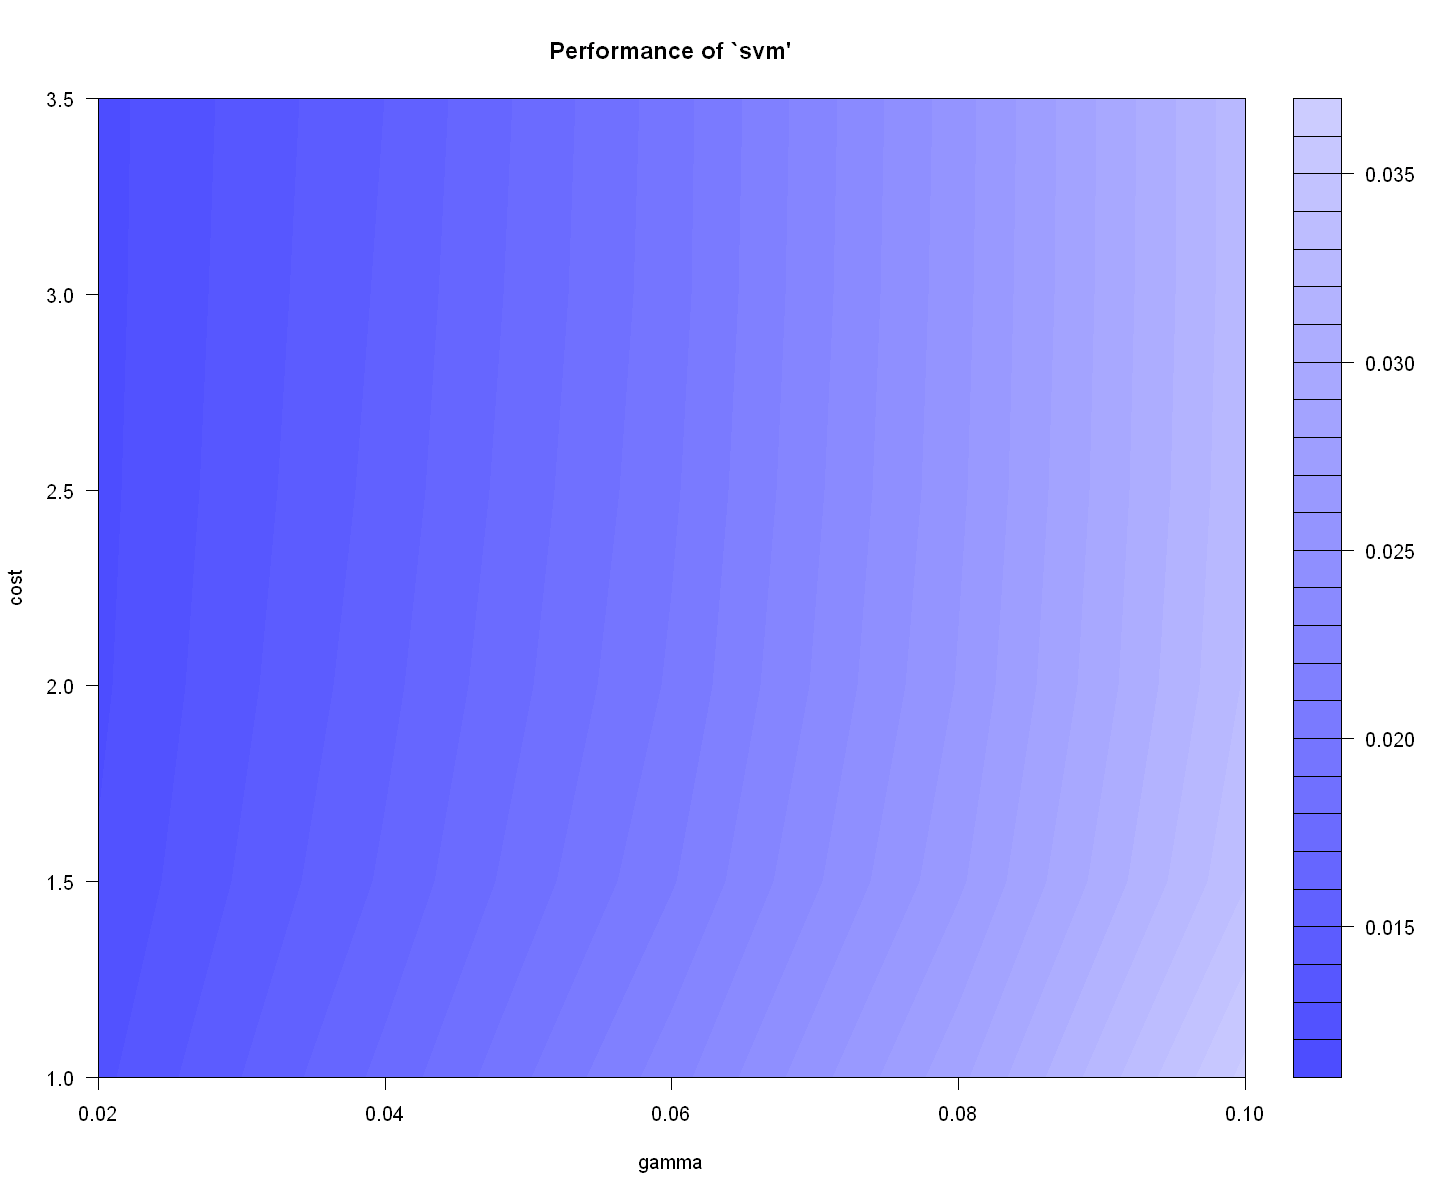

In [157]:
# Recherche des paramètres optimaux pour gamma et le coût (RMSE minimal):

svm.reg.tune = tune.svm(sCalories_Burned ~ ., data = datappr, cost = c(1, 1.5, 2, 2.5, 3, 3.5), 
    gamma = seq(0.02, 0.1, by = 0.02))
plot(svm.reg.tune)

# Le paramètre de coût est la paramètre de pénalisation et le paramètre gamma détermine l'influence des points

In [158]:
# On fit le modèle avec les paramètres optimisés pour RMSE:

svm.reg = svm(sCalories_Burned ~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)
summary(svm.reg)


Call:
svm(formula = sCalories_Burned ~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  3.5 
      gamma:  0.02 
    epsilon:  0.1 


Number of Support Vectors:  259






Les paramètres optimaux utilisés sont: cost = 3.5, gamma = 0.02

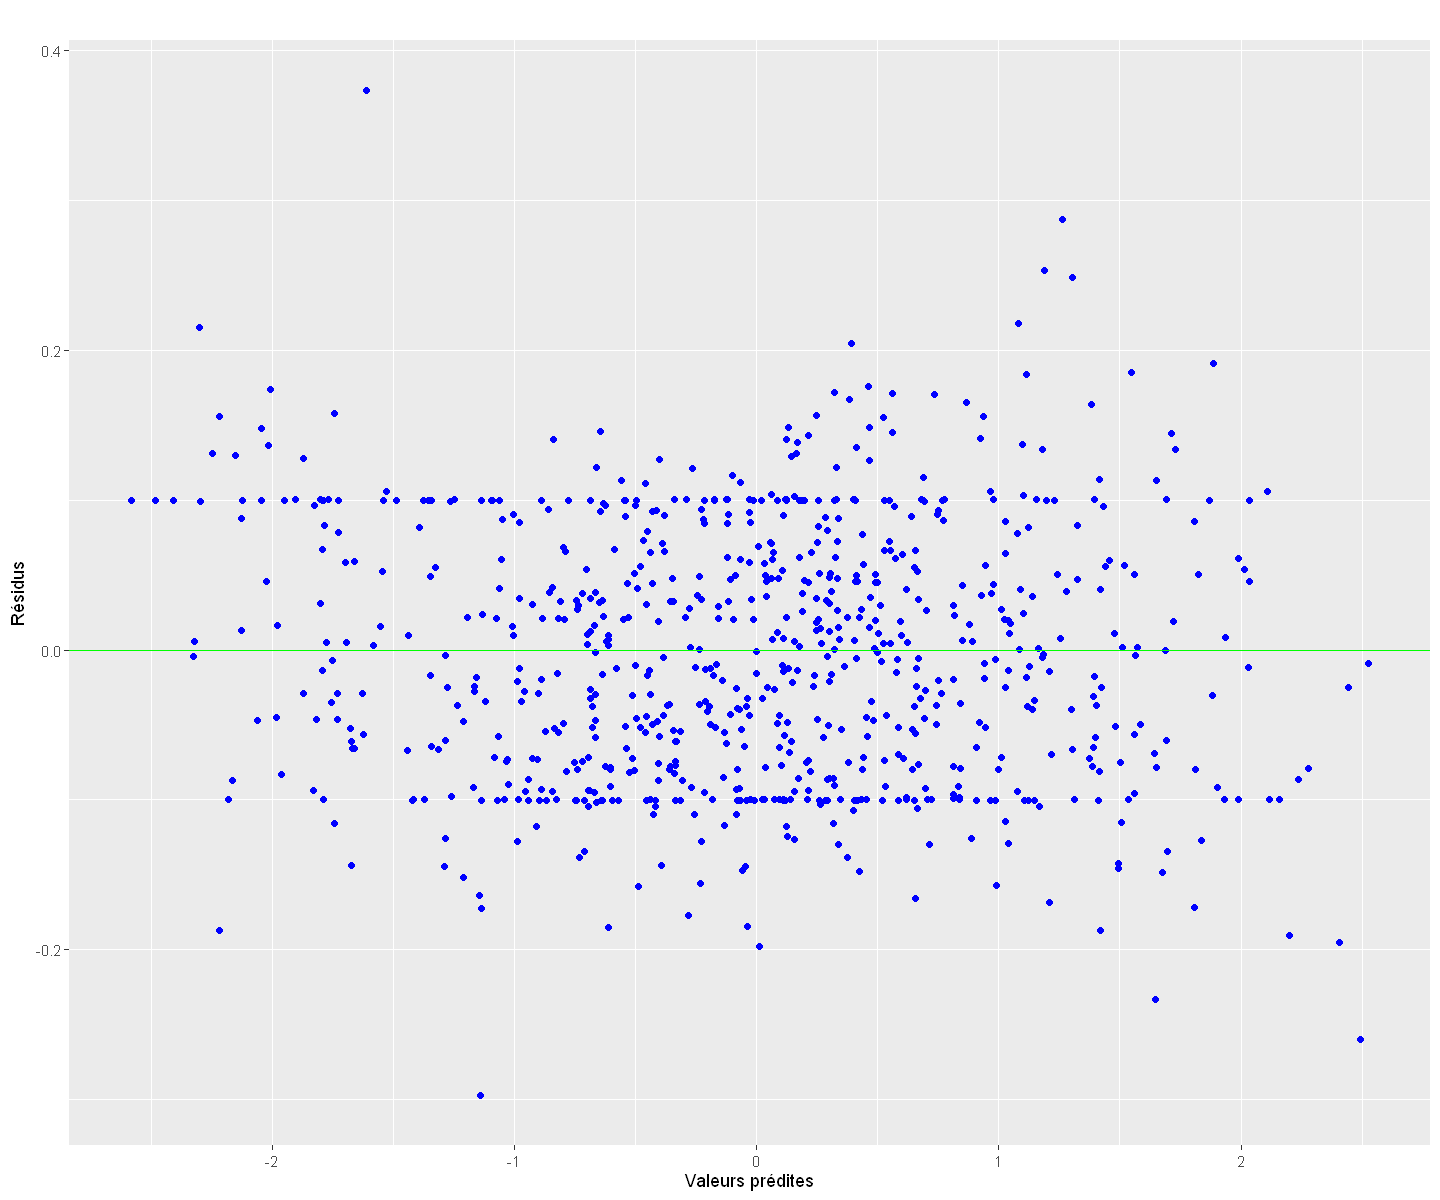

In [159]:
# Affichage des résidus
fit.svmr=fit.svmr=svm.reg$fitted
res.svmr=fit.svmr-datappr[,"sCalories_Burned"]
gplot.res(fit.svmr,res.svmr,titre="")

### RMSE sur l'échantillon de test:

In [160]:
test_svmr <- predict(svm.reg,newdata=datestr)

rmse_svmr <- sqrt(mean((y_test - test_svmr)^2))

cat("RMSE pour SVMR :", rmse_svmr, "\n")

RMSE pour SVMR : 0.1102439 


## 2.1.4 CART pour régression

Pour obtenir un arbre CART qui ne soit pas sur-entraîné on fait de la validation croisé sur l'échantillon d'apprentissage:

On optimise le paramètre de complexité cp

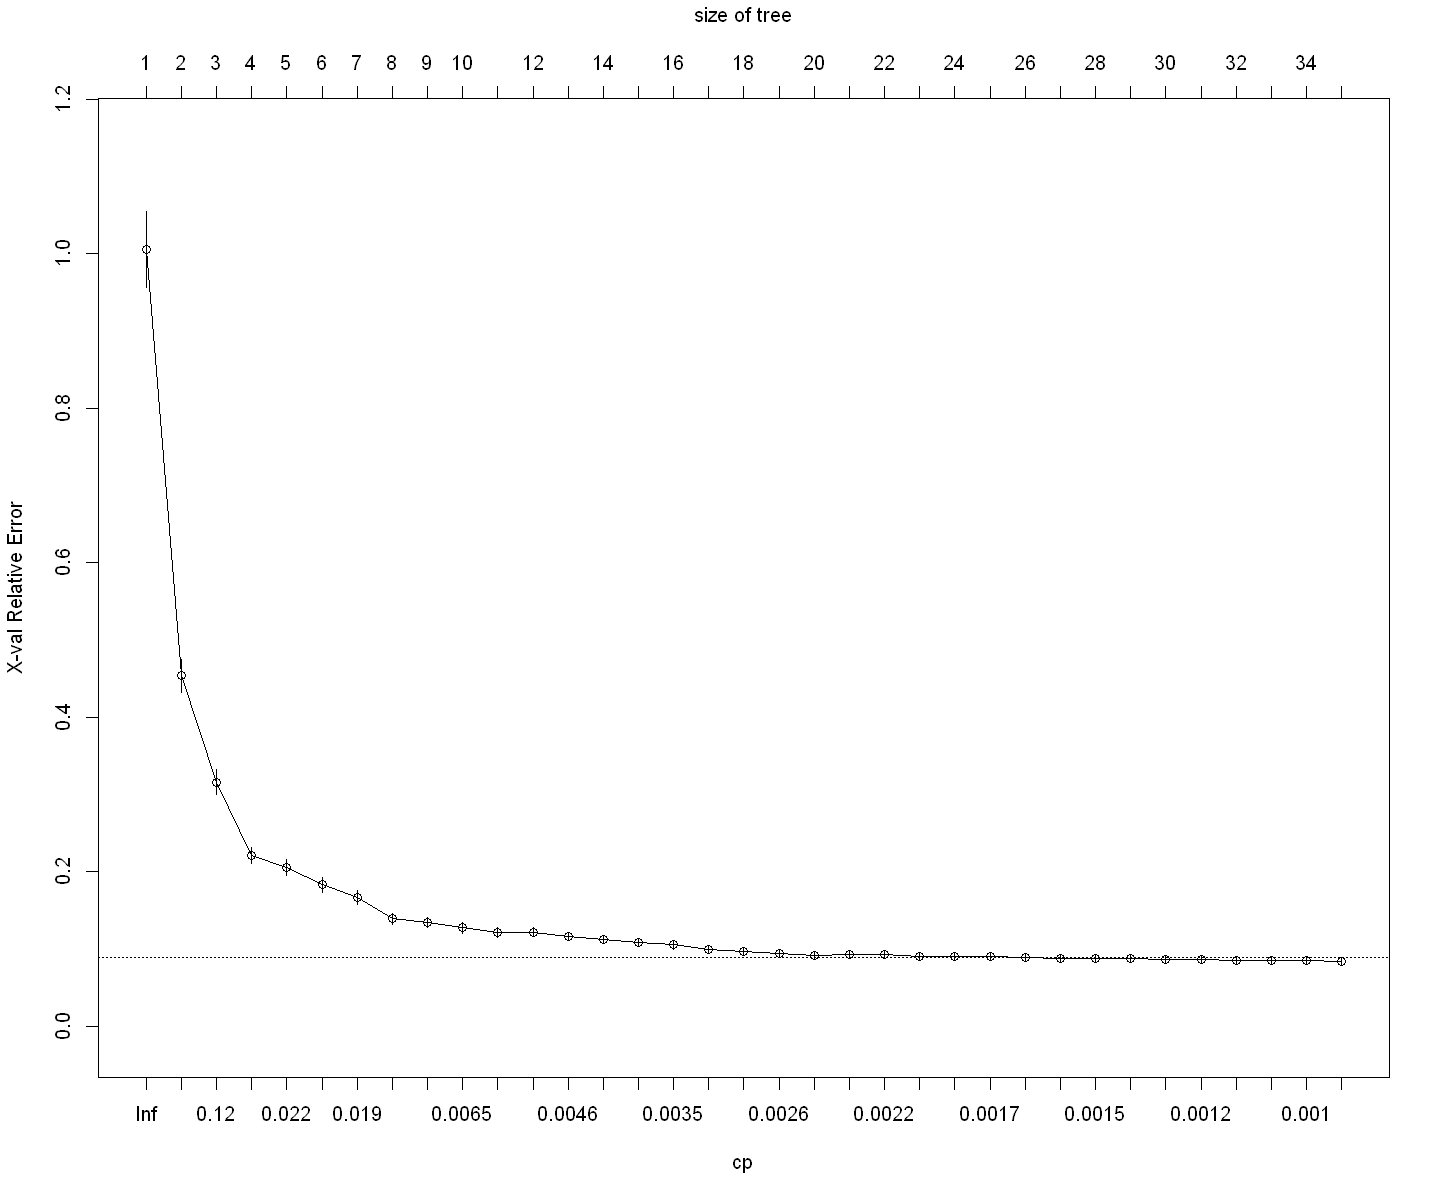

In [161]:
tree.reg=rpart(sCalories_Burned~.,data=datappr,control=rpart.control(cp=0.001))

# entrainement par validation croisée
xmat<-xpred.rpart(tree.reg,xval=10) 
CVerr<-apply((xmat-datappr[,"sCalories_Burned"])^2,2,sum)

# affichage de l'erreur selon la taille de l'arbre
plotcp(tree.reg)

les arbres avec les meilleurs résultats semblent être les arbres complexes.

cp optimal : 0.001010204 


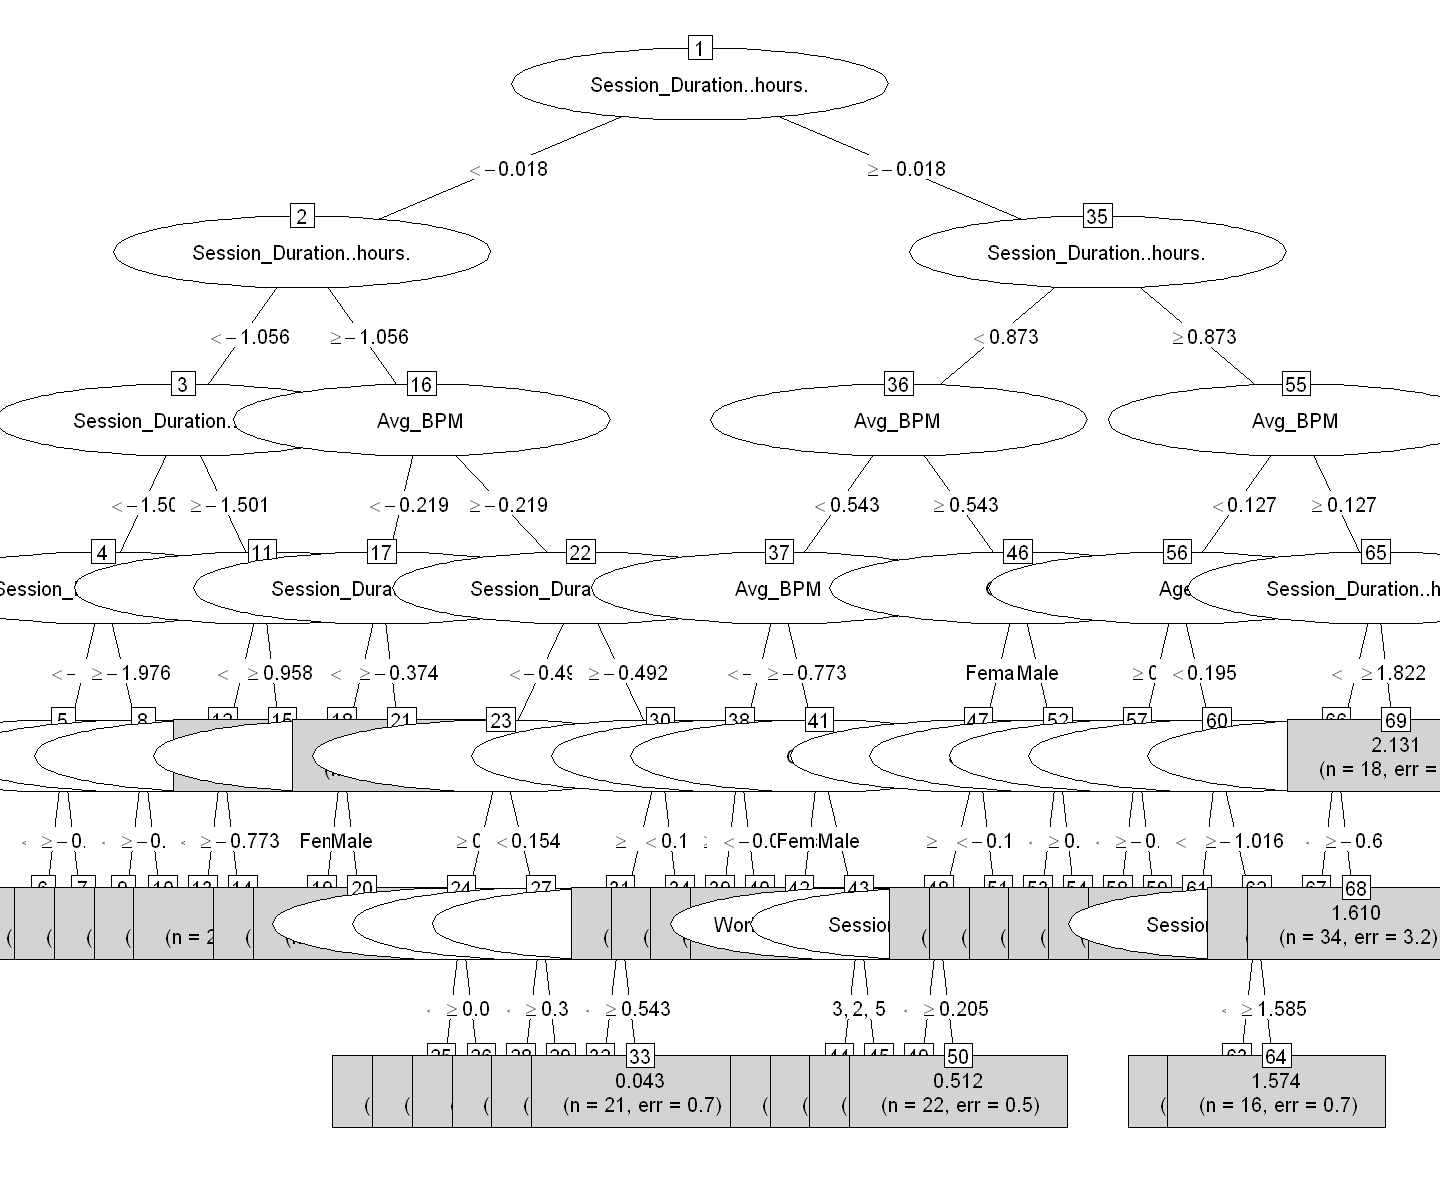

In [162]:
# On utilise la valeur de cp qui donne la plus petite erreur:

cp.opt = as.numeric(attributes(which.min(CVerr))$names)

cat("cp optimal :", cp.opt, "\n")
tree.reg=rpart(sCalories_Burned~.,data=datappr,control=rpart.control(cp=cp.opt))

# affichage plus clair avec partykit (l'arbre reste illisible mais vu la taille il est difficile de faire mieux)
plot(as.party(tree.reg), type="simple")

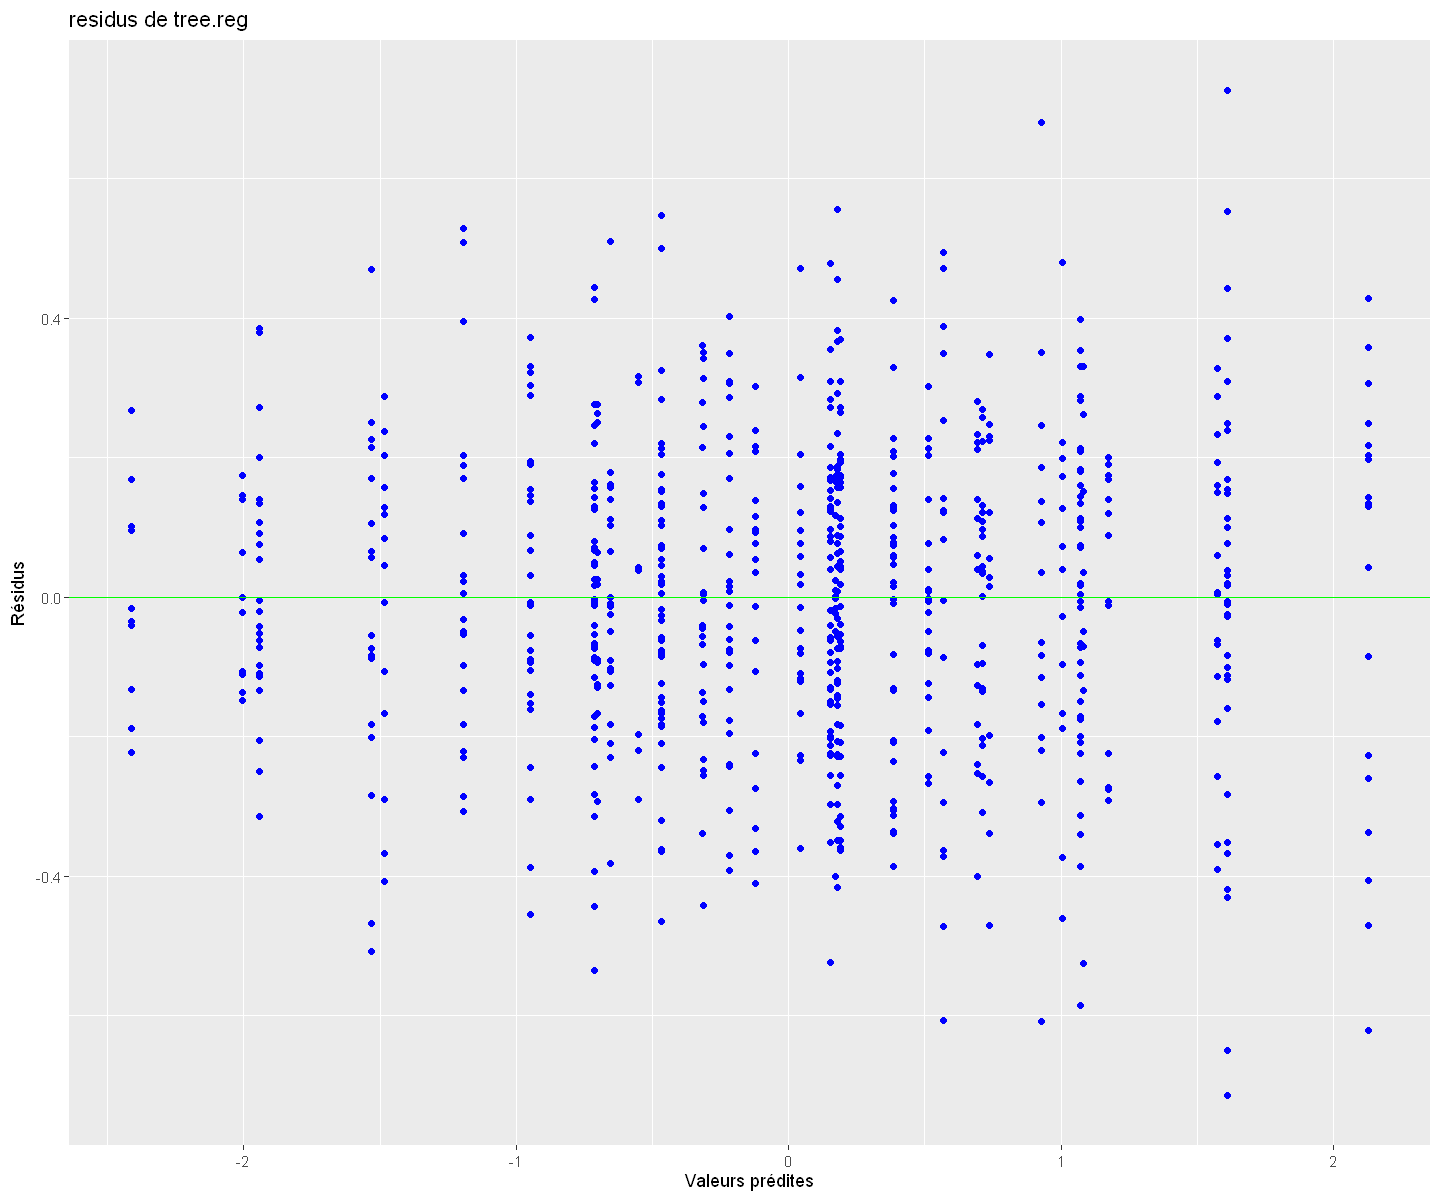

In [163]:
# On affiche les résidus de l'arbre, on retrouve la structure caractéristique des résidus de CART avec des lignes verticales qui correspondent aux différentes feuilles
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"sCalories_Burned"]
gplot.res(fit.tree,res.tree,"residus de tree.reg")

### RMSE sur l'échantillon de test:

In [164]:
test_tree <- predict(tree.reg,newdata=datestr)

rmse_tree <- sqrt(mean((y_test - test_tree)^2))

cat("RMSE pour CART :", rmse_tree, "\n")

RMSE pour CART : 0.2903536 


Le résultat est mauvais en comparasion des méthodes précédentes, on va utiliser l'aggrégation de modèles pour améliorer ce résultat

## 2.1.5 Agrégation des modèles: 

## Random forest

In [165]:
#modèle random forest

rf.reg=randomForest(sCalories_Burned~., data=datappr,xtest=datestr[,-9],ytest=datestr[,"sCalories_Burned"],
   ntree=500,do.trace=50,importance=TRUE)

rf.reg$mtry

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |  0.05401     5.41 |  0.04234     4.26 |
 100 |  0.04905     4.91 |  0.03886     3.91 |
 150 |  0.04645     4.65 |  0.03759     3.78 |
 200 |  0.04647     4.65 |  0.03777     3.80 |
 250 |  0.04686     4.69 |  0.03895     3.92 |
 300 |  0.04672     4.68 |  0.03938     3.96 |
 350 |  0.04675     4.68 |  0.03905     3.93 |
 400 |  0.04684     4.69 |  0.03868     3.89 |
 450 |  0.04692     4.70 |  0.03848     3.87 |
 500 |  0.04688     4.69 |  0.03889     3.91 |


[1] 4

Meilleur mtry : 13 


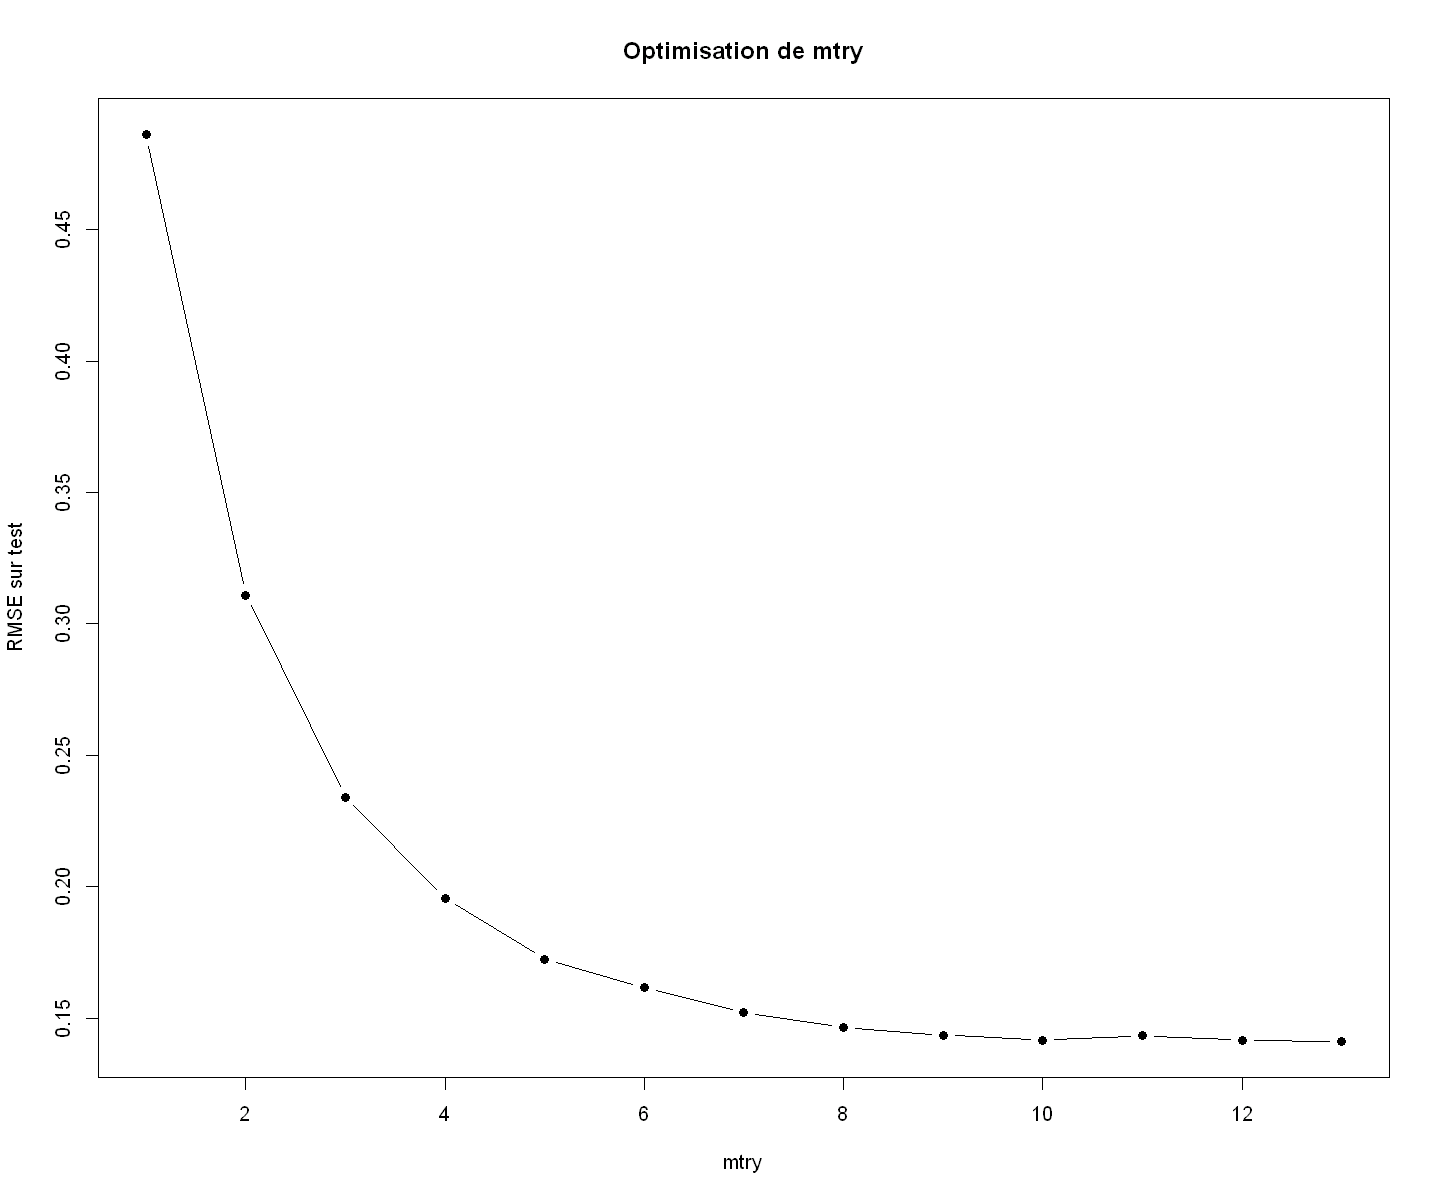

In [166]:
# Optimisation de mtry (nombre de variables pour le split)

p <- ncol(datappr) - 1
mtry.values <- 1:p
rmse.values <- numeric(length(mtry.values))

x_test <- datestr[,-9]

for (i in seq_along(mtry.values)) {
  rf.temp <- randomForest(
    sCalories_Burned ~ ., data = datappr,
    mtry = mtry.values[i], ntree = 500
  )
  
  preds <- predict(rf.temp, newdata = x_test)
  rmse.values[i] <- sqrt(mean((y_test - preds)^2))
}

plot(mtry.values, rmse.values, type = "b", pch = 19,
     xlab = "mtry", ylab = "RMSE sur test", main = "Optimisation de mtry")

best.mtry <- mtry.values[which.min(rmse.values)]
cat("Meilleur mtry :", best.mtry, "\n")

In [167]:
rf.reg.opt=randomForest(sCalories_Burned~., data=datappr,xtest=datestr[,-9],ytest=datestr[,"sCalories_Burned"],
   ntree=500,do.trace=50,importance=TRUE,mtry=12)

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |  0.02554     2.56 |  0.02047     2.06 |
 100 |  0.02438     2.44 |  0.02127     2.14 |
 150 |  0.02374     2.38 |  0.02121     2.13 |
 200 |  0.02341     2.34 |  0.02075     2.09 |
 250 |  0.02346     2.35 |  0.02102     2.11 |
 300 |  0.02336     2.34 |  0.02102     2.11 |
 350 |   0.0232     2.32 |  0.02082     2.09 |
 400 |  0.02316     2.32 |  0.02068     2.08 |
 450 |  0.02306     2.31 |  0.02046     2.06 |
 500 |    0.023     2.30 |  0.02028     2.04 |


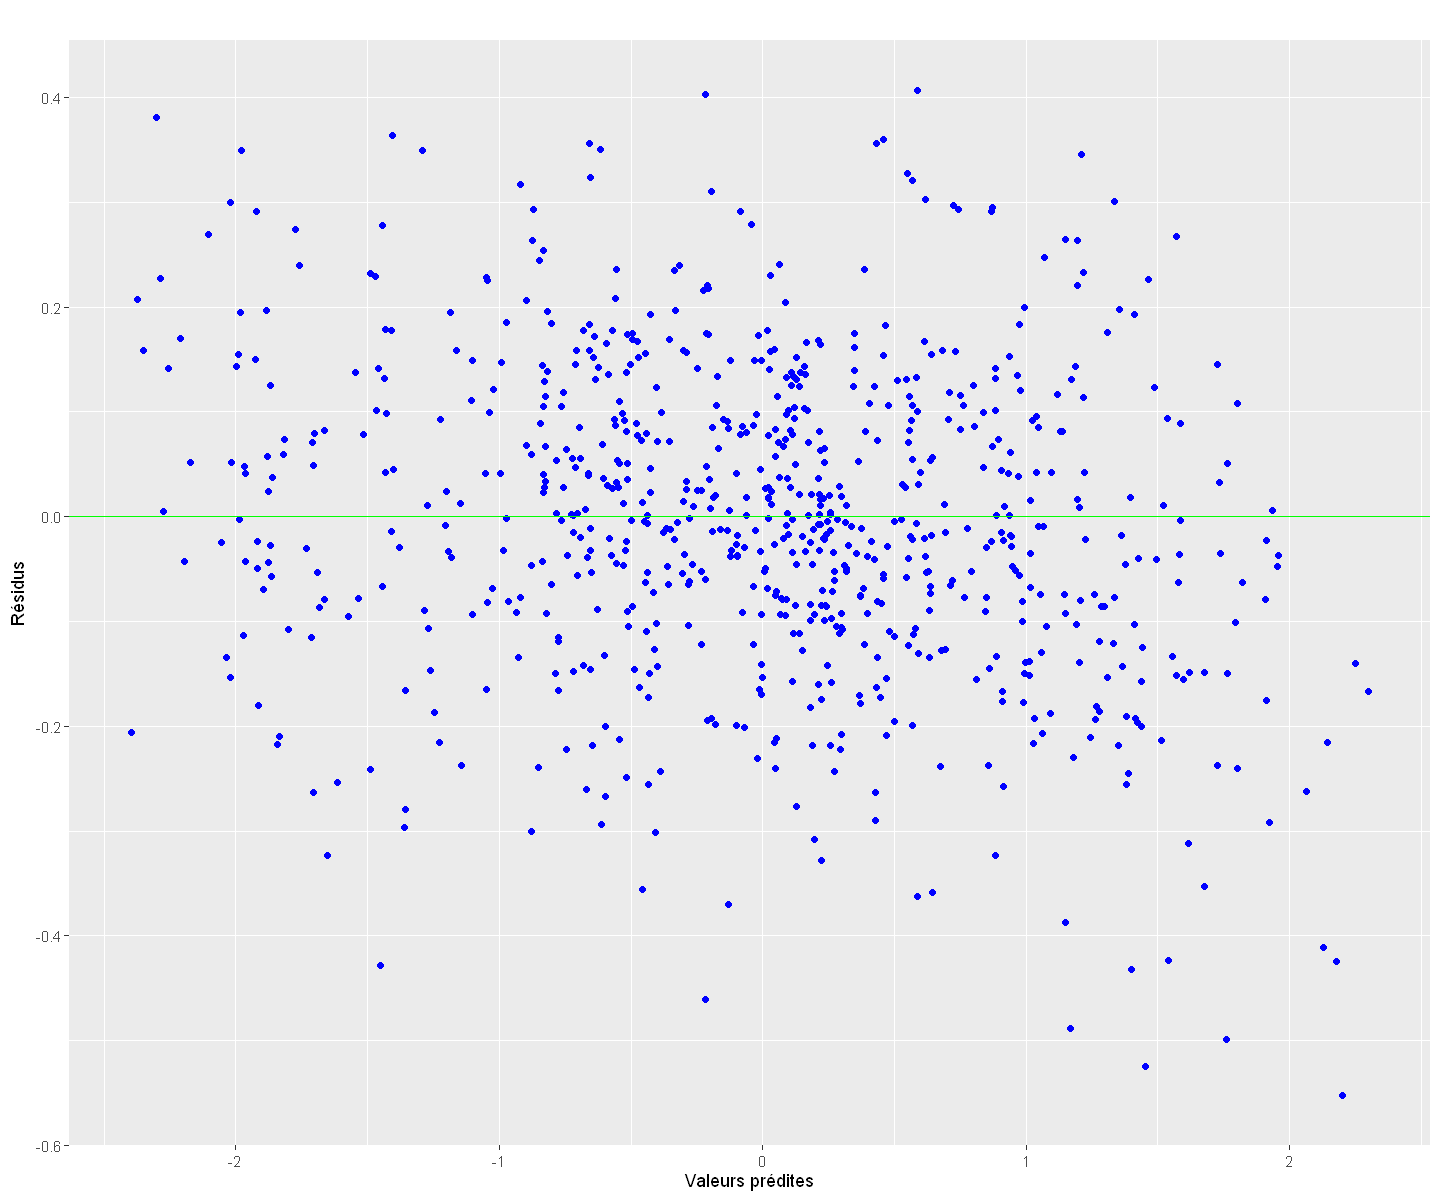

In [168]:
#Affichage des résidus

fit.rfr=rf.reg.opt$predicted
res.rfr=fit.rfr-y
gplot.res(fit.rfr,res.rfr,titre="")

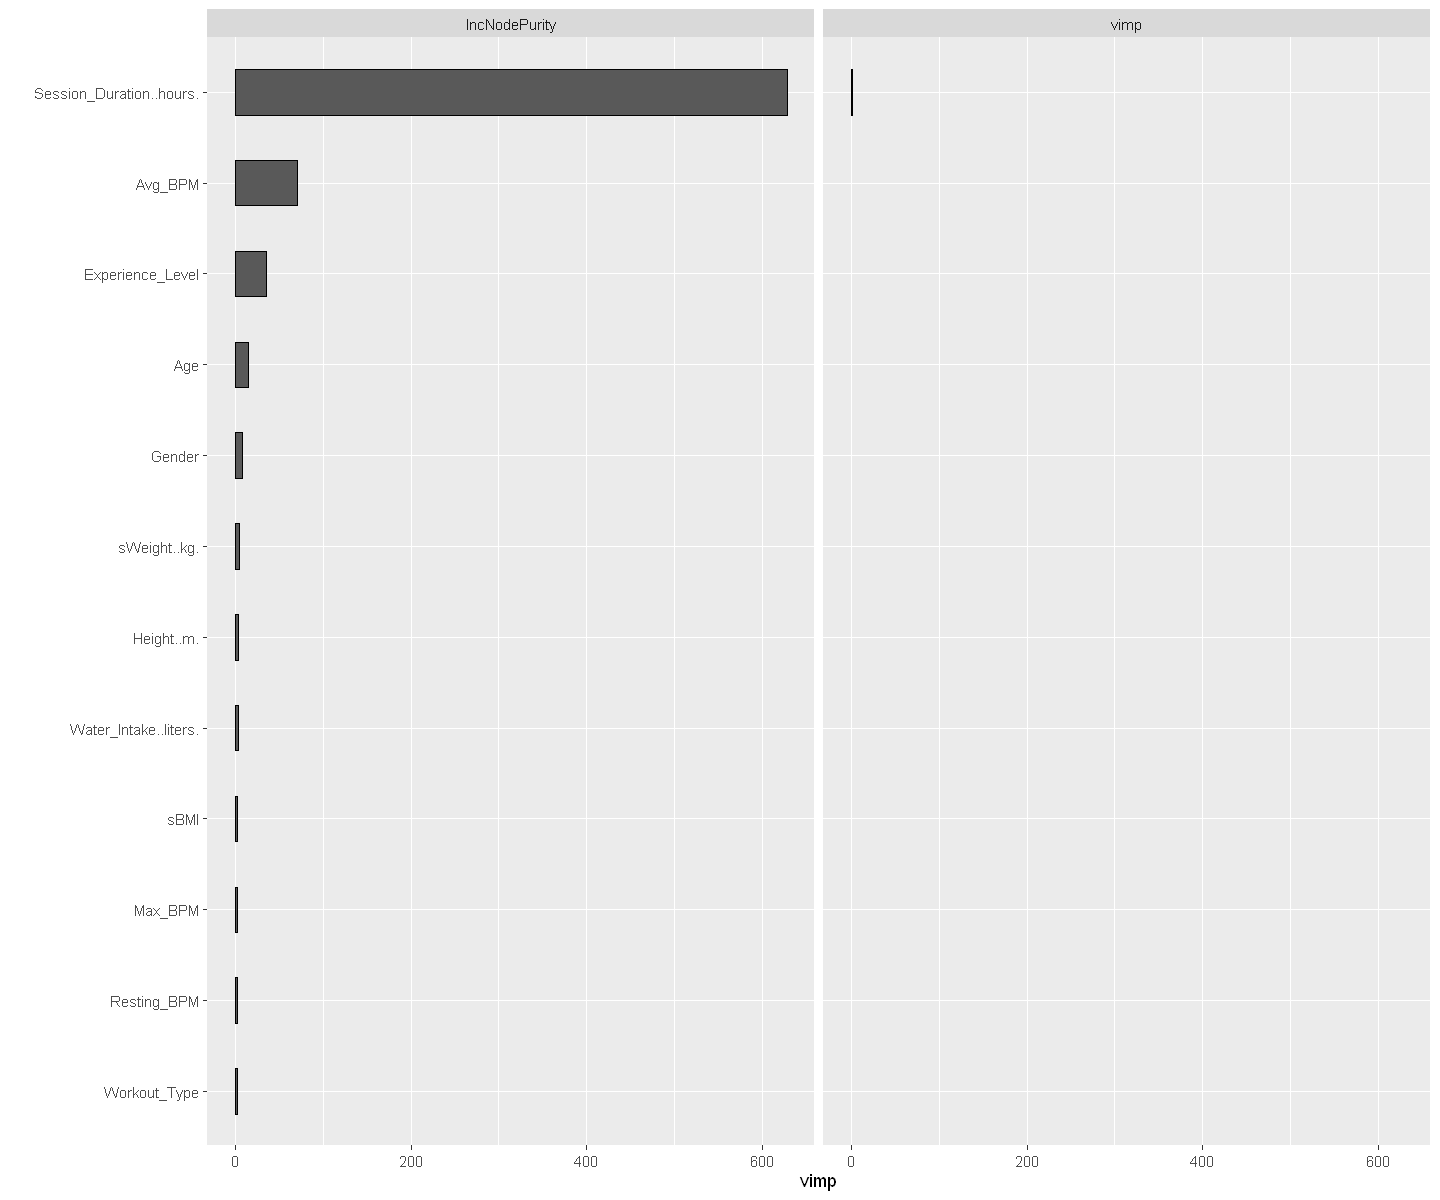

In [169]:
# Importance des variables

plot(gg_vimp(rf.reg.opt))

Les variables qui se dégagent sont durée de la session, le bpm moyen et le niveau d'expérience.

### RMSE sur l'échantillon de test:

In [170]:
test_forest <- rf.reg.opt$test$predicted

rmse_forest <- sqrt(mean((y_test - test_forest)^2))

cat("RMSE pour random forest :", rmse_forest, "\n")

RMSE pour random forest : 0.142399 


Le résultat est bien meilleur qu'avec un arbre seul

## Boosting

In [171]:
# On optimise le paramètre de shrinkage et le nombre d'arbres:

shrinkages <- c(0.1, 0.05, 0.03, 0.01)
n.trees.max <- 1000
cv.folds <- 10

results <- data.frame(
  shrinkage = numeric(),
  best.iter = integer(),
  rmse = numeric()
)

for (s in shrinkages) {
  
  boost.model <- gbm( sCalories_Burned ~ ., data = datappr, distribution = "gaussian", n.trees = n.trees.max, shrinkage = s, cv.folds = cv.folds, verbose = FALSE)
  
  best.iter <- gbm.perf(boost.model, method = "cv", plot.it = FALSE)
  
  pred <- predict(boost.model, newdata = datestr, n.trees = best.iter)
  
  rmse <- sqrt(mean((datestr$sCalories_Burned - pred)^2))
  
  results <- rbind(results, data.frame(shrinkage = s, best.iter = best.iter, rmse = rmse))
}

print(results)

meilleur <- results[which.min(results$rmse), ]

boost.reg <- gbm( sCalories_Burned ~ ., data = datappr, distribution = "gaussian",  n.trees = meilleur$best.iter, shrinkage = meilleur$shrinkage, cv.folds = cv.folds, verbose = FALSE)

  shrinkage best.iter       rmse
1      0.10       979 0.09734115
2      0.05       992 0.10567278
3      0.03      1000 0.10106505
4      0.01      1000 0.15301697


Les résultats de l'optimisation sont très versatiles. Selon l'execution les paramètres choisis ne sont pas les mêmes

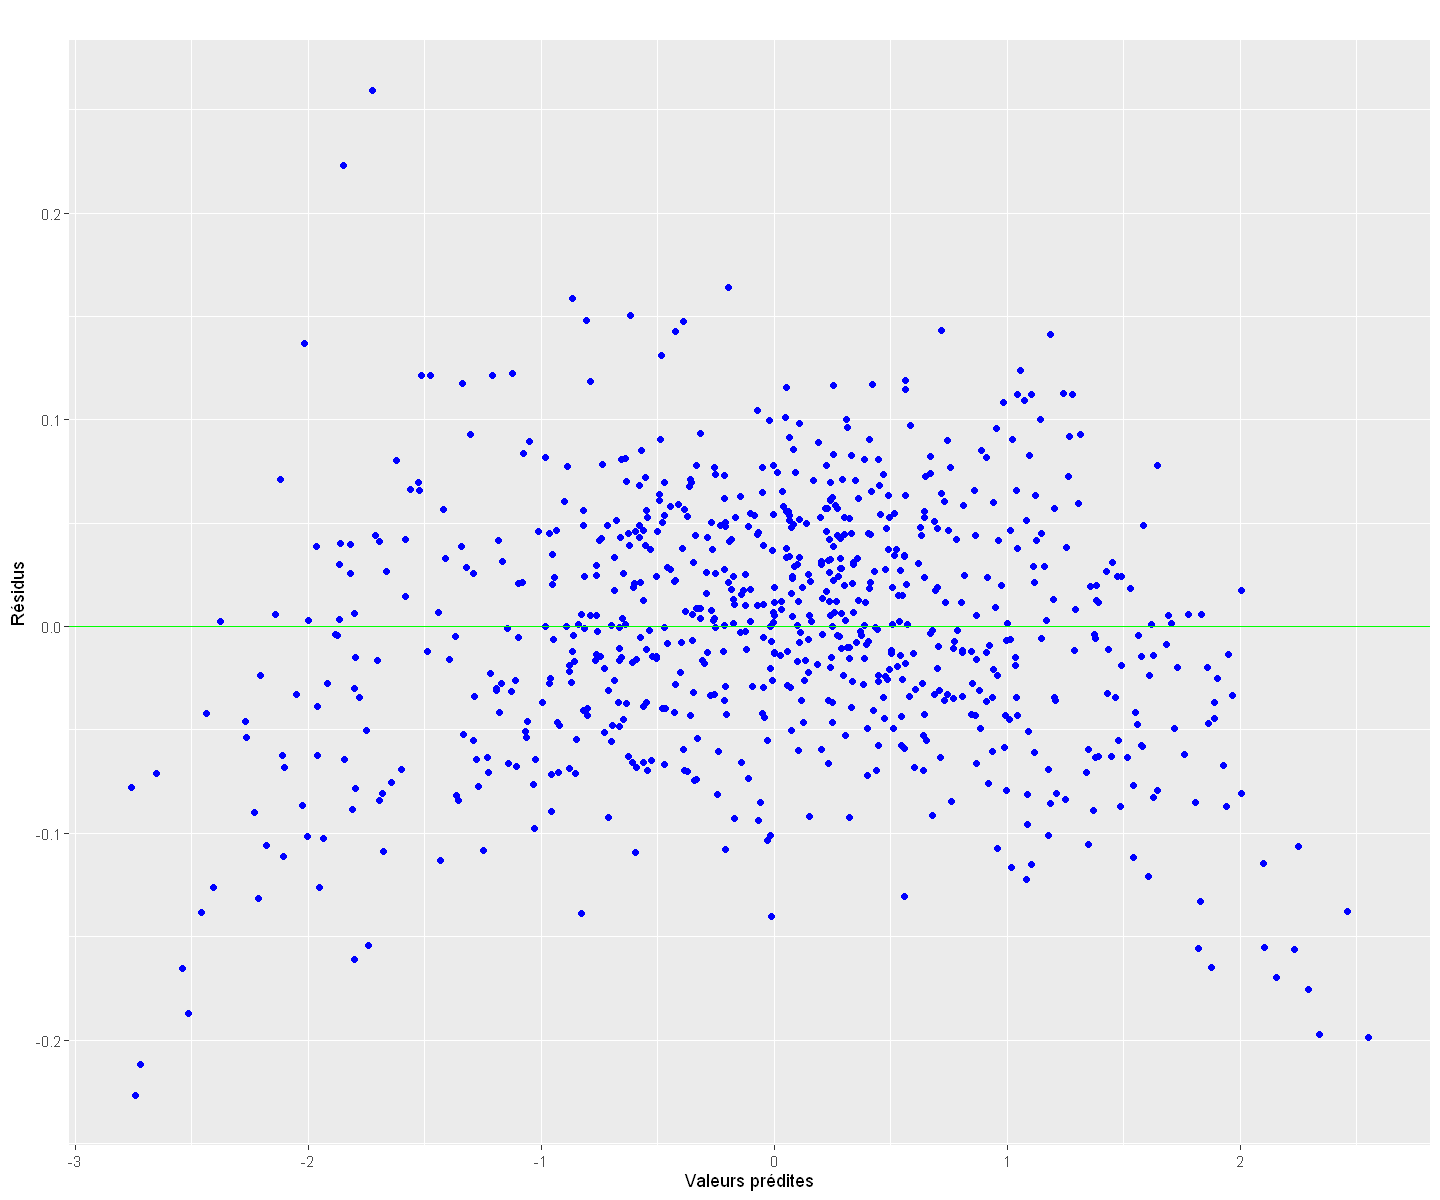

In [172]:
# Affichage des résidus
fit.boostr = predict(boost.reg, newdata = datappr, n.trees = meilleur$best.iter, shrinkage = meilleur$shrinkage)
res.boostr = fit.boostr - y

gplot.res(fit.boostr, res.boostr, titre = "")

,var,rel.inf
,<chr>,<dbl>
Session_Duration..hours.,Session_Duration..hours.,84.45850142
Avg_BPM,Avg_BPM,10.22881425
Age,Age,2.56490336
Gender,Gender,2.06108312
Water_Intake..liters.,Water_Intake..liters.,0.30532100
sWeight..kg.,sWeight..kg.,0.11307346
sBMI,sBMI,0.08961457
Height..m.,Height..m.,0.06965705
Max_BPM,Max_BPM,0.03910078


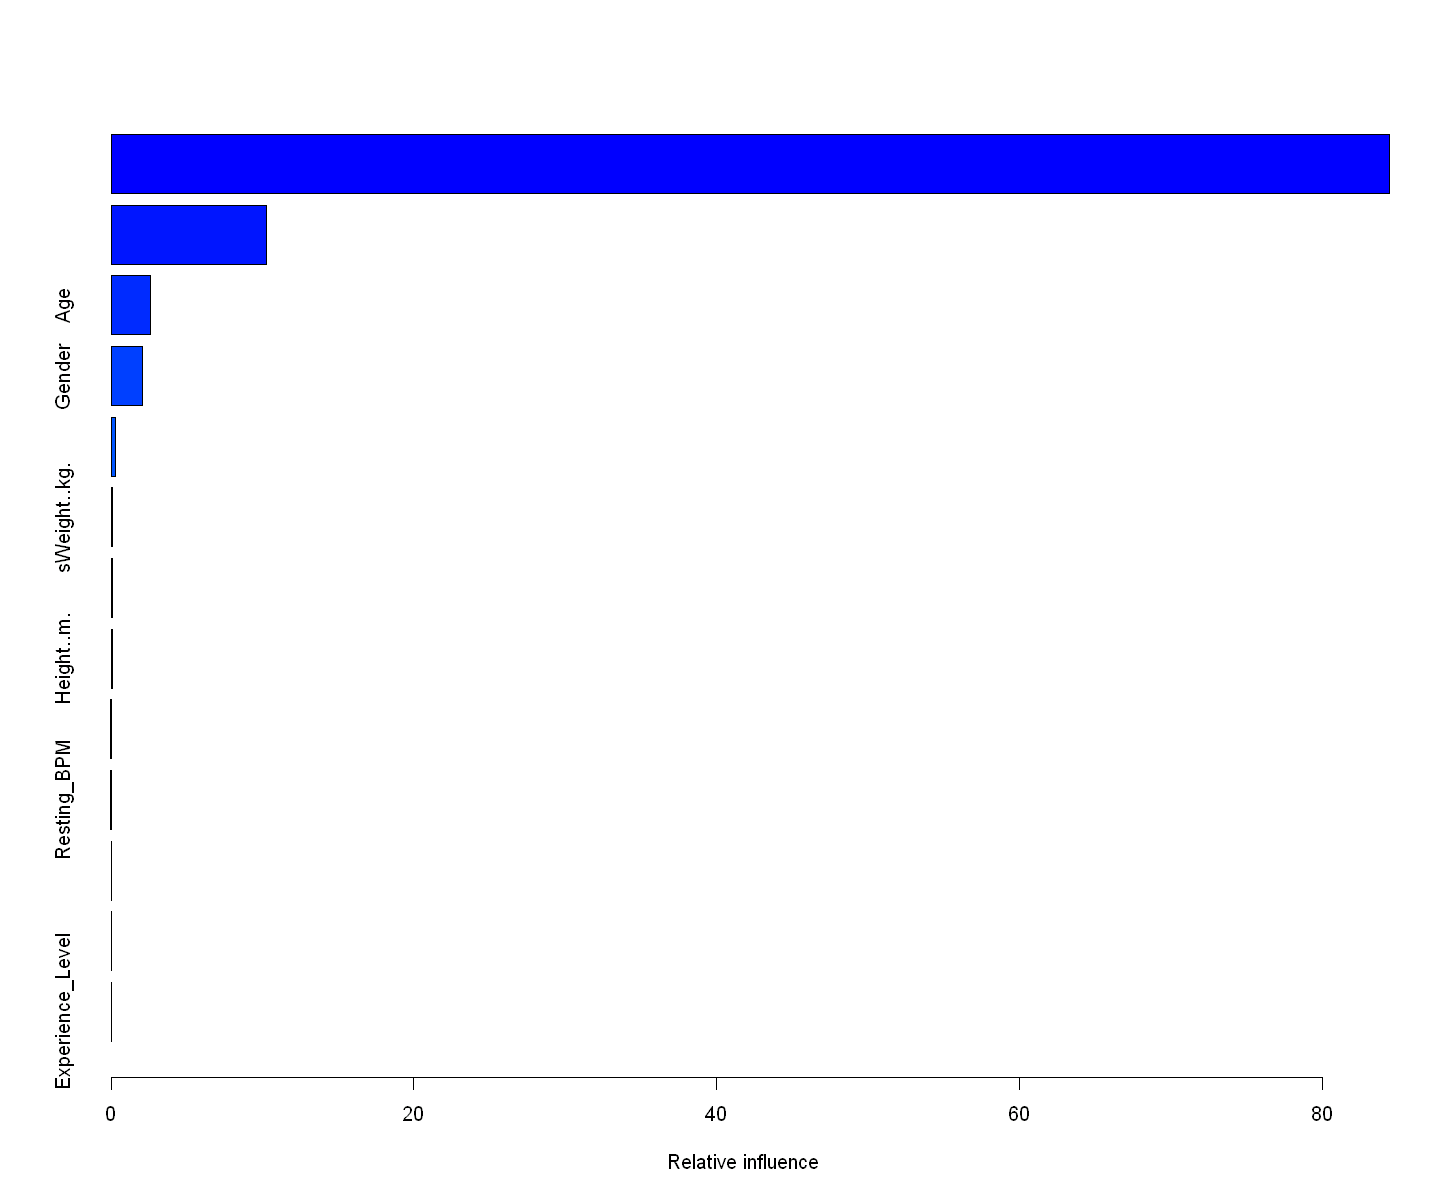

In [173]:
# Importance des variables
summary(boost.reg)

Les 2 variables les plus importantes sont les mêmes que pour random forest. L'ordre des autres variables change mais comme leur importance est très faible (<3%) cela importe peu.

### RMSE sur l'échantillon de test:

In [174]:
test_boost <- predict(boost.reg,newdata=datestr,n.trees = meilleur$best.iter, shrinkage = meilleur$shrinkage)
rmse_boost <- sqrt(mean((y_test - test_boost)^2))

cat("RMSE pour boosting :", rmse_boost, "\n")

RMSE pour boosting : 0.1013821 


## 2.1.6 Réseaux de Neurones

Avec nnet le nombre de couches cachées supportées est seulement 1. On optimise les paramètres size, decay qui correspondent respectivement au nombre de neurones dans l'unique couche cachée et à la pénalisation L2.

  size decay
4    5     1


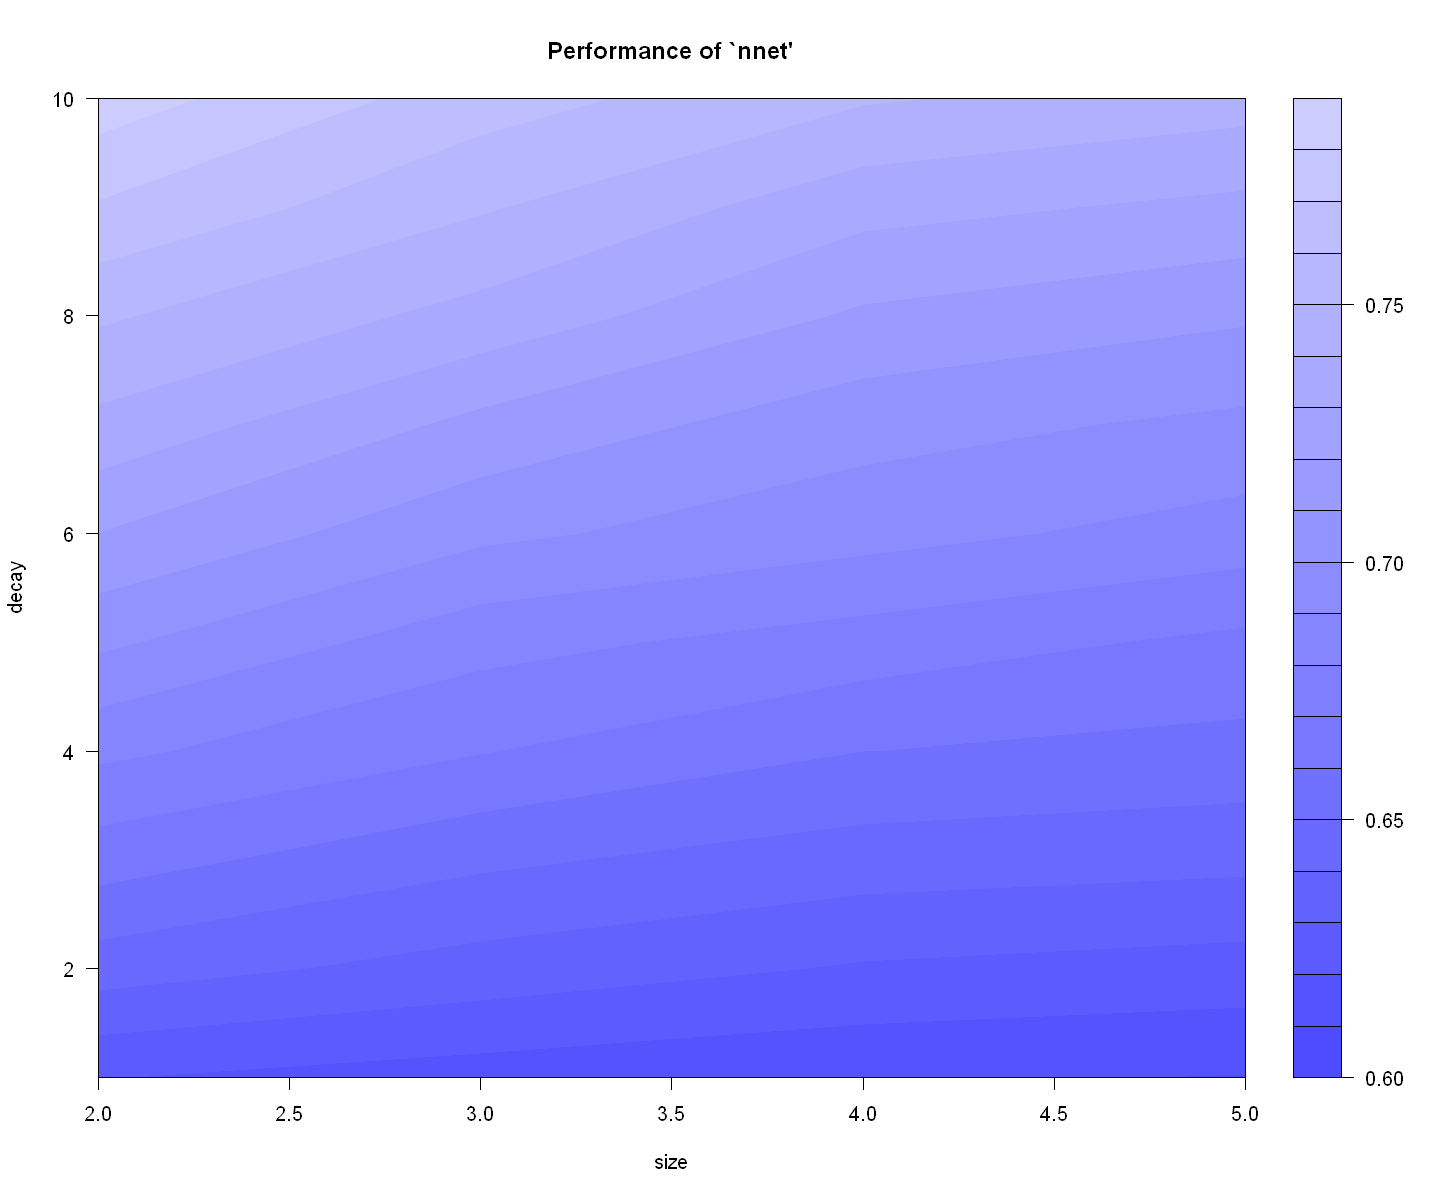

In [175]:
tune.result <- tune.nnet(sCalories_Burned~.,data=datappr,size=2:5,decay=1:10)

plot(tune.result)

best.params <- tune.result$best.parameters
print(best.params)

In [176]:
nnet.reg=nnet(sCalories_Burned~.,data=datappr,size=5,decay=1,linout=TRUE,maxit=500) 
summary(nnet.reg)

# weights:  101
initial  value 875.984548 
iter  10 value 115.045709
iter  20 value 80.905669
iter  30 value 54.281210
iter  40 value 38.167609
iter  50 value 30.646470
iter  60 value 27.558942
iter  70 value 25.073285
iter  80 value 22.933091
iter  90 value 22.423199
iter 100 value 22.173746
iter 110 value 22.090201
iter 120 value 22.017738
iter 130 value 21.962420
iter 140 value 21.936469
iter 150 value 21.919189
iter 160 value 21.910232
iter 170 value 21.901820
iter 180 value 21.890491
iter 190 value 21.884875
iter 200 value 21.881899
iter 210 value 21.877630
iter 220 value 21.871473
iter 230 value 21.866547
iter 240 value 21.865971
final  value 21.865965 
converged


a 18-5-1 network with 101 weights
options were - linear output units  decay=1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
  -0.71   -0.13   -0.29    0.08    0.06    0.00    0.23    0.03   -1.05   -0.23 
i10->h1 i11->h1 i12->h1 i13->h1 i14->h1 i15->h1 i16->h1 i17->h1 i18->h1 
  -0.03   -0.14    0.10   -0.11   -0.21   -0.08   -0.22   -0.16    0.01 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
   0.03   -0.13    0.18   -0.09   -0.02    0.08    0.42   -0.07    0.69    0.00 
i10->h2 i11->h2 i12->h2 i13->h2 i14->h2 i15->h2 i16->h2 i17->h2 i18->h2 
   0.06   -0.07   -0.17    0.09   -0.03   -0.01    0.09   -0.07   -0.03 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
   0.10    0.16   -0.20   -0.03   -0.05    0.00   -0.27   -0.03   -0.54    0.05 
i10->h3 i11->h3 i12->h3 i13->h3 i14->h3 i15->h3 i16->h3 i17->h3 i18->h3 
   0.01    0.02   -0.06    0.03    0.04    0.01    0.03    0.03   -0.05

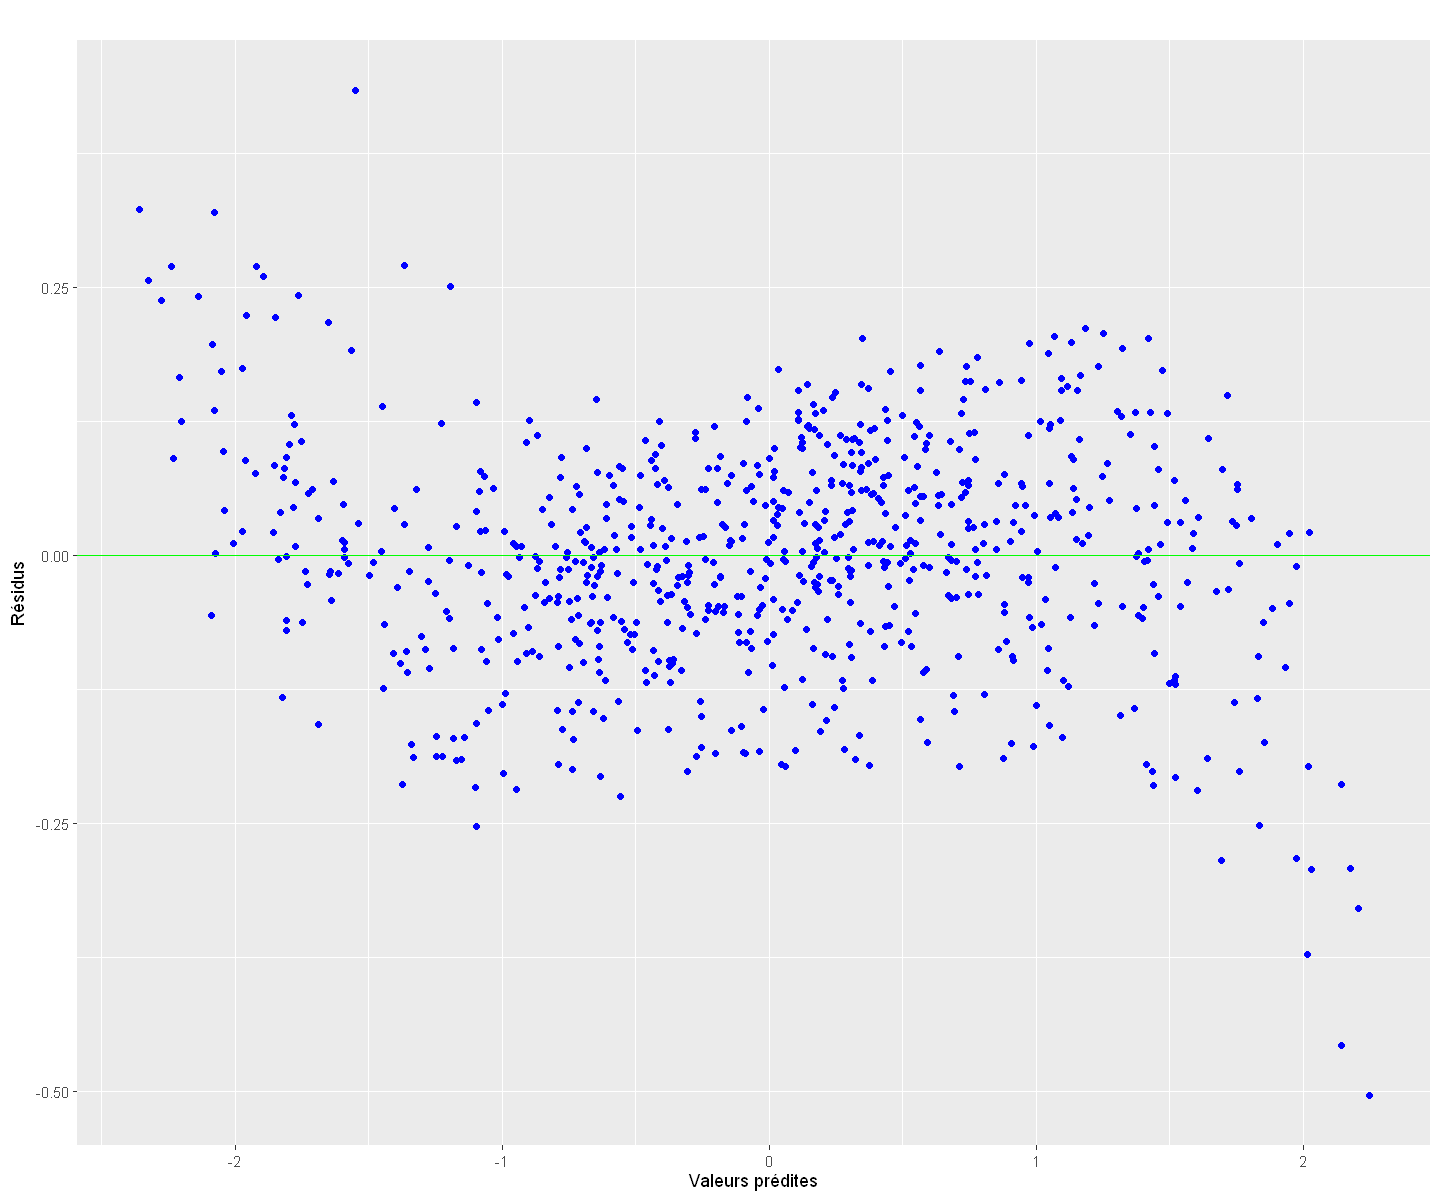

In [177]:
# Affichage des résidus
fit.nnetr=predict(nnet.reg,data=datappr)
res.nnetr=fit.nnetr-datappr[,"sCalories_Burned"]
gplot.res(fit.nnetr,res.nnetr,titre="")

### RMSE sur l'échantillon de test:

In [178]:
test_nnet <- predict(nnet.reg,newdata=datestr)

rmse_nnet <- sqrt(mean((y_test - test_nnet)^2))

cat("RMSE pour nnet :", rmse_nnet, "\n")

RMSE pour nnet : 0.1163765 


Les résultats sont un peu moins bons que pour le boosting

## 2.1.7 Comparaison des méthodes:

On compare le RMSE de tout les modèles sur le jeu de test:

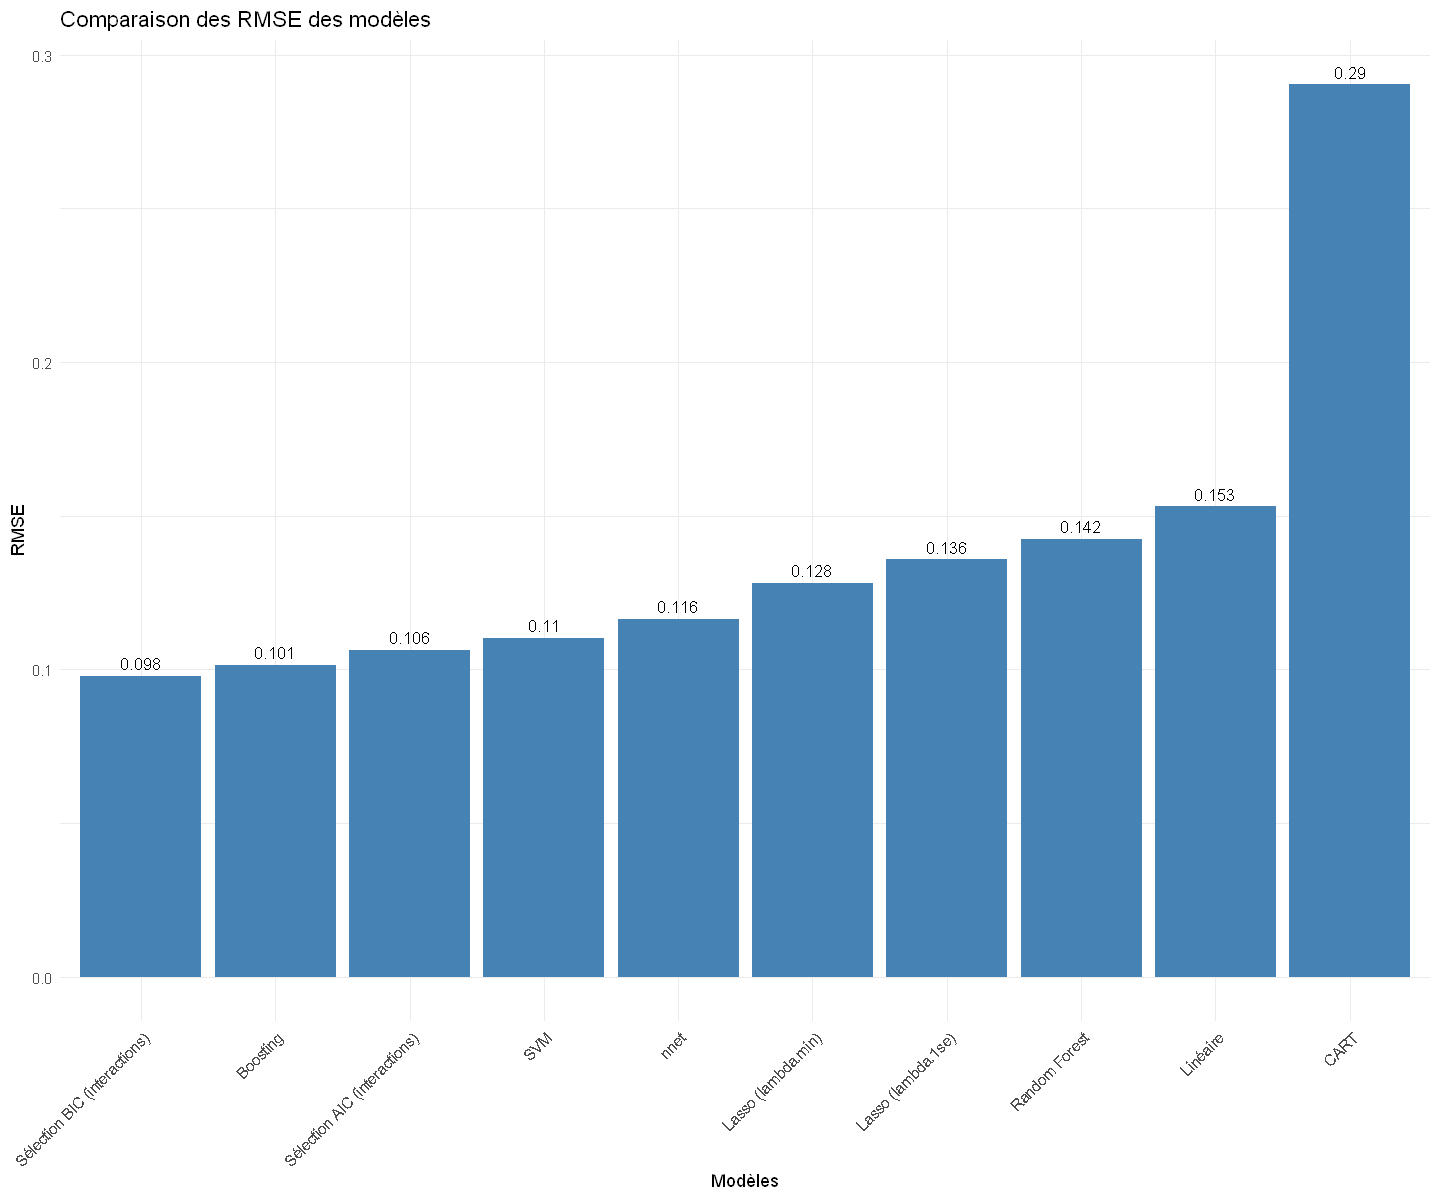

In [179]:
rmse.df <- data.frame(
  Modèle = c("Linéaire", "Lasso (lambda.min)", "Lasso (lambda.1se)","Sélection AIC (interactions)", "SVM","Sélection BIC (interactions)", "CART", "Random Forest", "Boosting", "nnet"),
  RMSE = c(rmse, rmse_min, rmse_1se, rmse_aic, rmse_svmr, rmse_bic, rmse_tree, rmse_forest, rmse_boost, rmse_nnet))

rmse.df <- rmse.df[order(rmse.df$RMSE), ]
rmse.df$Modèle <- factor(rmse.df$Modèle, levels = rmse.df$Modèle)

ggplot(rmse.df, aes(x = Modèle, y = RMSE)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_text(aes(label = round(RMSE, 3)), vjust = -0.5, size = 3.5) +
  labs(title = "Comparaison des RMSE des modèles",
       x = "Modèles",
       y = "RMSE") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Le meilleur modèle est le modèle linéaire avec interactions quadratique dont les variables ont été sélectionnées via le critère BIC. Les résultats du modèle sélectionné avec AIC et du boosting sont aussi très proches.

Les autres modèles sont un peu moins bon mais restent très performants à l'exception de CART dont l'erreur est environ deux fois plus importante que celle des autres modèles.

Cela peut s'expliquer par la simplicité d'un unique arbre et par le fait qu'il y a un nombre assez réduit de valeures prédites possible (le nombre de feuilles).

Dans ce cas, les modèles les plus performants (BIC, AIC et boosting) sont interprétables, ils sont donc à privilégier si c'est une contrainte.

# 2.2 Prédiction du niveau d'entraînement (classification)

Cette partie est dédiée à la prédiction du niveau d'entraînement ($Experience\_Level$) de chaque individu. Il s'agit donc d'un problème de classification à 3 classes (1, 2, 3). Les méthodes utilisées ici ne considèrent aucune hiérarchie entre ces classes.

Nb : entre l'analyse des résultatas et l'exécution finale, les valeurs suivantes de pourcentage d'erreur ont été modifiées :
- RdN : 15,98% (ancienne) -> 14,95% (nouvelle)
- SVM Linéaire : 15,46% -> 14,95%
- Forest : 8,76% -> 10,82%
Merci de prendre en compte cela

**Fonctions préalables**\
Voici quelques fonctions et variables utiles pour l'affichage des résultats et l'implémentation de chaque méthode.

On définit une variable $QUICK$ qui permet de ne pas lancer la recherche d'hyperparamètres pour les méthodes les plus longues (notamment Boosting et RdN). Les valeurs fixées dans le cas $QUICK=TRUE$ sont des valeurs obtenues lors d'une exécution préalable. Ils ne sont pas à considérer comme les seuls résultats possibles (leur recherche fait intervenir des algorithmes stochastiques, et est donc susceptible de renvoyer des résultats différents à chaque fois), mais peuvent néanmoins économiser des dizaines de minutes d'exécution.

In [180]:
QUICK=FALSE

On définit une fonction $pourcentage\_erreur$ qui calcule et affiche le pourcentage d'erreur.

In [181]:
pourcentage_erreur <- function(conf_matrix) {
  total_samples <- sum(conf_matrix)
  errors <- total_samples - sum(diag(conf_matrix))
  error_percentage <- (errors / total_samples) * 100
  print(paste("Pourcentage d'erreur :", round(error_percentage, 2), "%"))
}

On définit des fonctions $plot\_roc\_curves$ et $plot\_superposed\_roc\_curves$ pour tracer les courbes ROC des différentes méthodes. Comme il y a 3 classes, une courbe sera tracée par classe (on considère alors l'approche "**one vs all**", qui étudie la probabilité d'appartenir à une classe contre la probabilité à l'une des deux autres). Ces fonctions se baseront sur un objet qui se nommera à chaque fois $proba\_nom$ (avec $nom$ le nom du modèle).

In [182]:
# Fonction pour tracer les courbes ROC d'une méthode

plot_roc_curves <- function(probabilities, model_name) {
  roc_curves <- list()
  colors <- brewer.pal(3, "Set2")

  for (class in levels(data_test$Experience_Level)) {
    binary_labels <- as.numeric(data_test$Experience_Level == class)
    roc_curve <- roc(binary_labels, probabilities[, class], quiet = TRUE)
    roc_curves[[class]] <- roc_curve
  }

  plot(roc_curves[[levels(data_test$Experience_Level)[1]]], col = colors[1], lty = 1, lwd = 2, main = paste("Courbes ROC par", model_name))
  lines(roc_curves[[levels(data_test$Experience_Level)[2]]], col = colors[2], lty = 1, lwd = 2)
  lines(roc_curves[[levels(data_test$Experience_Level)[3]]], col = colors[3], lty = 1, lwd = 2)

  legend("bottomright", legend = levels(data_test$Experience_Level), col = colors, lwd = 2)
}


# Fonction pour tracer les courbes ROC de deux méthodes. On superpose alors les courbes

plot_superposed_roc_curves <- function(probabilities_1, model_name_1, probabilities_2, model_name_2) {
  roc_curves_1 <- list()
  roc_curves_2 <- list()
  colors_1 <- brewer.pal(3, "Set2")
  colors_2 <- brewer.pal(3, "Dark2") 

  for (class in levels(data_test$Experience_Level)) {
    binary_labels <- as.numeric(data_test$Experience_Level == class)
    roc_curve <- roc(binary_labels, probabilities_1[, class], quiet = TRUE)
    roc_curves_1[[class]] <- roc_curve
  }

  for (class in levels(data_test$Experience_Level)) {
    binary_labels <- as.numeric(data_test$Experience_Level == class)
    roc_curve <- roc(binary_labels, probabilities_2[, class], quiet = TRUE)
    roc_curves_2[[class]] <- roc_curve
  }

  plot(roc_curves_1[[levels(data_test$Experience_Level)[1]]], col = colors_1[1], lty = 1, lwd = 2, main = paste("Courbes ROC superposées (", model_name_1, " et ", model_name_2, ")", sep = ""))
  lines(roc_curves_1[[levels(data_test$Experience_Level)[2]]], col = colors_1[2], lty = 1, lwd = 2)
  lines(roc_curves_1[[levels(data_test$Experience_Level)[3]]], col = colors_1[3], lty = 1, lwd = 2)

  lines(roc_curves_2[[levels(data_test$Experience_Level)[1]]], col = colors_2[1], lty = 2, lwd = 2)
  lines(roc_curves_2[[levels(data_test$Experience_Level)[2]]], col = colors_2[2], lty = 2, lwd = 2)
  lines(roc_curves_2[[levels(data_test$Experience_Level)[3]]], col = colors_2[3], lty = 2, lwd = 2)

  legend("bottomright", legend = c(paste(model_name_1, "-", levels(data_test$Experience_Level)), paste(model_name_2, "-", levels(data_test$Experience_Level))),
         col = c(colors_1, colors_2),
         lty = rep(c(1, 2), each = 3), lwd = 2)
}

On fixe ici les paramètres $param\_train$ de la validation croisée (Cross-fold Validation). On choisit ici une validation croisée sur 10 folds. Ces paramètres interviendront avec l'usage du package *caret*. On utilise aussi la librairie *doParallel* afin de diminuer le temps d'exécution des validations croisées.

In [183]:
param_train<-trainControl(method="cv",number=10)

library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl) 

**Découpage du dataset**

On découpe le dataset pour avoir un échantillon test et apprentissage. Nous utilisons pour cela la librairie *caret*. Le ratio choisit est de 0.8. Nous avons fait le choix de créer deux datasets, l'un pour les données sans traitement, l'autre pour les données en normalisant certaines variables. Certaines méthodes (notamment celles construites à partir d'arbres binaires de décision) n'ont en effet pas besoin d'utiliser des données normalisées.

In [184]:
set.seed(1234)

train_index <- createDataPartition(data$Experience_Level, p = 0.8, list = FALSE)

# Créer les datasets d’apprentissage et de test non normalisés
data_exp <- data[train_index, ]
data_test <- data[-train_index, ]

# Créer les datasets d’apprentissage et de test normalisés
data_exp_norm <- data_norm[train_index, ]
data_test_norm <- data_norm[-train_index, ]

# Permet d'avoir accès aux variables quantitatives
quanti_columns_bis <- c(1,3:9,11,12,15)

Il faut ensuite centrer et réduire les données. Pour cela, on fait bien attention à appliquer cette transformation sur l'échantillon de test avec les valeurs de moyenne et de variance obtenue sur l'échantillon d'apprentissage. Cela est nécessaire pour ne pas faire intervenir des informations sur l'échantillon test.

In [185]:
# Pour les données non normalisées

data_exp_0 <- data_exp[, quanti_columns_bis]

data_exp[, quanti_columns_bis] <- scale(data_exp[, quanti_columns_bis],center = TRUE, scale = TRUE)
data_test[, quanti_columns_bis]=scale(data_test[, quanti_columns_bis], center=sapply(data_exp_0,mean), 
                            scale=sapply(data_exp_0,sd))


# Pour les données normalisées

data_exp_0_norm <- data_exp_norm[, quanti_columns_bis]

data_exp_norm[, quanti_columns_bis] <- scale(data_exp_norm[, quanti_columns_bis],center = TRUE, scale = TRUE)
data_test_norm[, quanti_columns_bis]=scale(data_test_norm[, quanti_columns_bis], center=sapply(data_exp_0_norm,mean), 
                            scale=sapply(data_exp_0_norm,sd))

On vérifie que cela a bien été appliqué :

In [186]:
summary(data_exp_norm)
summary(data_test_norm)

      Age              Gender     sWeight..kg.       Height..m.      
 Min.   :-1.70033   Female:384   Min.   :-1.8166   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :395   1st Qu.:-0.7259   1st Qu.:-0.79206  
 Median : 0.09668                Median :-0.1182   Median :-0.07902  
 Mean   : 0.00000                Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.: 0.91350                3rd Qu.: 0.6209   3rd Qu.: 0.55479  
 Max.   : 1.64864                Max.   : 2.4149   Max.   : 2.21854  
    Max_BPM            Avg_BPM          Resting_BPM      
 Min.   :-1.70393   Min.   :-1.66558   Min.   :-1.66962  
 1st Qu.:-0.84195   1st Qu.:-0.90414   1st Qu.:-0.84618  
 Median : 0.02003   Median :-0.07349   Median :-0.02273  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.88201   3rd Qu.: 0.89561   3rd Qu.: 0.80072  
 Max.   : 1.65779   Max.   : 1.72627   Max.   : 1.62417  
 Session_Duration..hours. sCalories_Burned     Workout_Type BCFat_Percentage  
 Min.   :-2.20445        

      Age              Gender     sWeight..kg.        Height..m.      
 Min.   :-1.70033   Female: 78   Min.   :-1.81662   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :116   1st Qu.:-0.75461   1st Qu.:-0.71283  
 Median :-0.06669                Median :-0.08338   Median :-0.07902  
 Mean   :-0.05448                Mean   : 0.03085   Mean   : 0.10352  
 3rd Qu.: 0.66845                3rd Qu.: 0.72503   3rd Qu.: 0.95092  
 Max.   : 1.64864                Max.   : 2.35989   Max.   : 2.21854  
    Max_BPM            Avg_BPM         Resting_BPM      
 Min.   :-1.70393   Min.   :-1.6656   Min.   :-1.66962  
 1st Qu.:-0.66956   1st Qu.:-0.9041   1st Qu.:-0.84618  
 Median : 0.10623   Median :-0.1427   Median : 0.11451  
 Mean   : 0.05024   Mean   :-0.1024   Mean   : 0.03953  
 3rd Qu.: 0.88201   3rd Qu.: 0.7399   3rd Qu.: 0.93796  
 Max.   : 1.65779   Max.   : 1.6571   Max.   : 1.62417  
 Session_Duration..hours. sCalories_Burned     Workout_Type BCFat_Percentage  
 Min.   :-2.17545        

Nous avons bien une moyenne nulle pour les données d'apprentissage, et presque nul pour les données de test.

# 2.2.1 Régression multinomiale

Nous commençons par cette méthode de classification plutôt ancienne comparée aux autres, mais qui peut donner de bons résultats. Elle a l'avantage d'être interprétable. Comme nous avons 3 classes, nous effectuerons en réalité 3 régressions logisitiques, selon la méthode "one vs all" précédemment énoncé.

**Régression multinomiale**

On teste dans un premier temps une régression multinomiale simple, en se basant sur la régression logistique suivante :\
\
$\log\left(\frac{P(Y = 1 \mid \mathbf{x})}{1 - P(Y = 1 \mid \mathbf{x})}\right) = \mathbf{x}^\top \boldsymbol{\beta} \quad$ (avec $\beta$ le vecteur des coefficients).


In [187]:
multinom_model <- multinom(Experience_Level ~ ., data = data_exp_norm, trace = FALSE)

pred_multinom <- predict(multinom_model, newdata = data_test_norm[,-14])
proba_multinom <- predict(multinom_model, newdata = data_test_norm[,-14], type = "probs")

print(coef(multinom_model))

  (Intercept)        Age  GenderMale sWeight..kg. Height..m.    Max_BPM
2  -108.09905  0.1061497   0.2468114     1.245465 -0.8445396 0.08328331
3   -73.54235 -5.0537298 -13.6008325    -0.660745  0.2952323 0.65526363
     Avg_BPM Resting_BPM Session_Duration..hours. sCalories_Burned
2 -0.5617703  0.03051148               -0.5164185          2.21876
3  8.5330019  1.39974724               42.1505401        -26.22909
  Workout_TypeHIIT Workout_TypeStrength Workout_TypeYoga BCFat_Percentage
2       -0.1068848            0.3199862        0.4026057     -0.001908756
3        0.3112017           -0.5526979       -1.6945868    -41.625311166
  Water_Intake..liters. Workout_Frequency..days.week.3
2            -0.1872111                      108.15553
3            -0.2698953                       28.81998
  Workout_Frequency..days.week.4 Workout_Frequency..days.week.5      sBMI
2                       186.7296                      140.14676 -1.282984
3                       113.7352                

Nous nous concentrerons sur l'analyse des coefficients plus tard, après sélection de variables (*LASSO*).

    Prédit
Vrai  1  2  3
   1 64 11  0
   2 17 64  0
   3  0  0 38
[1] "Pourcentage d'erreur : 14.43 %"


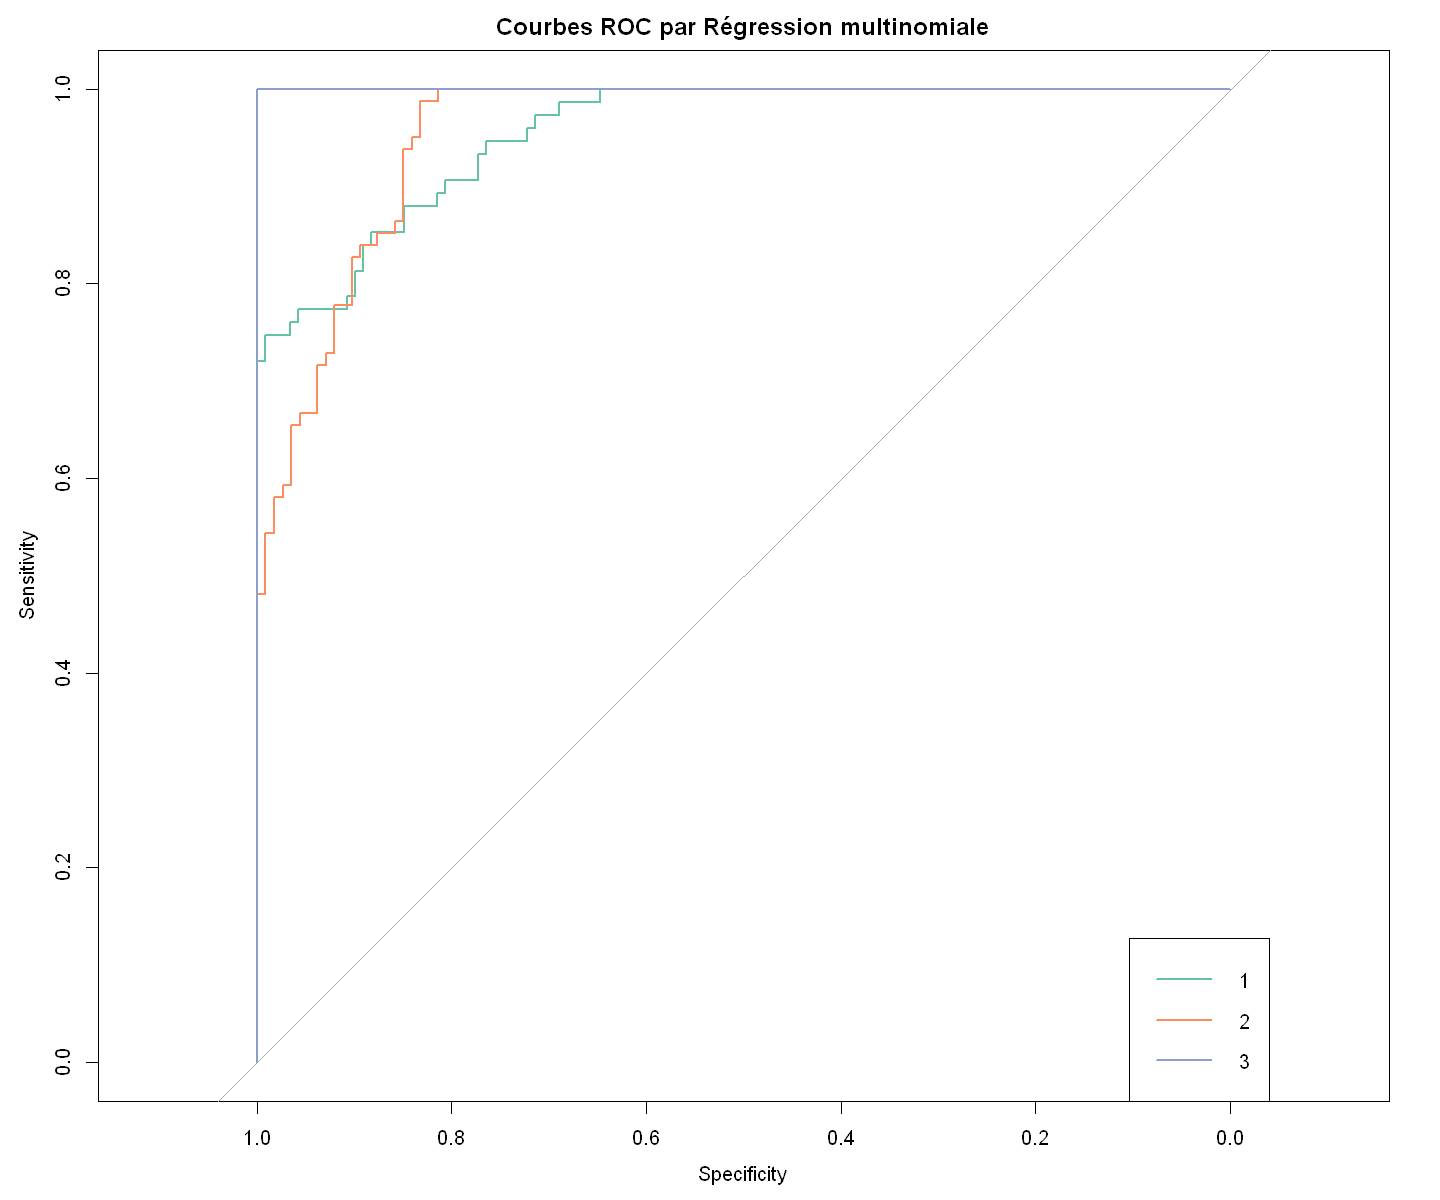

In [188]:
conf_matrix_multinom <- table(Vrai = data_test_norm$Experience_Level, Prédit = pred_multinom)
print(conf_matrix_multinom)
pourcentage_erreur(conf_matrix_multinom)

plot_roc_curves(proba_multinom, "Régression multinomiale")

**Ridge** (pénalisation de la complexité)

On veut ici éviter le surajustement. Pour cela, on cherche à réduire les coefficients obtenus lors de la régression multinomiale précédente. Pour cela, on utilise la méthode *Ridge* qui se base sur un critère de pénalité *l2* :\
\
$\mathcal{L}(\boldsymbol{\beta}) = - \sum_{i=1}^{n} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right] + \lambda \|\boldsymbol{\beta}\|_2^2 \quad$ avec $\lambda \in \mathbb{R}^{+}$.\
\
On va ici chercher la meilleur valeur possible pour le paramètre $\lambda$. On utilise pour cela une méthode par validation croisée. A noter que $\lambda=0$ revient à ne pas pénaliser (on retrouve donc le modèle précédent) et $\lambda \to +\infty$ revient à annuler tous les coefficients.




In [189]:
# On convertit les données en matrice pour glmnet (Ridge, Lasso & Elastic Net)

x <- model.matrix(Experience_Level ~ ., data = data_exp_norm)[, -1]  # Prédicteurs 
y <- model.matrix(~ Experience_Level + 0, data = data_exp_norm)      # Réponse

x_test <- model.matrix(Experience_Level ~ ., data = data_test_norm)[, -1]  # Prédicteurs
y_test <- model.matrix(~ Experience_Level + 0, data = data_test_norm)  # Réponse réelle (one-hot)

[1] "Best Lambda : 0.0292035041393734"
[1] "LSE Lambda : 0.0320508097410336"


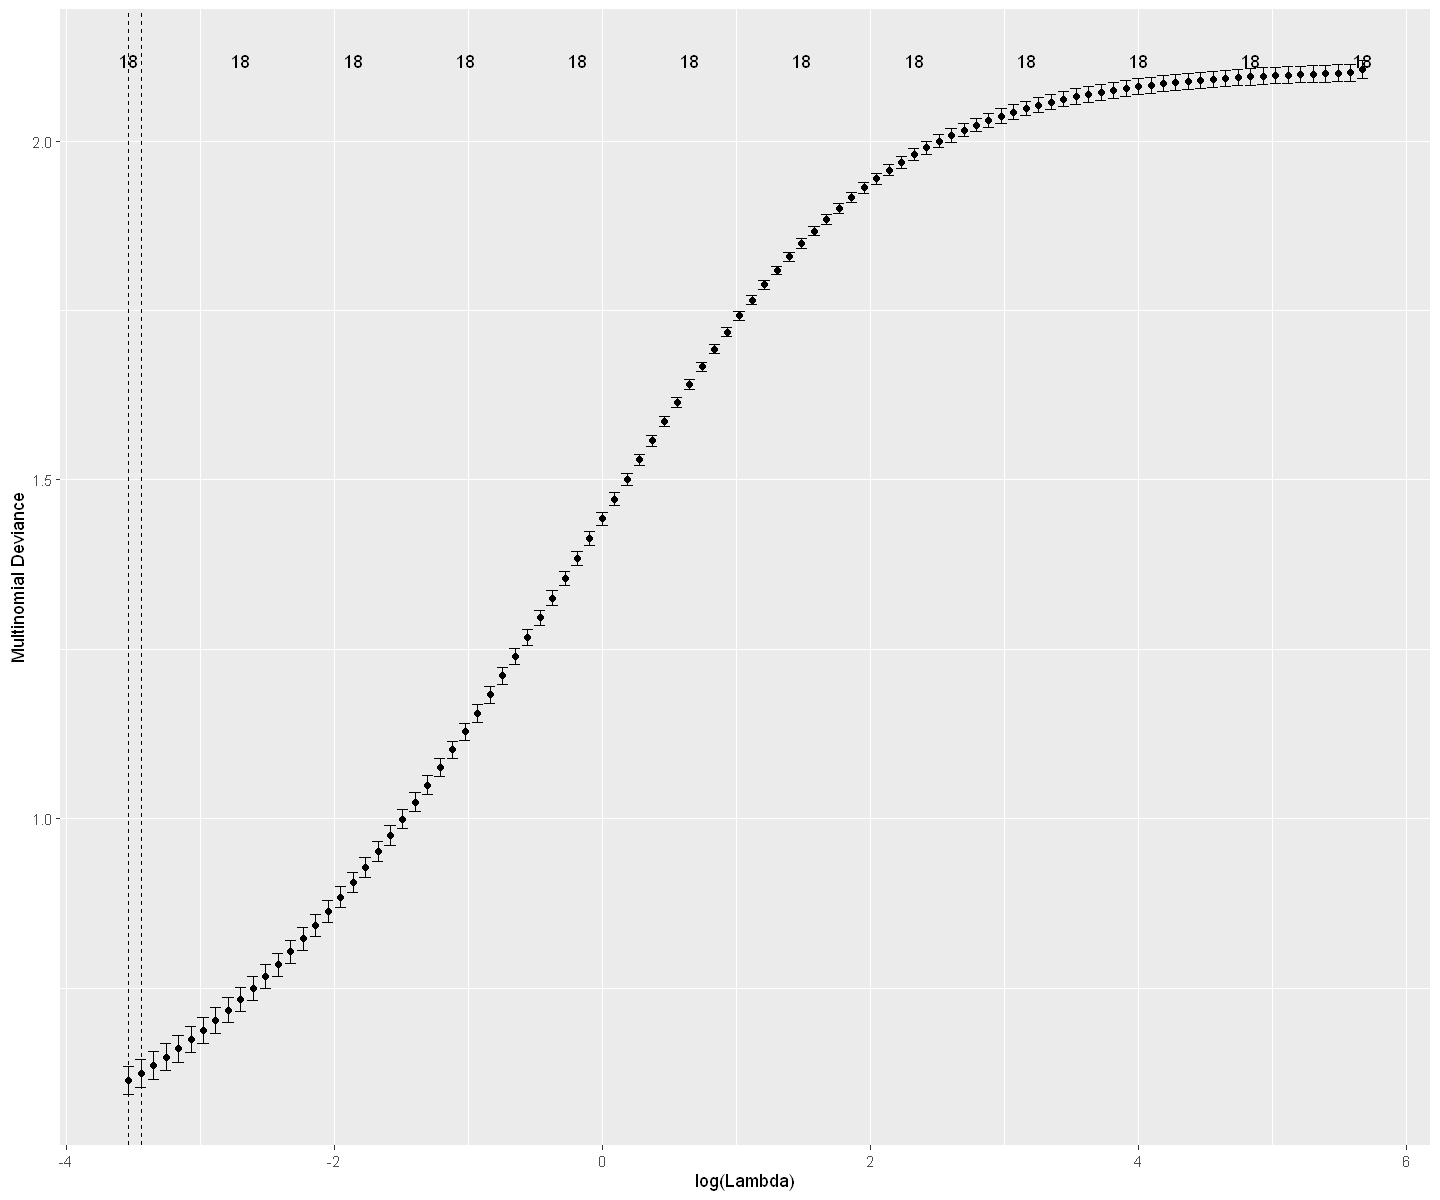

In [190]:
# Ajustement du modèle avec validation croisée

cv_fit <- cv.glmnet(x, y, family = "multinomial", alpha = 0) # Ridge donc alpha=0  
autoplot(cv_fit)

# Afficher le meilleur lambda
best_lambda <- cv_fit$lambda.min
print(paste("Best Lambda :", best_lambda))

#Affiche le plus grand lambda envisageable
lse_lambda <- cv_fit$lambda.1se
print(paste("LSE Lambda :", lse_lambda))

On choisit le $\lambda$ qui minimise la déviance du modèle, nommé ici *Best Lambda*.

In [191]:
# Choix du lambda
chosen_lambda <- best_lambda

# Ajuster le modèle final avec le meilleur lambda
ridge_model <- glmnet(x, y, family = "multinomial", alpha = 0, lambda = chosen_lambda)

print(coef(ridge_model))

$Experience_Level1
19 x 1 sparse Matrix of class "dgCMatrix"
                                          s0
                                1.7543867454
Age                             0.0007209814
GenderMale                      0.0756609236
sWeight..kg.                    0.0553814504
Height..m.                      0.0876793816
Max_BPM                        -0.0398108940
Avg_BPM                         0.1112089998
Resting_BPM                    -0.0142394865
Session_Duration..hours.       -0.5979206474
sCalories_Burned               -0.5618658084
Workout_TypeHIIT                0.0085599071
Workout_TypeStrength           -0.0909730304
Workout_TypeYoga               -0.1341106340
BCFat_Percentage                0.3735444946
Water_Intake..liters.          -0.0670135075
Workout_Frequency..days.week.3 -0.6297329219
Workout_Frequency..days.week.4 -2.5635507803
Workout_Frequency..days.week.5 -0.8035774281
sBMI                            0.0047366391

$Experience_Level2
19 x 1 sparse Matri

      Predicted
Actual  1  2  3
     1 66  9  0
     2 19 62  0
     3  0  0 38
[1] "Pourcentage d'erreur : 14.43 %"


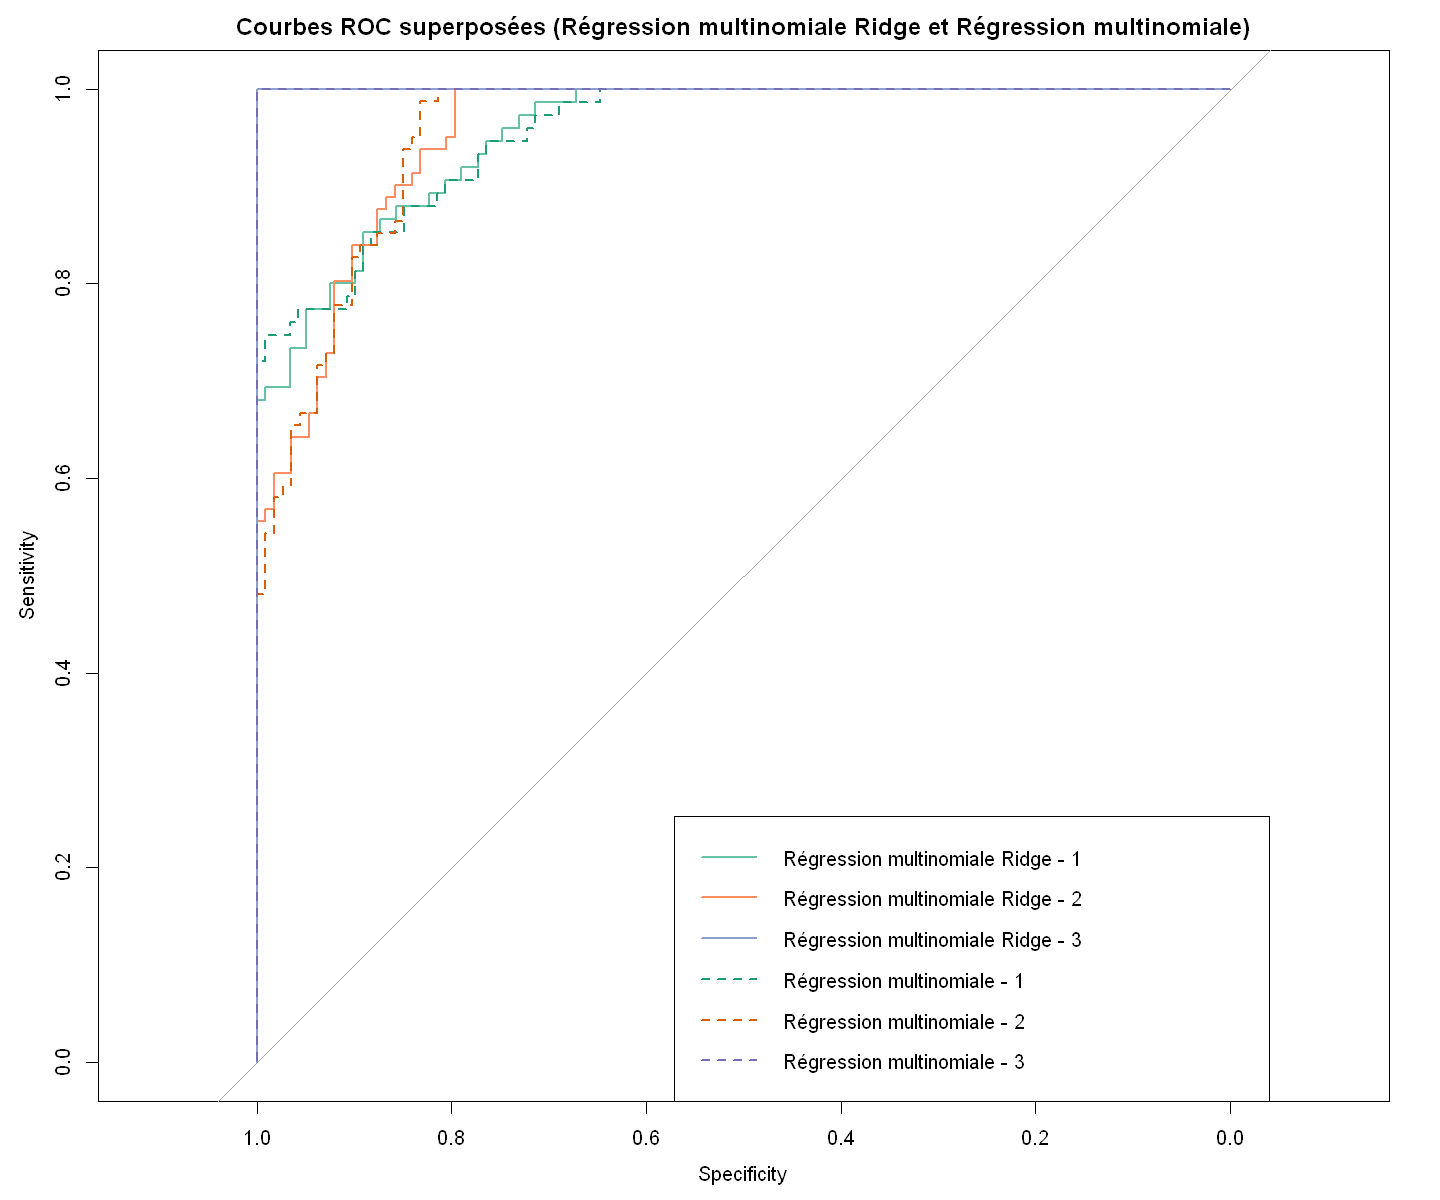

In [192]:
pred_probs <- predict(ridge_model, newx = x_test, type = "response")

proba_ridge <- pred_probs[,,1]
proba_ridge <- as.data.frame(proba_ridge)
colnames(proba_ridge) <- c("1", "2", "3")

pred_class <- apply(pred_probs, 1, which.max)
true_class <- apply(y_test, 1, which.max)


conf_matrix_ridge <- table(Actual = true_class, Predicted = pred_class)
print(conf_matrix_ridge)
pourcentage_erreur(conf_matrix_ridge)

plot_superposed_roc_curves(proba_ridge, "Régression multinomiale Ridge",proba_multinom,"Régression multinomiale")

Contrairement à ce que l'on pourrait penser, la méthode *Ridge* n'a pas amélioré la prévision sur l'échantillon test. Le pourcentage d'erreur est identique, et les courbes ROC ne permettent pas de déterminer clairement un modèle meilleur que l'autre.\
Il y a tout de même des différences dans les résultats de ces deux modèles : même si le taux d'erreur est le même, elles ne sont pas situées au même endroit comme nous permettent de le constater les matrices de confusions.

**Lasso** (sélection de variables)

On veut de nouveau éviter le surajustement. Pour cela, on cherche à réduire et sélectionner les coefficients obtenus lors de la régression multinomiale précédente. Pour cela, on utilise la méthode *Lasso* qui se base sur sur un critère de pénalité *l1* :\
\
$\mathcal{L}(\boldsymbol{\beta}) = - \sum_{i=1}^{n} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right] + \lambda \|\boldsymbol{\beta}\|_1  \quad$ avec $\lambda \in \mathbb{R}^{+}$.\
\
On va ici chercher la meilleur valeur possible pour le paramètre $\lambda$. On utilise pour cela une méthode par validation croisée Le fait d'annuler certains coefficients va par ailleurs permettre une meilleur interprétabilité du modèle.


[1] "Best Lambda : 0.000360034448585093"
[1] "LSE Lambda : 0.00534639729467151"


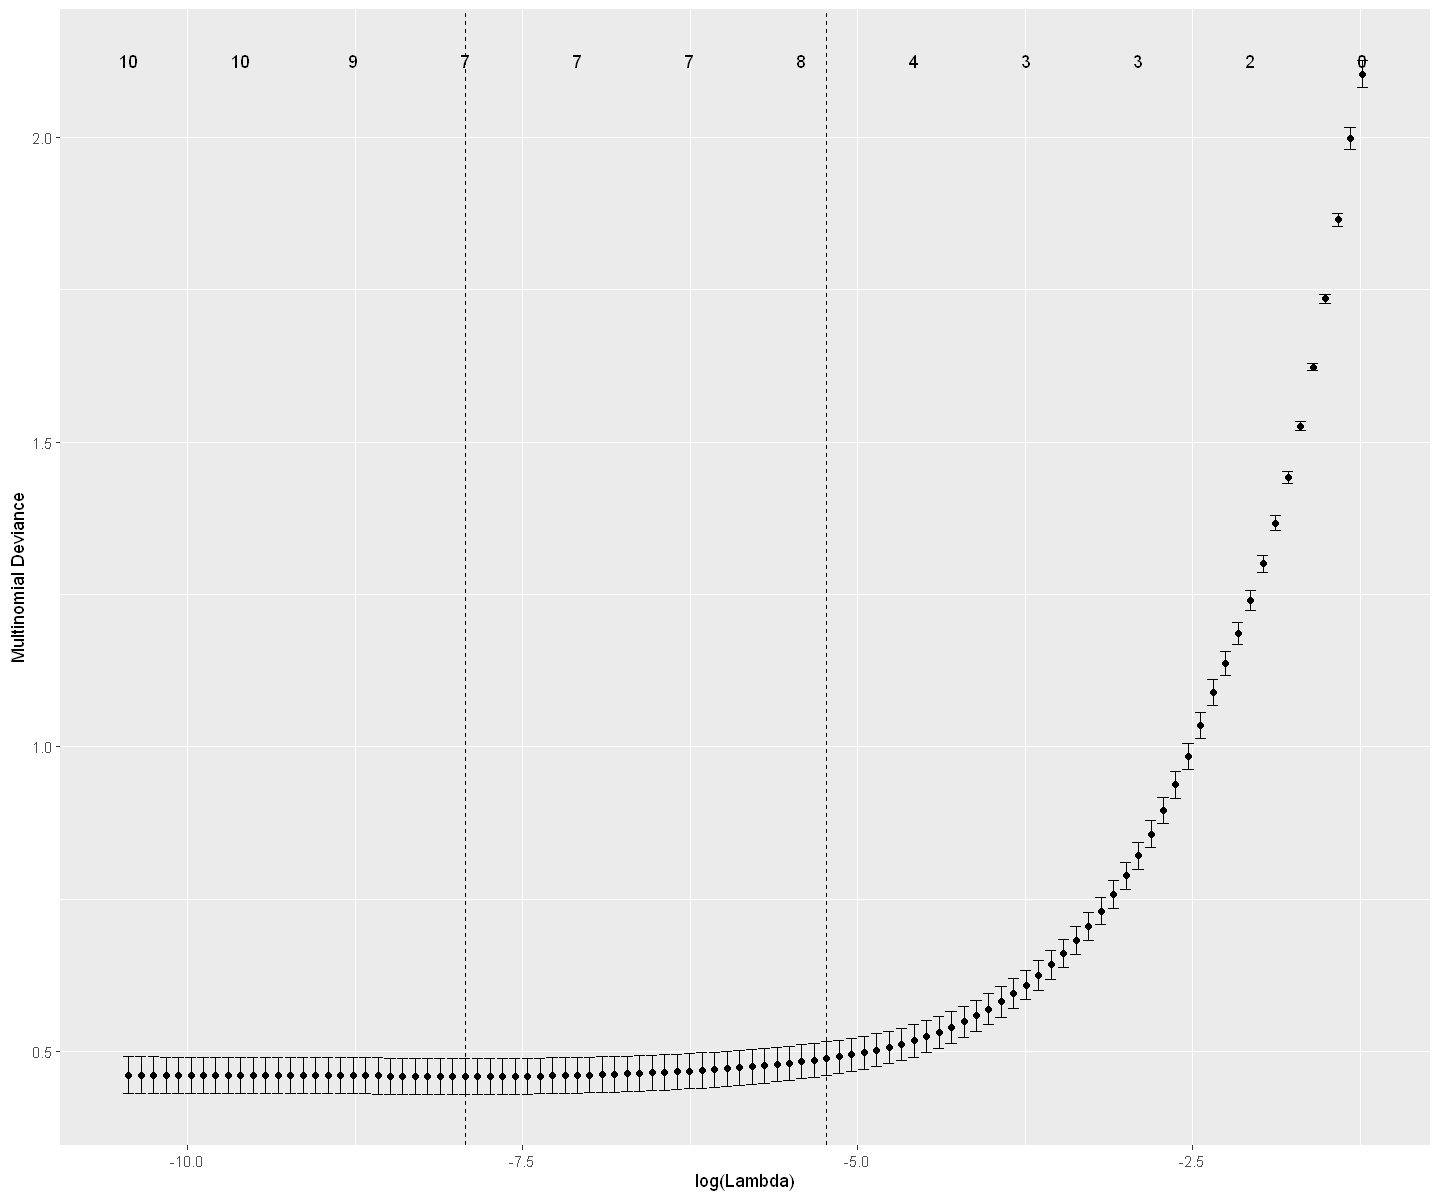

In [193]:
# Ajustement du modèle avec validation croisée

cv_fit <- cv.glmnet(x, y, family = "multinomial", alpha = 1) # alpha=1 => Lasso
autoplot(cv_fit)

# Afficher le meilleur lambda
best_lambda <- cv_fit$lambda.min
print(paste("Best Lambda :", best_lambda))

#Affiche le plus grand lambda envisageable
lse_lambda <- cv_fit$lambda.1se
print(paste("LSE Lambda :", lse_lambda))

On choisit le $\lambda$ qui minimise la déviance, nommé ici *Best Lambda*

In [194]:
# Choix du lambda
chosen_lambda <- best_lambda

# Ajuster le modèle final avec le meilleur lambda
lasso_model <- glmnet(x, y, family = "multinomial", alpha = 1, lambda = chosen_lambda)

print(coef(lasso_model))

$Experience_Level1
19 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
                                5.07320465
Age                            -0.02162310
GenderMale                      .         
sWeight..kg.                    .         
Height..m.                      0.17465009
Max_BPM                        -0.07670199
Avg_BPM                         0.39976739
Resting_BPM                    -0.03223398
Session_Duration..hours.        .         
sCalories_Burned               -1.65762414
Workout_TypeHIIT                .         
Workout_TypeStrength           -0.01684989
Workout_TypeYoga                .         
BCFat_Percentage                .         
Water_Intake..liters.           .         
Workout_Frequency..days.week.3 -0.61054228
Workout_Frequency..days.week.4 -9.54269850
Workout_Frequency..days.week.5  .         
sBMI                            0.07652682

$Experience_Level2
19 x 1 sparse Matrix of class "dgCMatrix"
                 

Etant donné le nombre plus réduit de coefficients, il est ici plus facile de les interpréter. Chaque jeu de coefficients obtenus est associé à une régression logistique "one vs all".\
\
On remarque d'emblée que la **classe 3** se démarque des autres en ayant un nombre plus réduits de coefficients. Cette classe semble ainsi plus facile à discerner que les 2 autres. D'après les coefficients et leurs valeurs, avoir un niveau d'expérience "expert" est corrélé au fait d'être une femme, de s'entraîner longtemps, d'avoir un taux de graisses corporelles faible, et de s'entraîner 5 fois par semaine.\
\
Concernant la **classe 2**, les coefficients les plus importants indiquent que les individus avec un niveau d'entraînement intermédiaire sont plutôt des hommes, et s'entraînent souvent 3 ou 4 fois par semaine, et réalisent plutôt des séances *strength* et *yoga*.\
\
Enfin, la **classe 1** est celle qui comporte le plus de coefficients non nuls. Elle est donc moins porté par des habitudes aussi précises que les autres, en particuliers les personnes "expertes". Les individus "débutant" semblent avoir pour habitude de ne pas venir très souvent, de ne pas brûler beaucoup de calories, et d'avoir une fréquence cardiaque élevé durant l'entraînement. Enfin, le coefficient associé à la taille des individus n'est pas nul. Ce résultat semble étonnant car difficile à expliquer, autant d'un point de vue sociologique que sportif.

         Actual
Predicted  1  2  3
        1 65 17  0
        2 10 64  0
        3  0  0 38
[1] "Pourcentage d'erreur : 13.92 %"


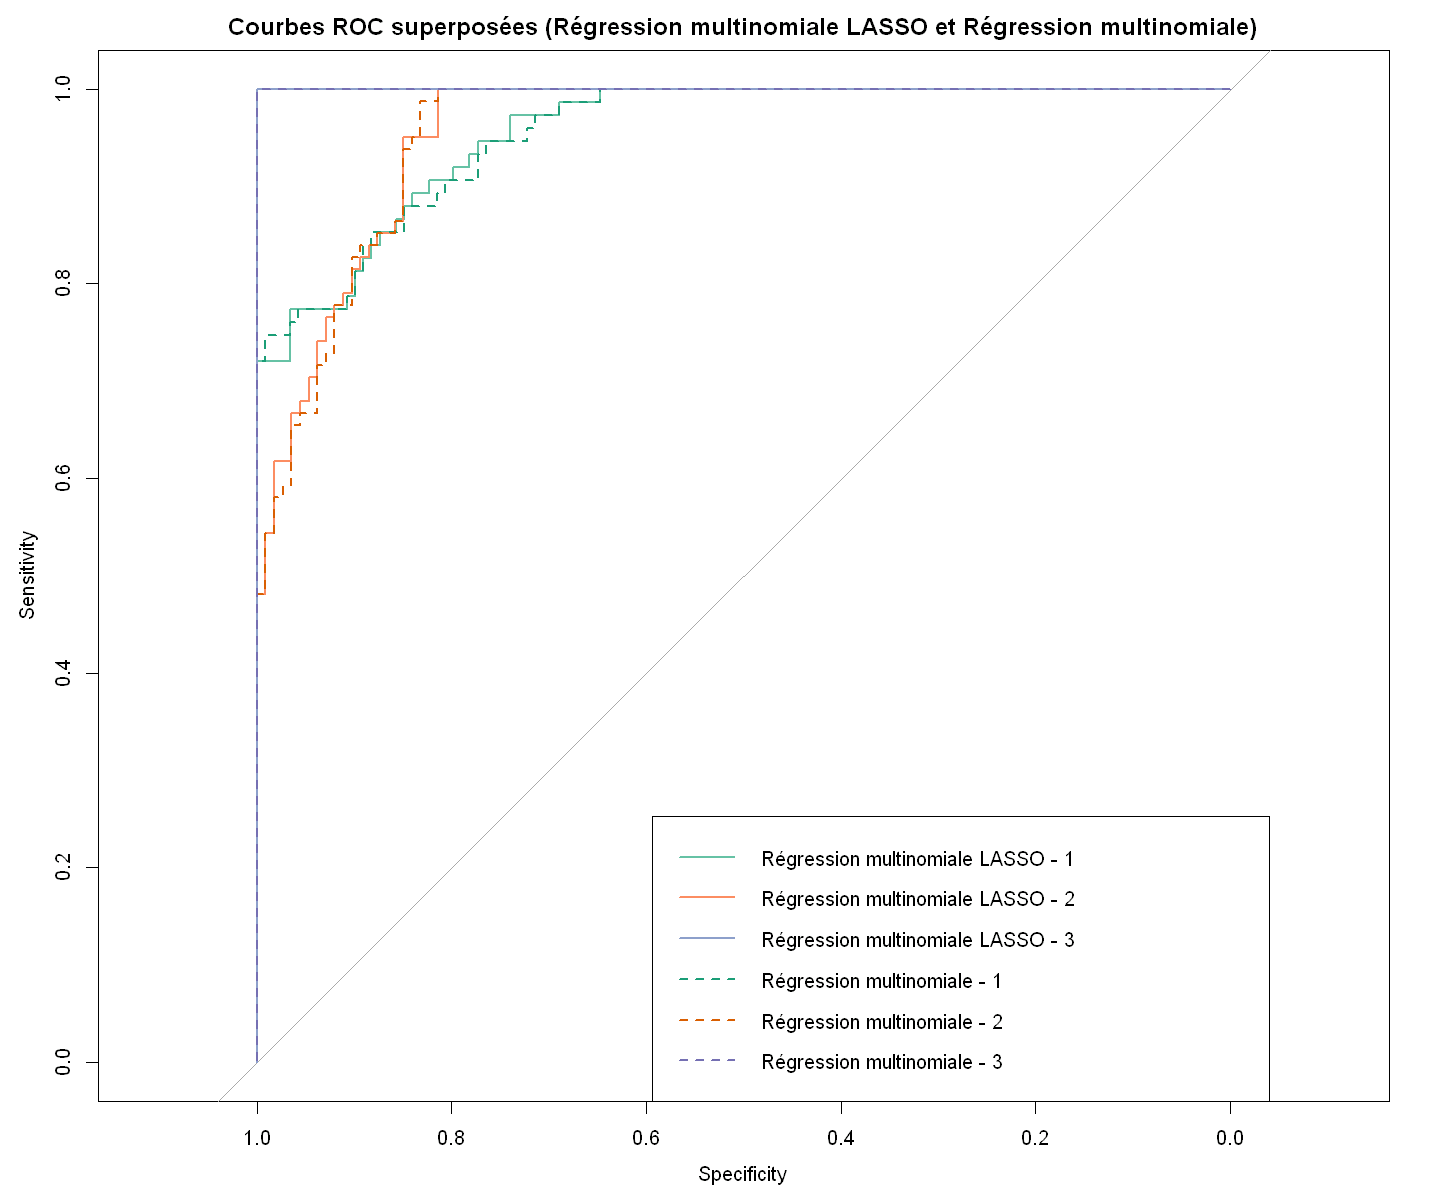

In [195]:
pred_probs <- predict(lasso_model, newx = x_test, type = "response")

proba_lasso <- pred_probs[,,1]
proba_lasso <- as.data.frame(proba_lasso)
colnames(proba_lasso) <- c("1", "2", "3")

pred_class <- apply(pred_probs, 1, which.max)
true_class <- apply(y_test, 1, which.max)


conf_matrix_lasso <- table(Predicted = pred_class, Actual = true_class)
print(conf_matrix_lasso)
pourcentage_erreur(conf_matrix_lasso)

plot_superposed_roc_curves(proba_lasso, "Régression multinomiale LASSO",proba_multinom,"Régression multinomiale")

Comme on pouvait s'y attendre, la sélection de variables à l'aide de la méthode LASSO permet effectivement d'éviter le surajustement et d'avoir un modèle plus précis. Les graphique comportant les courbes ROC nous permet de vérifier cela : les courbes ROC du modèle avec sélection de variables sont souvent au-dessus de celles obtenues avec l'autre modèle.

**Elastic net** (Ridge + Lasso)

La méthode *Elastic Net* introduit simultanément la pénalité $l1$ et $l2$ :

$\mathcal{L}(\boldsymbol{\beta}) = - \sum_{i=1}^{n} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right] + \lambda \left( \alpha \|\boldsymbol{\beta}\|_1 + (1 - \alpha) \|\boldsymbol{\beta}\|_2^2 \right) \quad \text{avec} \quad \lambda \in \mathbb{R}^{+}, \; \alpha \in [0, 1]$.\
\


On va ici chercher à optimiser 2 paramètres : $\alpha$ et $\lambda$ Pour $\lambda$, on va opérer de la même manière que précédemment. Concernantr $\alpha$ il faut s'y prendre "à la main" (en effectuant une boucle *for*). On utilisera encore une fois une validation croisée pour optimiser ces hyperparamètres.

In [196]:
set.seed(1234)

# Grille de valeurs alpha à tester
alphas <- seq(0, 1, by = 0.1)  

results <- data.frame(alpha = alphas, cv_error = NA, lambda = NA)

for (i in seq_along(alphas)) {
  set.seed(1234)
  cv_fit <- cv.glmnet(
    x, y,
    family = "multinomial",
    alpha = alphas[i],
    type.measure = "class",
    nfolds = 10
  )
  results$cv_error[i] <- min(cv_fit$cvm)
  results$lambda[i] <- cv_fit$lambda.min
}

print(results)

# Choisir le meilleur alpha et lambda
best_index <- which.min(results$cv_error)
best_alpha <- results$alpha[best_index]
best_lambda <- results$lambda[best_index]

print(paste("Valeur de alpha retenu : ", best_alpha, sep=""))
print(paste("Valeur de lambda retenu : ",best_lambda, sep=""))

# Ajuster le modèle final avec les meilleurs paramètres
final_model <- glmnet(
  x, y,
  family = "multinomial",
  alpha = best_alpha,
  lambda = best_lambda
)

   alpha  cv_error      lambda
1    0.0 0.1206675 0.038605314
2    0.1 0.1168164 0.025399719
3    0.2 0.1181001 0.012699859
4    0.3 0.1155327 0.004844884
5    0.4 0.1168164 0.003987941
6    0.5 0.1181001 0.003842791
7    0.6 0.1181001 0.003514549
8    0.7 0.1193838 0.003628531
9    0.8 0.1193838 0.002188380
10   0.9 0.1206675 0.002571475
11   1.0 0.1232349 0.010253910
[1] "Valeur de alpha retenu : 0.3"
[1] "Valeur de lambda retenu : 0.00484488427542439"


In [197]:
print(coef(final_model))

$Experience_Level1
19 x 1 sparse Matrix of class "dgCMatrix"
                                         s0
                                2.827926222
Age                             .          
GenderMale                      .          
sWeight..kg.                    0.041286181
Height..m.                      0.113545372
Max_BPM                        -0.048051263
Avg_BPM                         0.146534202
Resting_BPM                    -0.004682949
Session_Duration..hours.       -0.801686807
sCalories_Burned               -0.785827300
Workout_TypeHIIT                .          
Workout_TypeStrength           -0.057440040
Workout_TypeYoga               -0.140308588
BCFat_Percentage                0.598366450
Water_Intake..liters.           .          
Workout_Frequency..days.week.3 -0.972007385
Workout_Frequency..days.week.4 -4.631718026
Workout_Frequency..days.week.5 -0.888454961
sBMI                            .          

$Experience_Level2
19 x 1 sparse Matrix of class "dgCMatri

Certains coefficeints se sont annulés. Cela reste plus interprétable que le modèle de base, mais un peu moins que le modèle avec LASSO.

         Actual
Predicted  1  2  3
        1 66 18  0
        2  9 63  0
        3  0  0 38
[1] "Pourcentage d'erreur : 13.92 %"


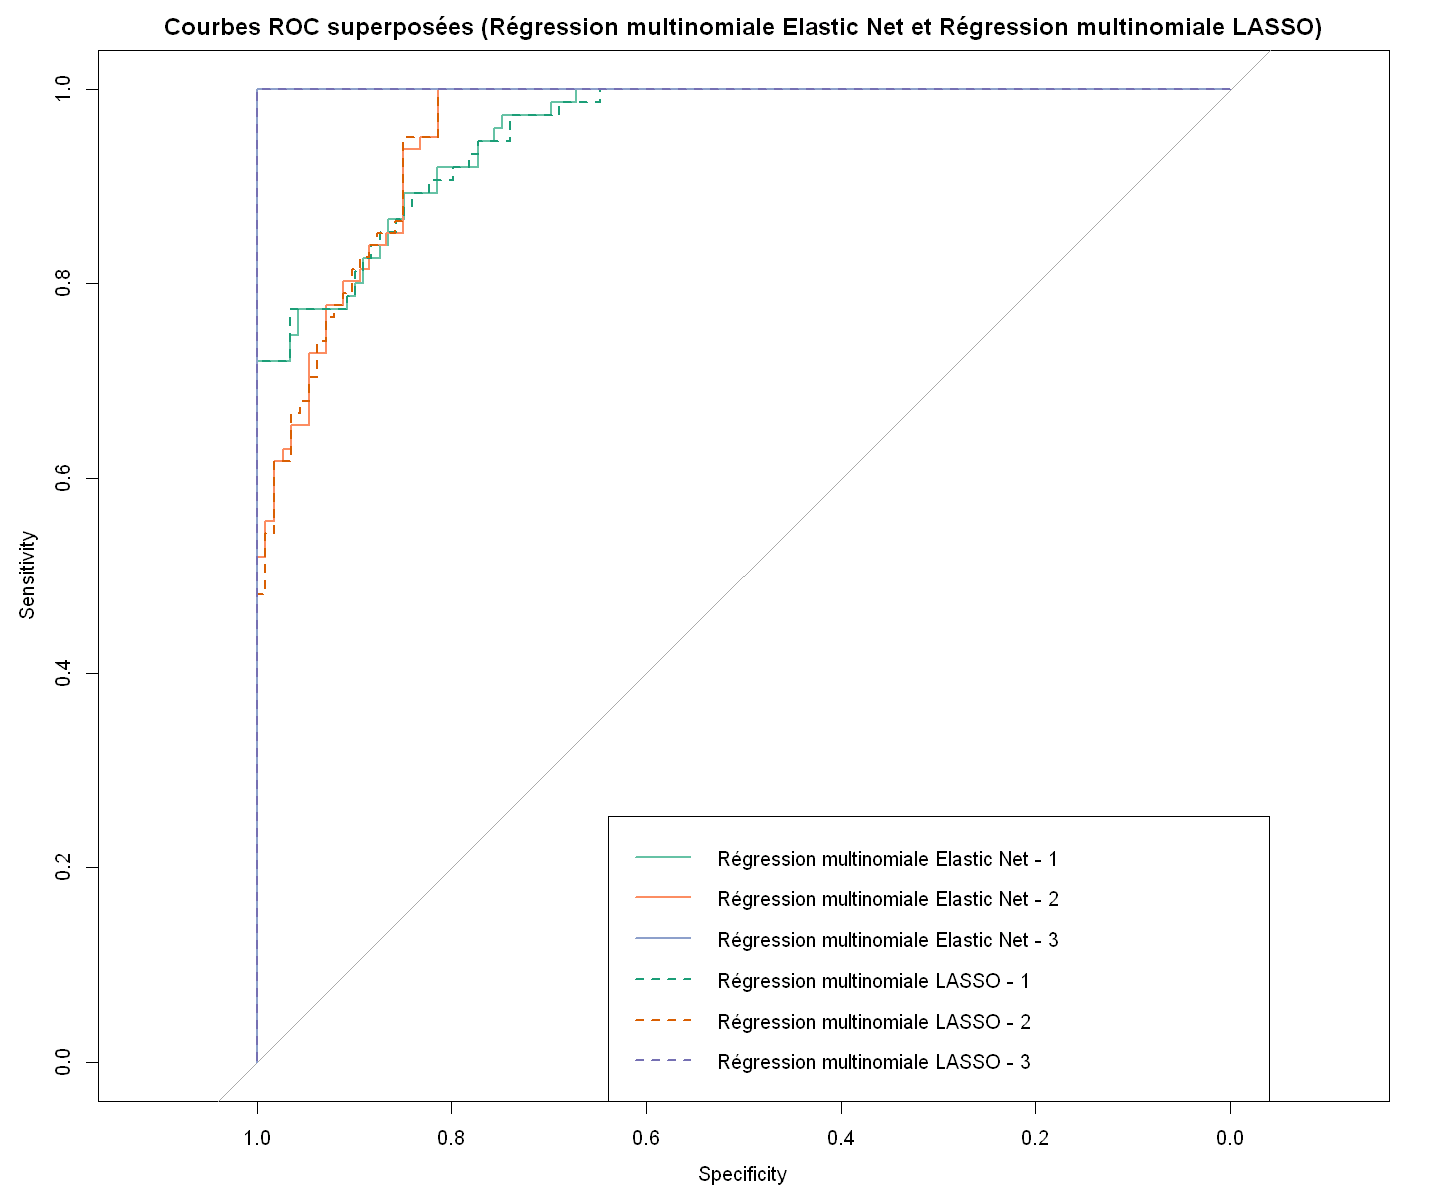

In [198]:
pred_probs <- predict(final_model, newx = x_test, type = "response")

proba_elastic <- pred_probs[,,1]
proba_elastic <- as.data.frame(proba_elastic)
colnames(proba_elastic) <- c("1", "2", "3")

pred_class <- apply(pred_probs, 1, which.max)
true_class <- apply(y_test, 1, which.max)


conf_matrix_elastic <- table(Predicted = pred_class, Actual = true_class)
print(conf_matrix_elastic)
pourcentage_erreur(conf_matrix_elastic)

plot_superposed_roc_curves(proba_elastic, "Régression multinomiale Elastic Net",proba_lasso,"Régression multinomiale LASSO")

Le pourcentage d'erreur de cette méthode est le même que pour le modèle précédent (LASSO). Aussi, les courbes ROC ne permettent pas de déterminer un modèle meilleur qu'un autre. Le critère d'interprétabilité rend le modèle avec LASSO sans doute préférable.

# 2.2.2 Classification par analyse discriminante

**LDA**

La LDA n'offre aucune possibilité d'ajustement avec des hyperparamètres. Nous pouvons tout de même avoir accès à sa précision, et le *Cohen’s Kappa* (qui compare la précision du modèle à ce qu’on obtiendrait par un classement aléatoire).

In [199]:
set.seed(1234)

lda.fit <- train(Experience_Level ~ ., data = data_exp_norm, method="lda",trControl=param_train)

print(lda.fit)

Linear Discriminant Analysis 

779 samples
 14 predictor
  3 classes: '1', '2', '3' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 701, 701, 699, 701, 701, 701, ... 
Resampling results:

  Accuracy   Kappa    
  0.8807363  0.8128669



Le pourcentage d'erreur sur l'échantillon d'apprentissage est d'environ 12%. On devrait trouver une erreur du même ordre (très légérement supérieure) sur l'échantillon test. Aussi, le *Cohen’s Kappa* est plus grand que 1, ce qui confirme que la LDA offre bien un résultat meilleur qu'une répartition aléatoire.

   predictions_lda
     1  2  3
  1 64 11  0
  2 15 66  0
  3  0  0 38
[1] "Pourcentage d'erreur : 13.4 %"


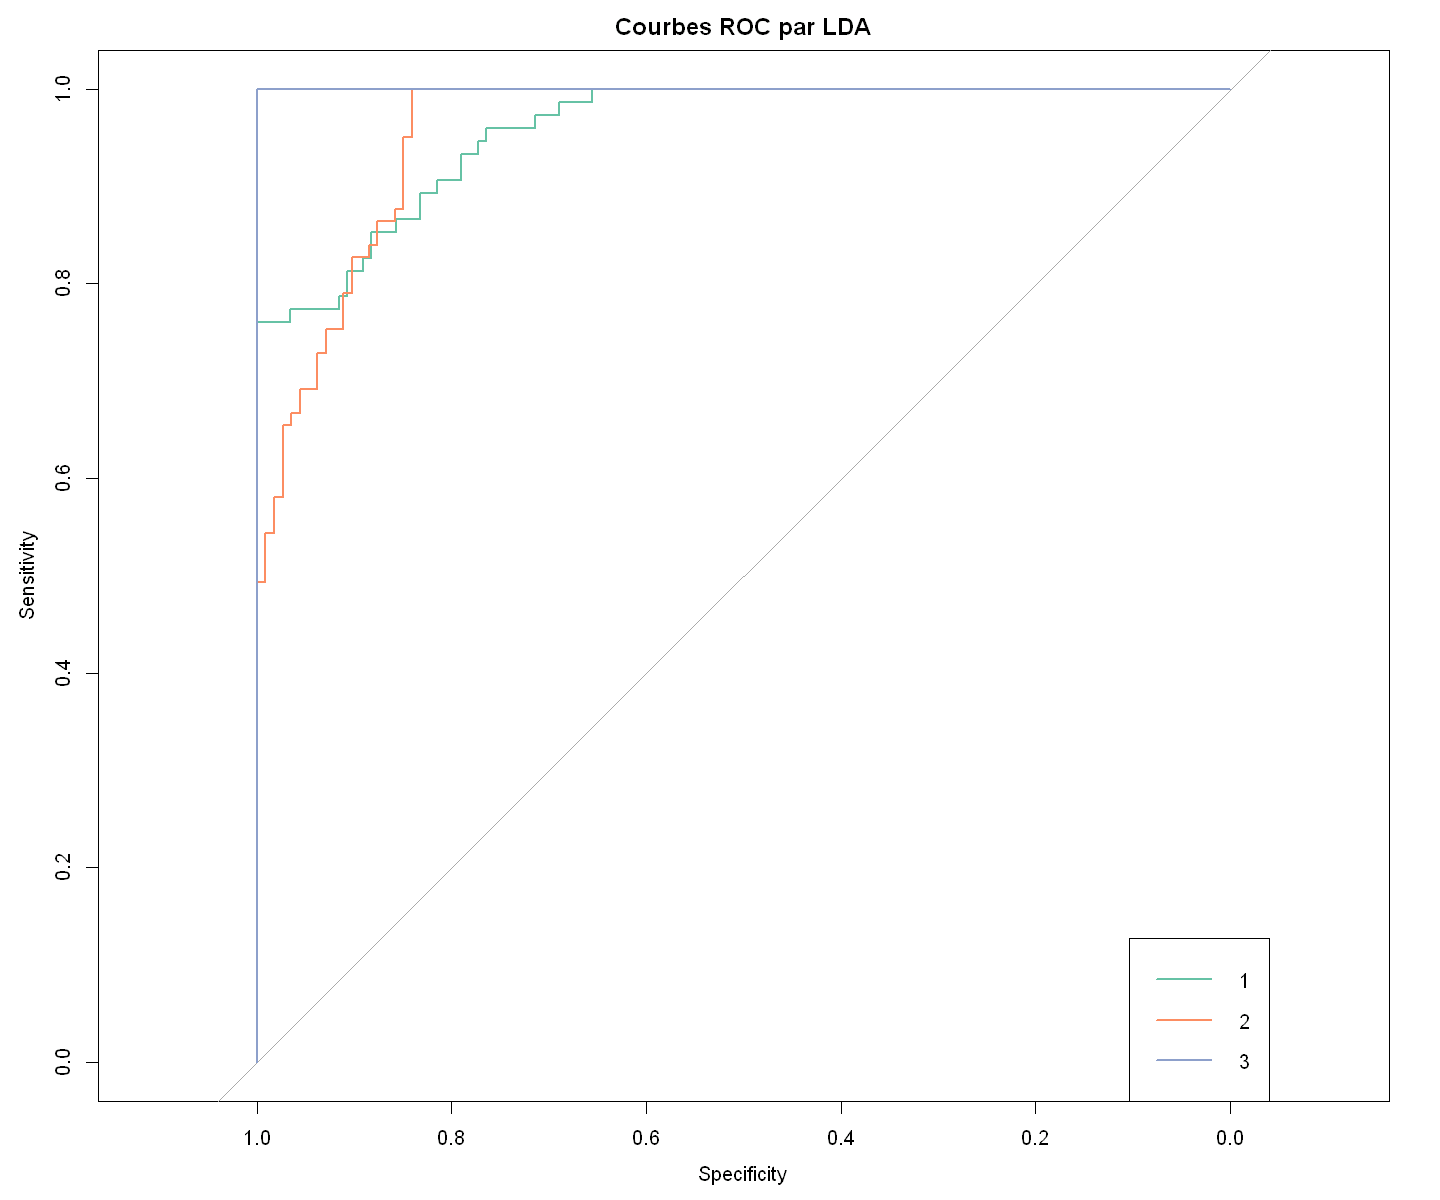

In [200]:
predictions_lda <-predict(lda.fit, data_test_norm[,-14])
proba_lda <-predict(lda.fit, data_test_norm[,-14], type="prob")


conf_matrix_lda=table(data_test_norm[,"Experience_Level"],predictions_lda)
print(conf_matrix_lda)
pourcentage_erreur(conf_matrix_lda)

plot_roc_curves(proba_lda, "LDA")

Le pourcentage d'erreur se situe toujours aux alentours de ce qui a été trouvé précédemment, et correspond plutôt bien à la valeur d'*Accuracy* observée par validation croisée. La méthode LDA semble assez robuste malgré sa simplicité. On peut observer le caractère linéaire de la méthode (et des frontières entre classes qui en résultent) à travers l'allure de sa courbe ROC.

**kNN**

La méthode des kNN possède un hyperparamètre : $k$, le nombre de voisins. Nous allons cherchons une valeur optimale de ce paramètre par validation croisée.

In [201]:
set.seed(1234)

# Ajustement du modèle avec validation croisée
knn.fit <- train(Experience_Level ~ ., data = data_exp_norm, method="knn",trControl=param_train,tuneLength=20)

print(knn.fit)
print(paste("Valeur de k retenu : ", knn.fit$bestTune, sep=""))

k-Nearest Neighbors 

779 samples
 14 predictor
  3 classes: '1', '2', '3' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 701, 701, 699, 701, 701, 701, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.7651623  0.6322192
   7  0.7818636  0.6577944
   9  0.7870392  0.6657332
  11  0.7844098  0.6617255
  13  0.7946520  0.6776654
  15  0.7856610  0.6632828
  17  0.7804354  0.6550184
  19  0.7832276  0.6591377
  21  0.7780174  0.6510774
  23  0.7869585  0.6650644
  25  0.7869739  0.6648869
  27  0.7921354  0.6727324
  29  0.7946828  0.6767682
  31  0.7986443  0.6827994
  33  0.7947969  0.6766389
  35  0.7921687  0.6727106
  37  0.7946520  0.6763044
  39  0.8023135  0.6883142
  41  0.7959353  0.6785133
  43  0.7895072  0.6679667

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 39.
[1] "Valeur de k retenu : 39"


   predictions_knn
     1  2  3
  1 40 34  1
  2 13 67  1
  3  0  0 38
[1] "Pourcentage d'erreur : 25.26 %"


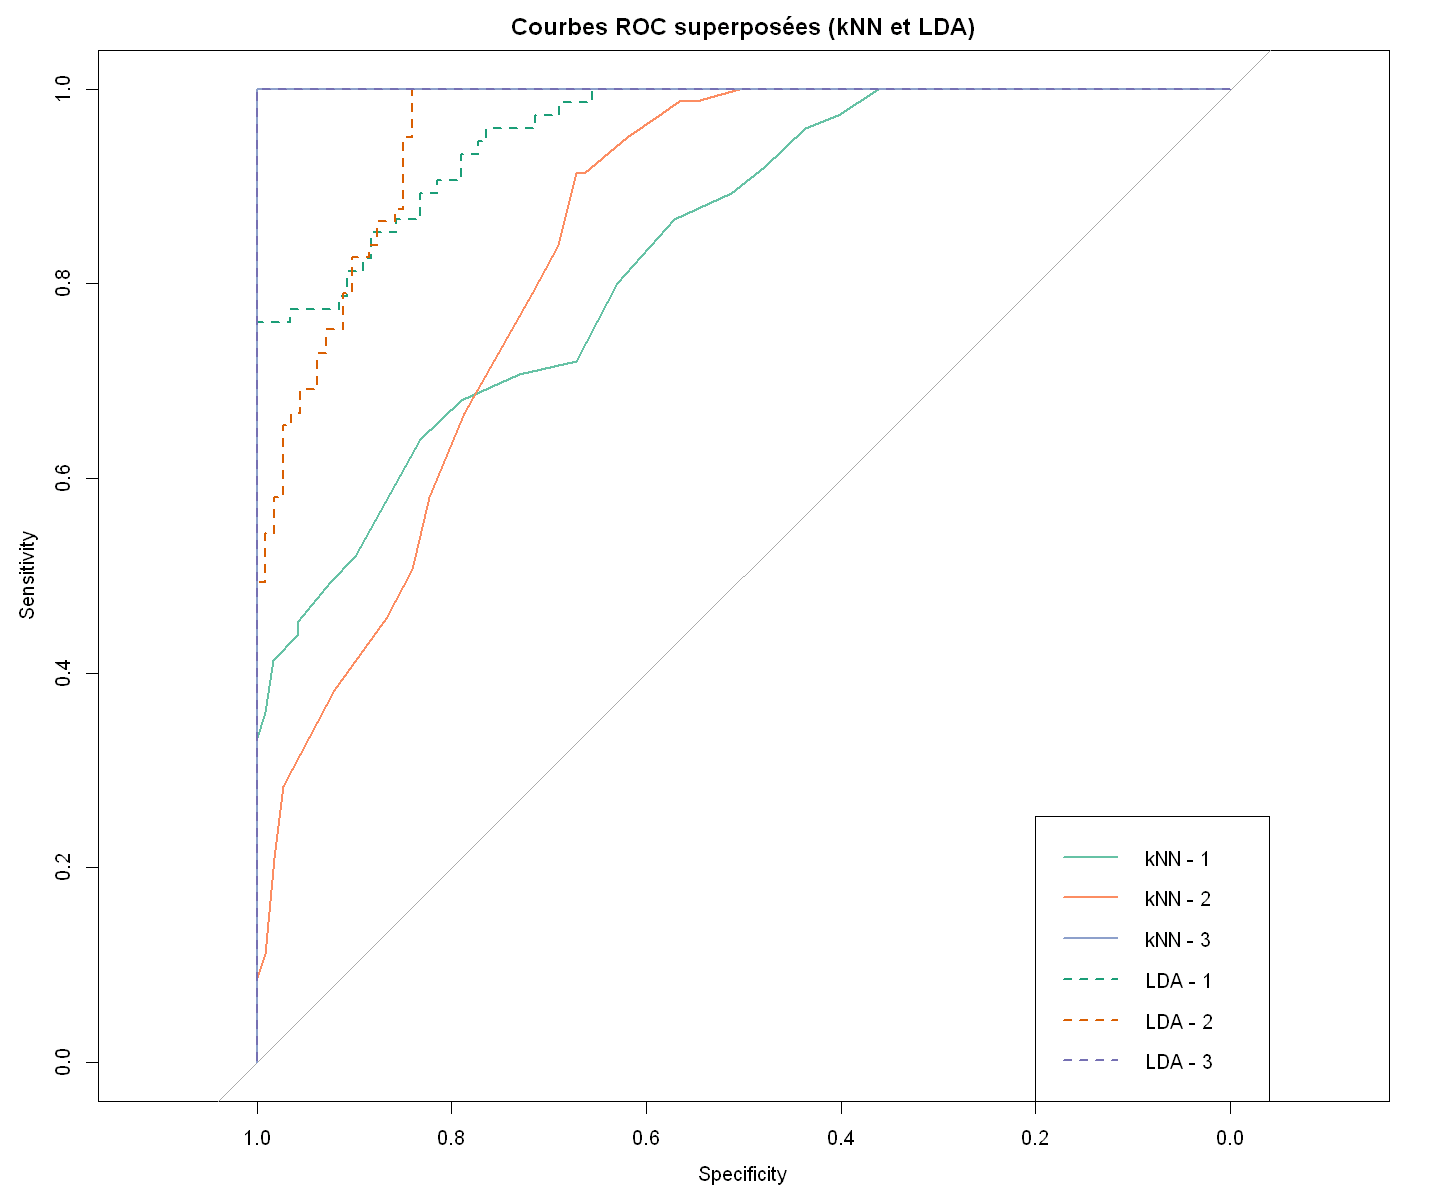

In [202]:
predictions_knn <-predict(knn.fit, data_test_norm[,-14])
proba_knn <-predict(knn.fit, data_test_norm[,-14], type="prob")


conf_matrix_knn=table(data_test_norm[,"Experience_Level"],predictions_knn)
print(conf_matrix_knn)
pourcentage_erreur(conf_matrix_knn)

plot_superposed_roc_curves(proba_knn, "kNN", proba_lda,"LDA")

Les résultats de la méthode kNN ne sont vraiment pas bons. Au vu de la simplicité de cet algorithme, le contraire aurait été étonannt. On remarque par ailleurs que ses frontières ne sont pas linéaires contrairement à la LDA.

# 2.2.3 SVM 

**SVM Linéaire**

La SVM est un modèle qui comporte un hyperparamètre : le coût ($cost$). Ce dernier intervient pour pénaliser les individus qui ne sont pas du "bon côté" de l'hyperplan qui sépare les classes.

[1] "Valeur de cost retenu : 3"


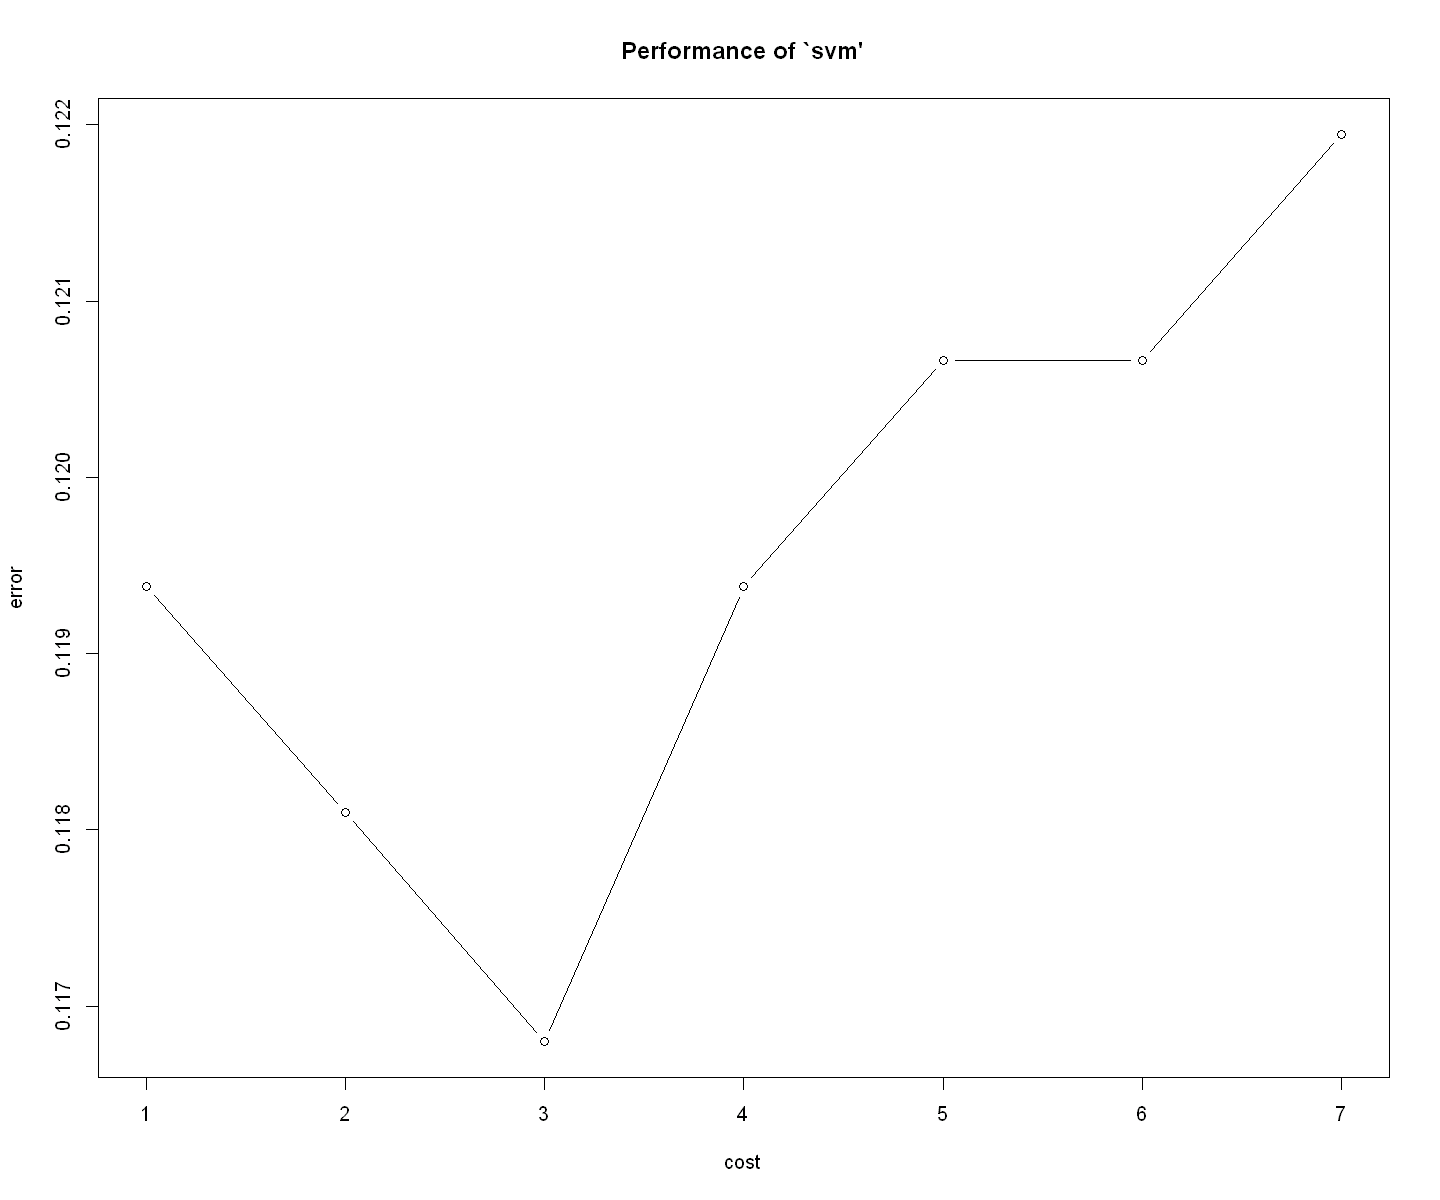

In [203]:
set.seed(1234)

QUICK <- FALSE

if (!QUICK) {
  # Ajustement du modèle avec validation croisée
  svm.lin.tune <- tune.svm(
    Experience_Level ~ ., 
    data = data_exp_norm, 
    cost = c(1, 2, 3, 4, 5, 6, 7), 
    kernel = "linear"
  )
  
  plot(svm.lin.tune)
  print(paste("Valeur de cost retenu : ", svm.lin.tune$best.parameters, sep=""))
  
} else {
  svm.lin.tune <- list(best.parameters = list(cost = 3))
}

   pred.svm.lin
     1  2  3
  1 62 13  0
  2 16 65  0
  3  0  0 38
[1] "Pourcentage d'erreur : 14.95 %"


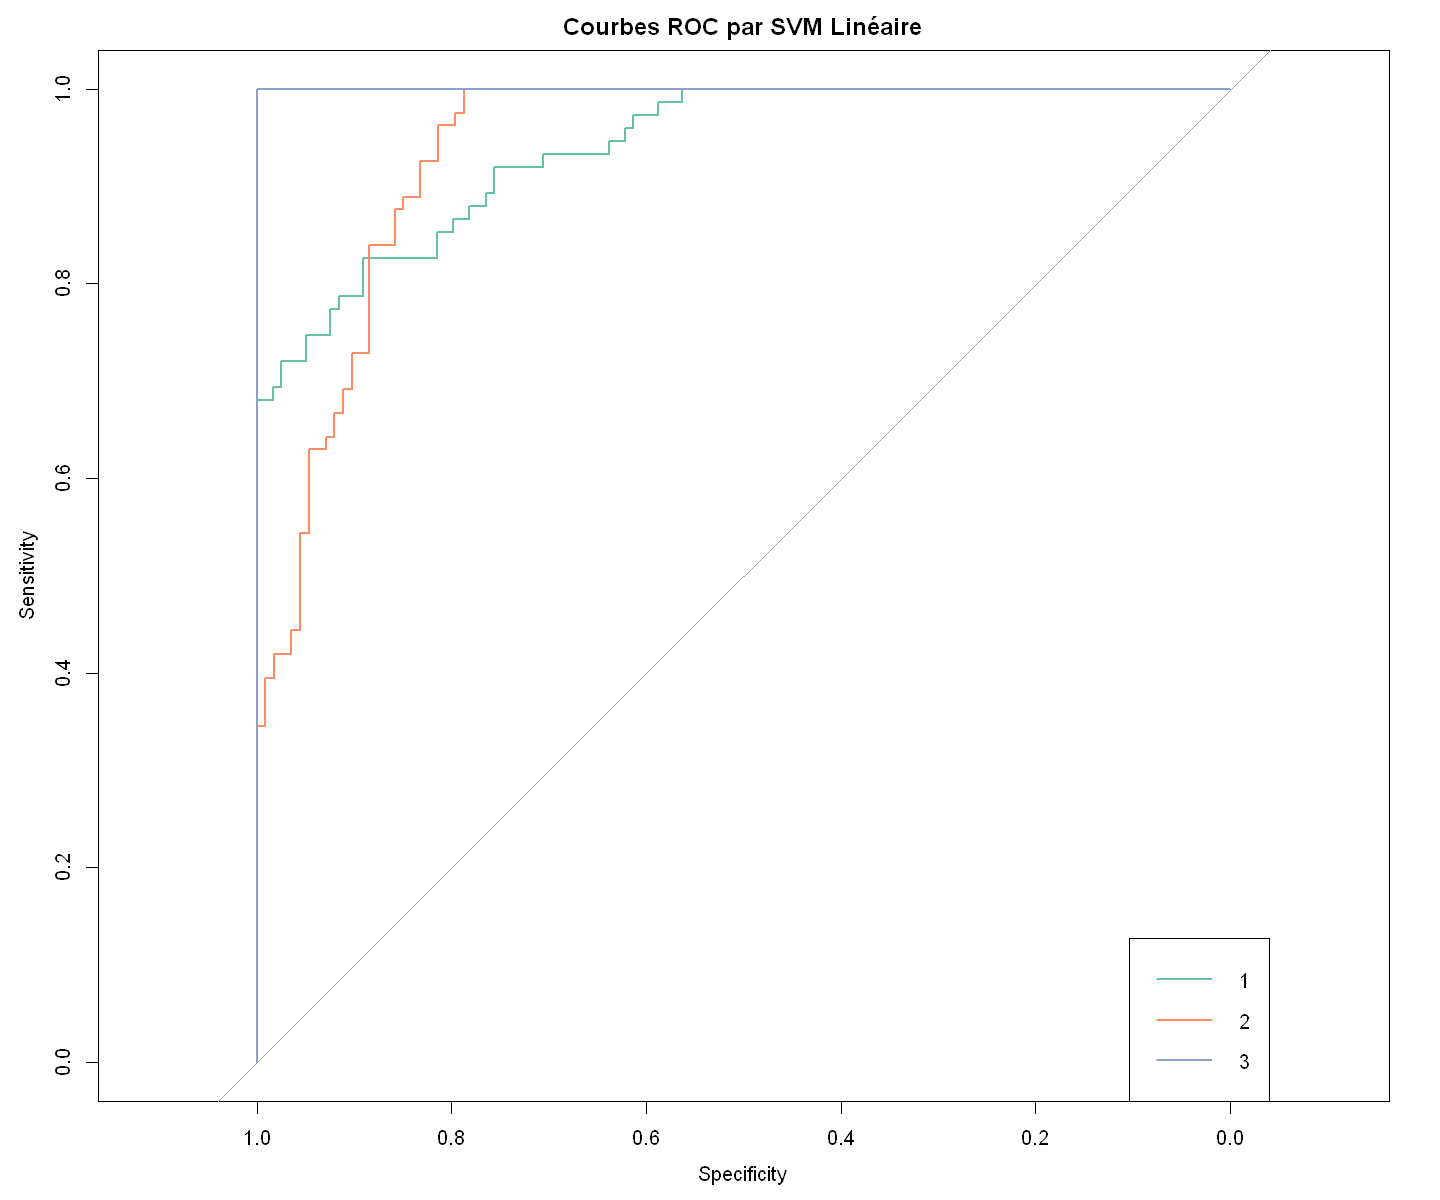

In [204]:
svm.lin = svm(Experience_Level ~ ., data = data_exp_norm, 
              cost = svm.lin.tune$best.parameters$cost, 
              probability=TRUE)

pred.svm.lin=predict(svm.lin,newdata=data_test_norm[,-14],probability=TRUE)
proba_svm.lin <- attr(pred.svm.lin, "probabilities")
proba_svm.lin <- as.data.frame(proba_svm.lin)


conf_matrix_svm.lin=table(data_test[,"Experience_Level"],pred.svm.lin)
print(conf_matrix_svm.lin)
pourcentage_erreur(conf_matrix_svm.lin)

plot_roc_curves(proba_svm.lin, "SVM Linéaire")

Les résultats sont comparables à ceux obtenus à partir des autres méthodes, mêmes s'ils sont légérement moins bons. On remarque encore une fois la linéarité des frontières grâce aux courbes ROC. Nous allons continuer à explorer les modèles SVM afin de voir s'il n'est pas possbile d'améliorer ce score. 

**SVM kernel radial**

Nous testons ici de projeter les individus dans un espace de dimension plus élevée, à l'aide d'une fonction noyau. La fonction ici choisie est définie ainsi :\
\
$K(\mathbf{x}, \mathbf{x}') = \exp\left(-\gamma \|\mathbf{x} - \mathbf{x}'\|^2 \right) \quad, \gamma > 0$\
\
Nous avons ici un nouvel hyperparamètre a optimisé : $\gamma$. A noter que dans le cas linéaire, la fonction noyau considéré était la suivante :\
\
$K(\mathbf{x}, \mathbf{x}') =x \times x'$.


[1] "Valeur de cost retenu : 3"
[1] "Valeur de gamma retenu : 0.015"


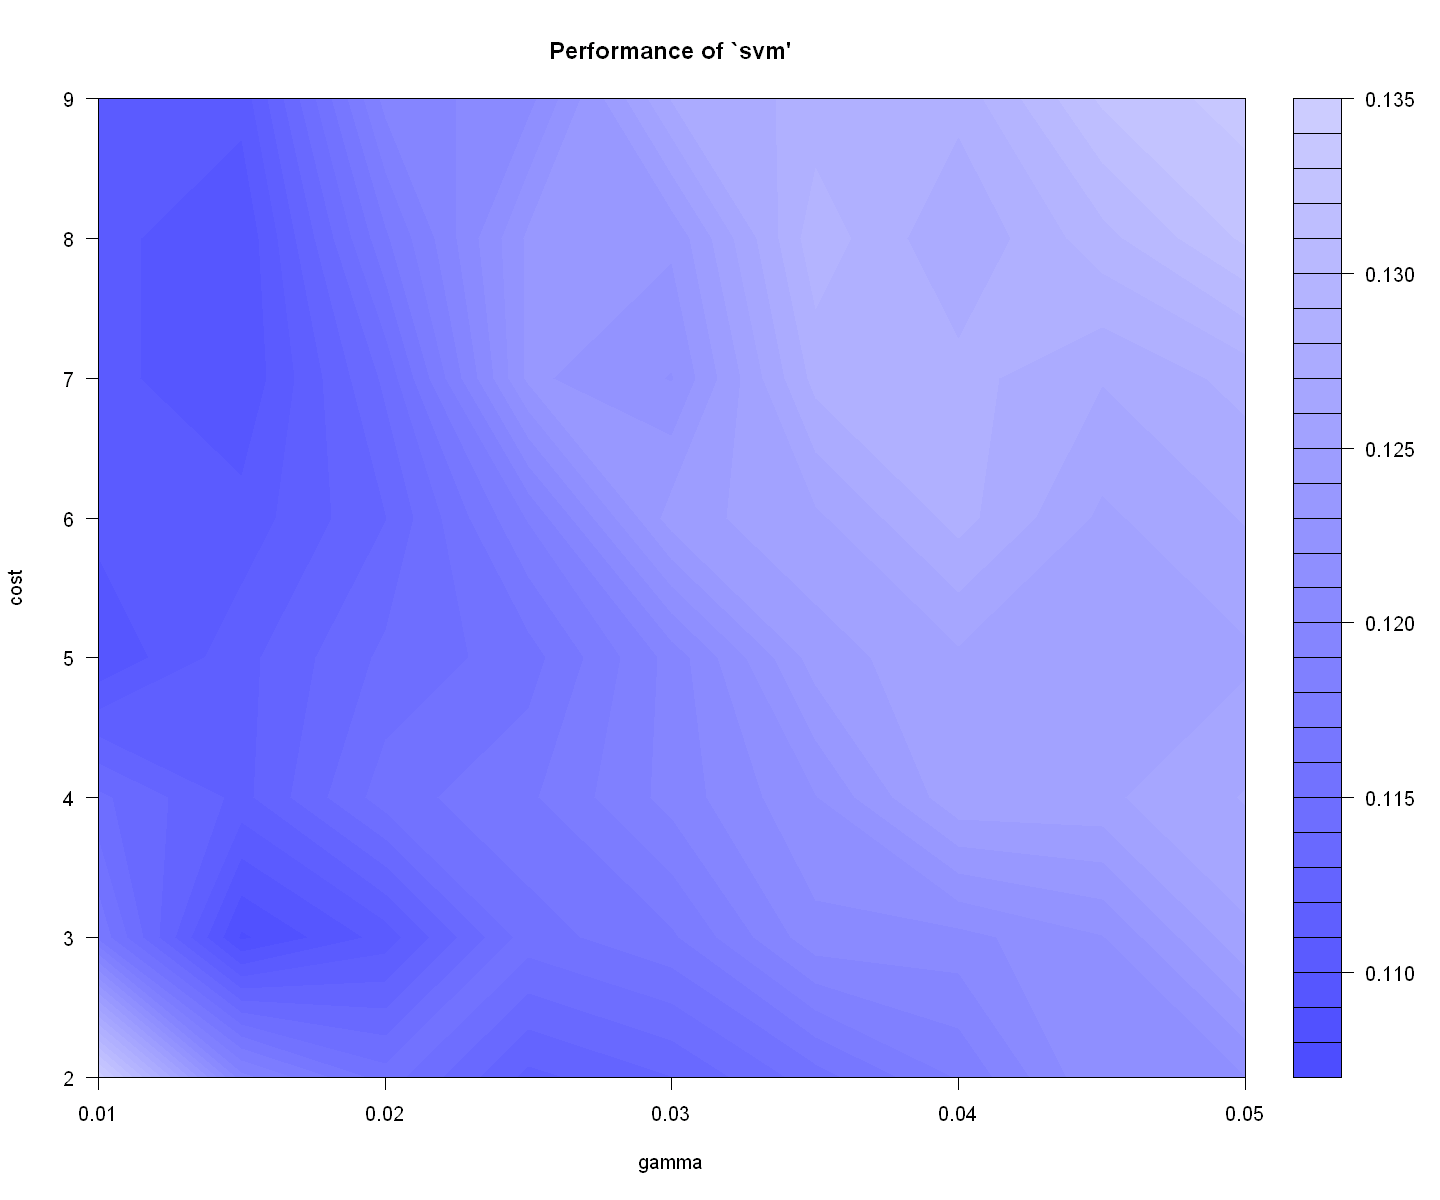

In [205]:
set.seed(1234)

QUICK <- FALSE

if (!QUICK) {
  # Ajustement du modèle avec validation croisée
  svm.rad.tune <- tune.svm(Experience_Level ~ ., data = data_exp_norm, 
                          cost = c(2,3,4,5,6,7,8,9), 
                          gamma = seq(0.01, 0.05, by = 0.005), 
                          kernel = "radial")
  plot(svm.rad.tune)
  print(paste("Valeur de cost retenu : ", svm.rad.tune$best.parameters$cost, sep=""))
  print(paste("Valeur de gamma retenu : ", svm.rad.tune$best.parameters$gamma, sep=""))
    
} else {
  svm.rad.tune <- list(best.parameters = list(cost = 3, gamma = 0.015))
}

   pred.svm.rad
     1  2  3
  1 62 13  0
  2 16 65  0
  3  0  0 38
[1] "Pourcentage d'erreur : 14.95 %"


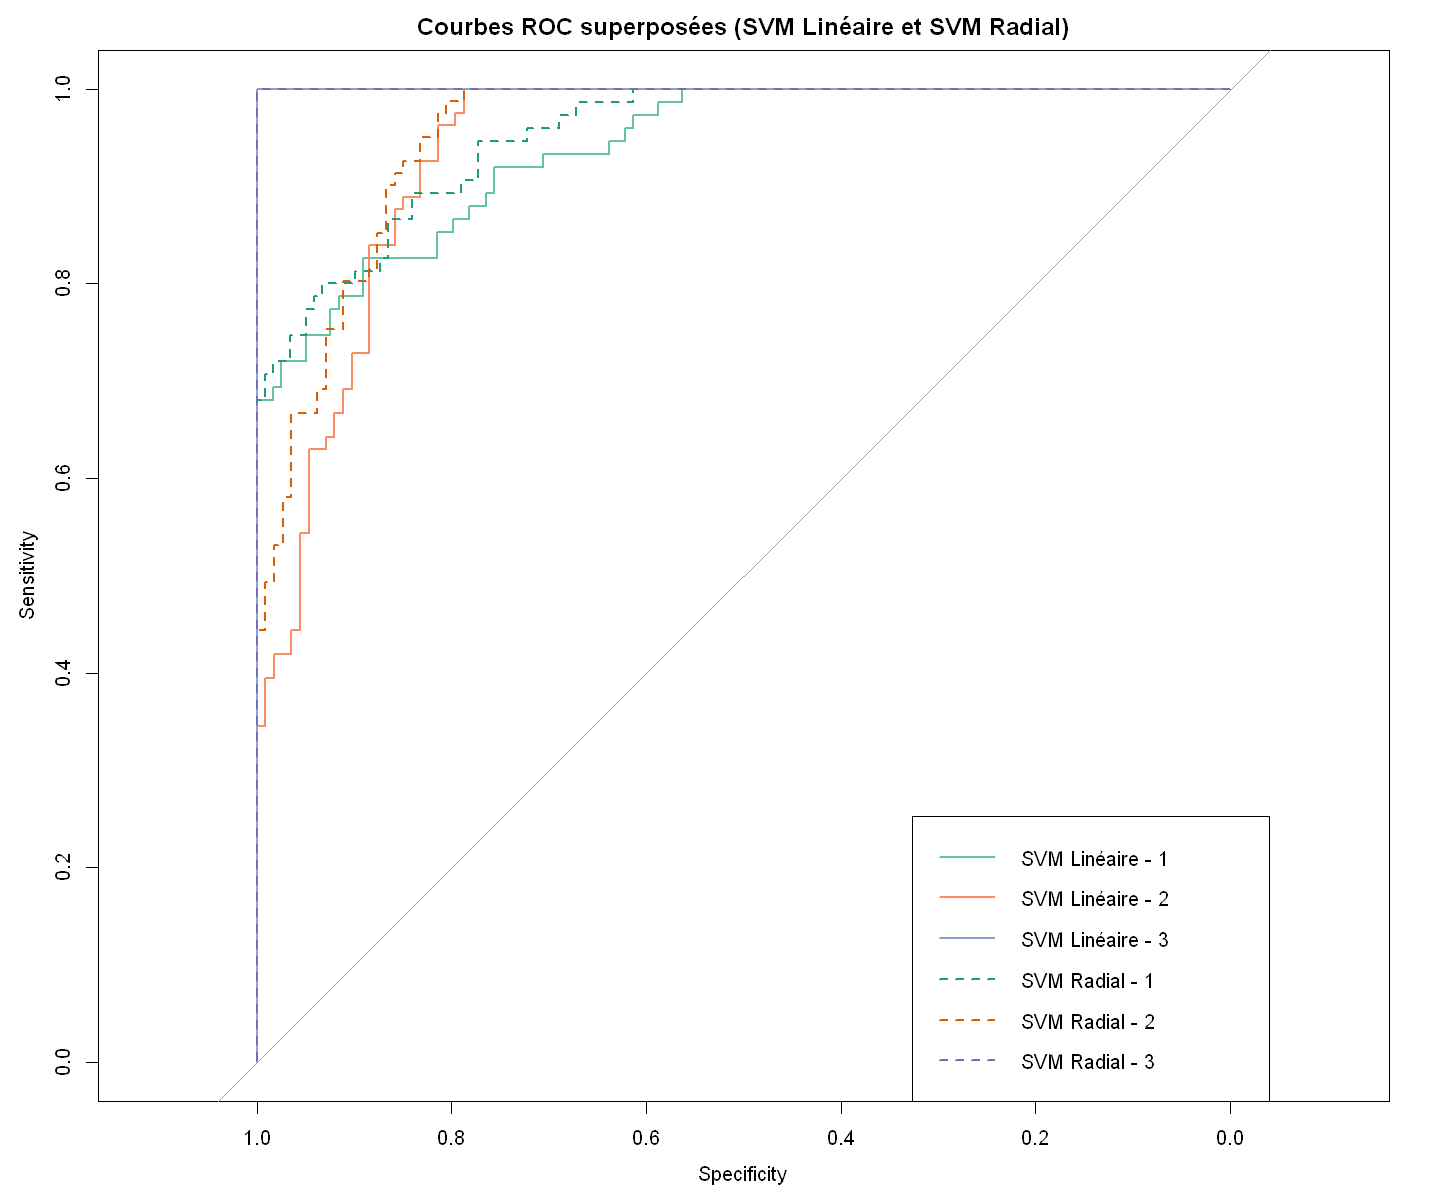

: 

In [ ]:
set.seed(1234)

svm.rad = svm(Experience_Level ~ ., data = data_exp_norm, 
              cost = svm.rad.tune$best.parameters$cost, 
              gamma = svm.rad.tune$best.parameters$gamma,
              probability=TRUE)

pred.svm.rad=predict(svm.rad,newdata=data_test_norm[,-14],probability=TRUE)
proba_svm.rad <- attr(pred.svm.rad, "probabilities")
proba_svm.rad <- as.data.frame(proba_svm.rad)


conf_matrix_svm.rad=table(data_test[,"Experience_Level"],pred.svm.rad)
print(conf_matrix_svm.rad)
pourcentage_erreur(conf_matrix_svm.rad)

plot_superposed_roc_curves(proba_svm.lin, "SVM Linéaire", proba_svm.rad,"SVM Radial")

Le pourcentage d'erreur est sensiblement le même que pour la SVM linéaire, mais les courbes ROC de la SVM avec noyau radial sont presque toujours au-dessus de celles de la SVM linéaire. Ce modèle est donc considéré comme meilleur.

**SVM Kernel Polynomial**

La fonction noyau ici considérée est définie ainsi :

$K(\mathbf{x}, \mathbf{x}') = \left( \gamma\mathbf{x}^\top \mathbf{x}' + coef_0 \right)^{degree}$

Nous avons ici un total de 4 hyperparamètres à optimiser : $\gamma, degree, coef_0, cost$.

In [ ]:
set.seed(1234)

QUICK <- FALSE

if (!QUICK) {
  # Ajustement du modèle avec validation croisée
  svm.pol.tune <- tune.svm(Experience_Level ~ ., data = data_exp_norm,
                          kernel = "polynomial",
                          coef0 = c(0, 0.5, 1, 2),
                          degree = c(2, 3),
                          cost = seq(0.5, 3, by = 0.5),
                          gamma = seq(0.1, 0.4, by = 0.1))
  print(paste("Valeur de cost retenu : ", svm.pol.tune$best.parameters$cost, sep=""))
  print(paste("Valeur de gamma retenu : ", svm.pol.tune$best.parameters$gamma, sep=""))
  print(paste("Valeur de degree retenu : ", svm.pol.tune$best.parameters$degree, sep=""))
  print(paste("Valeur de coef0 retenu : ", svm.pol.tune$best.parameters$coef0, sep=""))
    
} else {
  svm.pol.tune <- list(best.parameters = list(cost = 0.5, gamma = 0.1, coef0=1, degree=2)) 
}

   pred.svm.pol
     1  2  3
  1 52 23  0
  2 19 62  0
  3  0  0 38
[1] "Pourcentage d'erreur : 21.65 %"


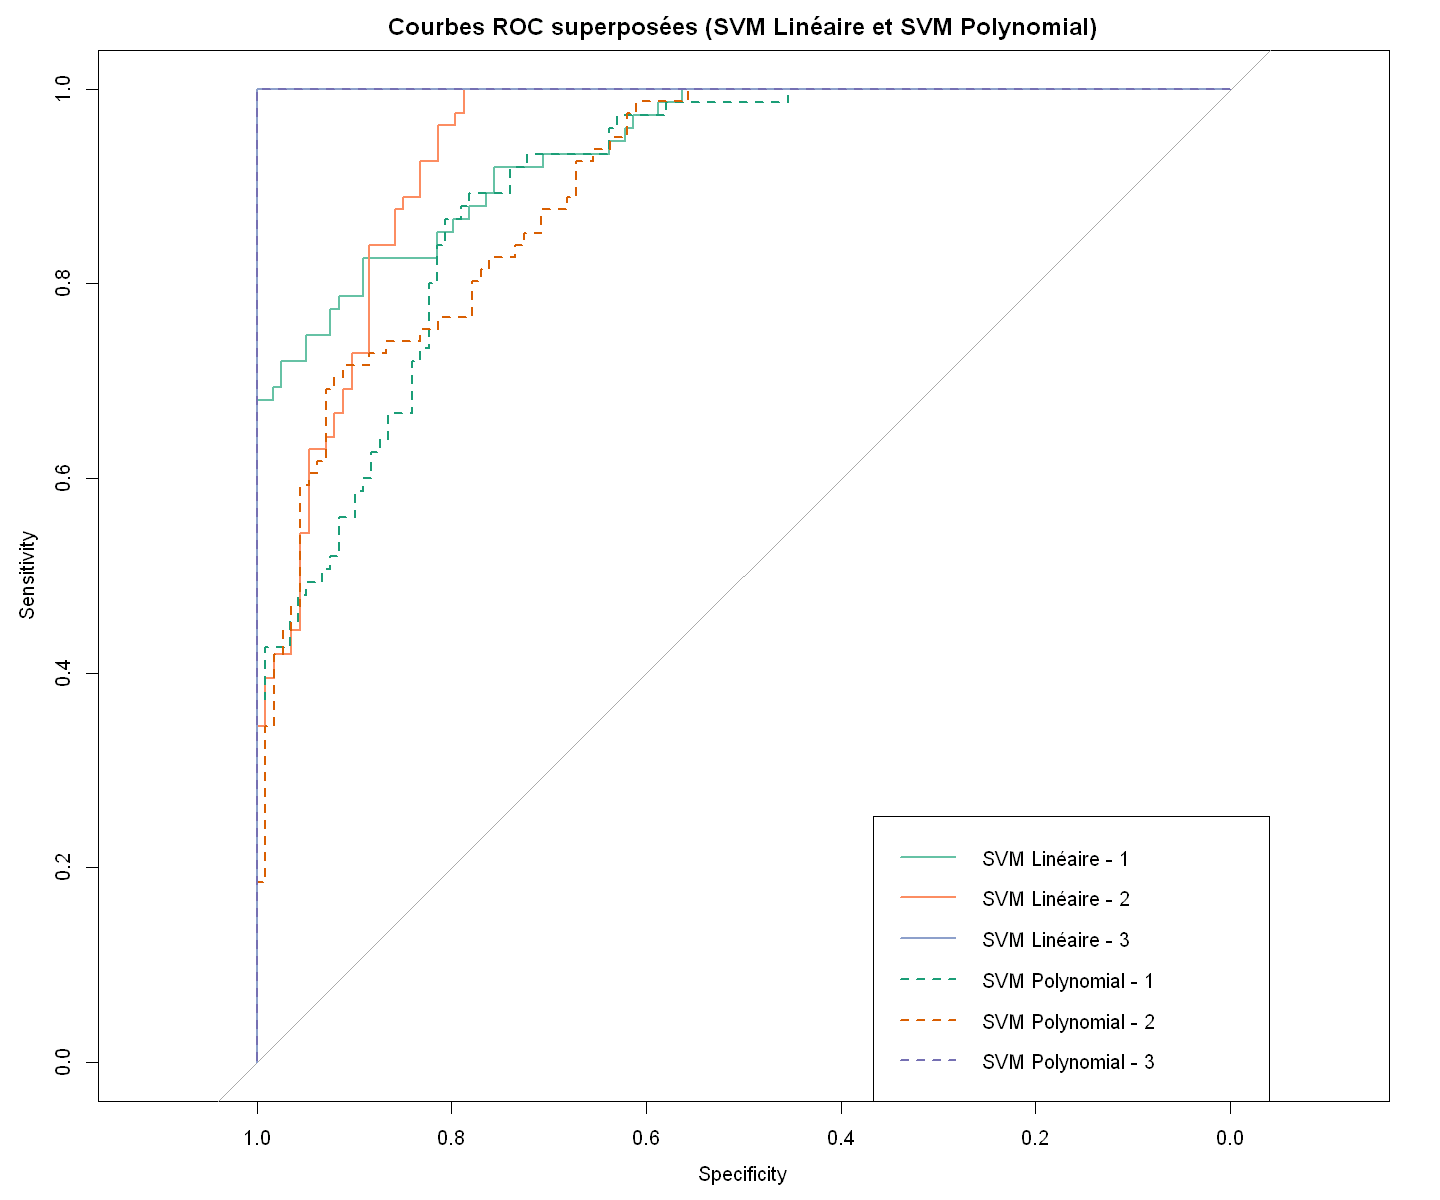

In [ ]:
svm.pol = svm(Experience_Level ~ ., data = data_exp_norm, kernel= "polynomial",
              cost = svm.pol.tune$best.parameters$cost, 
              gamma = svm.pol.tune$best.parameters$gamma,
              probability=TRUE)

pred.svm.pol=predict(svm.pol,newdata=data_test_norm[,-14],probability=TRUE)
proba_svm.pol <- attr(pred.svm.pol, "probabilities")
proba_svm.pol <- as.data.frame(proba_svm.pol)


conf_matrix_svm.pol=table(data_test_norm[,"Experience_Level"],pred.svm.pol)
print(conf_matrix_svm.pol)
pourcentage_erreur(conf_matrix_svm.pol)

plot_superposed_roc_curves(proba_svm.lin, "SVM Linéaire", proba_svm.pol,"SVM Polynomial")

Le calibrage des hyperparamètres de ce modèle est compliqué. Les résultats ne sont pas particulièrement satisfaisant ici, le noyau radial donnait de meilleurs résultats. Soit les données ne sont pas adaptées à l'usage de ce modèle, soit la recherche d'hyperparamètres n'a pas bien été calibrée.

# 2.2.4 Arbres et forêts aléatoires

**Abres binaires de décision** (CART)

La librairie *caret* permet d'obtenir la meilleure valeur pour l'hyperparamètre $cp$, correspondant à la complexité du modèle. Nous n'avons pas cherché à optimiser d'autres hyperparamètres, tels quel la profondeur maximale de l'arbre, ou encore le nombre minimal d'observations pour diviser une branche, afin d'avoir unmodèle CART "naïf" auquel nous pouvons comparer des modèles plus complexes basés sur les abres, dont nous pouvons régler ce paramètre.

[1] "Valeur de cp retenue = 0.0714120102017158"


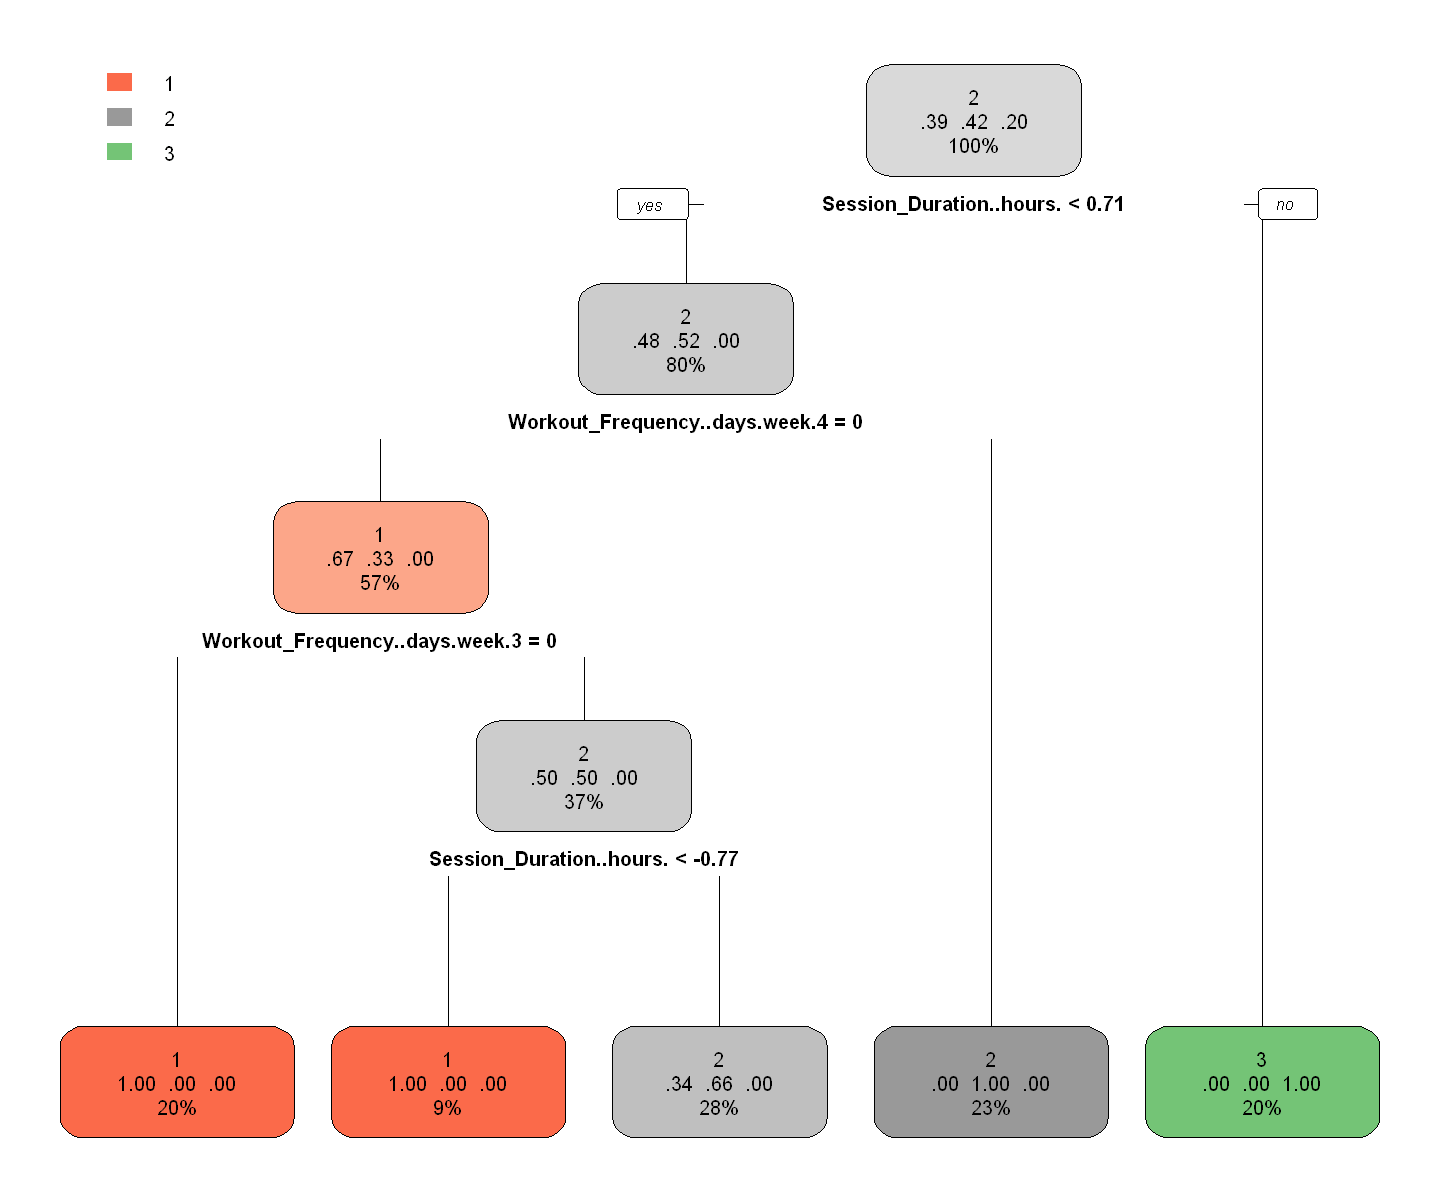

In [ ]:
set.seed(1234)

# Ajustement du modèle avec validation croisée
cart.fit <- train(Experience_Level~.,data=data_exp ,method = "rpart", trControl = param_train , tuneLength =20, metric="Accuracy")

rpart.plot(cart.fit$finalModel)
print(paste("Valeur de cp retenue = ", cart.fit$bestTune, sep=""))

In [ ]:
importance <- varImp(cart.fit$finalModel)
print(importance)

                                  Overall
Age                              1.606871
Avg_BPM                          8.157705
Calories_Burned                241.369860
Fat_Percentage                 185.019090
Max_BPM                          6.332478
Session_Duration..hours.       386.848725
Workout_Frequency..days.week.3  51.128116
Workout_Frequency..days.week.4 206.665661
Workout_Frequency..days.week.5  87.608208
GenderMale                       0.000000
Weight..kg.                      0.000000
Height..m.                       0.000000
Resting_BPM                      0.000000
Workout_TypeHIIT                 0.000000
Workout_TypeStrength             0.000000
Workout_TypeYoga                 0.000000
Water_Intake..liters.            0.000000
BMI                              0.000000


Les coefficients ci-dessus sont calculés à partir du nombre de fois où la variable intervient dans la division d'une branche, et de la réduction d'impureté à chaque division. \
\
Les 3 modalités de la variable **Workout_Frequency** ont toutes les 3 un coefficient plutôt important. Cette variable semble donc plutôt bien discriminé le niveau d'expérience des individus. Ce résultat rejoint celui esquissé par les modèles de régression multinomiale, qui nous permettait d'affirmer que plus un individu s'entraînait, plus il avait de chance d'avoir un niveau d'entraînement élevé.\
\
La variable **Session_Duration** affiche le plus grand coefficient ici. On peut aisément imaginer que plus un individu s's'entraîne longtemps, plus il a de chance d'avoir un niveau d'entraînement élevé.\
\
De même, les variables **Fat_Percentage** et **Calories_Burned** permettent bien de discriminer les individus d'après le modèle CART. Encore une fois, cela peut bien s'interpréter au vu du phénomène étudiée.\
\
Contrairement aux modèles de régression multinomiales, les variables liés à la **taille** et au **genre** ne sont pas utilisés par le modèle, et celle liée à l'**âge** a un coefficient très faible. 

   predictions_cart
     1  2  3
  1 56 19  0
  2  0 81  0
  3  0  0 38
[1] "Pourcentage d'erreur : 9.79 %"


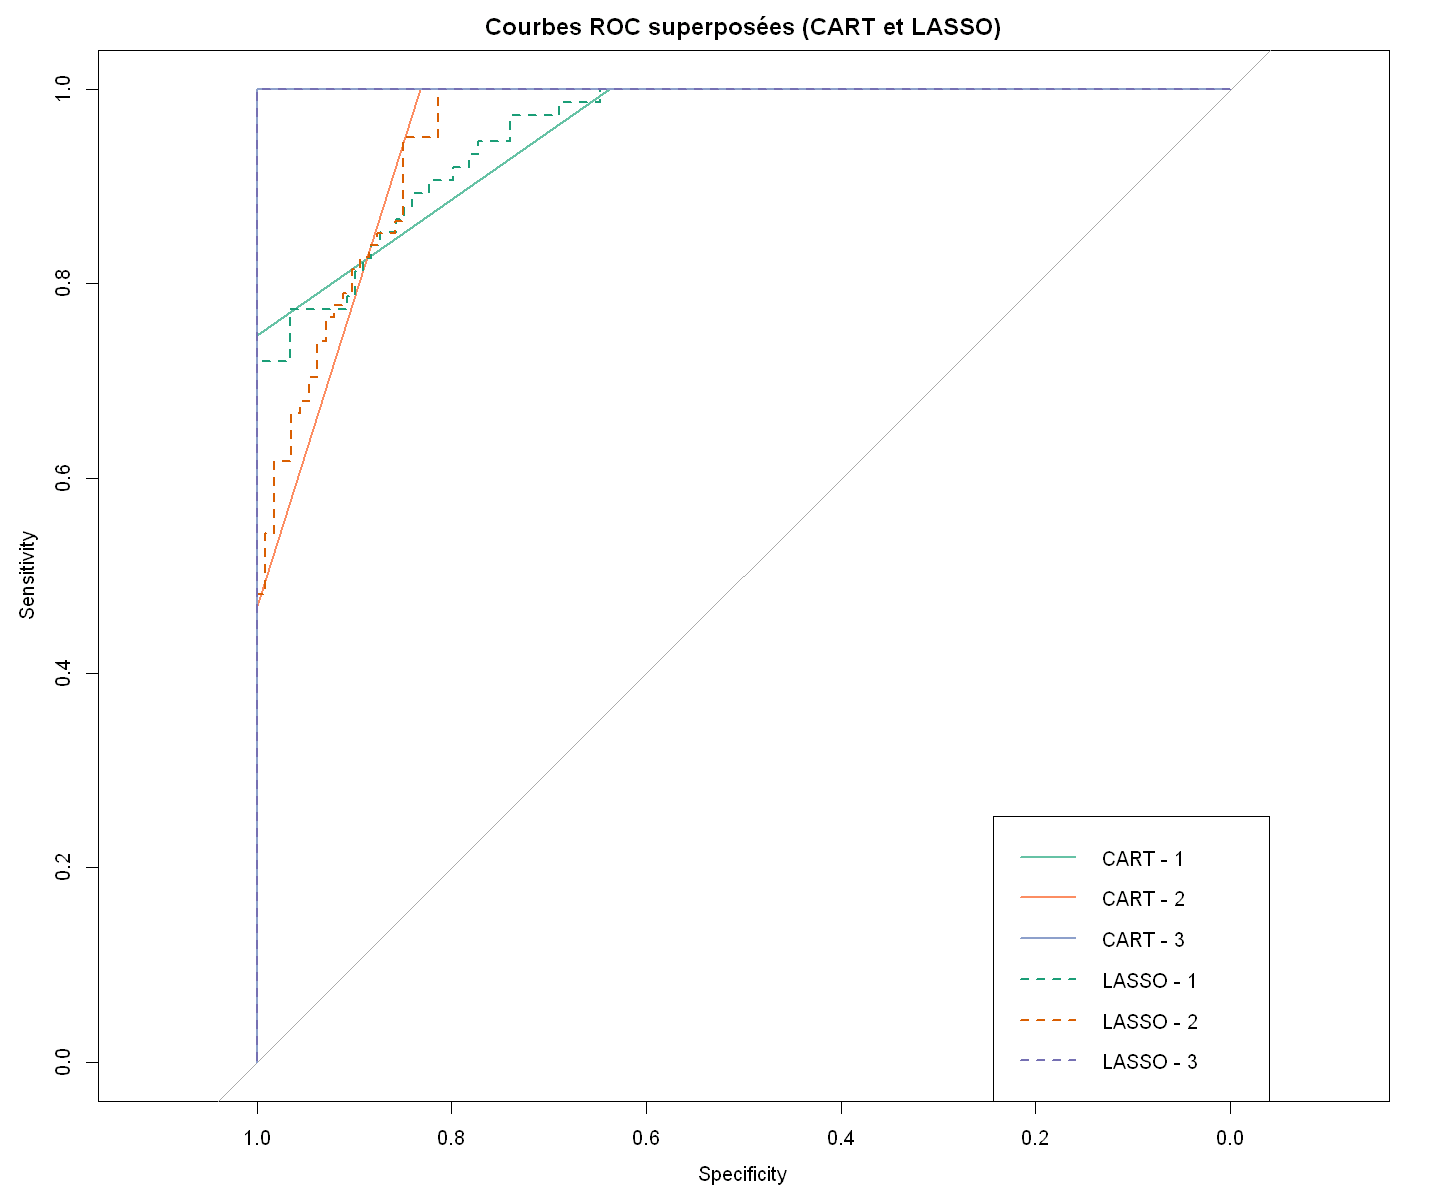

In [ ]:
predictions_cart <-predict(cart.fit, data_test[,-14])
proba_cart <-predict(cart.fit, data_test[,-14], type="prob")


conf_matrix_cart=table(data_test[,"Experience_Level"],predictions_cart)
print(conf_matrix_cart)
pourcentage_erreur(conf_matrix_cart)

plot_superposed_roc_curves(proba_cart, "CART", proba_lasso, "LASSO")

Le pourcentage d'erreur affiché par le modèle CART est significativement plus bas que pour les autres modèles. Si l'on regarde plus en détail, les courbes ROC du modèle CART n'affichent pour autant pas un si bon résultat contrairement à celles du modèle LASSO par exemple. 

**Forêts aléatoires**

Les forêts aléatoires se basent sur les arbres binaires de décisions, et possèdent de nombreux hyperparamètres. Nous n'en explorerons ici que 2 : le nombre d'arbres $ntree$, ainsi que le nombre de variables à étudier à chaque division $mtry$.

In [ ]:
QUICK <- FALSE

if (!QUICK) {
  ntree_grid <- c(100, 200, 300, 400, 500)  # nombre d’arbres
  mtry_grid <- c(2, 4, 6, 8, 10)            # nombre de variables à tester
  
  rf_models <- list()
  results <- data.frame()

  for (nt in ntree_grid) {
    set.seed(1234)
      
    # Ajustement du modèle avec validation croisée
    model <- train(
      Experience_Level ~ ., 
      data = data_exp,
      method = "rf",
      trControl = param_train,
      tuneGrid = expand.grid(mtry = mtry_grid),
      ntree = nt,
      metric = "Accuracy"
    )
    
    rf_models[[paste0("ntree_", nt)]] <- model

    # On récupère le meilleur modèle
    best <- model$results[which.max(model$results$Accuracy), ]
    best$ntree <- nt
    results <- rbind(results, best)
  }
    
} else {
  best_config <- list(ntree = 200, mtry = 8)
}

print(paste("Valeur de ntree retenue = ", best$ntree, sep=""))
print(paste("Valeur de mtry retenue = ", best$mtry, sep=""))

[1] "Valeur de ntree retenue = 500"
[1] "Valeur de mtry retenue = 10"


In [ ]:
rf.dis=randomForest(Experience_Level~., data=data_exp, xtest=data_test[,-14], ytest=data_test[,
   "Experience_Level"] ,ntree=best$ntree, mtry=best$mtry, nodesize=4 , importance=TRUE)

rf.dis$importance

,1,2,3,MeanDecreaseAccuracy,MeanDecreaseGini
Age,-0.0018416536,0.0003291253,0.0000000000,-0.0005648275,7.8203867
Gender,-0.0005448740,0.0002913944,0.0000000000,-0.0001004453,0.3521781
Weight..kg.,-0.0013355405,-0.0020477977,0.0005080645,-0.0012536479,7.3585211
Height..m.,-0.0016980815,-0.0010492272,0.0000000000,-0.0011053431,8.2325992
Max_BPM,0.0004292604,0.0005890534,0.0000000000,0.0004005662,8.7142845
Avg_BPM,-0.0013768264,-0.0010419721,0.0000000000,-0.0009895682,8.1032101
Resting_BPM,-0.0005221338,-0.0018184985,0.0000000000,-0.0009564018,5.6696418
Session_Duration..hours.,0.1592956335,0.2070393943,0.4976754318,0.2441710640,184.6140459
Calories_Burned,-0.0021739964,0.0152588411,0.0032666982,0.0060754245,20.5453565
Workout_Type,-0.0012225302,-0.0004420484,0.0000000000,-0.0006455228,3.4835706


Deux coefficients d'importance sont ici disponibles pour les variables : le $MeanDecreaseAccuracy$, et le $MeanDecreaseGini$, qui se basent sur des mesures de dissimilarités différentes.

Les observations concernant les variables **Workout_Frequency** et **Session_Duration** sont comparables à celles obtenues par modèle CART : ces deux variables discriminent plutôt bien les classes.  
\
De même, les variables **Fat_Percentage** et **Calories_Burned** semblent intervenir assez souvent dans le modèle de forêt aléatoires.
\
Les autres variables ont des coefficients non nuls mais d'un ordre de grandeur différents de ces quatres-là. Le modèle CART offrait une interprétation plus claire des résultats.

        
pred.rfq  1  2  3
       1 58  4  0
       2 17 77  0
       3  0  0 38


[1] "Pourcentage d'erreur : 10.82 %"


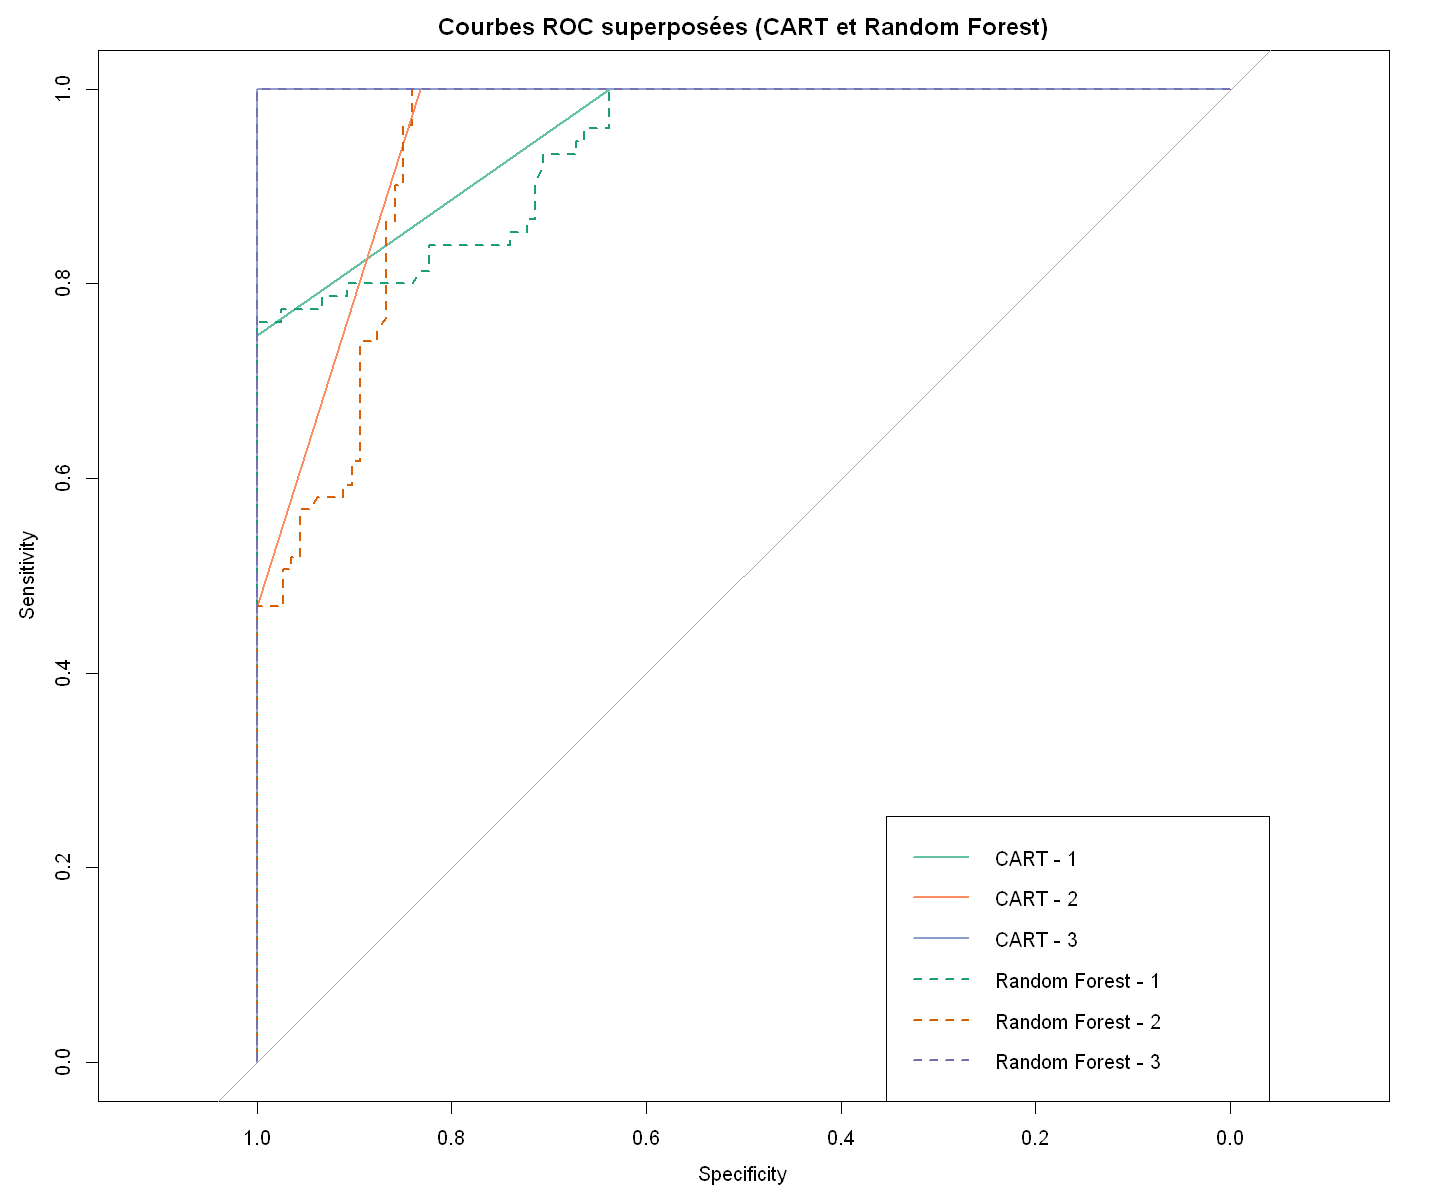

In [ ]:
pred.rfq=rf.dis$test$predicted
proba_forest = as.data.frame(rf.dis$test$votes)


conf_matrix_forest = table(pred.rfq,data_test[,"Experience_Level"])
print(conf_matrix_forest)
pourcentage_erreur(conf_matrix_forest)

plot_superposed_roc_curves(proba_cart, "CART", proba_forest, "Random Forest")

Comme l'on pouvait s'y attendre, les résultats du modèle de forêts aléatoires sont meilleurs que ceux du modèle CART. Nous avons gagné environ 1% de précision. Concernant les courbres ROC, les résultats sont différents : l'aire sous la courbe (**AUC**) des courbes ROC du modèle de forêts aléatoires est inférieure à celui du modèle CART. On peut alors avancer que le modèle de forêts aléatoires discriminent moins bien les individus, même si sa précision (au seuil s=0.5) est meilleure.

**Gradient Boosting Models** (library *gbm*)

On réalise ici du boosting, c'est-à-dire de l'aggrégation de modèle basé sur des arbres binaires, avec pour objectif de réduire la variance du modèle final. Pour ce modèle **GBM**, nous nous intéressons à 4 hyperparamètres :

- $n.trees$ : le nombre d'arbres à construire  
- $shrinkage$ : le taux d'apprentissage  
- $interaction.depth$ : la profondeur maximale des arbres  
- $n.minobsinnode$ : le nombre minimum d'individus dae feuille
ize}

In [ ]:
set.seed(1234)

QUICK <- FALSE

if (!QUICK) {
    
    # Définition de la grille de paramètres à tester
    grid <- expand.grid(
      n.trees = c(100, 200, 300, 400, 500),
      shrinkage = c(0.01, 0.03, 0.05),
      interaction.depth = c(3, 5, 7, 10),
      n.minobsinnode = c(1, 3, 5)
    )

    # Ajustement du modèle avec validation croisée
    gbm_tuned <- train(
      Experience_Level ~ ., data = data_exp_norm,
      method = "gbm",
      trControl = param_train,
      tuneGrid = grid,
      verbose = FALSE,
      distribution = "multinomial",
      metric = "Accuracy"
    )
    
} else {
    gbm_tuned <- list(bestTune=(list(ntree=100, shrinkage=0.01, interaction.depth=3, n.minobsinnode=3)))

    gbm_tuned <- train(
    Experience_Level ~ ., 
    data = data_exp_norm,
    method = "gbm",
    trControl = param_train,
    tuneGrid = expand.grid(
      n.trees = gbm_tuned$bestTune$ntree,
      shrinkage = gbm_tuned$bestTune$shrinkage,
      interaction.depth = gbm_tuned$bestTune$interaction.depth,
      n.minobsinnode = gbm_tuned$bestTune$n.minobsinnode
    ),
    verbose = FALSE,
    distribution = "multinomial",
    metric = "Accuracy"
  )
    }

print(paste("Valeur de ntree retenue = ", gbm_tuned$bestTune$ntree, sep=""))
print(paste("Valeur de shrinkage retenue = ", gbm_tuned$bestTune$shrinkage, sep=""))
print(paste("Valeur de interaction.depth retenue = ", gbm_tuned$bestTune$interaction.depth, sep=""))
print(paste("Valeur de n.minobsinnode retenue = ", gbm_tuned$bestTune$n.minobsinnode, sep=""))

[1] "Valeur de ntree retenue = "
[1] "Valeur de shrinkage retenue = 0.01"
[1] "Valeur de interaction.depth retenue = 3"
[1] "Valeur de n.minobsinnode retenue = 3"


    Prédit
Vrai  1  2  3
   1 56 19  0
   2  2 79  0
   3  0  0 38
[1] "Pourcentage d'erreur : 10.82 %"


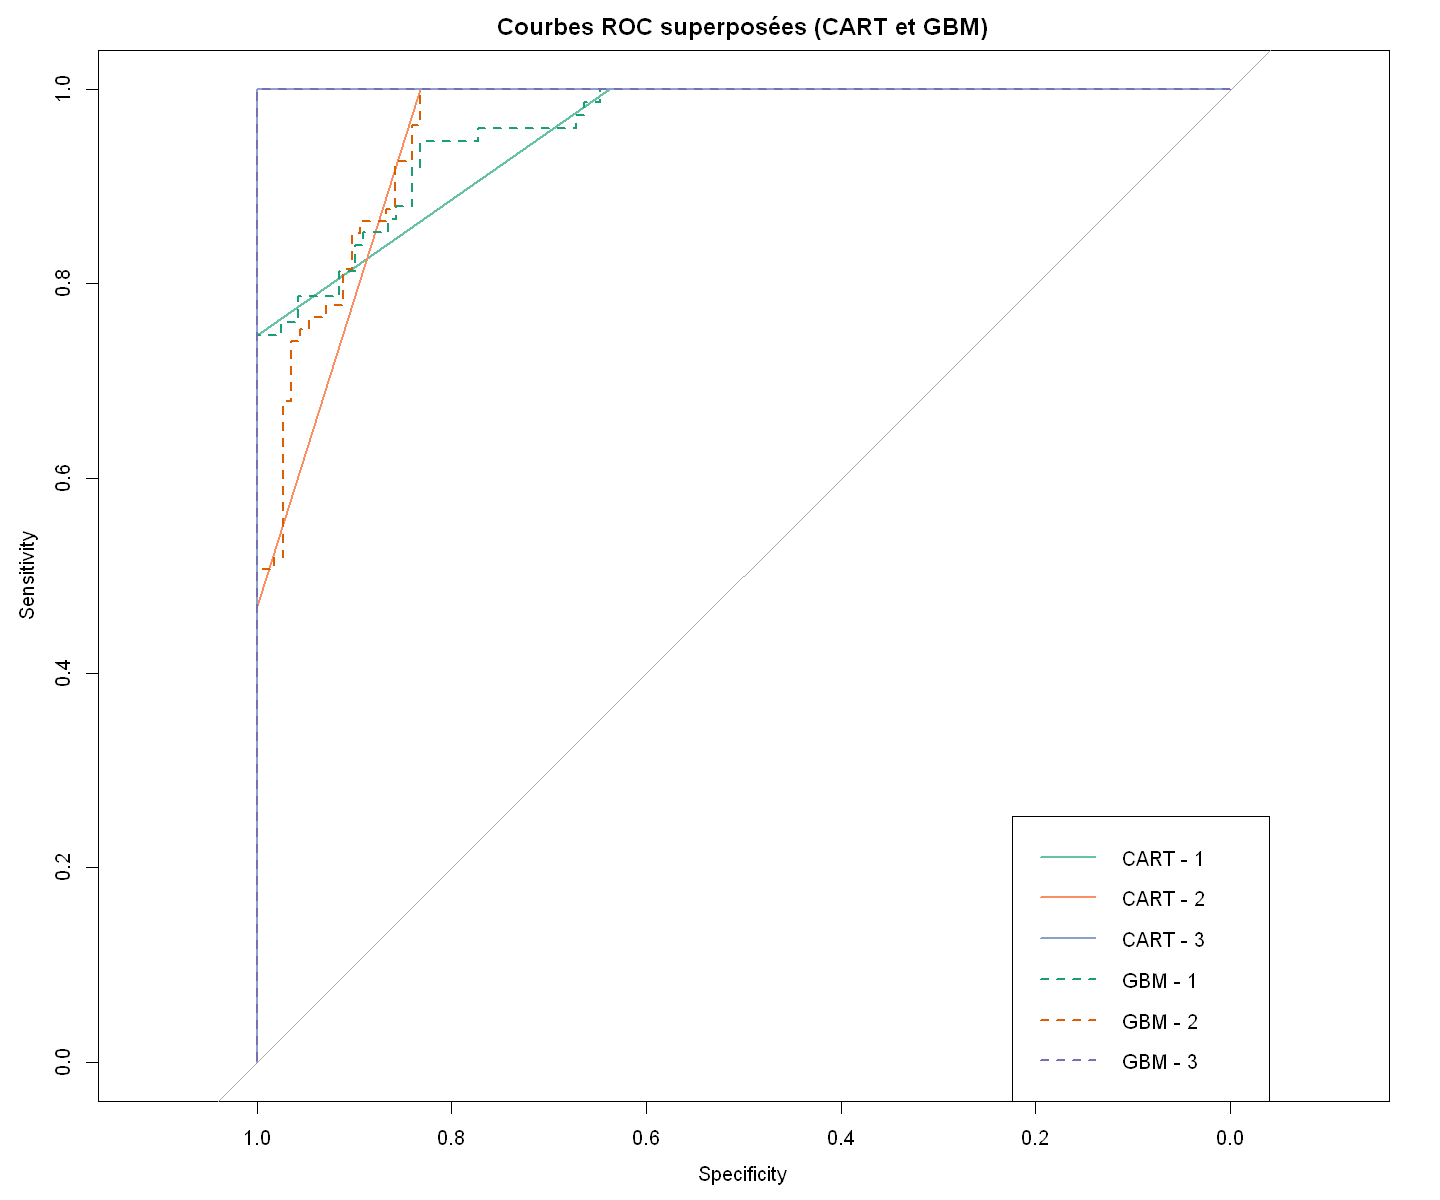

In [ ]:
pred_classes <- predict(gbm_tuned, newdata = data_test_norm, type = "raw")  
proba_gbm <- predict(gbm_tuned, newdata = data_test_norm, type = "prob")    


conf_matrix_gbm <- table(Vrai = data_test_norm$Experience_Level, Prédit = pred_classes)
print(conf_matrix_gbm)
pourcentage_erreur(conf_matrix_gbm)

plot_superposed_roc_curves(proba_cart, "CART", proba_gbm, "GBM")

En comparaison au modèle CART, nous perdons environ 1% de précision en utilsant ce modèle. Aussi, les courbes ROC sont plutôt comparables entre les deux modèles, avec un très léger avantage pour le modèle GBM sans doute. Un résultat plus probable aurait été une meilleure performance du modèle GBM. Cela est sans doute dû à une optimisation compliquée des hyperparamètres.

**Extreme Gradient Boostong** (library *xgboost*)

Nous testons ici une autre méthode de boosting, issu d'une autre librairie, et de nouveau basée sur les arbres binaires. Nous faisons ici le choix d'augmenter encore le nombre d'hyperparamètres à optimiser, dont voici une présentation : 

- $nrounds$ : nombre d'itérations (arbre) 
- $max\_depth$ : profondeur maximale des arbres
- $eta$ : taux d’apprentissage  
- $gamma$ : réduction minimale de la perte requise pour effectuer une division
- $colsample\_bytree$ : fractions de variables échantillonnées par arbre
- $min\_child\_weight$ : nombre minimal d'individus par feuille
- $subsample$ : fractions d'individus échantillonés pour chaque arbre

Etant donné le nombre important de ces hyperparamètres (7), la grille de paramètres est relativement restreinte pour éviter une exécution trop longue.

In [ ]:
set.seed(1234)

# Travail sur les données nécessaire pour cette méthode

data_exp_xgb <- data_exp_norm

X_train_raw <- data_exp_xgb[, -14]
x_train <- model.matrix(~ . -1, data = X_train_raw) #one-hot encoding nécessaire
y_train <- data_exp_xgb$Experience_Level

data_test_xgb <- data_test_norm

X_test_raw <- data_test_xgb[, -14]
x_test <- model.matrix(~ . -1, data = X_test_raw) #one-hot encoding nécessaire
y_test <- data_test_xgb$Experience_Level


QUICK <- FALSE

if (!QUICK) {
    # Définition de la grille de paramètres à tester
    xgb_grid <- expand.grid(
      nrounds = c(100, 200),
      max_depth = c(3, 5),
      eta = c(0.01, 0.1),
      gamma = c(0, 1),
      colsample_bytree = c(0.8, 1),
      min_child_weight = c(1, 3),
      subsample = c(0.8, 1)
    )

    # Ajustement du modèle avec validation croisée
    xgb_tuned <- train(
      Experience_Level ~ ., 
      data = data_exp_xgb,
      method = "xgbTree",
      trControl = param_train,
      tuneGrid = xgb_grid,
      metric = "Accuracy",
      verbose = FALSE
    )
    
} else {
  best_hyperparams <- data.frame(
    nrounds = 100,
    max_depth = 5,
    eta = 0.01,
    gamma = 0,
    colsample_bytree = 1,
    min_child_weight = 1,
    subsample = 0.8
  )
  
  xgb_tuned <- train(
    Experience_Level ~ ., 
    data = data_exp_xgb,
    method = "xgbTree",
    trControl = param_train,
    tuneGrid = best_hyperparams,
    metric = "Accuracy",
    verbose = FALSE
  )
}

print("Nous choisissons les valeurs suivantes pour les hyperparamètres :")
print(xgb_tuned$bestTune)

[1] "Nous choisissons les valeurs suivantes pour les hyperparamètres :"
   nrounds max_depth  eta gamma colsample_bytree min_child_weight subsample
41     100         5 0.01     0                1                1       0.8


In [ ]:
# Travail sur les données nécessaire pour cette méthode
y_train <- as.numeric(data_exp_xgb$Experience_Level) - 1
y_test <- as.numeric(data_test_xgb$Experience_Level) - 1


xgb.model <- xgboost(
  data = x_train,
  label = y_train,
  objective = "multi:softprob",
  num_class = length(unique(y_train)),
  nrounds = xgb_tuned$bestTune$nrounds,
  max_depth = xgb_tuned$bestTune$max_depth,
  eta = xgb_tuned$bestTune$eta,
  verbose = 0,
  colsample_bytree = xgb_tuned$bestTune$colsample_bytree,
  subsample = xgb_tuned$bestTune$subsample,
  gamma = xgb_tuned$bestTune$gamma,
  min_child_weight = xgb_tuned$bestTune$min_child_weight
)


      Vrai
Prédit  0  1  2
     0 56  0  0
     1 19 81  0
     2  0  0 38
[1] "Pourcentage d'erreur : 9.79 %"


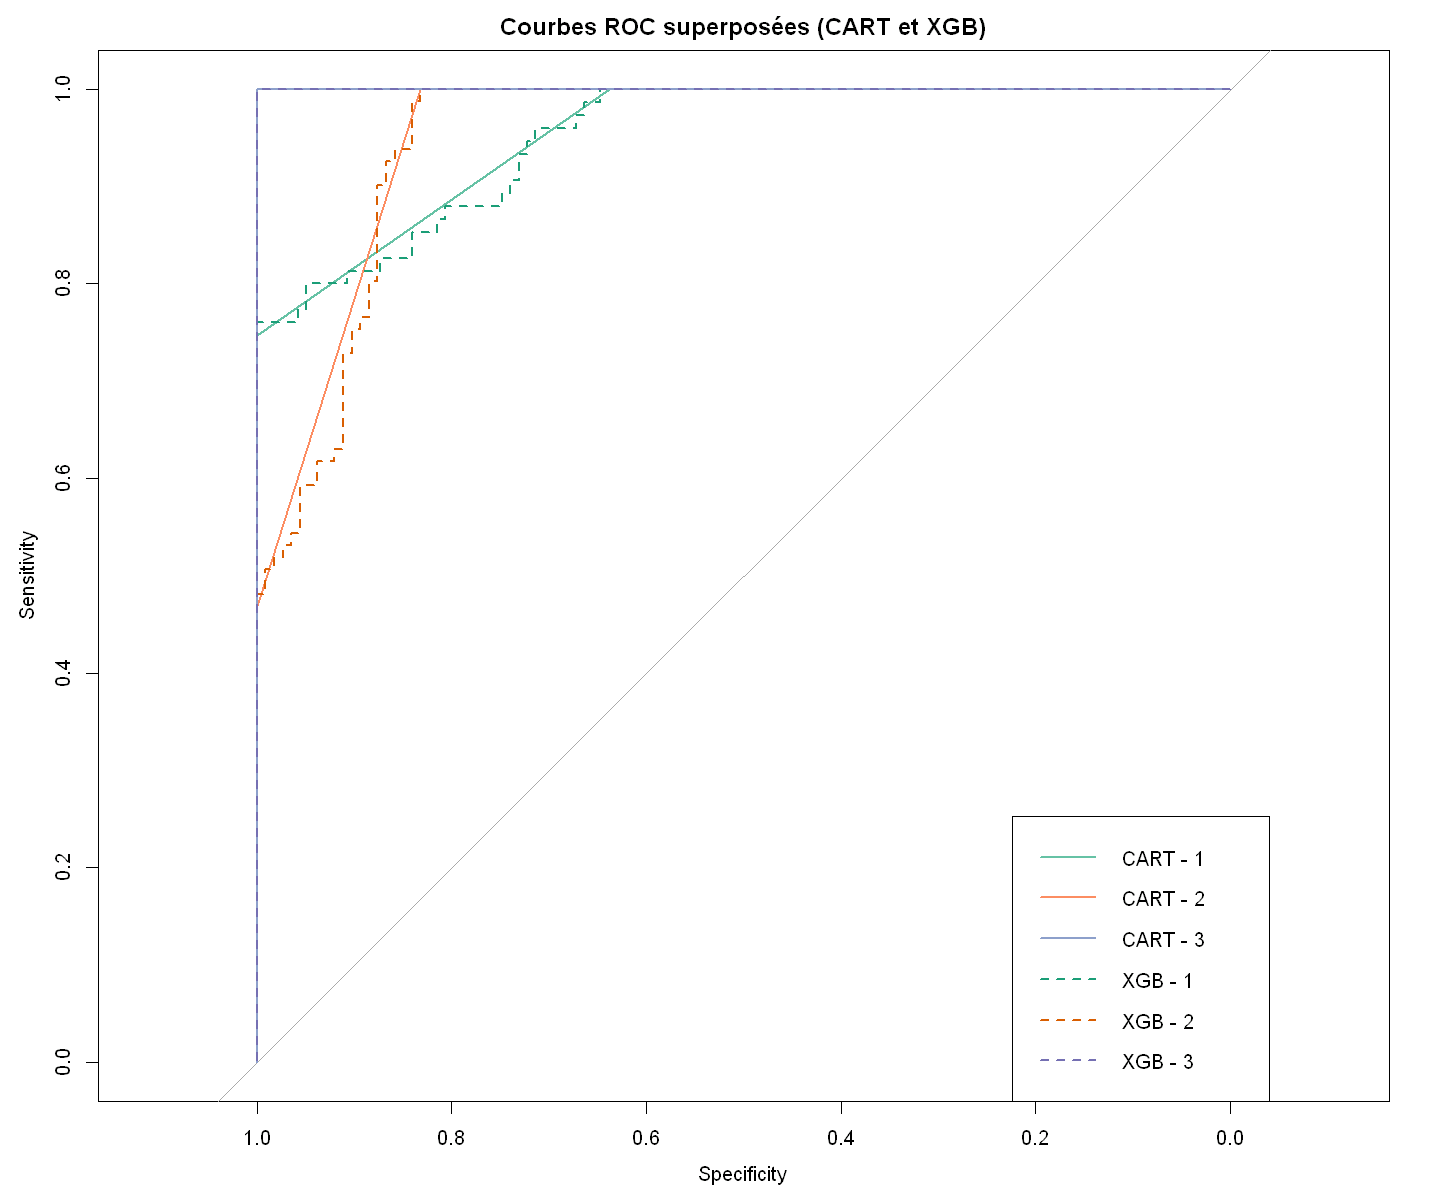

In [ ]:
proba_xgb <- predict(xgb.model, x_test)
proba_xgb <- matrix(proba_xgb, ncol = 3, byrow = TRUE)
class_labels <- levels(as.factor(data_test_norm$Experience_Level))
colnames(proba_xgb) <- class_labels

pred_xgb <- max.col(proba_xgb) - 1


conf_matrix_xgb <- table(Prédit = pred_xgb, Vrai = y_test)
print(conf_matrix_xgb)
pourcentage_erreur(conf_matrix_xgb)

plot_superposed_roc_curves(proba_cart, "CART", proba_xgb, "XGB")

La précision du modèle est sensiblement la même que celle du modèle CART. Cependant, les courbes ROC du modèle XGB sont plus souvent en-dessous de celles du modèle CART, affichant une moins bonne discrimination entre les classes. Encore une fois, la recherche d'hyperparamètres est sans doute ce qui explique l'absence de résultats plus performants. 

# 2.2.5 RdN

*R* ne permet de coder que des RdN à 1 couche "facilement" (sans combinaison de RdN, ou d'appel à des librairies *Python*). L'analyse de ce modèle est plutôt à réaliser à partir de ce qui a été réalisé en *Python*.\
\
Nous nous intéressons ici à 2 hyperparamètres (mais un RdN en comporte en réalité beaucoup plus) :

- $size$ : nombre de neuronnes dans la couche cachée
- $decay$ : weight decay (taux de régularisation $l2* sur les poids)

In [ ]:
QUICK <- FALSE

if (!QUICK) {
    
 # Définition de la grille de paramètres à tester
 grid <- expand.grid(
  size = c(8, 16, 32),
  decay = c(0.1, 0.5, 1, 1.5, 2)
)
    
  # Ajustement du modèle avec validation croisée
  rdn_model <- train(
  Experience_Level ~ .,
  data = data_exp_norm,
  method = "nnet",
  trControl = param_train,
  tuneGrid = grid,
  metric = "Accuracy",  # critère d'optimisation
  maxit = 200,
  trace = FALSE
)
    
} else {
 rdn_model <- list(bestTune = list(size = 8, decay = 2))
}

print(paste("Valeur de size retenue = ", rdn_model$bestTune$size, sep=""))
print(paste("Valeur de decay retenue = ", rdn_model$bestTune$decay, sep=""))

[1] "Valeur de size retenue = 32"
[1] "Valeur de decay retenue = 1.5"


In [ ]:
rdn_model <- nnet(
  Experience_Level ~ ., 
  data = data_exp_norm,
  size = rdn_model$bestTune$size,
  decay = rdn_model$bestTune$decay,
  maxit = 200,
  linout = FALSE 
)

# weights:  707


initial  value 1503.245272 
iter  10 value 386.601901
iter  20 value 325.773208
iter  30 value 294.422412
iter  40 value 290.843313
iter  50 value 289.849396
iter  60 value 289.361147
iter  70 value 288.964974
iter  80 value 288.549347
iter  90 value 288.346234
iter 100 value 288.225491
iter 110 value 288.120597
iter 120 value 288.065640
iter 130 value 288.020355
iter 140 value 287.983918
iter 150 value 287.953456
iter 160 value 287.930341
iter 170 value 287.920172
iter 180 value 287.908544
iter 190 value 287.900288
iter 200 value 287.895464
final  value 287.895464 
stopped after 200 iterations


         Actual
Predicted  1  2  3
        1 62 16  0
        2 13 65  0
        3  0  0 38
[1] "Pourcentage d'erreur : 14.95 %"


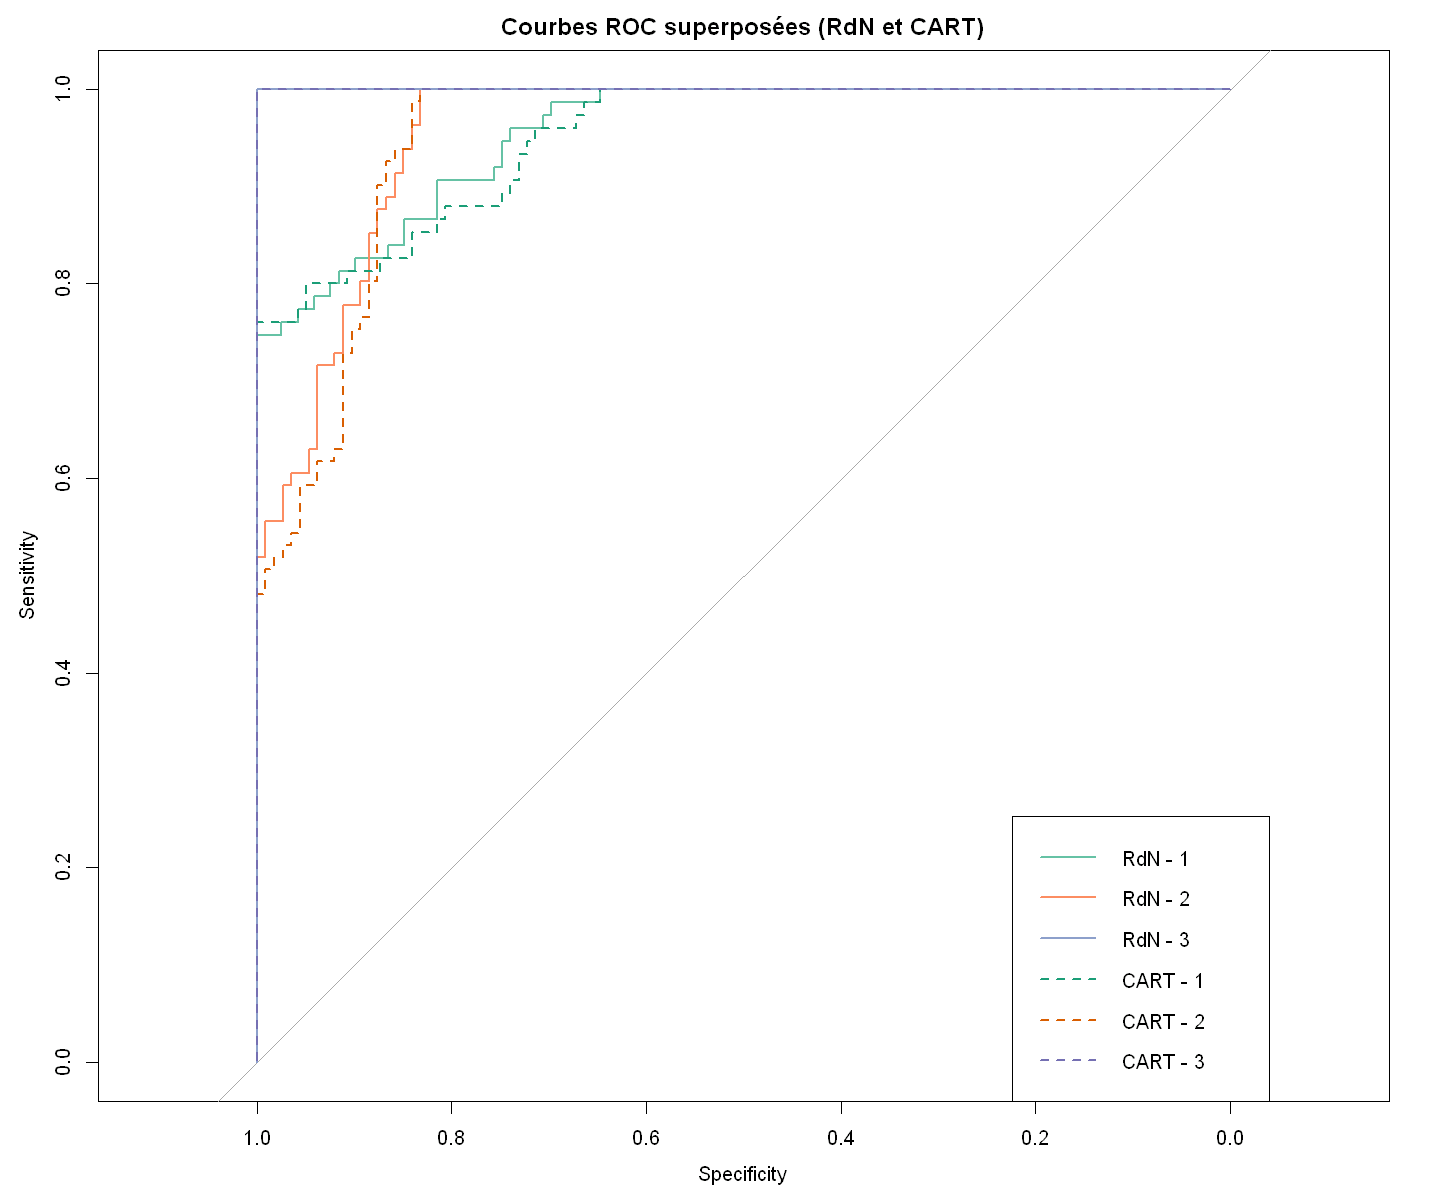

In [111]:
true_labels <- data_test_norm$Experience_Level

predictions <- predict(rdn_model, newdata = data_test_norm[,-14], type = "class")
proba_rdn <- predict(rdn_model, newdata = data_test_norm[,-14], type = "raw")
colnames(proba_rdn) <- levels(true_labels)


conf_matrix_rdn <- table(Predicted = predictions, Actual = true_labels)
print(conf_matrix_rdn)
pourcentage_erreur(conf_matrix_rdn)

plot_superposed_roc_curves(proba_rdn, "RdN", proba_xgb, "CART")

La précision du modèle n'est pas particulièrement bonne. Cela est dû aux limites du modèle RdN sur *R*. Un modèle à 2 couches cachées, et où d'autres hyperparamètres auraient été optimisés seraient préférables. Même si la précision est en-dessous de ce qui était espéré, les courbes ROC du RdN ne sont pour autant pas mauvaises, et semblent même meilleures que celles du modèle CART.

# 2.2.6 Comparaison des méthodes

Nous définissons deux listes contenant les matrices de confusions et les matrices de probabilités de chaque modèle afin de les comparer plus facilement.

Nb : entre l'analyse des résultatas et l'exécution finale, les valeurs suivantes de pourcentage d'erreur ont été modifiées :
- RdN : 15,98% (ancienne) -> 14,95% (nouvelle)
- SVM Linéaire : 15,46% -> 14,95%
- Forest : 8,76% -> 10,82%
Merci de prendre en compte cela

In [112]:
probabilities <- list(
  multinom = proba_multinom,
  ridge = proba_ridge,
  lasso = proba_lasso,
  elastic = proba_elastic,
  lda = proba_lda,
  knn = proba_knn,
  svm_lin = proba_svm.lin,
  svm_rad = proba_svm.rad,
  svm_pol = proba_svm.pol,
  cart = proba_cart,
  forest = proba_forest,
  gbm = proba_gbm,
  xgb = proba_xgb,
  rdn = proba_rdn
)

conf_matrices <- list(
  multinom = conf_matrix_multinom,
  ridge = conf_matrix_ridge,
  lasso = conf_matrix_lasso,
  elastic = conf_matrix_elastic,
  lda = conf_matrix_lda,
  knn = conf_matrix_knn,
  svm_lin = conf_matrix_svm.lin,
  svm_rad = conf_matrix_svm.rad,
  svm_pol = conf_matrix_svm.pol,
  cart = conf_matrix_cart,
  forest = conf_matrix_forest,
  gbm = conf_matrix_gbm,
  xgb = conf_matrix_xgb,
  rdn = conf_matrix_rdn
)


Nous définissons deux fonctions : $compute\_pourcentage\_erreur$ et $calcul\_auc$ afin de comparer les modèles sur leur précision et leur **AUC** (aire sous les courbes ROC).

In [113]:
compute_pourcentage_erreur <- function(mat) {
  erreur <- sum(mat) - sum(diag(mat))
  return(round(100 * erreur / sum(mat), 2))
}

calcul_auc <- function(prob_mat) {
  aucs <- c()
  for (class in data_test_norm$Experience_Level) {
    binary_labels <- as.numeric(data_test_norm$Experience_Level == class)
    if (!is.null(colnames(prob_mat)) && class %in% colnames(prob_mat)) {
      roc_obj <- roc(binary_labels, prob_mat[, class], quiet = TRUE)
      aucs <- c(aucs, auc(roc_obj))
    }
  }
  return(mean(aucs, na.rm = TRUE)) # Moyenne des AUC des 3 coubres ROC
}

Intéressons-nous dans un premier temps à la précision des modèles (que nous observons à travers le pourcentage d'erreur).

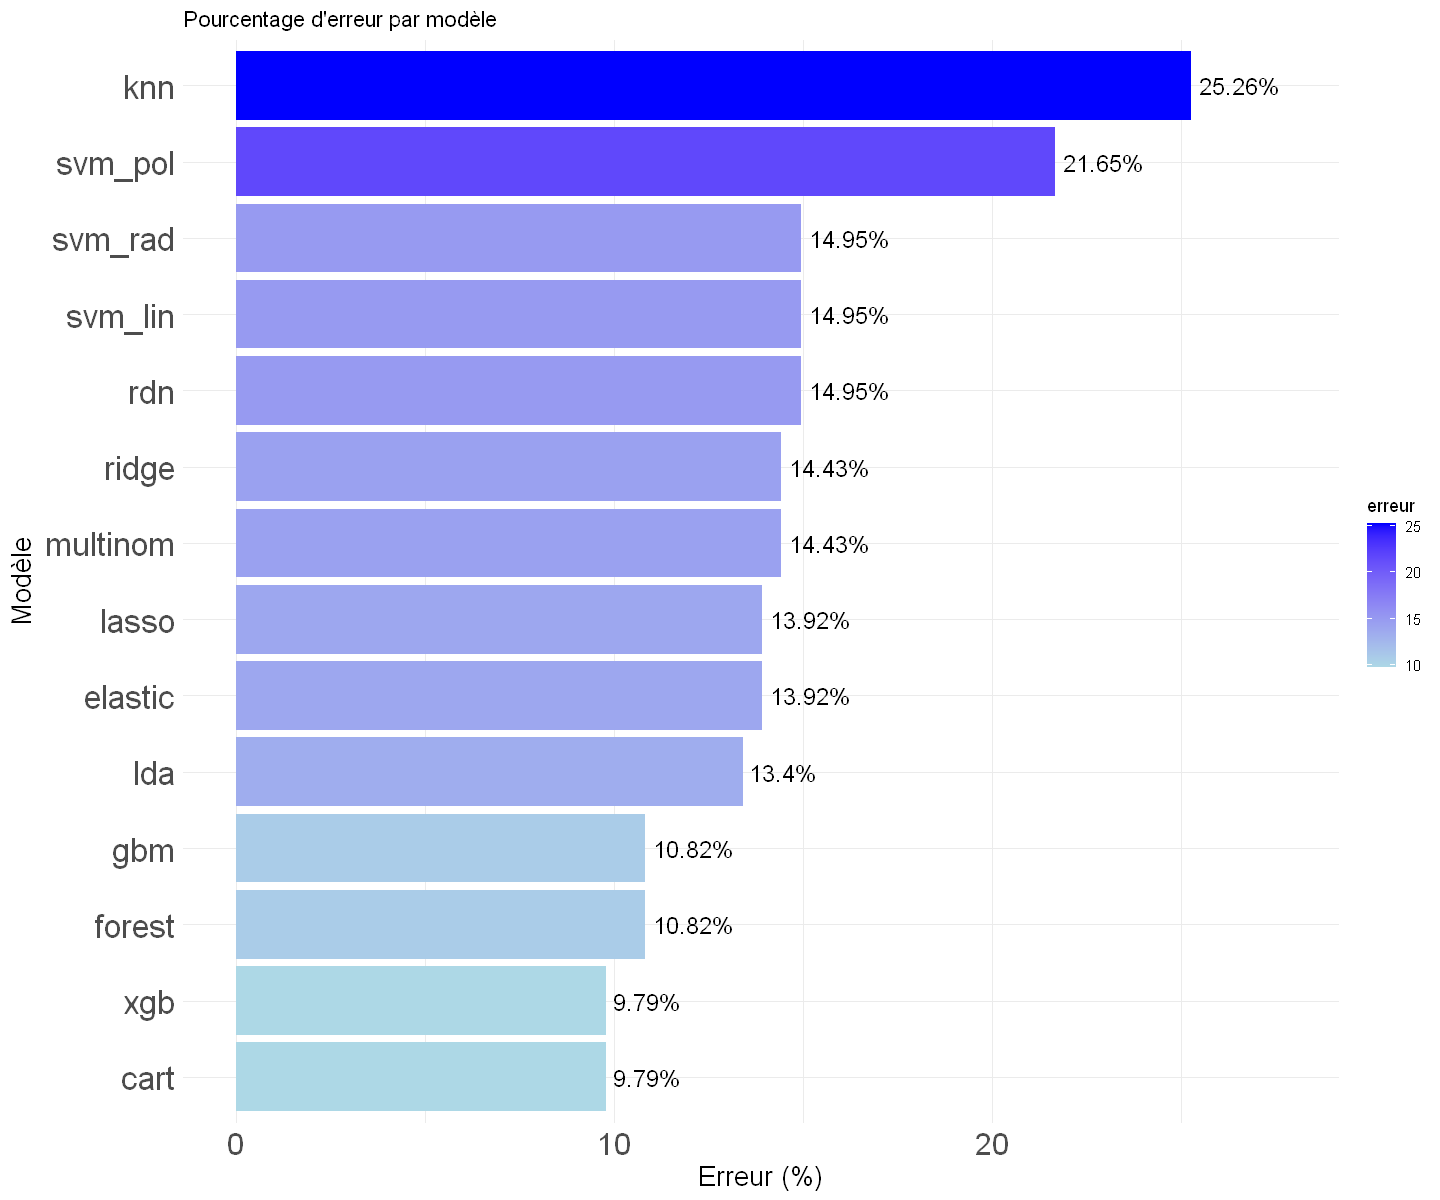

In [114]:
# On applique la fonction compute_pourcentage_erreur à tous les modèles
erreurs <- sapply(conf_matrices, compute_pourcentage_erreur)

# On fabrique un dataframe, plus pratique pour l'affichage
erreurs_df <- data.frame(
  modele = names(erreurs),
  erreur = erreurs
)

# On effectue un tri croissant des résultats obtenus
erreurs_df <- erreurs_df[order(erreurs_df$erreur), ] 

# On affiche cela
ggplot(erreurs_df, aes(x = reorder(modele, erreur), y = erreur, fill = erreur)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = paste0(erreur, "%")), 
            hjust = -0.1, size = 5) +
  coord_flip() +  
  labs(title = "Pourcentage d'erreur par modèle",
       x = "Modèle",
       y = "Erreur (%)") +
  theme_minimal() +
  scale_fill_gradient(low = "lightblue", high = "blue") +
  ylim(0, max(erreurs_df$erreur) * 1.1) +
  theme(
    axis.text.y = element_text(size = 20),   
    axis.title.y = element_text(size = 16),
    axis.text.x = element_text(size = 18),   
    axis.title.x = element_text(size = 16)  
  )

3 groupes de modèle apparaissent à partir de ce graphe :

- Les modèles aux performances médiocres (**21,65 à 25,26 de % d'erreur**) : **kNN** et **SVM Polynomiale**. Pour le premier modèle, ce résultat n'est pas surprenant, le modèle kNN n'est pas réputé pour être performant. COncernant le second modèle, l'explication se trouve sans doute dans une mauvaise optimisation des hyperparamètres.
- Les modèles aux bonnes performances (**13,4 à 15,98 de % d'erreur**) : Nous retrouvons dans cette catégorie les  modèles basées sur une **régression multinomiale**, les **SVM** bien paramétrées, la **LDA**, ainsi que le **RdN**. Concernant le RdN, des résultats meilleurs étaient attendus, mais la recherche d'hyperparamètres et la seule couche cachée expliquent sans doute cela. Les modèles SVM offrent de bons résultats, mais moins bons que ceux des modèles basés sur les régressions multinomiales. On peut sans doute attribuer cela à une séparaison des individus pas assez nette, en particulier entre les modalités 1 et 2. Aussi, l'interprétabilité du modèle **LASSO** est grandement apprécié, et permet d'avoir une première idée des variables importantes pour discriminer les classes.
- Les modèles aux excellentes performances (**8,76 à 10,82 de % d'erreur**) : Il s'agit des modèles basés sur les arbres binaires de décisions (**CART**, **Forêt aléatoire**, **XGB** et **GBM**). Ces algorithmes sont réputés pour être efficace, chose vérifiée ici. Les méthodes de boosting devraient cependant afficher de meilleurs résultats. On peut émettre l'hyptohèse que cela est causé par les grilles d'hyperparamètres trop réduites pour la validation croisée. L'écart entre ces modèles reste cependant très faible, il faudrait les tester sur d'autres échantillons (plus larges) pour pouvoir faire un choix éclairer. La très grande interprétabilité du modèle CART (et du modèle Forêt aléatoire dans une moindre mesure) sont des points à ne pas négliger.


Intéressons-nous dans un désormais à l'AUC moyen des modèles. Un modèle avec une AUC élevé discrimine bien les individus, et ce même en changeant le seuil auquel on choisit une classe par rapport aux autres (fixé à 0.5 ici).

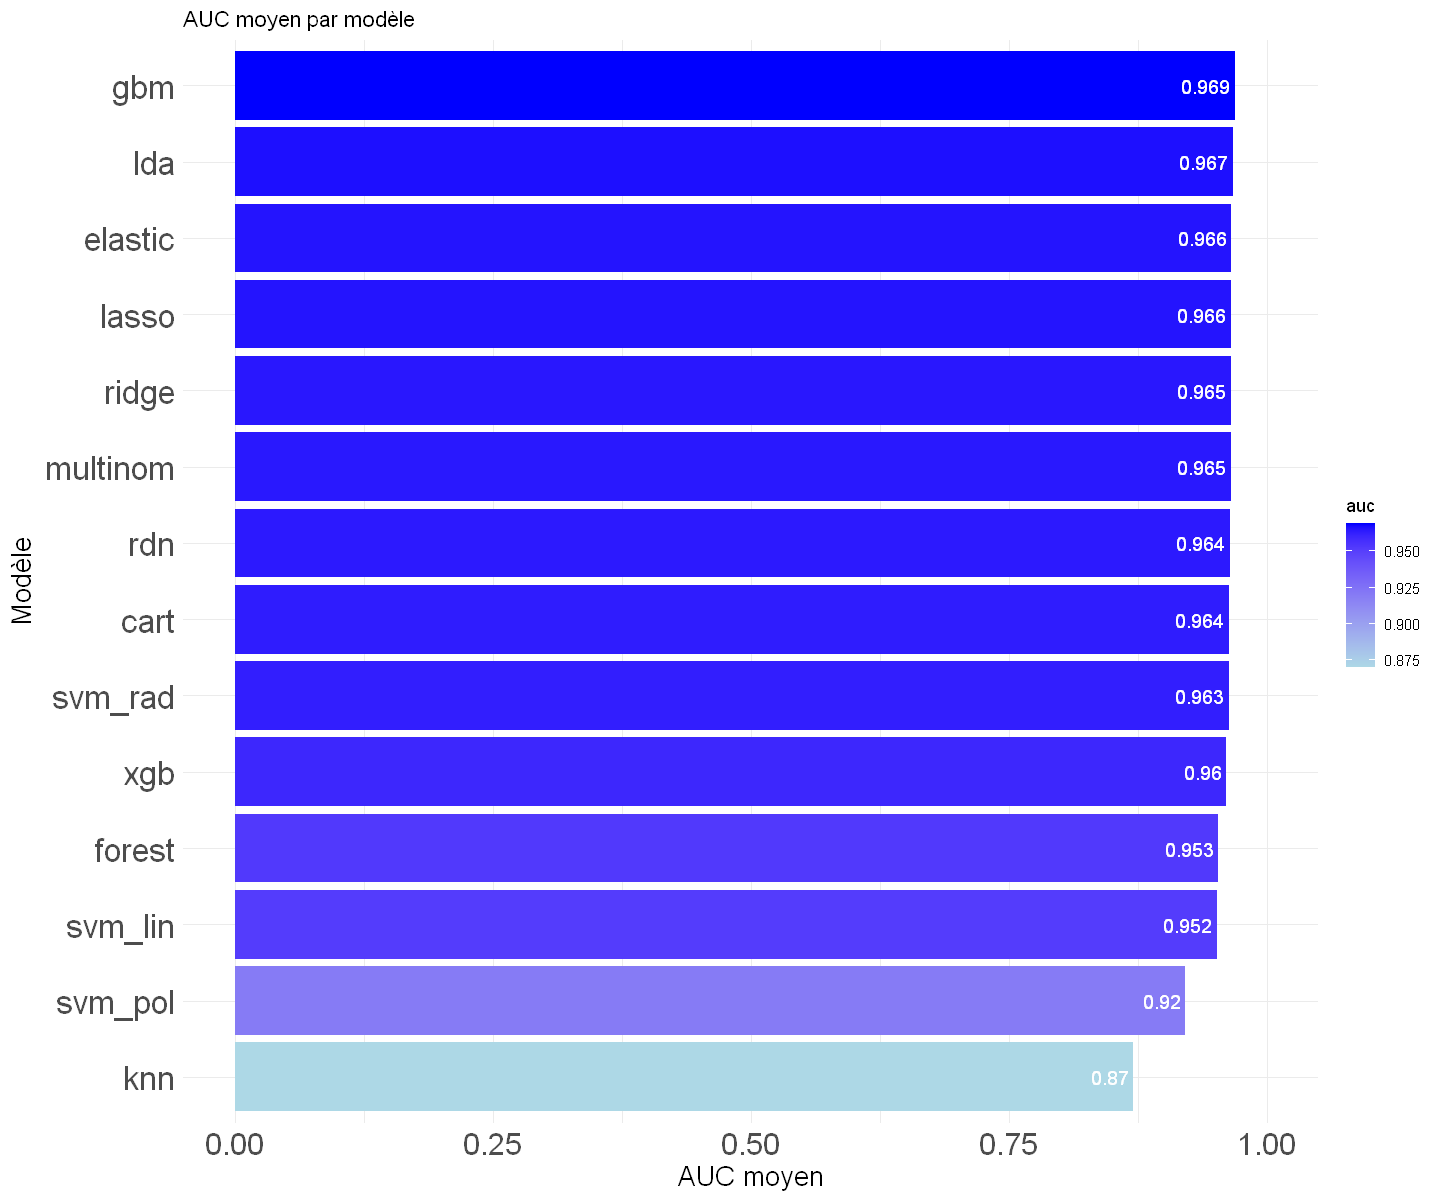

In [115]:
# On applique la fonction calcul_auc à tous les modèles
aucs <- sapply(probabilities, calcul_auc)

# On effectue un tri croissant des résultats obtenus
aucs_sorted <- sort(aucs, decreasing = TRUE)

# On fabrique un dataframe, plus pratique pour l'affichage
aucs_df <- data.frame(
  modele = names(aucs_sorted),
  auc = aucs_sorted
)

# On affiche cela
ggplot(aucs_df, aes(x = reorder(modele, auc), y = auc, fill = auc)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = round(auc, 3)), 
            hjust = 1.1, color = "white", size = 4) + 
  coord_flip() +
  labs(title = "AUC moyen par modèle",
       x = "Modèle",
       y = "AUC moyen") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 20),   
    axis.title.y = element_text(size = 16),
    axis.text.x = element_text(size = 18),   
    axis.title.x = element_text(size = 16)  
  )+
  scale_fill_gradient(low = "lightblue", high = "blue") +
  ylim(0, 1) 

- Comme précédemment, on peut aisément distinguer les deux modèles ayant eu des résultats médiocres (AUC de**0,87 à 0.92**), **kNN** et **SVM Polynomial**, ce qui est plutôt cohérent.
- Il est par la suite plus compliqué de distinguer des groupes aussi clairement que précédemment, mais un léger saut nous permet de regrouper les modèles suivants (AUC de **0.952 à 0.959**) : ils'agit des modèles **SVM Linéaire**, **Forêt aléatoire** et **XGB**. La tendance des courbes ROC des deux derniers modèles avaient déjà été remarqués. Concernant la **SVM Linéaire**, son AUC moyen est cohérent au regard de sa précision.
- Les autres modèles affichent des AUC très proches les uns des autres : de **0.963 à 0.967**. De si légères différences sont compliquées à intepréter. Les modèles basés sur la **régression multinomiale** sont tous dans cette catégorie (le modèle **Elastic Net** et **Lasso** affichent de meilleurs AUC que le modèle basique et **Ridge**). Aussi, nous pouvons observer que le modèle avec le meilleur AUC moyen (**LDA**) n'est pas celui avec la meilleure précision.

Comparons les courbes ROC du meilleur modème en terme de précision (**Forêt Aléatoire**) et en terme d'AUC (**LDA**) :

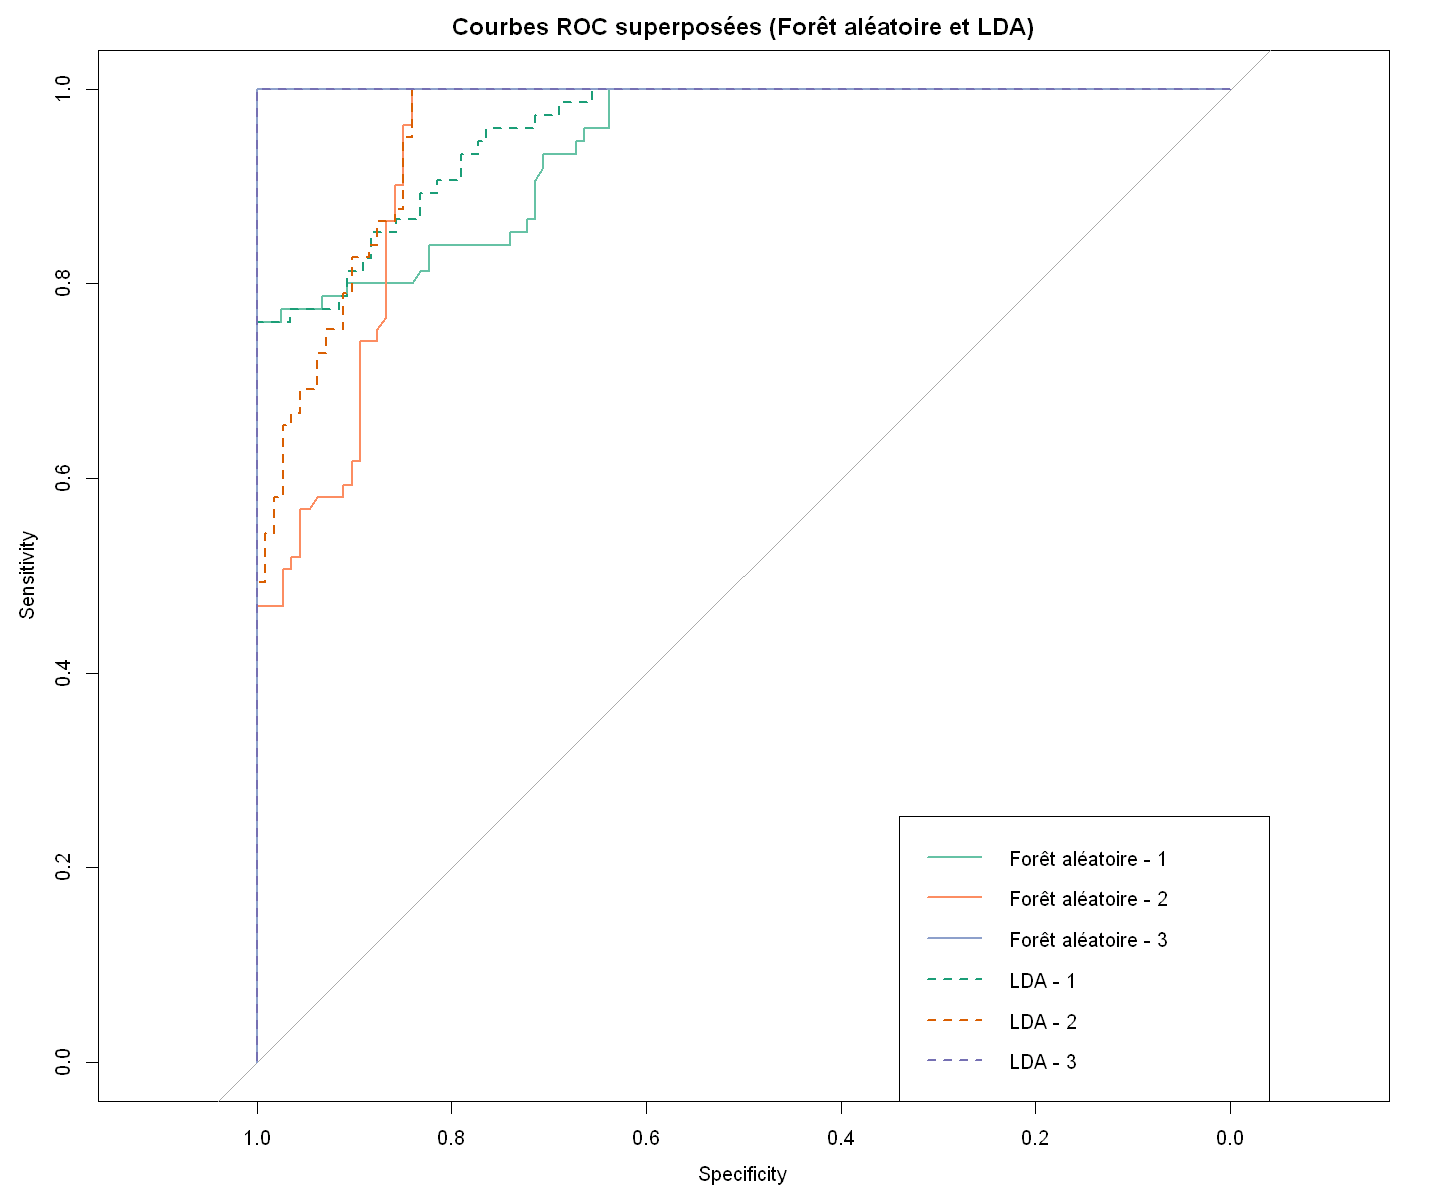

In [116]:
plot_superposed_roc_curves(proba_forest, "Forêt aléatoire", proba_lda, "LDA")

On s'aperçoit effectivement que les courbes ROC du modèle LDA sont plus souvent au-dessus que celles du modèles Forêt aléatoire. On voit par ailleurs que les courbes ROC du modèle Forêt aléatoire effectue un "saut" qui les éloigne grandement du point visé (de coordonnées (1;1)). En dehors de ces sauts (partie supérieure gauche de la "croix" formée par le sauts), les courbes ROC de ce modèle ne sont pas si mauavaises comparés à celle du modèle LDA. 

# 2.2.7 Conclusion

- Toutes les méthodes ont particulièrement bien discriminés la **classe 3** (niveau d'expérience expert) des deux autres. Il y a donc une nette différence de profils entre ces individus et les autres. En se basant sur les interprétations de coefficient effectués précedemment, ces individus "expert" ont le profil suivant : une fréquence d'entraînement importante (**Workout_Frequency** souvent égale à 5)et des sessions d'entraînements longues et intenses (**Session_Duration** et **Calories_Burned** élevés), ainsi qu'un corps très athlétique (**Fat_Percentage** faible). Ce profil esquissé est plutôt cohérent par rapport à ce qu'on aurait pu imaginer avant d'effectuer toutes ces méthodes de classification.
- Concernant la **classe 2**, cette dernière est plus difficilement différentiable de la classe 1. En se basant encore une fois sur l'interprétation des coefficients, le profil type de ces individus est le suivant : entraînement plutôt régulier (**Workout_Frequency** souvent égale à 3 ou 4), orienté vers des activités de type *force* ou *yoga* (**Workout_Type**). Aussi, les coefficients du modèle de Forêt aléatoire particulièrement semble nous indiquer que des variables utile pour discriminer les individus de la classe 1 et de la classe 2 sont **Session_Duration** et **Calories_Burned**. Les individus de cette classe ont ainsi des caractéristiques qui peuvent s'approcher de ceux de la classe 3, avec tout de même une fréquence d'entraînement et une inténsité d'entraînement plus faible. Ce profil esquissé est encore une fois plutôt cohérent par rapport à ce qu'on aurait pu imaginer avant d'effectuer toutes ces méthodes de classification.
- Enfin la **classe 1** semble la plus difficile à discriminer. Les individus étant débutants, leurs profils sont donc plus variés que ceux des individus plus expérimentés, présentant un profil sportif plus uniforme et en cohérence avec l'objectif de performance. Les individus "débutant" semblent avoir pour habitude de ne pas venir très souvent, de ne pas brûler beaucoup de calories, et d'avoir une fréquence cardiaque élevé durant l'entraînement, ce qui traduit une condition cardiovasculaire moins bonne que pour les autres individus. Ce profil esquissé n'est pas en contradiction par rapport à ce qu'on aurait pu imaginer avant d'effectuer toutes ces méthodes de classification, mais n'est pas assez précis pour dresser un profil type.

En nous rappelant du travail effectuer durant l'analyse exploratoire des données, l'ACP nous donnait un indice concernant les résultats obtenus. Nous avions en effet observé que les individus avec un niveau d'entraînement expert semblent être ceux qui brûlent le plus de calories. Aussi, nous avions fait le constat que les individus avec un niveau d'entraînement intermédiaire et débutant sont plus difficilement discernables par l'ACP que ceux experts. Ces deux constats ont été confirmés par les modèles de classification.

Enfin, si nous devions choisir un modèle à appliquer à des fins plus "industriels", celui-ci serait sans doute le modèle **Forêt aléatoire**. Ce dernier offre un niveau de précision important, et ses courbes ROC ne sont pas mauvaises.\
\
Aussi, si un intérêt économique ou d'un autre ordre venait à apparaître, et rendrait plus important la discrimination d'une certaine classe d'individus, il serait nécessaire de comparer ces modèles autrement, par exemple à travers le $F_\beta$ score, qui permet de fixer un "coût" plus important à la détection d'une classe précise. On peut par exemple imaginer dans ce jeu de données que, dans le cadre de publicités ciblées, il est moins grave de surévaluer le niveau d'entraînement d'un individu (qui se sentirait surclassé), plutôt que le sous-évaluer (ce qui serait ressenti comme de la non-reconnaissance d'un investissement porté sur les activités réalisés à la salle de musculation).